In [1]:
import importlib, yaml
import os, pandas as pd, numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
from sod.core import pdconcat
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
from sklearn.metrics import roc_curve
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

print('loading source testset')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print('Columns')
print(allset_test.columns.tolist())

# print()
# print('Reading source train dataframe for event times')
# dfr = pd.read_hdf('/Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_train.hdf',
#            columns=['Segment.db.id', 'dataset_id', 'event_time'])
# assert not pd.isna(dfr.event_time).sum()
# # little hack to have the same id column name as the test:
# dfr.rename({'Segment.db.id': 'allset_test.id'}, axis=1, inplace=True)
# print('Columns')
# print(dfr.columns.tolist())

print()
print('DONE')



loading source testset
Columns
['allset_test.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'channel_code', 'magnitude', 'distance_km', 'location_code']

DONE


In [2]:
# Reading (creating) predictions on the test set instances

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.yaml/'))
assert os.path.isdir(maindir)

names = [
    # 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
]
# check we did provide different file names:
assert len(set(names)) == len(names)


print('Reading the following classifiers (clf) with relative id (id: clf name):')
for i, n in enumerate(names):
    print('[%d]: %s' % (i, n))
clfs = [load(os.path.join(maindir, 'models', name+'.model')) for name in names]
# predictions must be recalculated
print('Calculating %d predictions' % len(names))

print('Predicting (needs to be run because saved dataframes miss a column)')
for clf in clfs:
    columns = ['psd@5sec']
    _allset_test = allset_test.dropna(subset=columns)
    pred_dfs = [sod_core_eval.predict(clf, _allset_test, *columns) for clf in clfs]

    
classnames = sod_core_dataset.allset_test.classnames
classes = {_: sod_core_dataset.allset_test.class_selector[_] for _ in classnames}
assert len(classes) == 3

print('Setting scores with offset and normalization')
# setting stuff:
for pred_df in pred_dfs:
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    
    # get best threhold, calcuated from validation set only (inliers + outliers, no Me unknown):
    pred_df_outl_inl_only = pred_df[classes[classnames[0]](pred_df) | classes[classnames[1]](pred_df)]
    fpr, tpr, th = roc_curve(pred_df_outl_inl_only.outlier, pred_df_outl_inl_only.predicted_anomaly_score)
    argmax = np.argmax((1-fpr[1:])*tpr[1:])
    best_th = th[1:][argmax]
    
    scores = np.copy(pred_df.predicted_anomaly_score.values)
    
    # offset: ====================
    scores += 0.5 - best_th
    # ============================
    pred_df['score_samples_offset_only'] = np.copy(scores)
    
    # adjust: ====================
    _max = np.nanmax(scores)
    scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    # ============================
    pred_df['score_samples'] = scores

print('Prediction dataframe columns:')
print(pred_df.columns.tolist())
print('DONE')

Reading the following classifiers (clf) with relative id (id: clf name):
[0]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100
[1]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50
[2]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50
Calculating 3 predictions
Predicting (needs to be run because saved dataframes miss a column)
Setting scores with offset and normalization
Prediction dataframe columns:
['allset_test.id', 'predicted_anomaly_score', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier', 'cha_id', 'score_samples_offset_only', 'score_samples']
DONE


['allset_test.id', 'predicted_anomaly_score', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier', 'cha_id', 'score_samples_offset_only', 'score_samples', 'event_time']
['allset_test.id', 'predicted_anomaly_score', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier', 'cha_id', 'score_samples_offset_only', 'score_samples', 'event_time']
['allset_test.id', 'predicted_anomaly_score', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier', 'cha_id', 'score_samples_offset_only', 'score_samples', 'event_time']
Getting station networks and stations


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)




121 channels to check (one plot per channel, each blue point is one event's score):

Channel SJ.BEO..BH? (database: me, station id: 1070). 2984 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


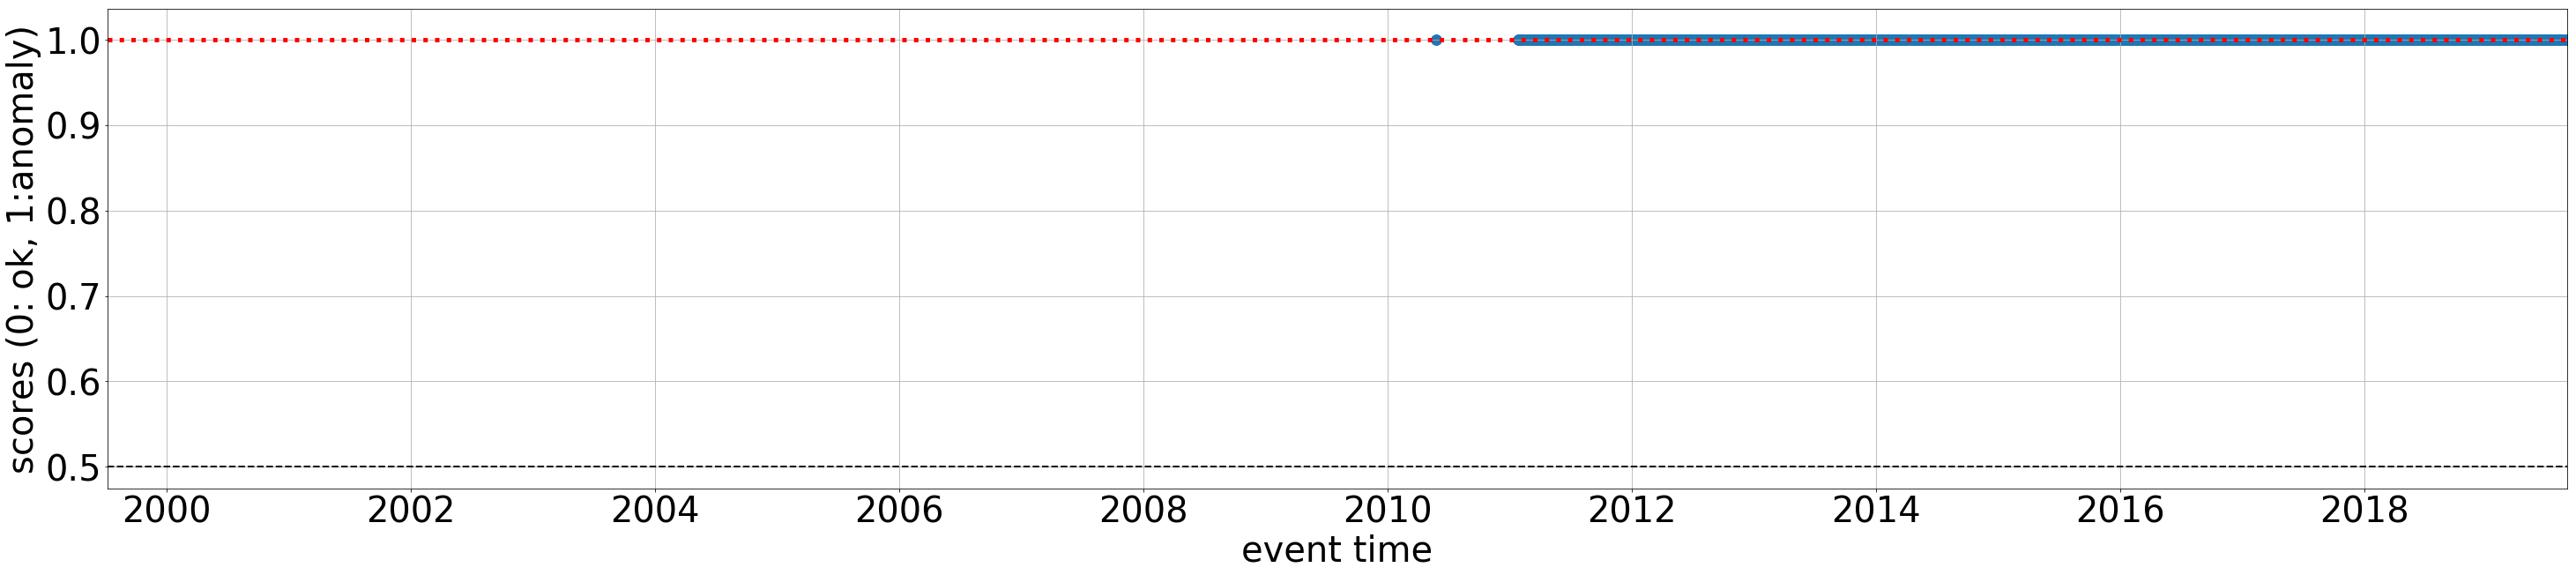

Channel SJ.DJES..BH? (database: me, station id: 1071). 2493 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


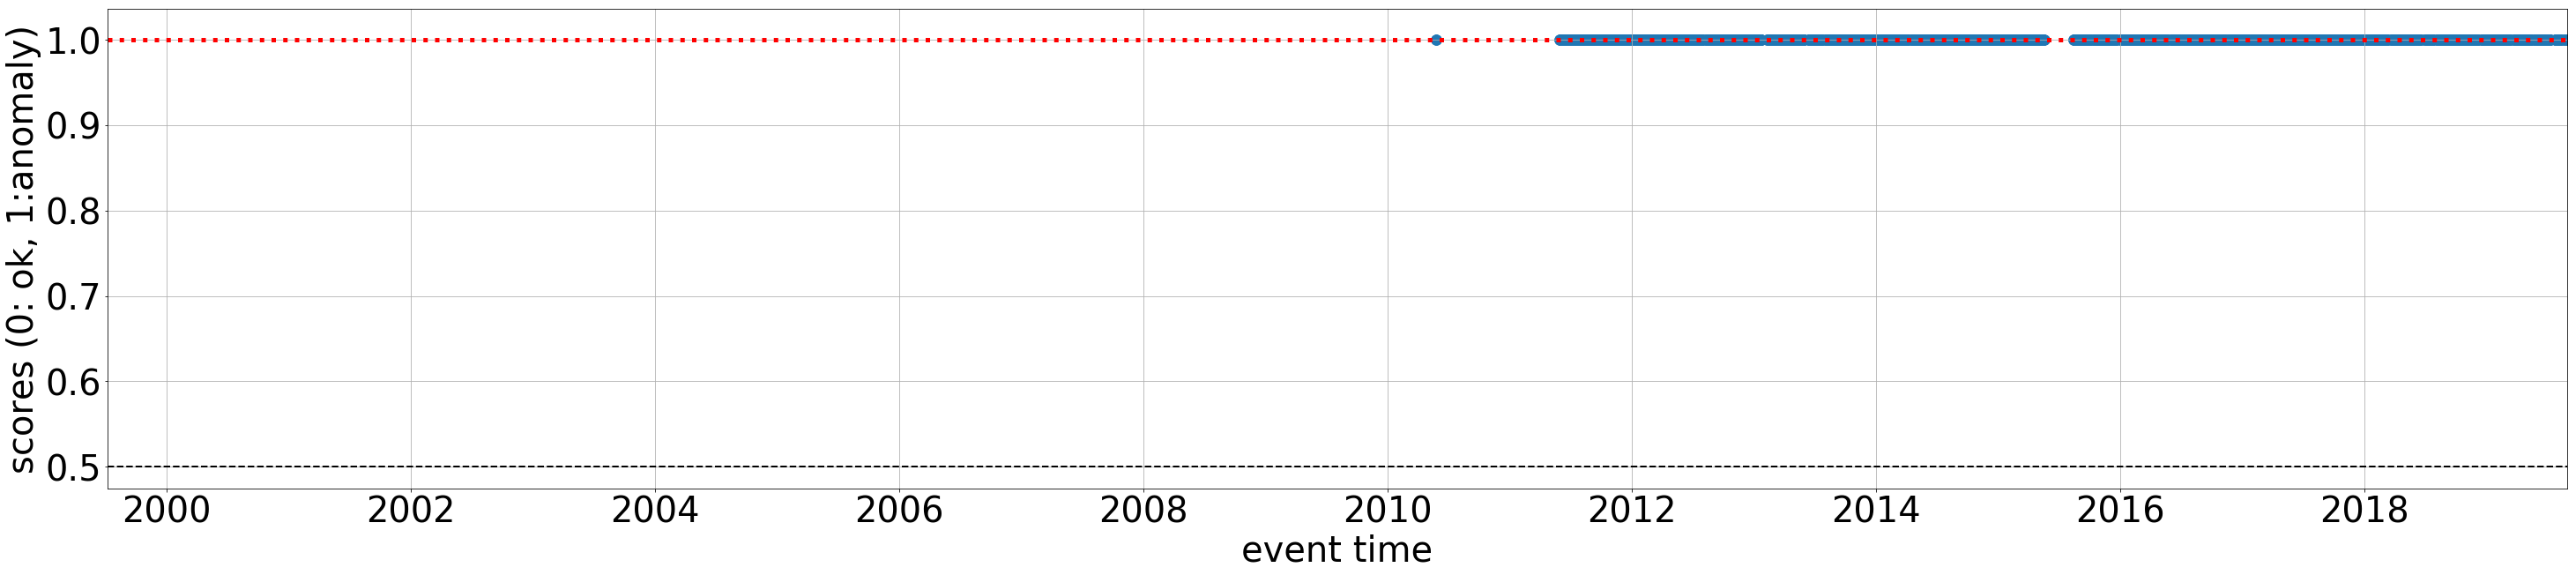

Channel SL.BOJS..BH? (database: me, station id: 3727). 55 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


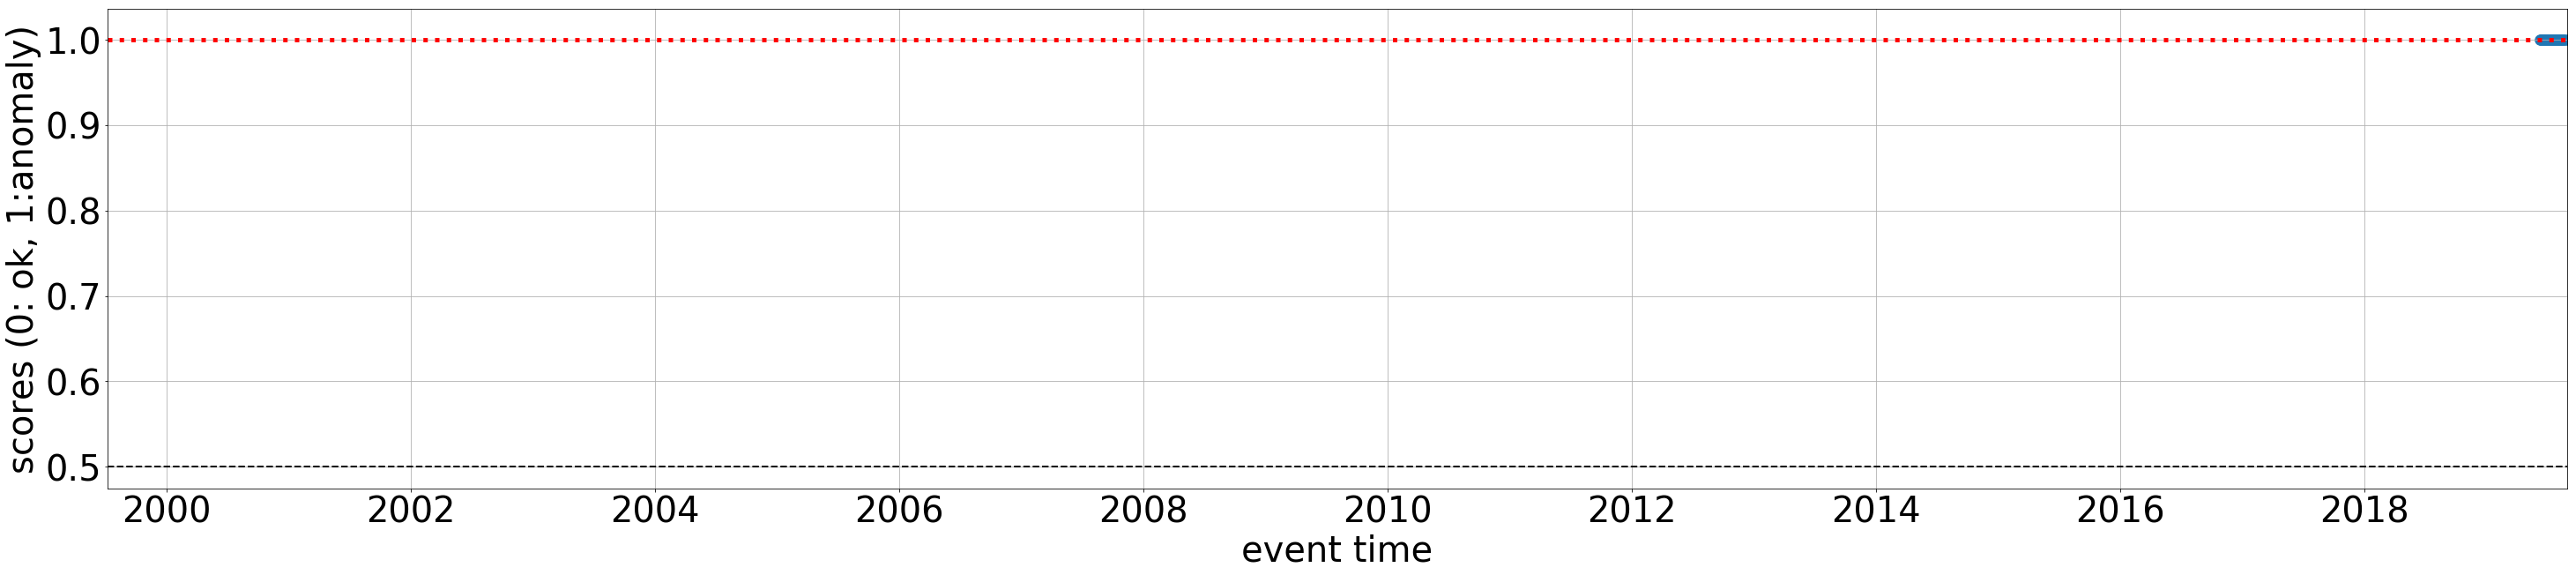

Channel SL.MOZS..BH? (database: me, station id: 3728). 66 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


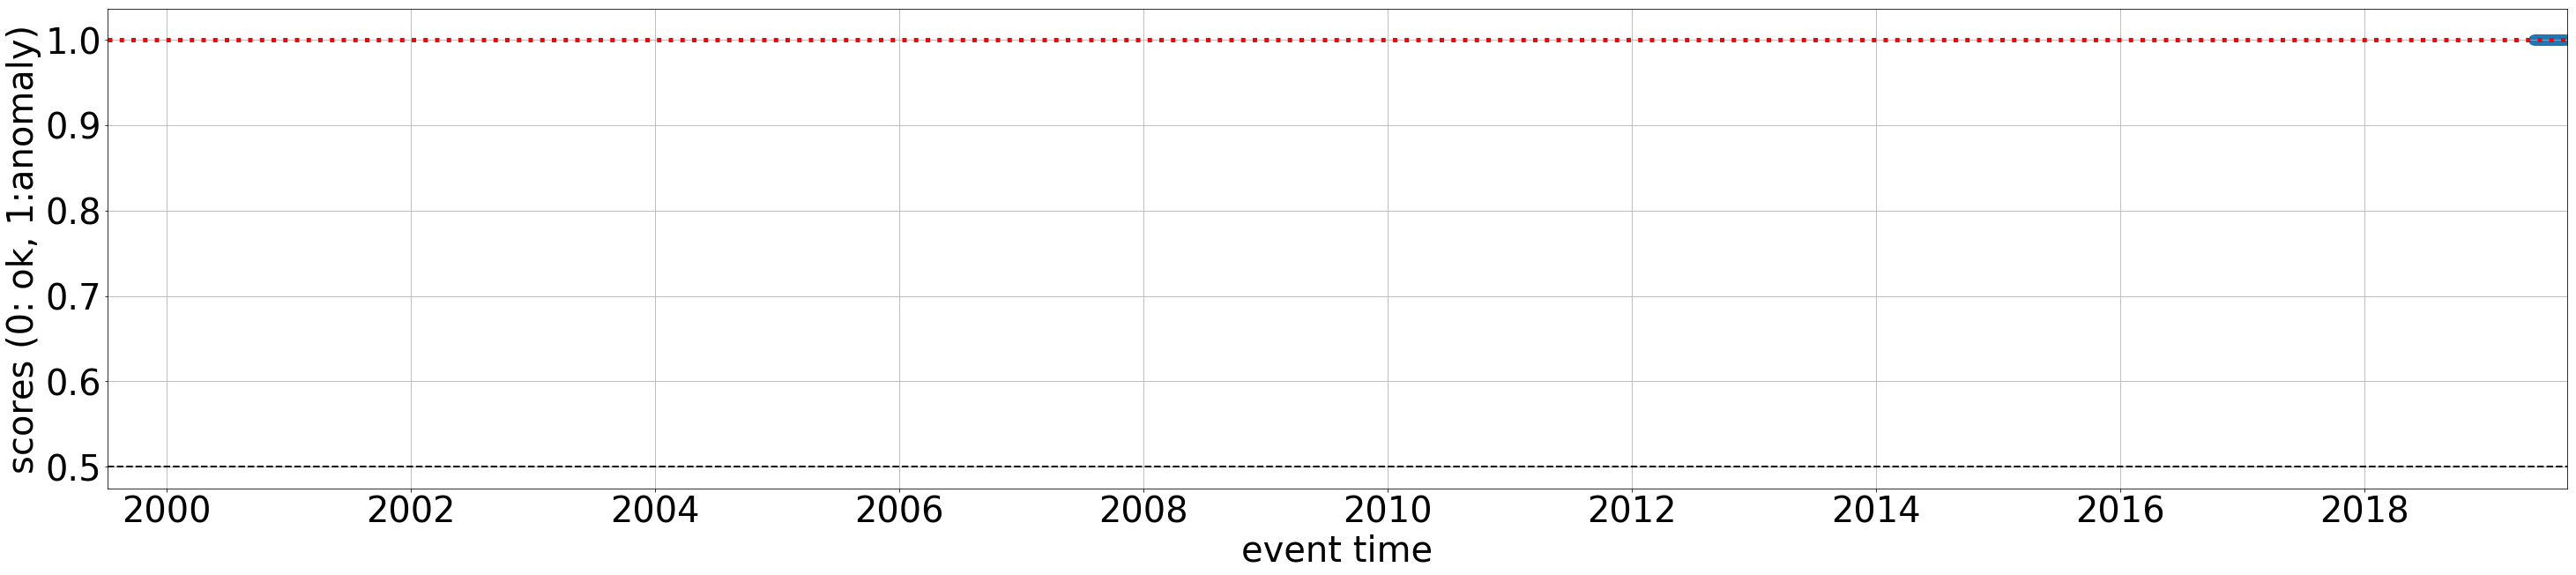

Channel SL.PDKS..BH? (database: me, station id: 3729). 436 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


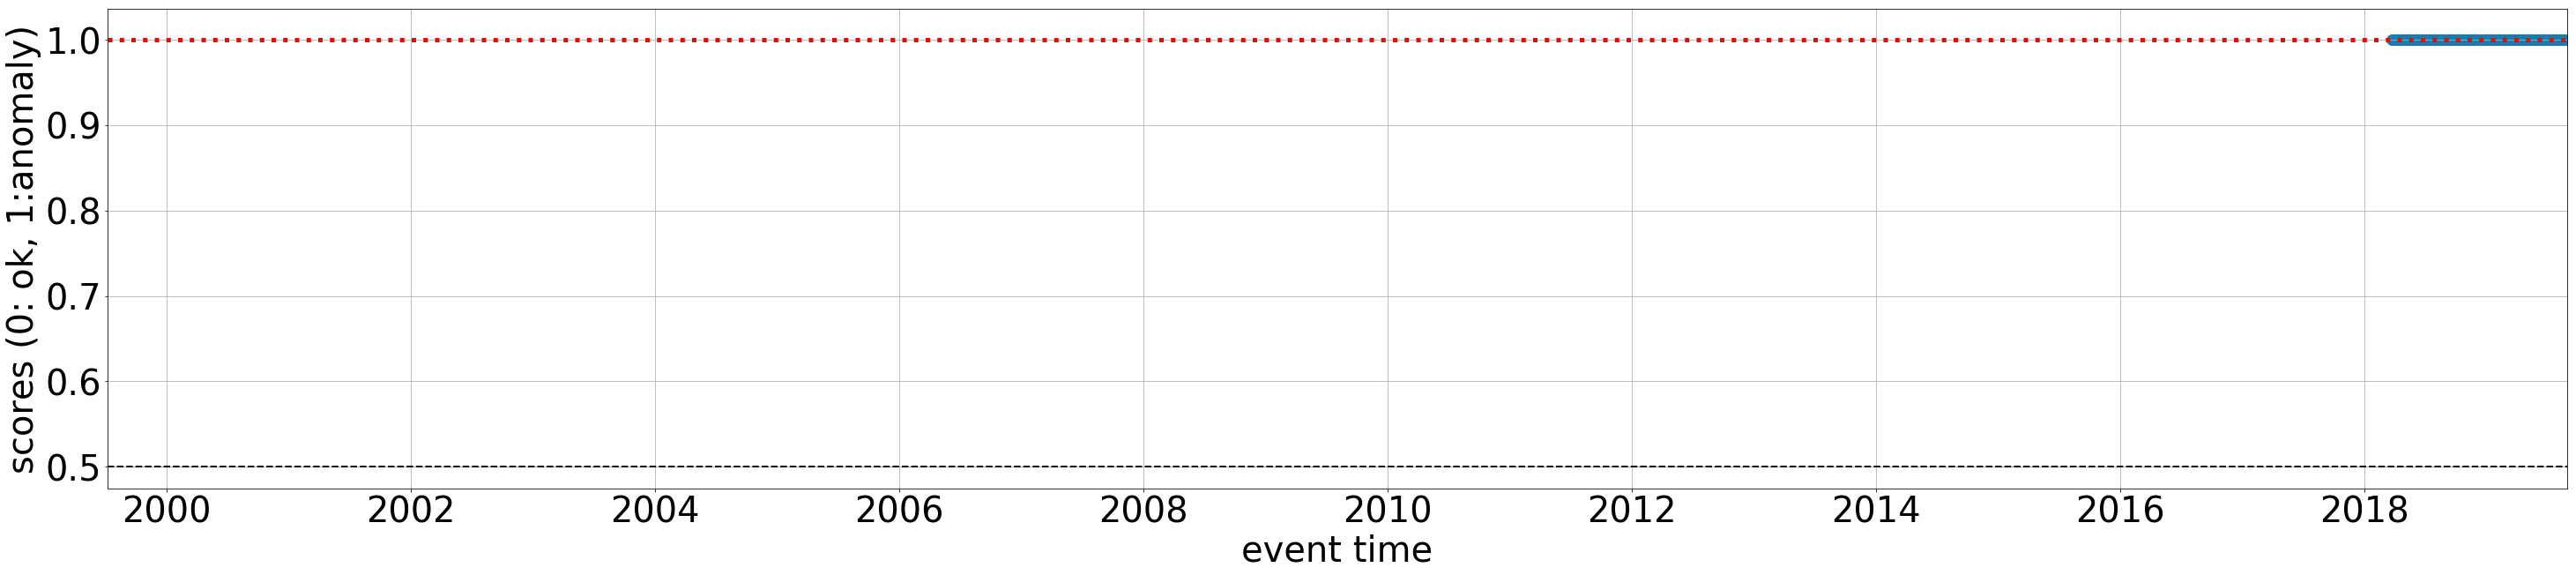

Channel SL.VNDS..BH? (database: me, station id: 3730). 147 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


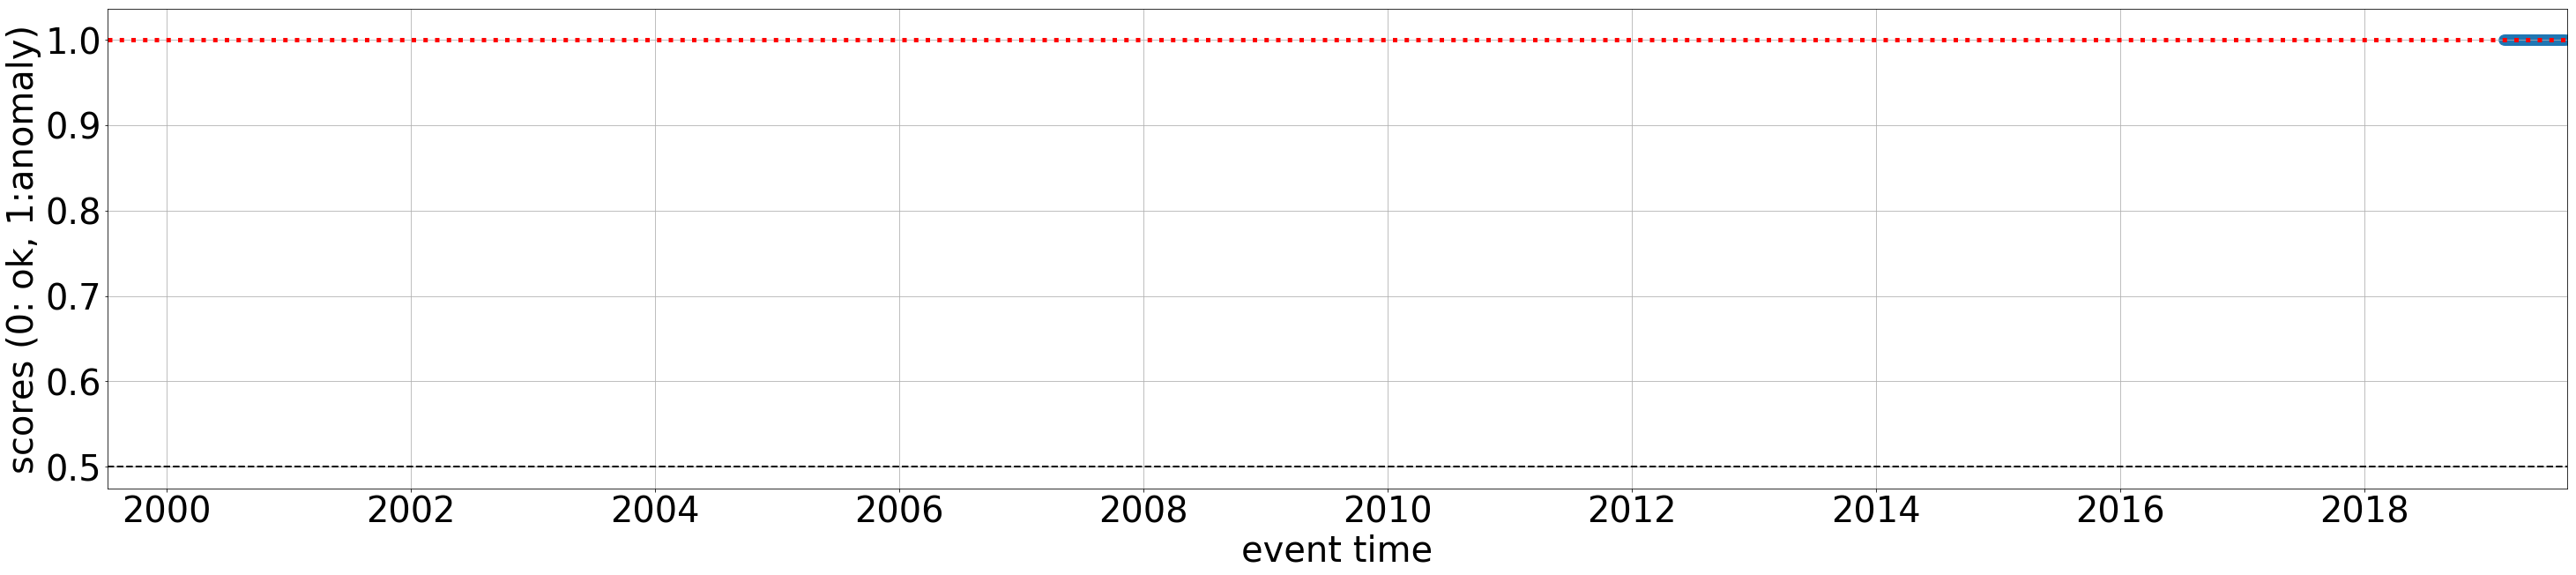

Channel SL.ZAVS..BH? (database: me, station id: 3731). 111 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  1.000[0] 0.999[1] 0.986[2]


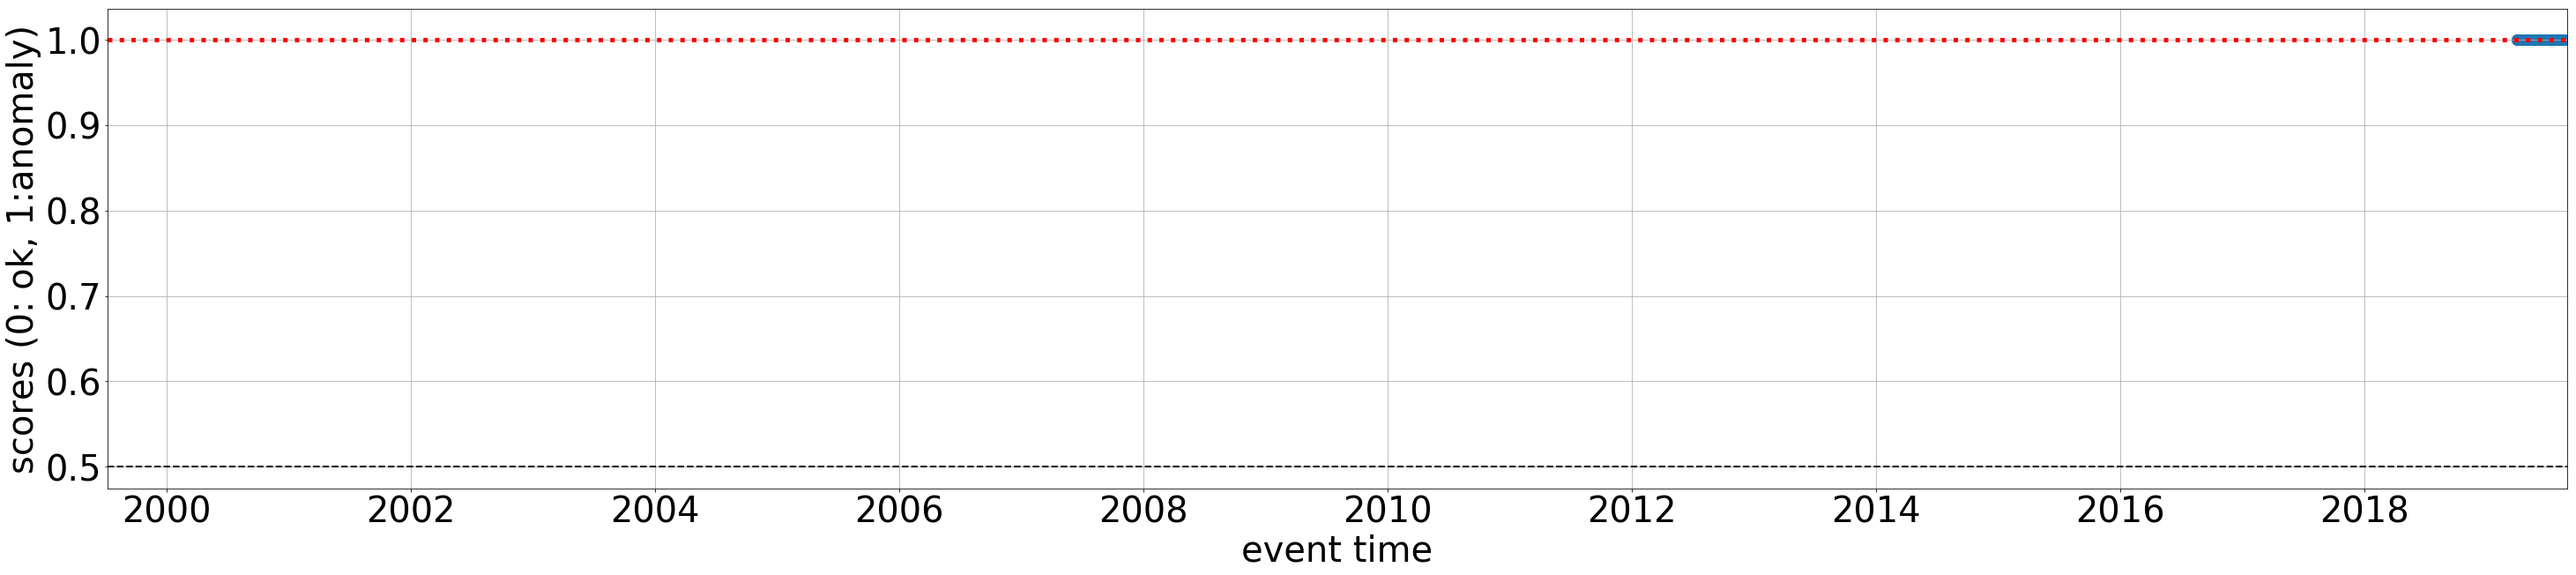

Channel OE.CONA.51.BH? (database: me, station id: 623). 5 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.961[1] 0.957[2]


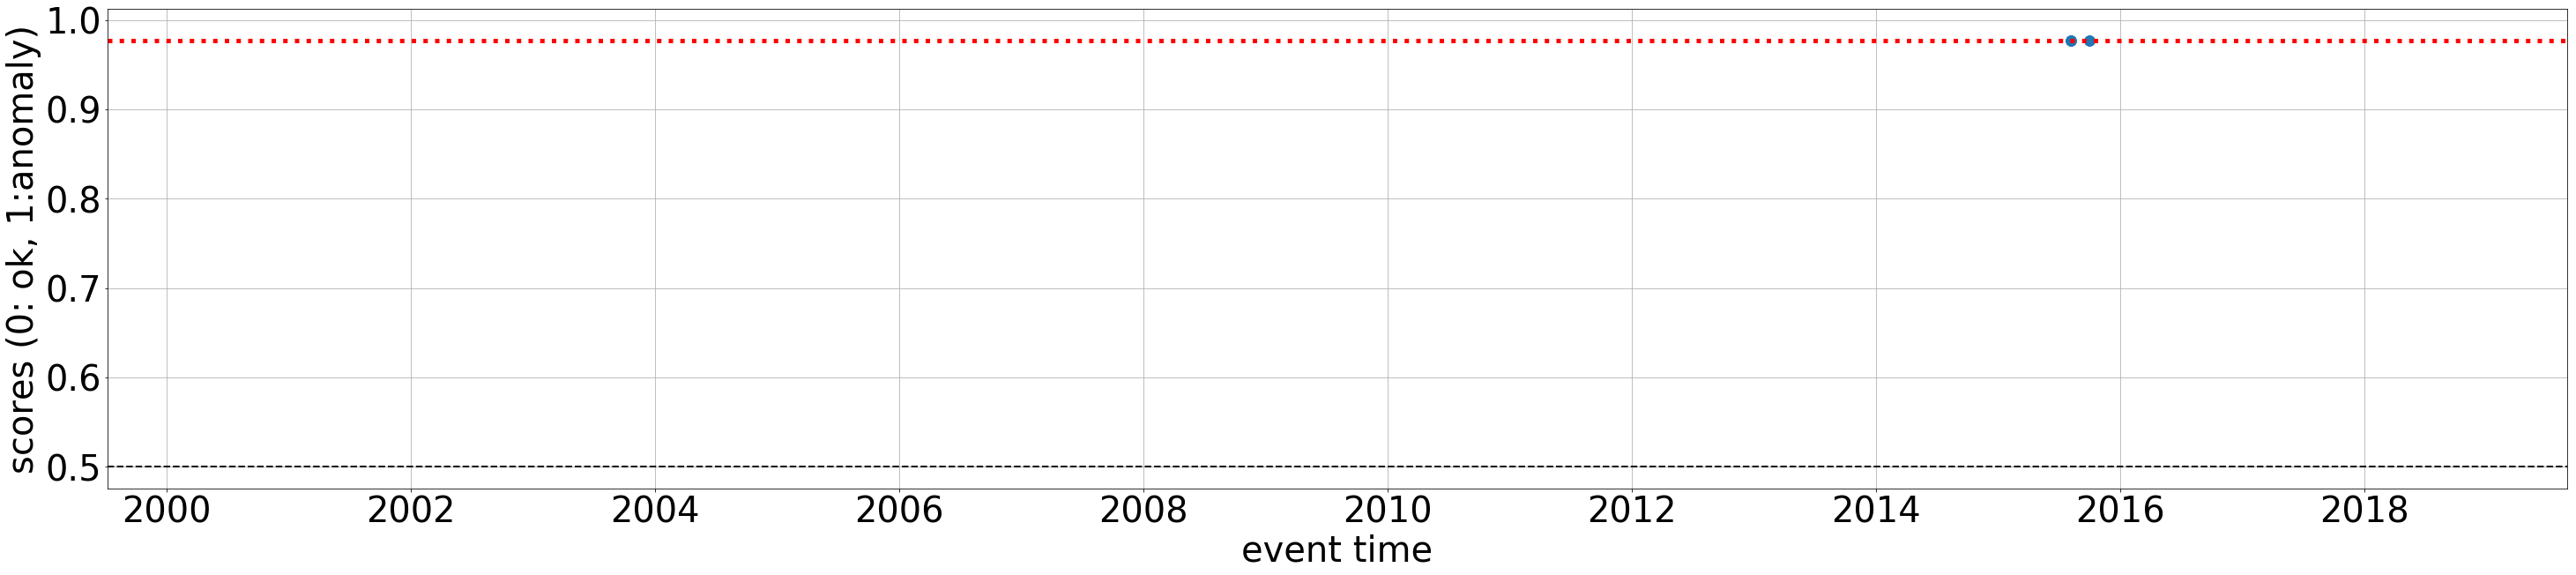

Channel CZ.CHVC..BH? (database: me, station id: 712). 1096 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


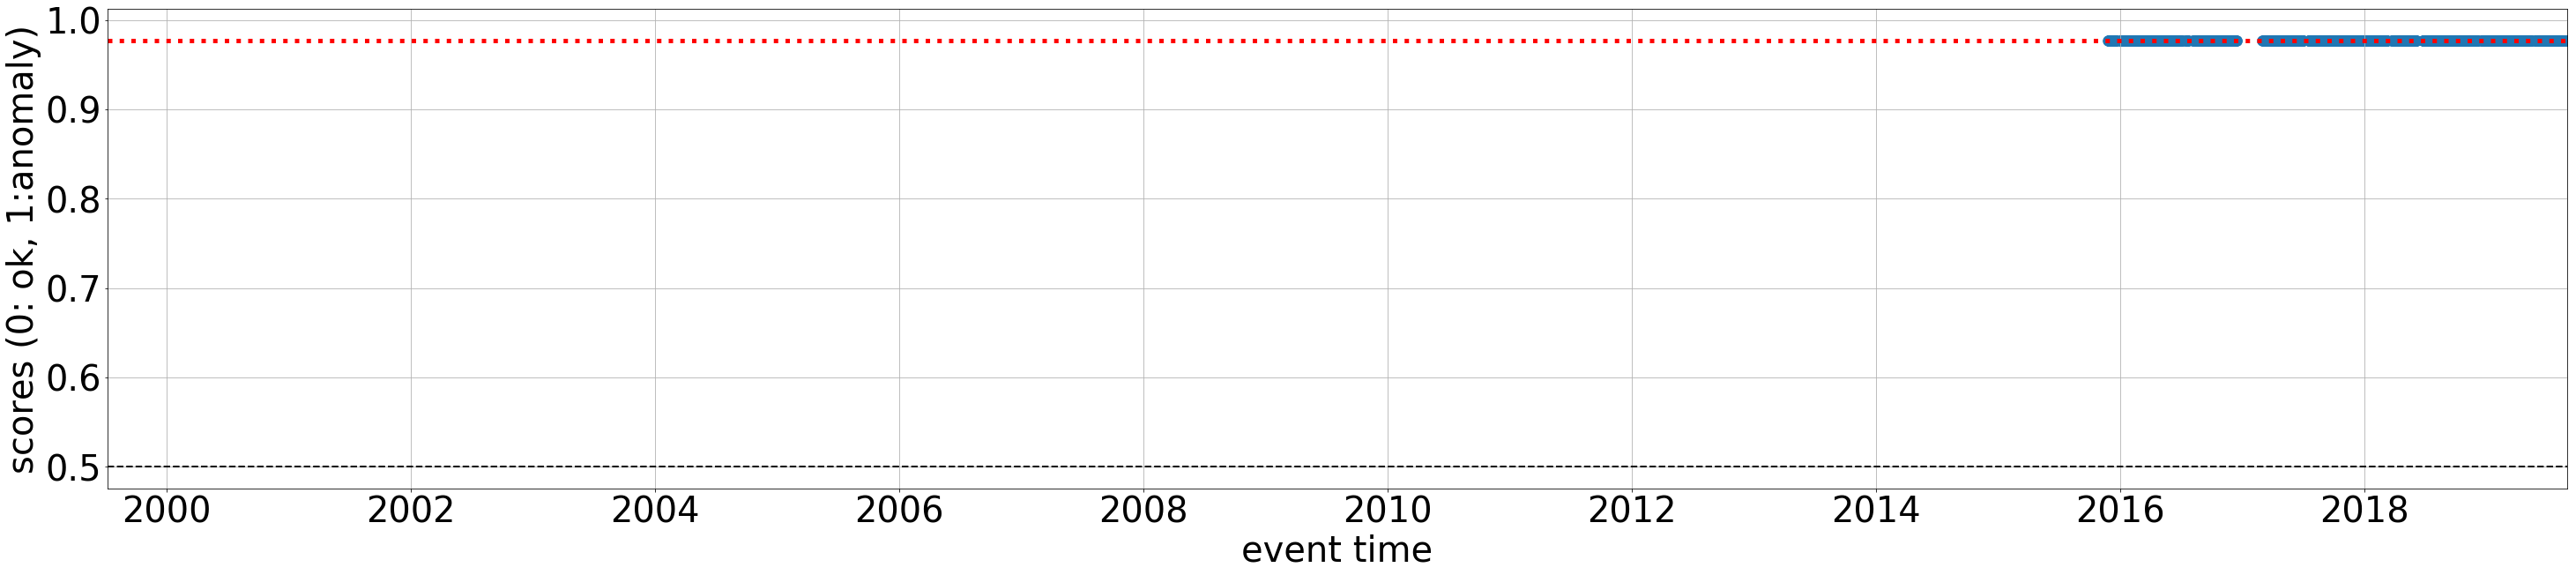

Channel CZ.CKRC..BH? (database: me, station id: 713). 1128 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel CZ.DPC..BH? (database: me, station id: 714). 3338 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


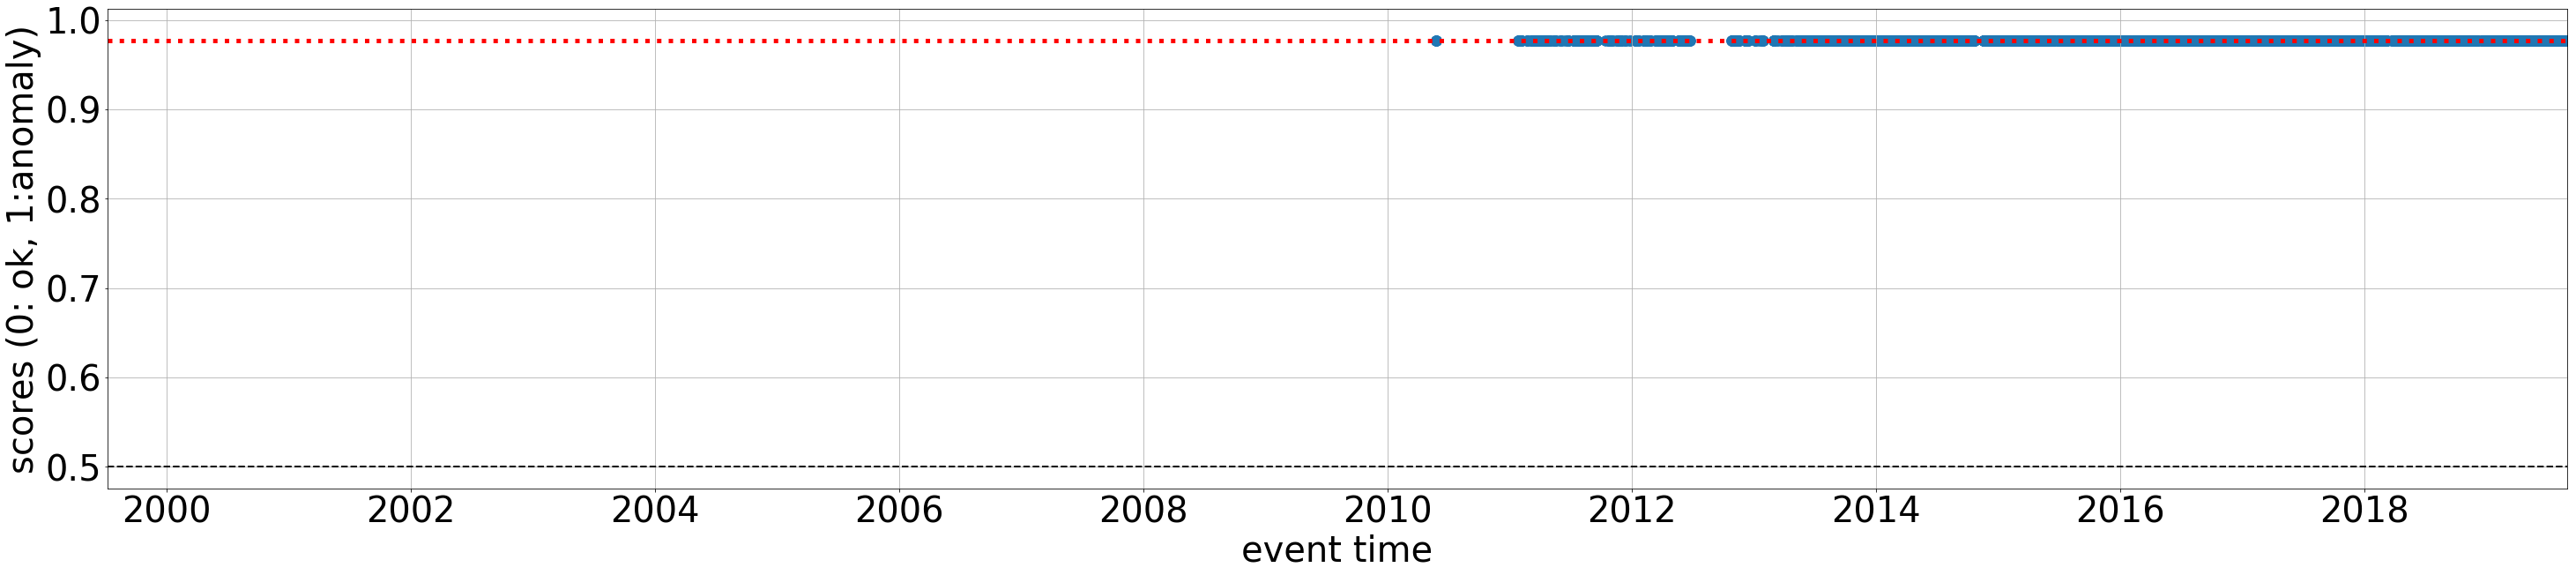

Channel CZ.GOPC..BH? (database: me, station id: 715). 1143 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


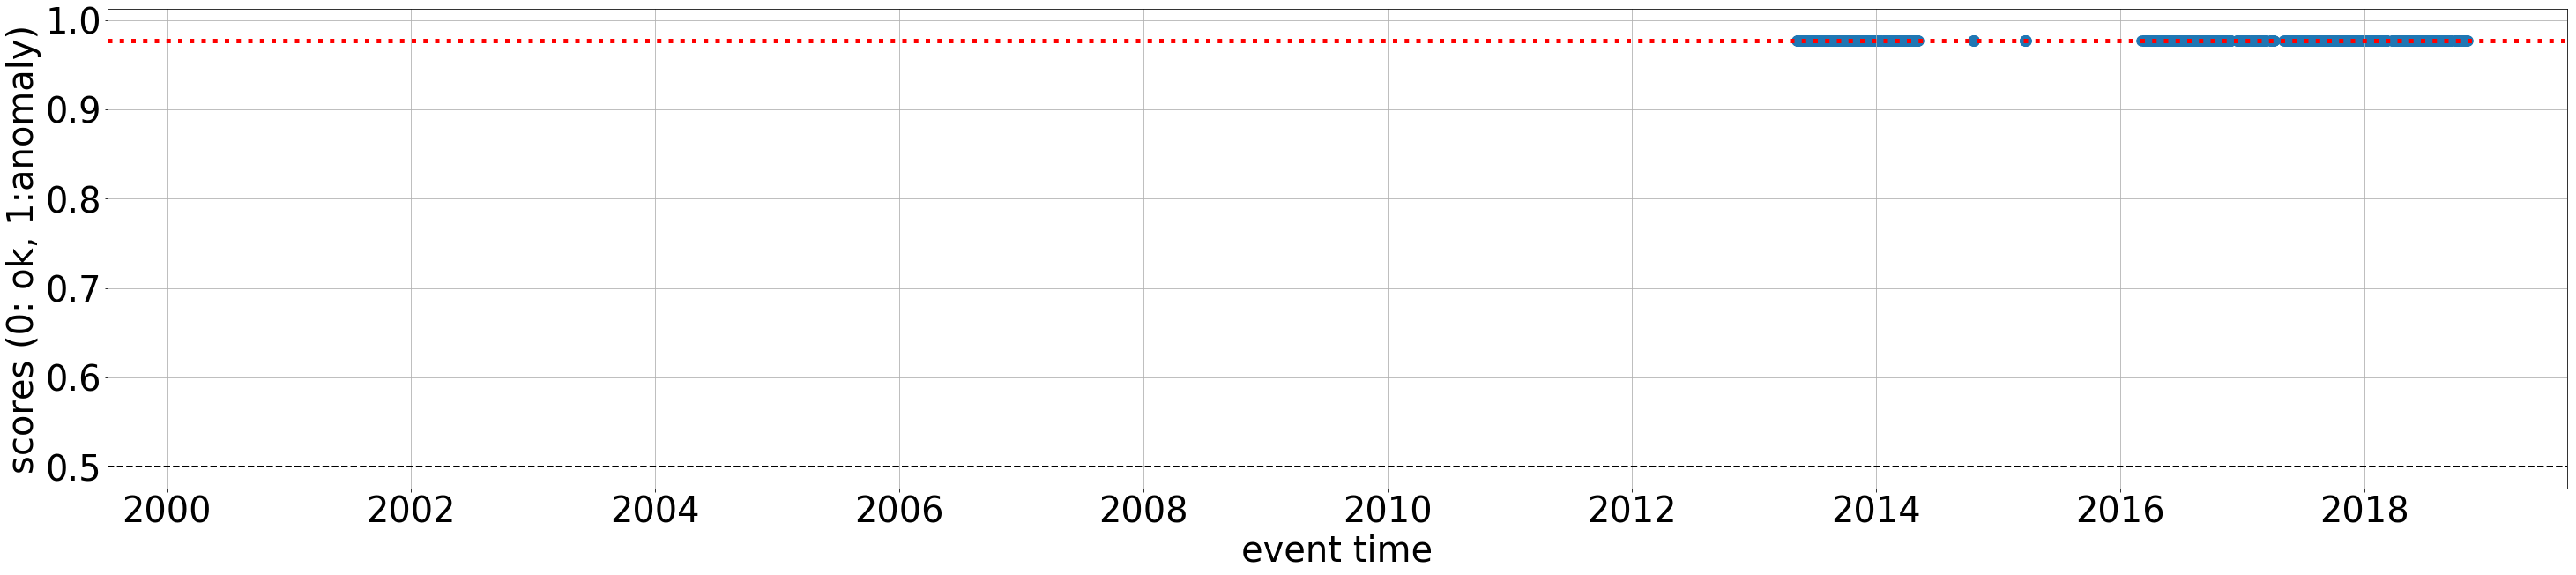

Channel CZ.HSKC..BH? (database: me, station id: 716). 896 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel CZ.KRLC..BH? (database: me, station id: 719). 1880 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


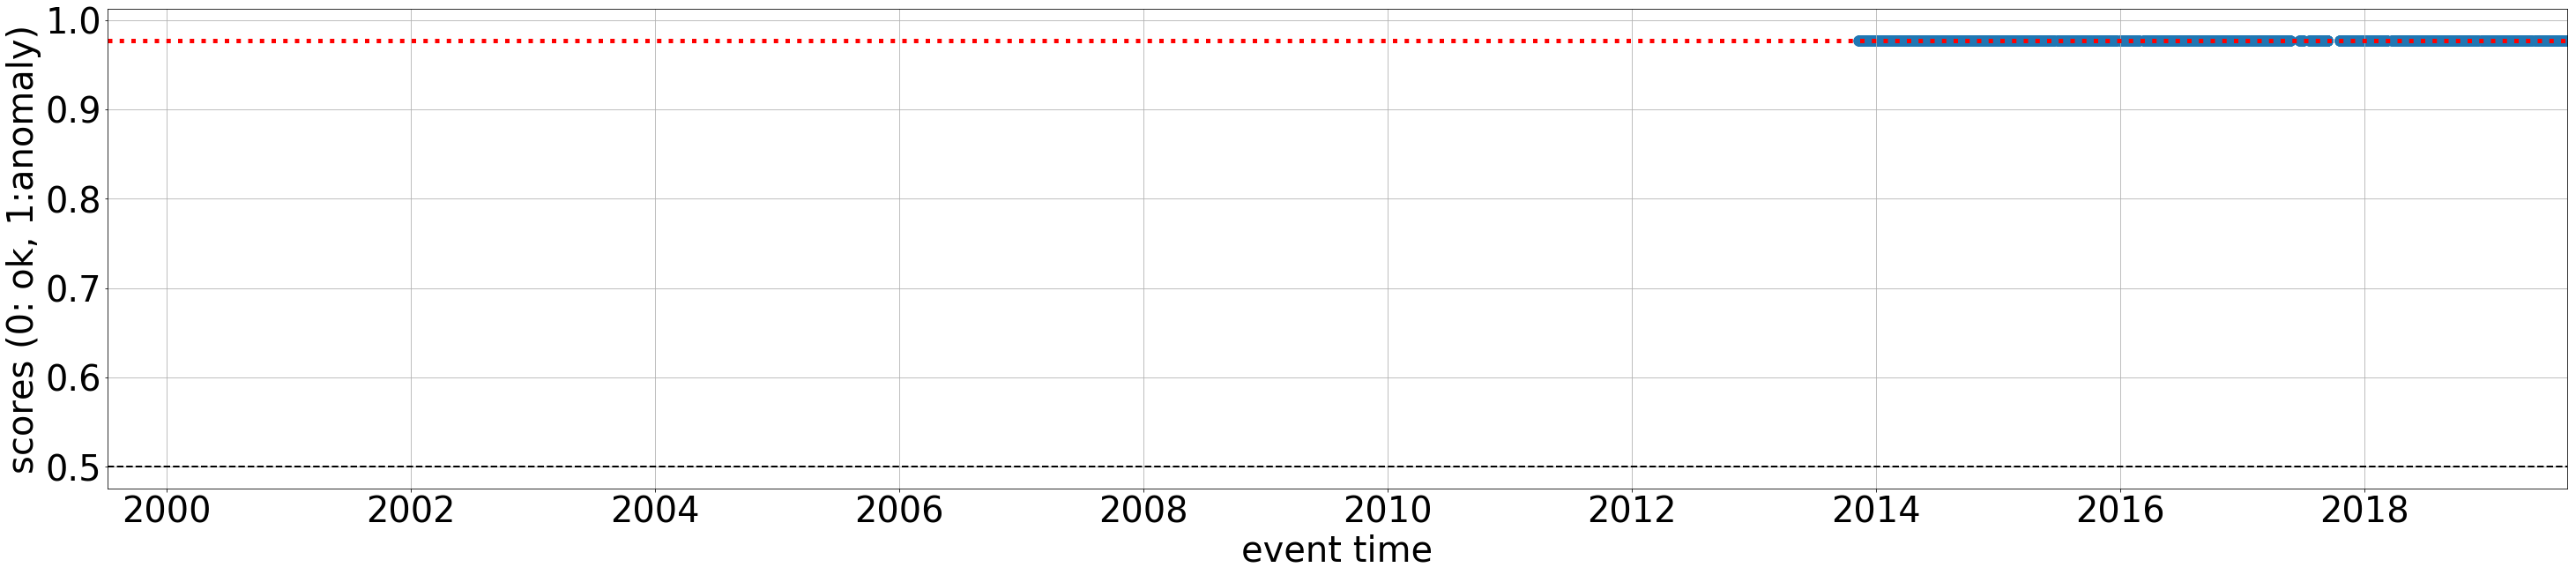

Channel CZ.OSTC..BH? (database: me, station id: 724). 1257 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


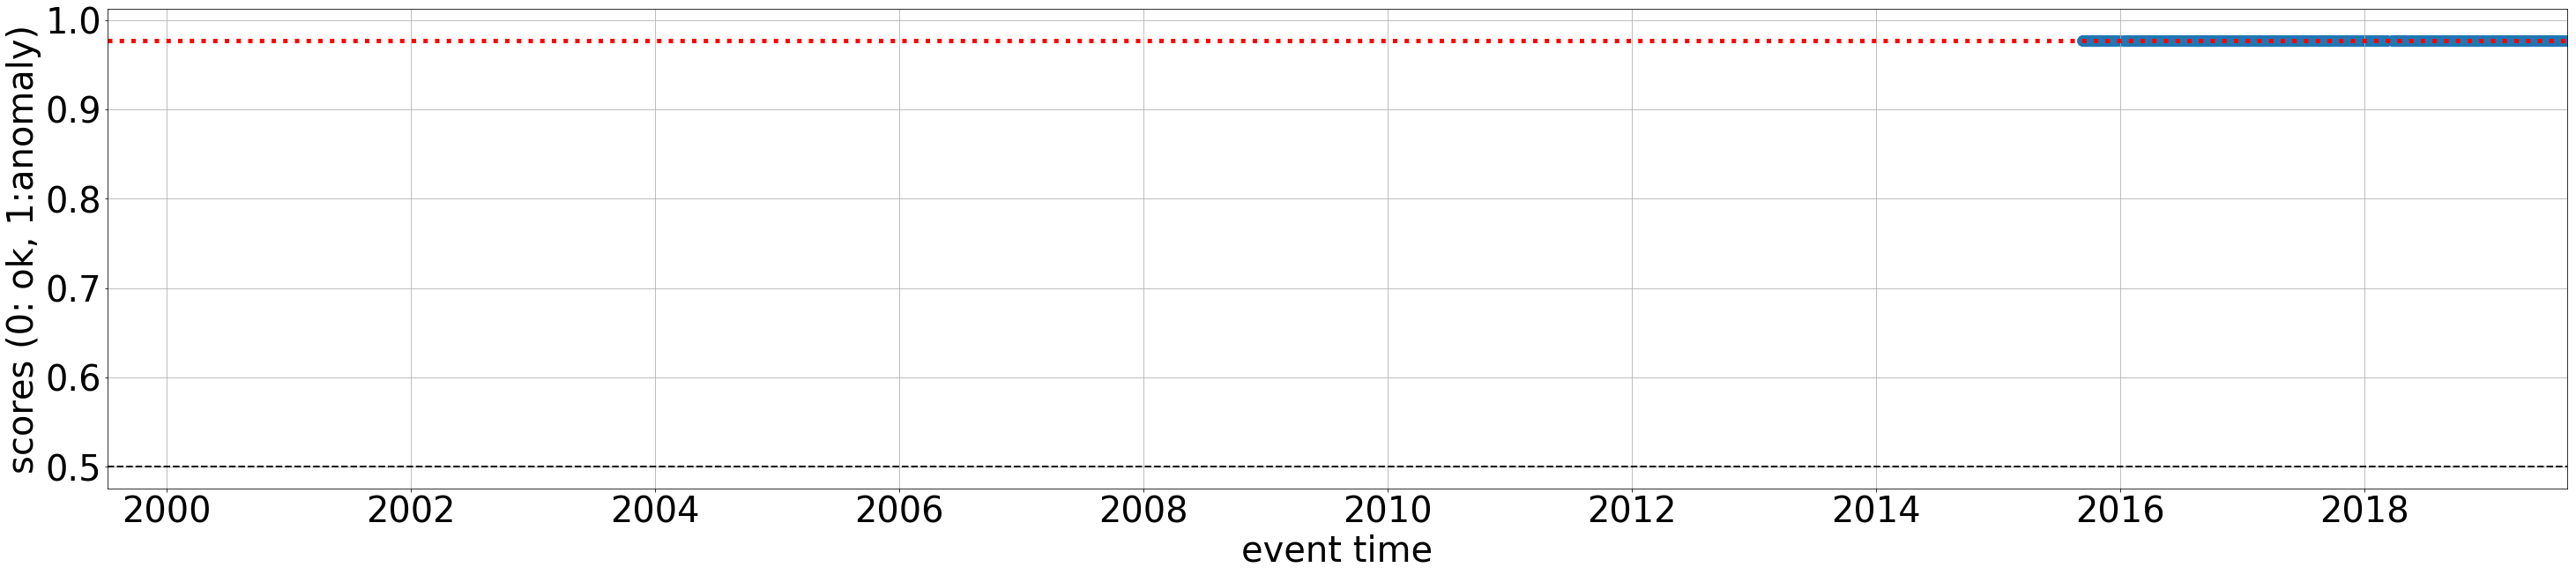

Channel CZ.PBCC..BH? (database: me, station id: 725). 34 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


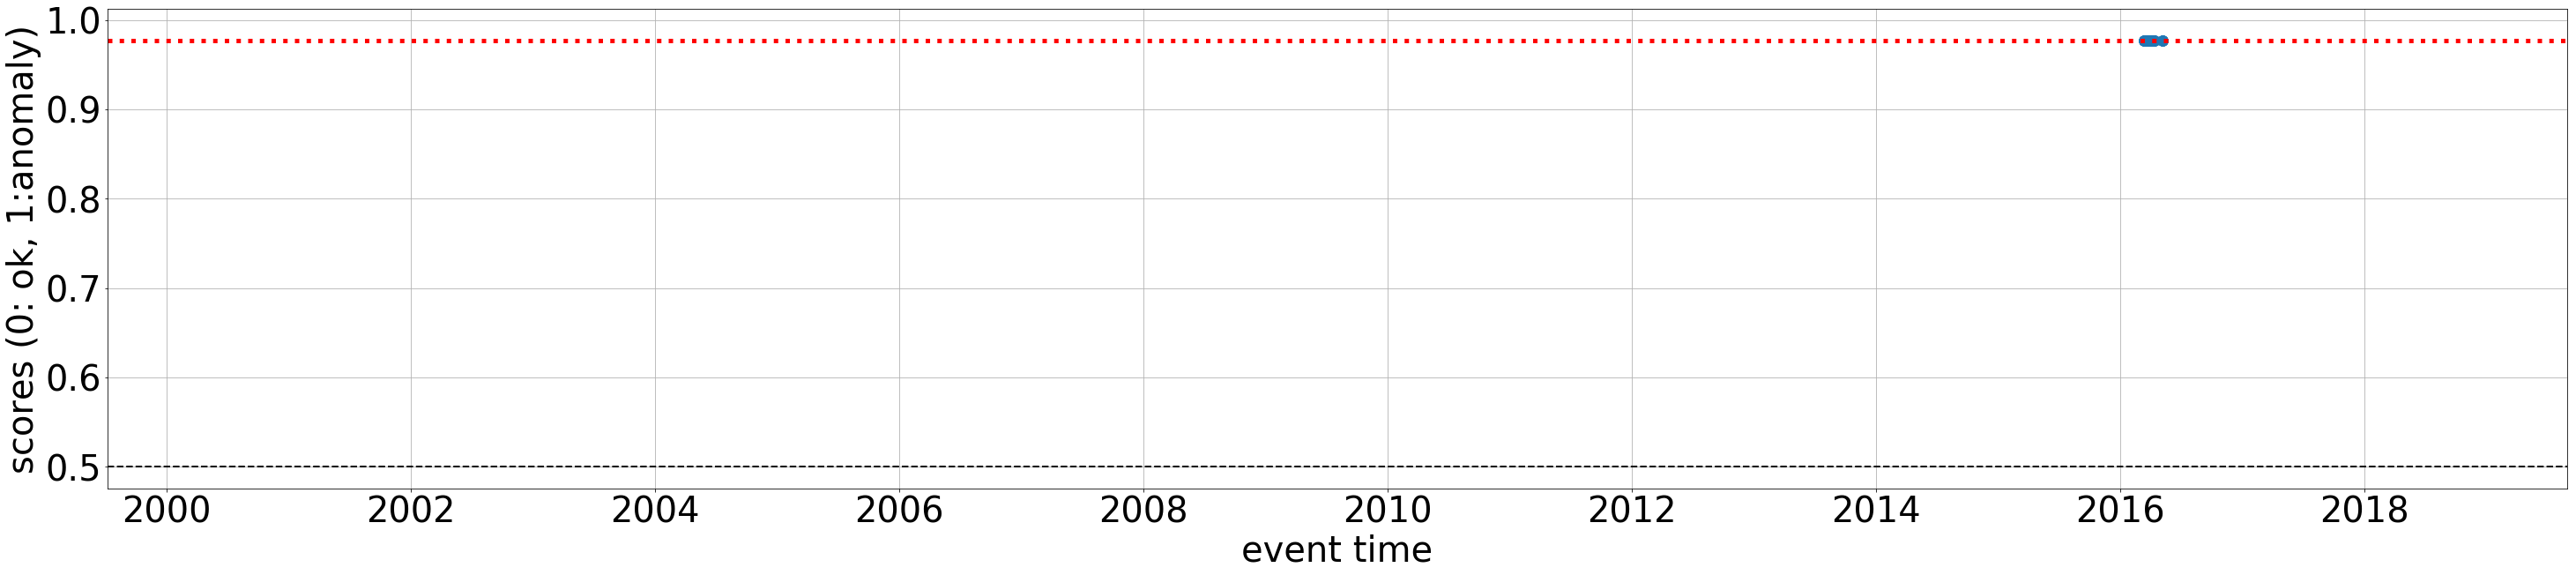

Channel CZ.PRA..BH? (database: me, station id: 726). 1461 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel CZ.UPC..BH? (database: me, station id: 730). 2126 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


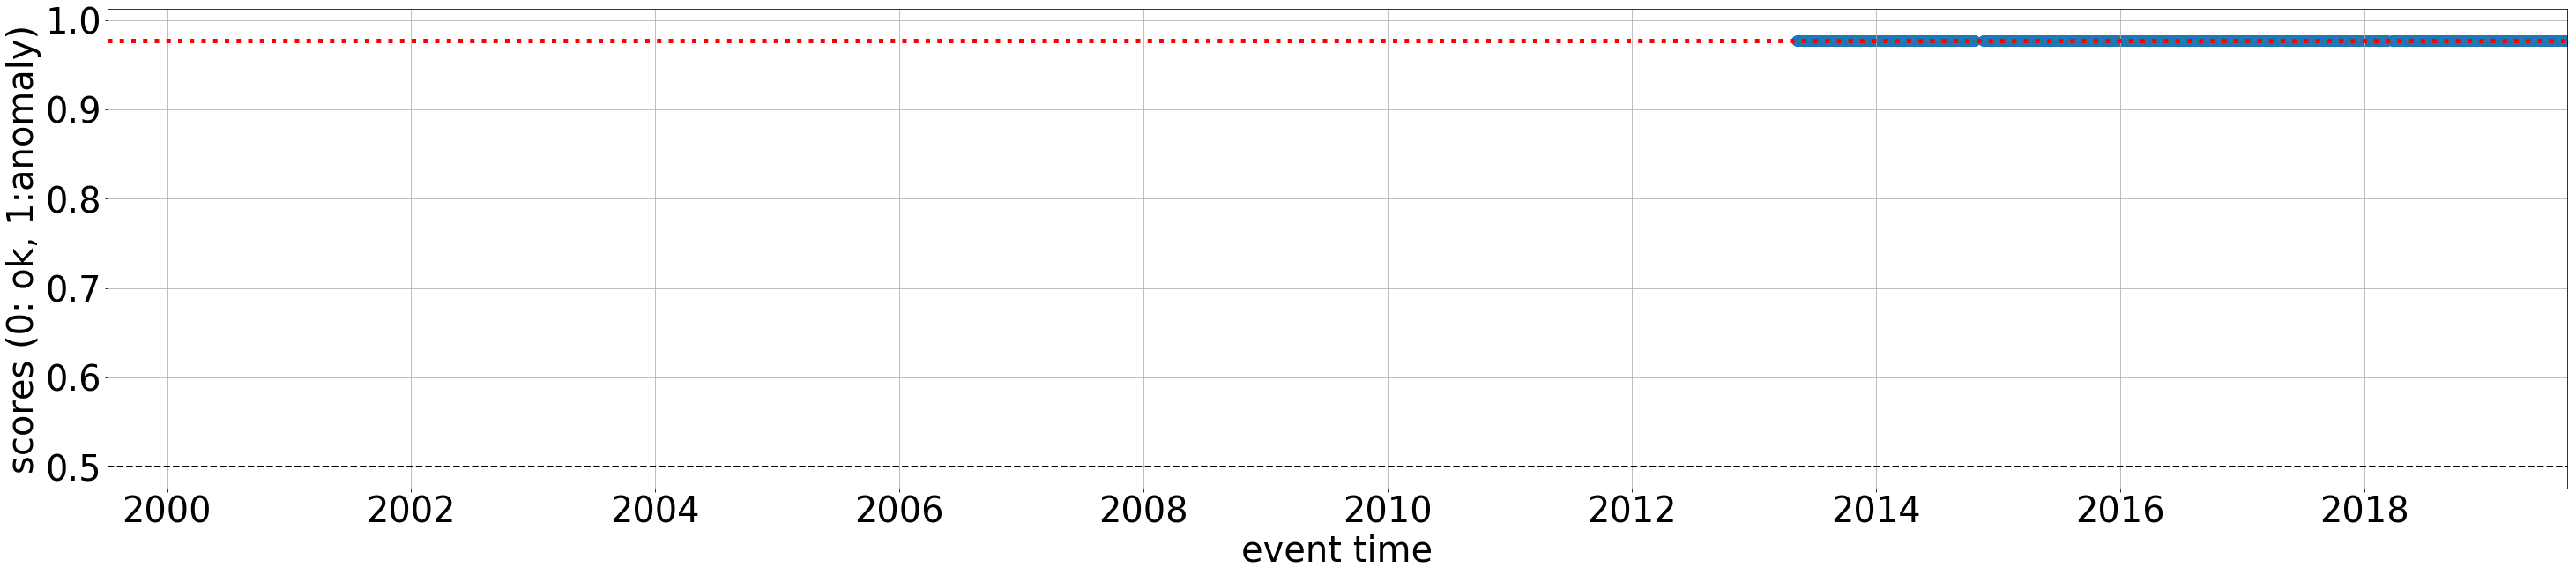

Channel BS.JMB..BH? (database: me, station id: 1096). 756 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.961[1] 0.961[2]


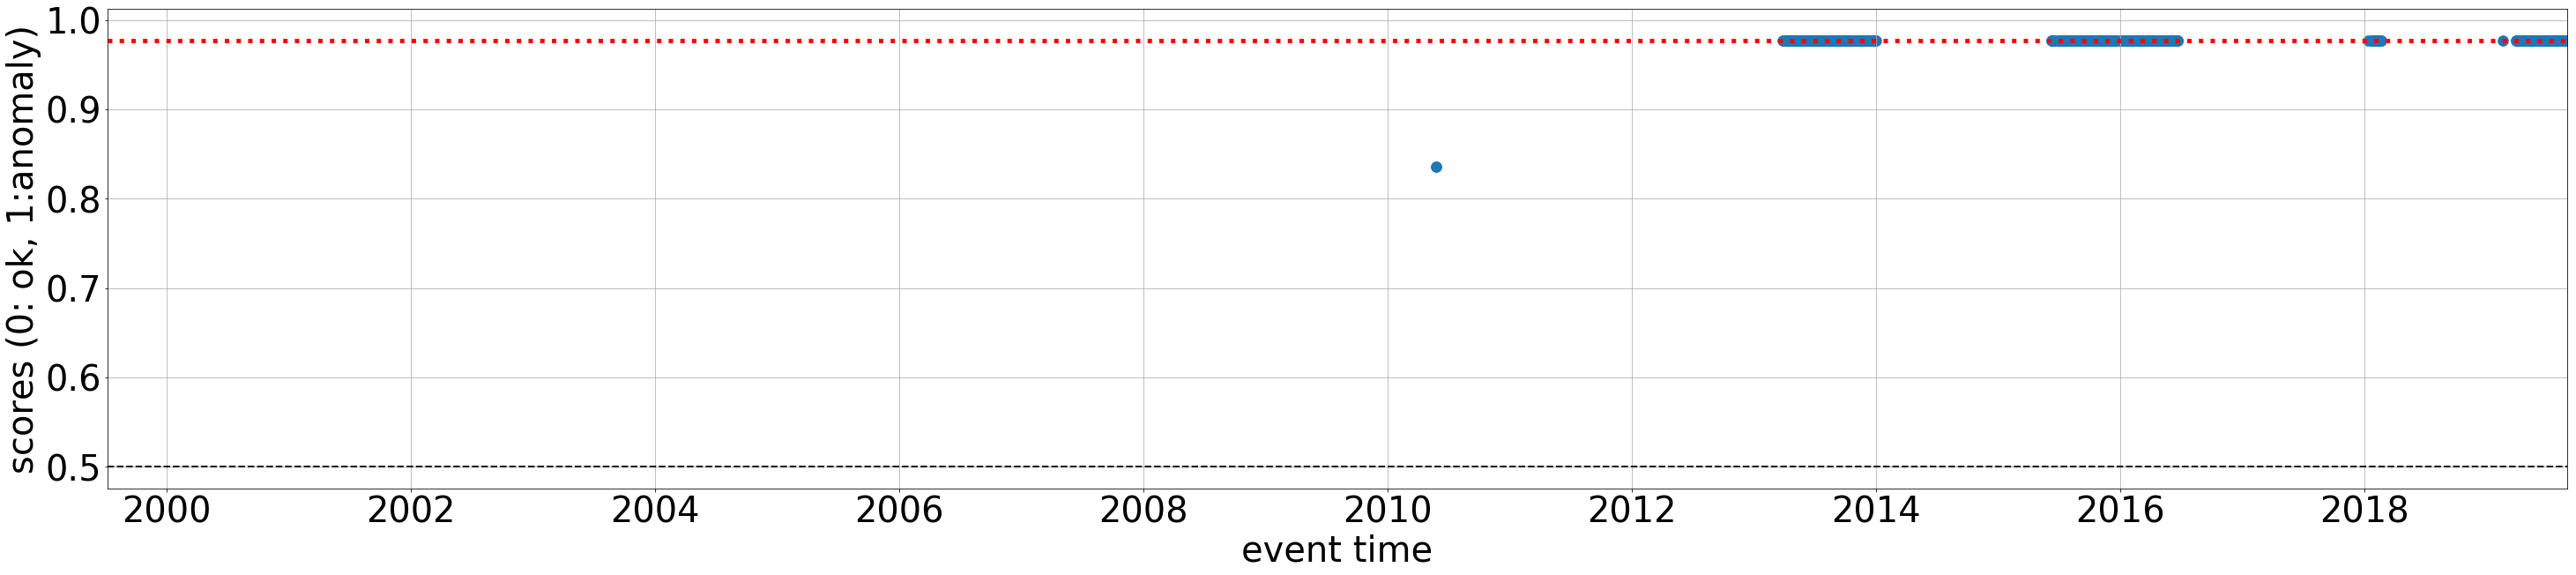

Channel AF.ANKE..BH? (database: me, station id: 1414). 427 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel AF.DODT..BH? (database: me, station id: 1422). 335 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


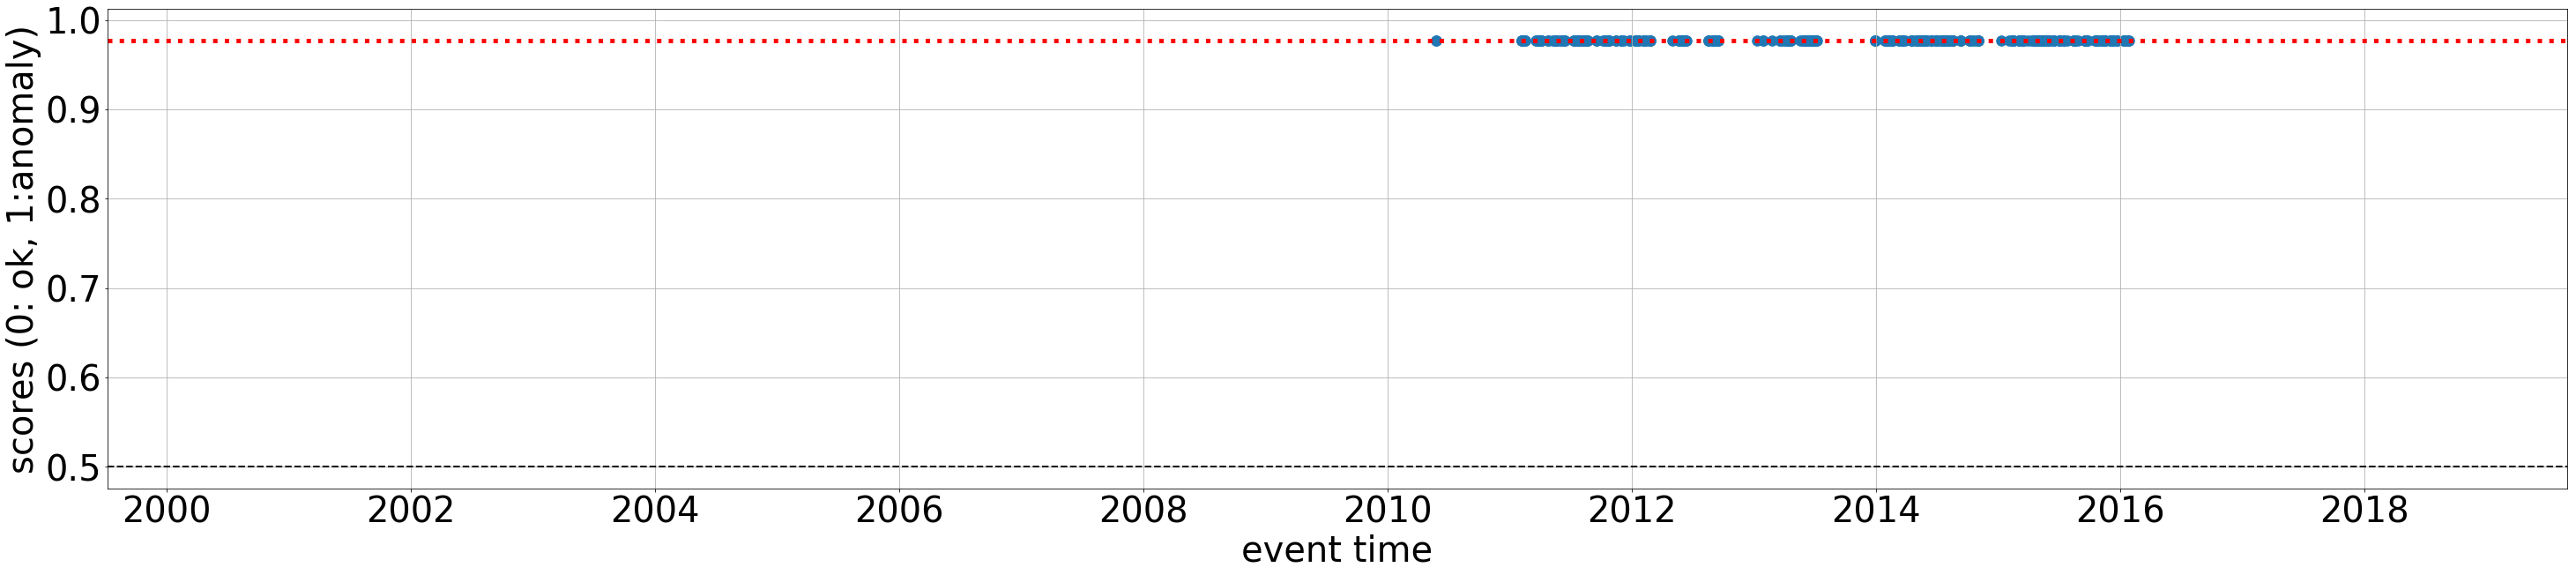

Channel AF.EKNA..BH? (database: me, station id: 1423). 369 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.963[1] 0.986[2]


Channel AF.KTWE..BH? (database: me, station id: 1430). 119 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 0.993[2]


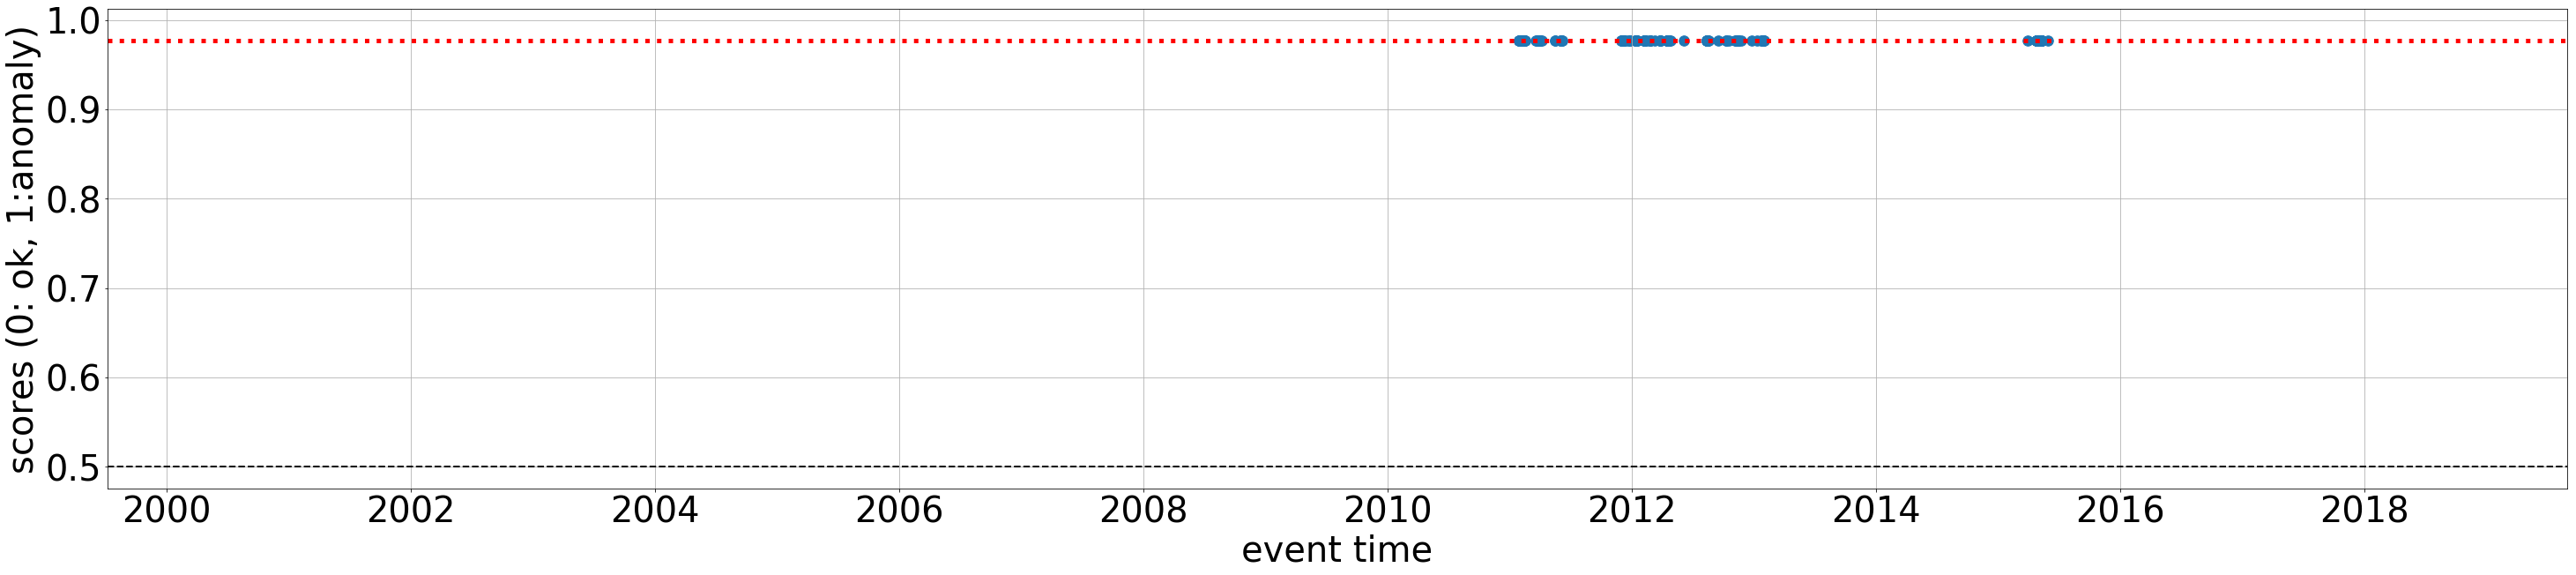

Channel AF.KUKU..BH? (database: me, station id: 1431). 235 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel AF.LBB..BH? (database: me, station id: 1432). 148 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


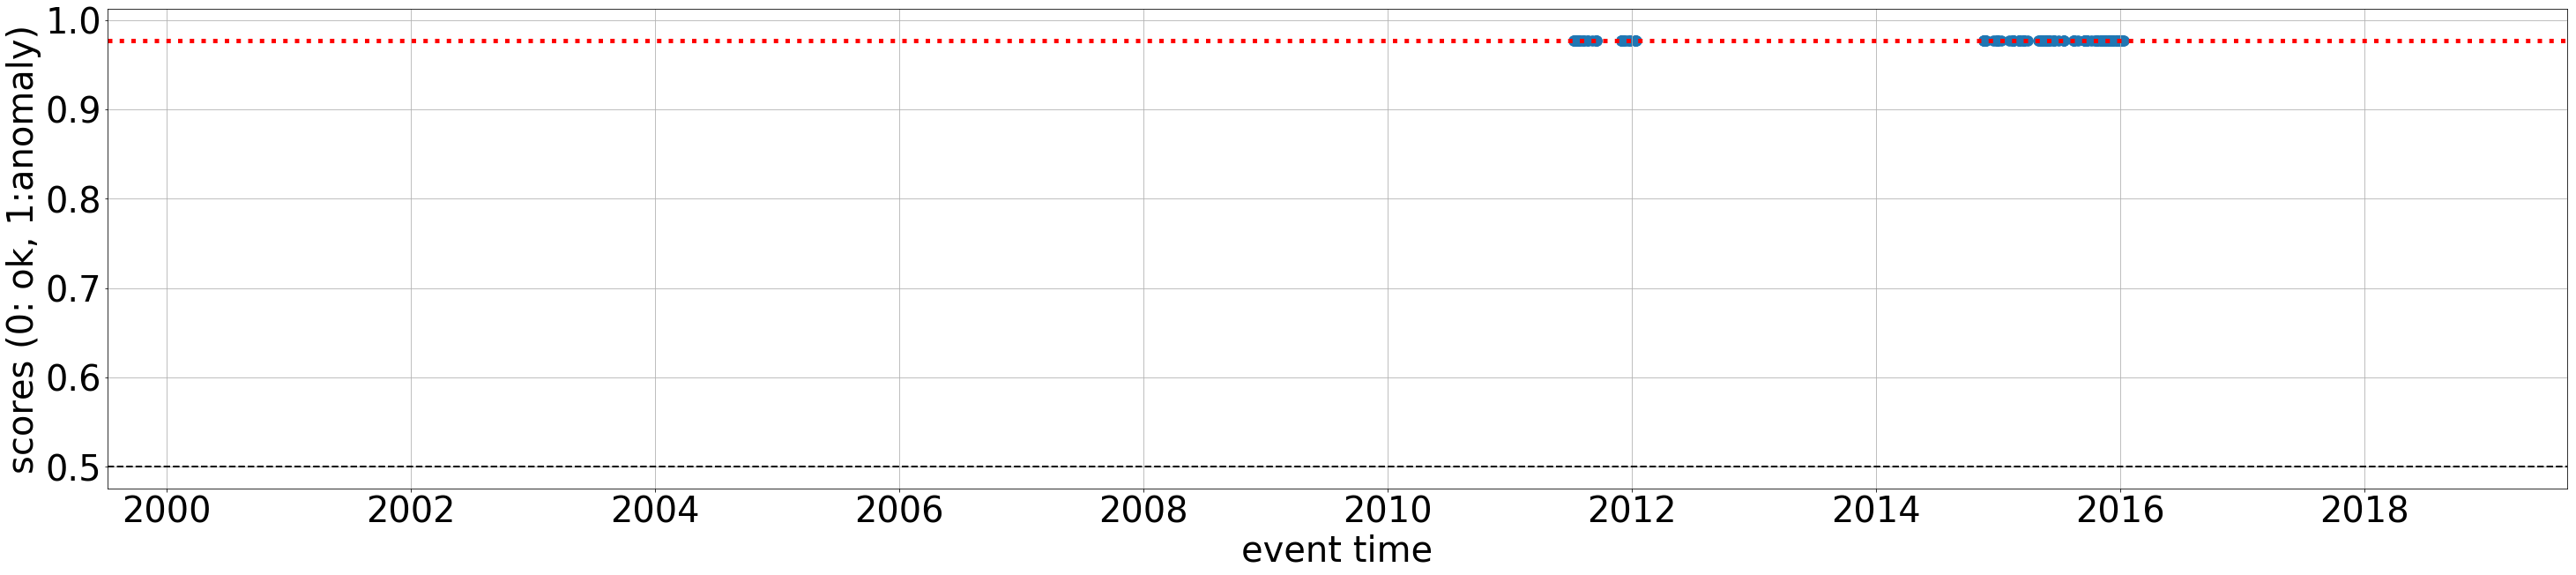

Channel AF.MBEY..BH? (database: me, station id: 1433). 243 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


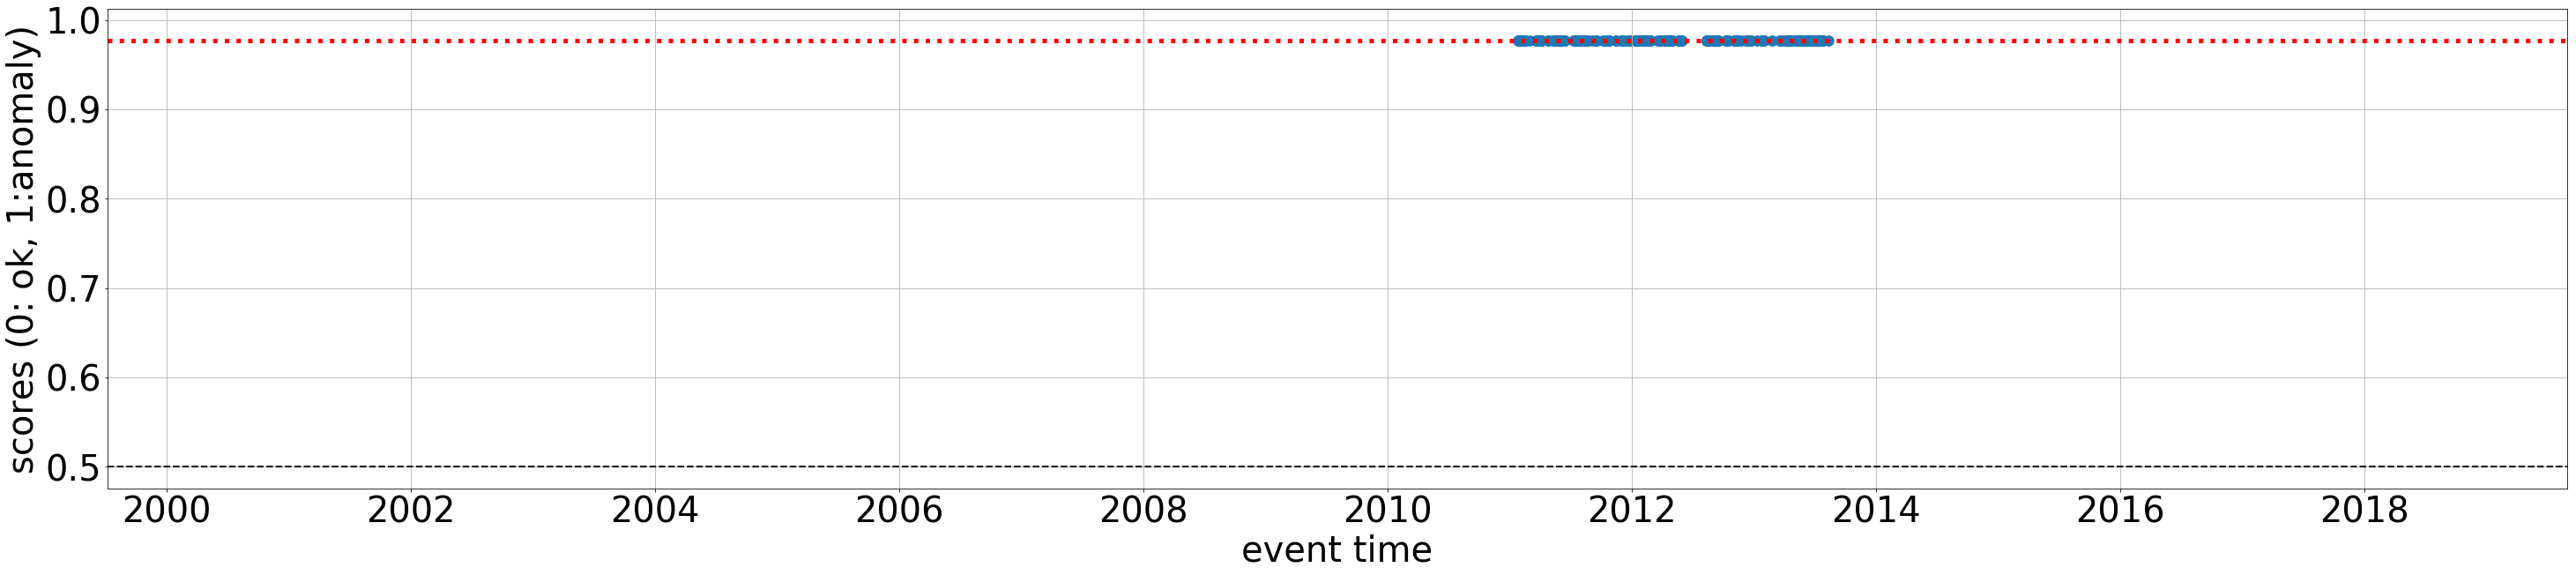

Channel AF.SHAI..BH? (database: me, station id: 1443). 77 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel AF.TEBE..BH? (database: me, station id: 1449). 710 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel AF.TEZI..BH? (database: me, station id: 1451). 113 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 0.993[2]


Channel AF.WIN..BH? (database: me, station id: 1453). 309 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel AF.YNDE..BH? (database: me, station id: 1454). 145 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


Channel JP.JEW..BH? (database: me, station id: 2717). 1383 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


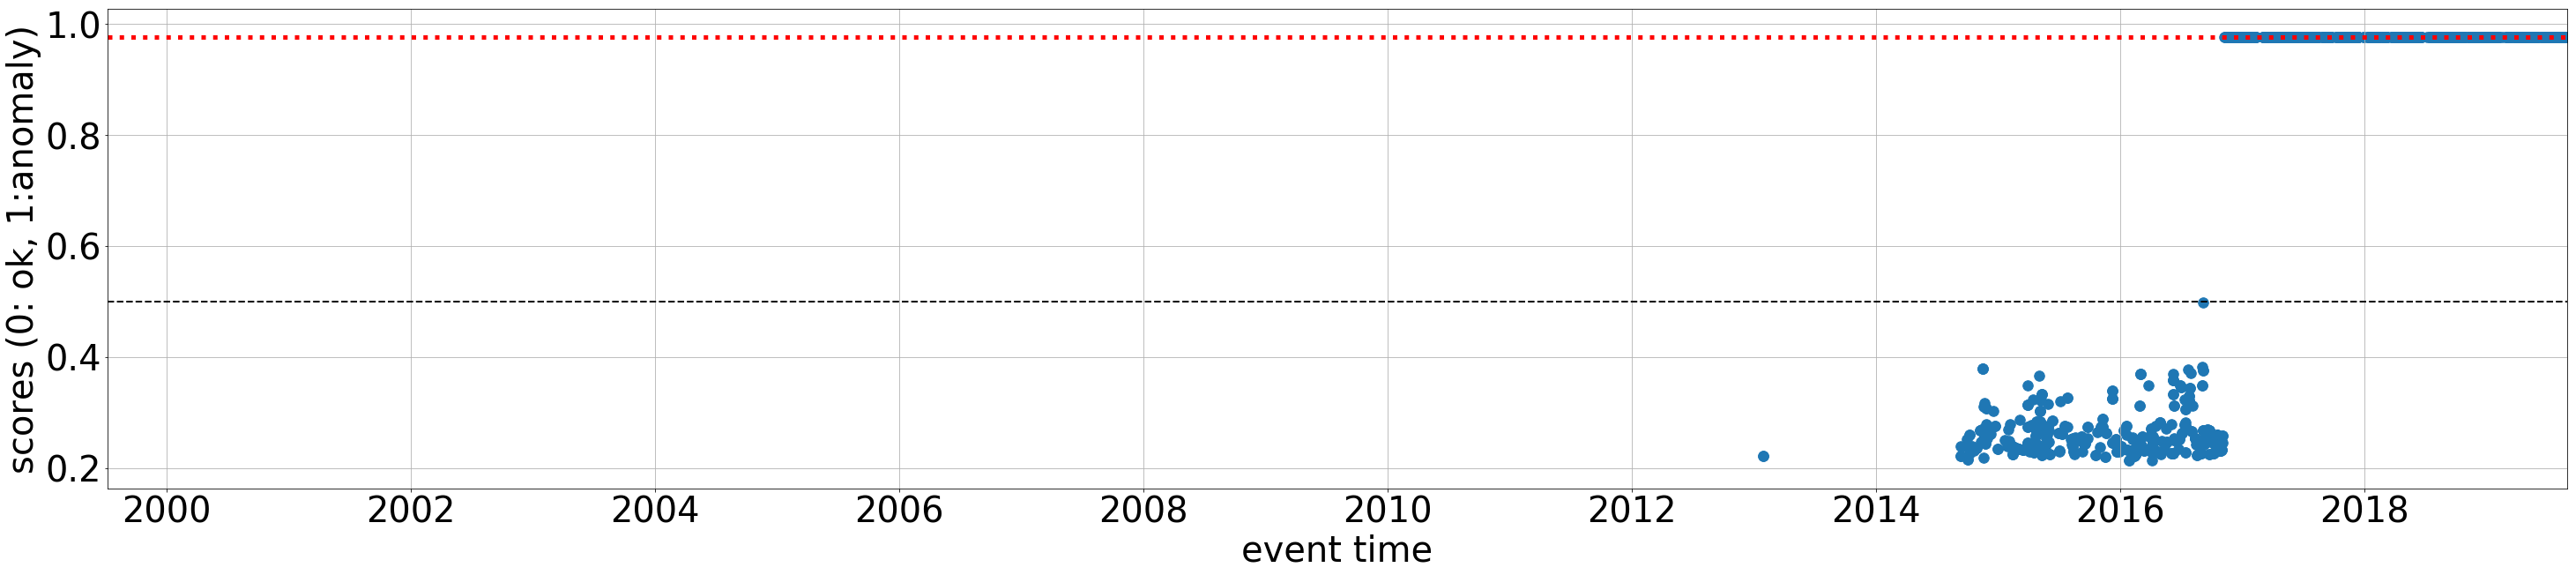

Channel JP.JYT..BH? (database: me, station id: 2733). 1569 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.970[1] 1.000[2]


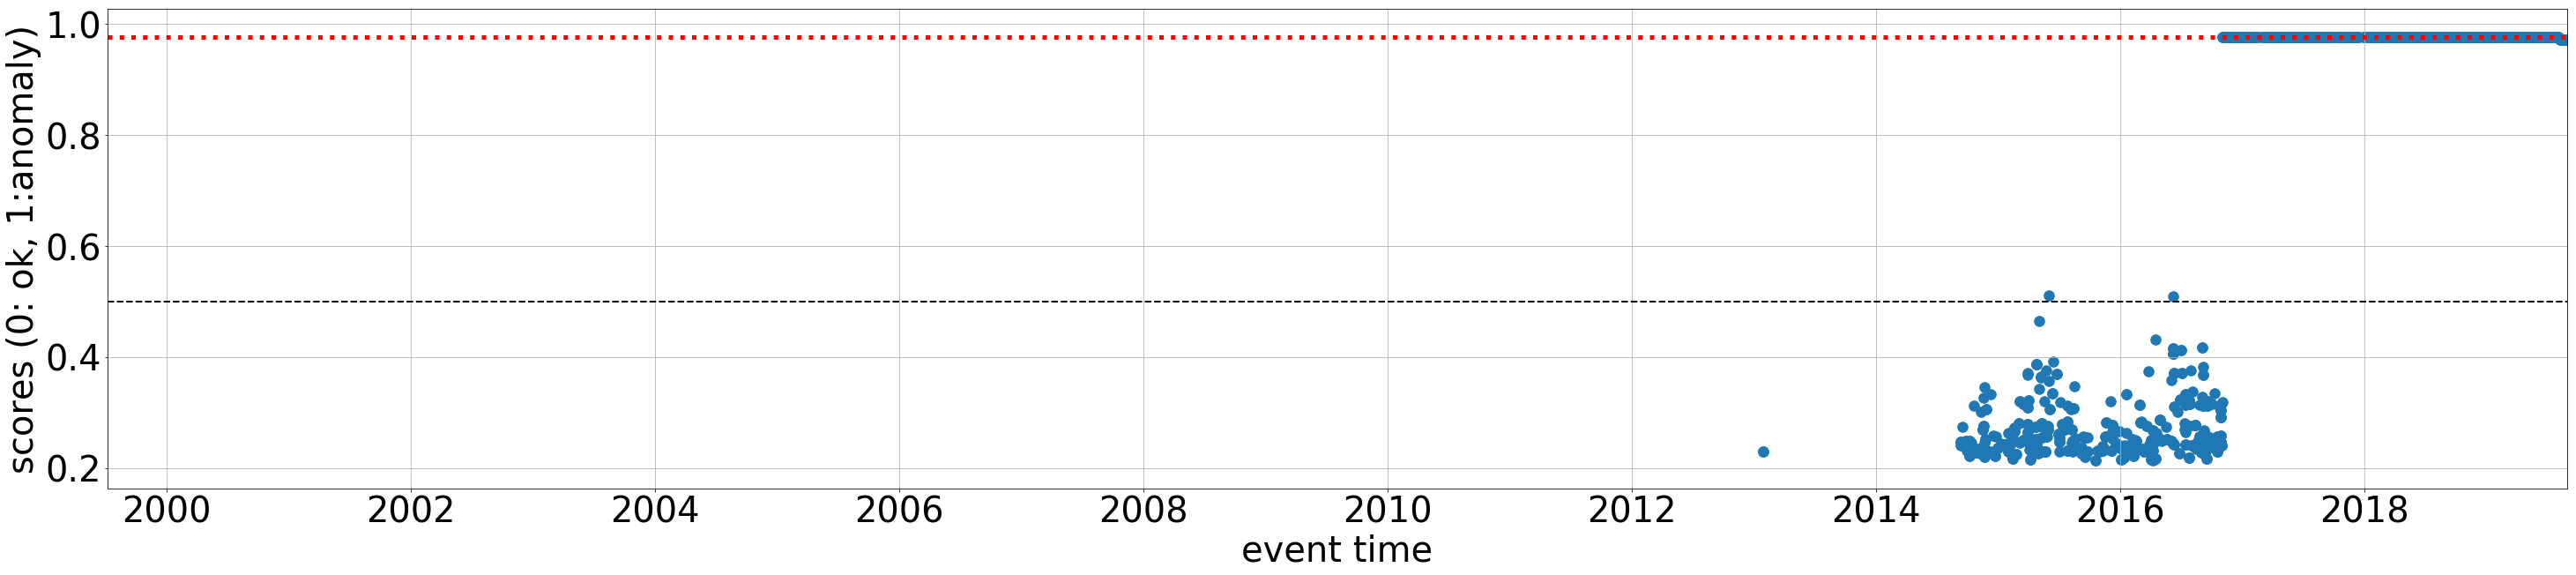

Channel DK.COP.10.BH? (database: me, station id: 3701). 15 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.977[0] 0.962[1] 0.973[2]


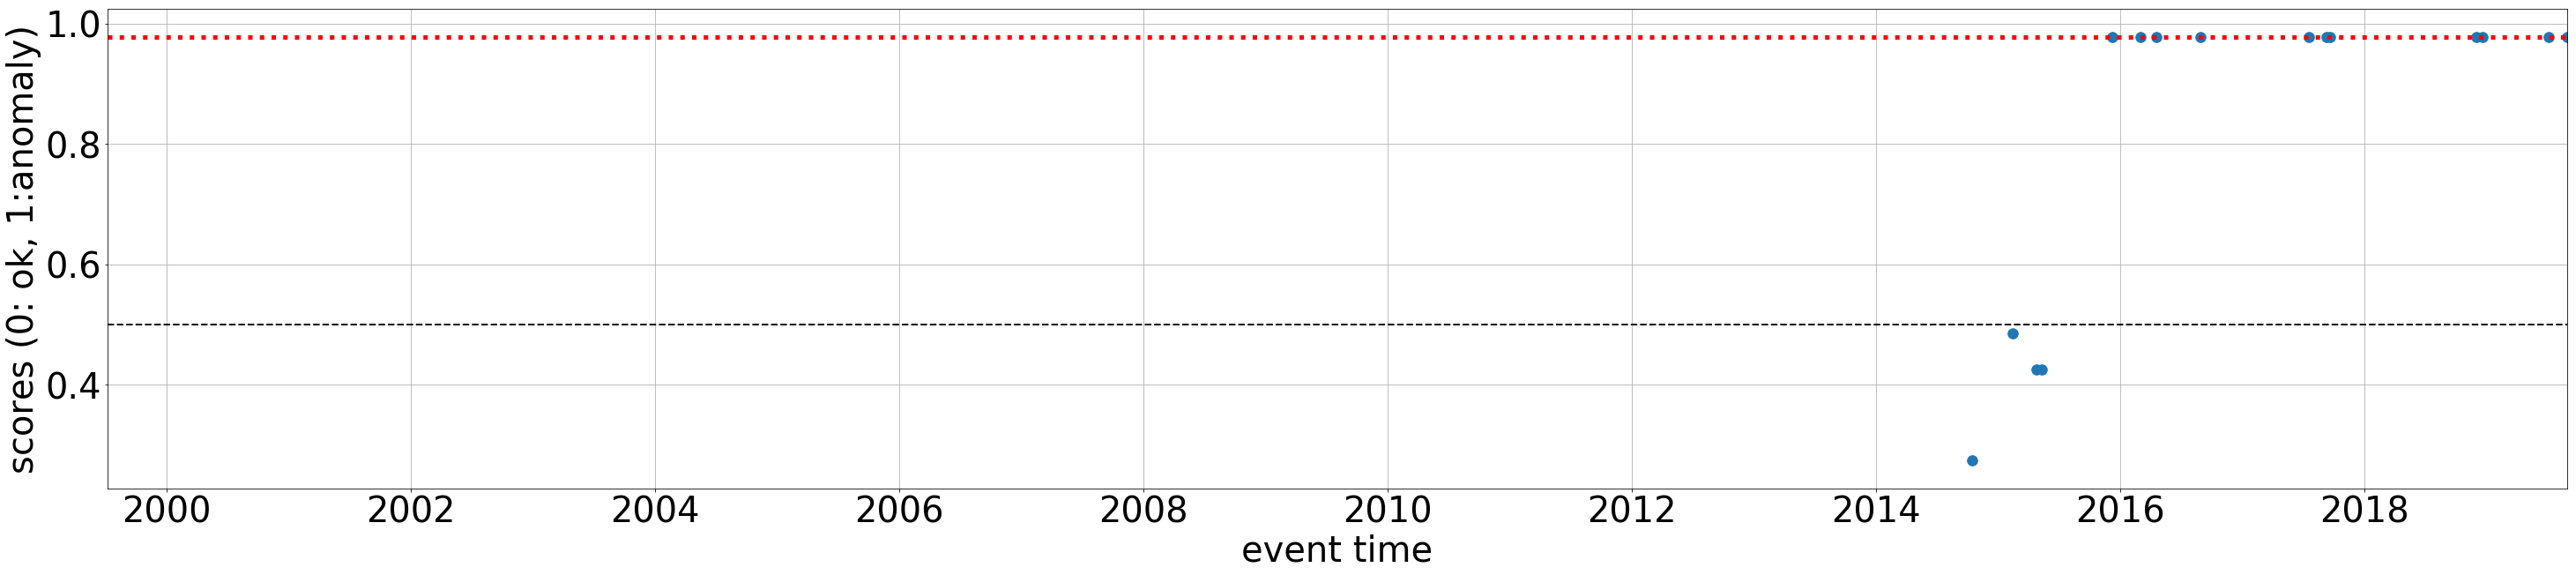

Channel NU.MGAN..BH? (database: me, station id: 1061). 1869 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.974[0] 0.952[1] 0.935[2]


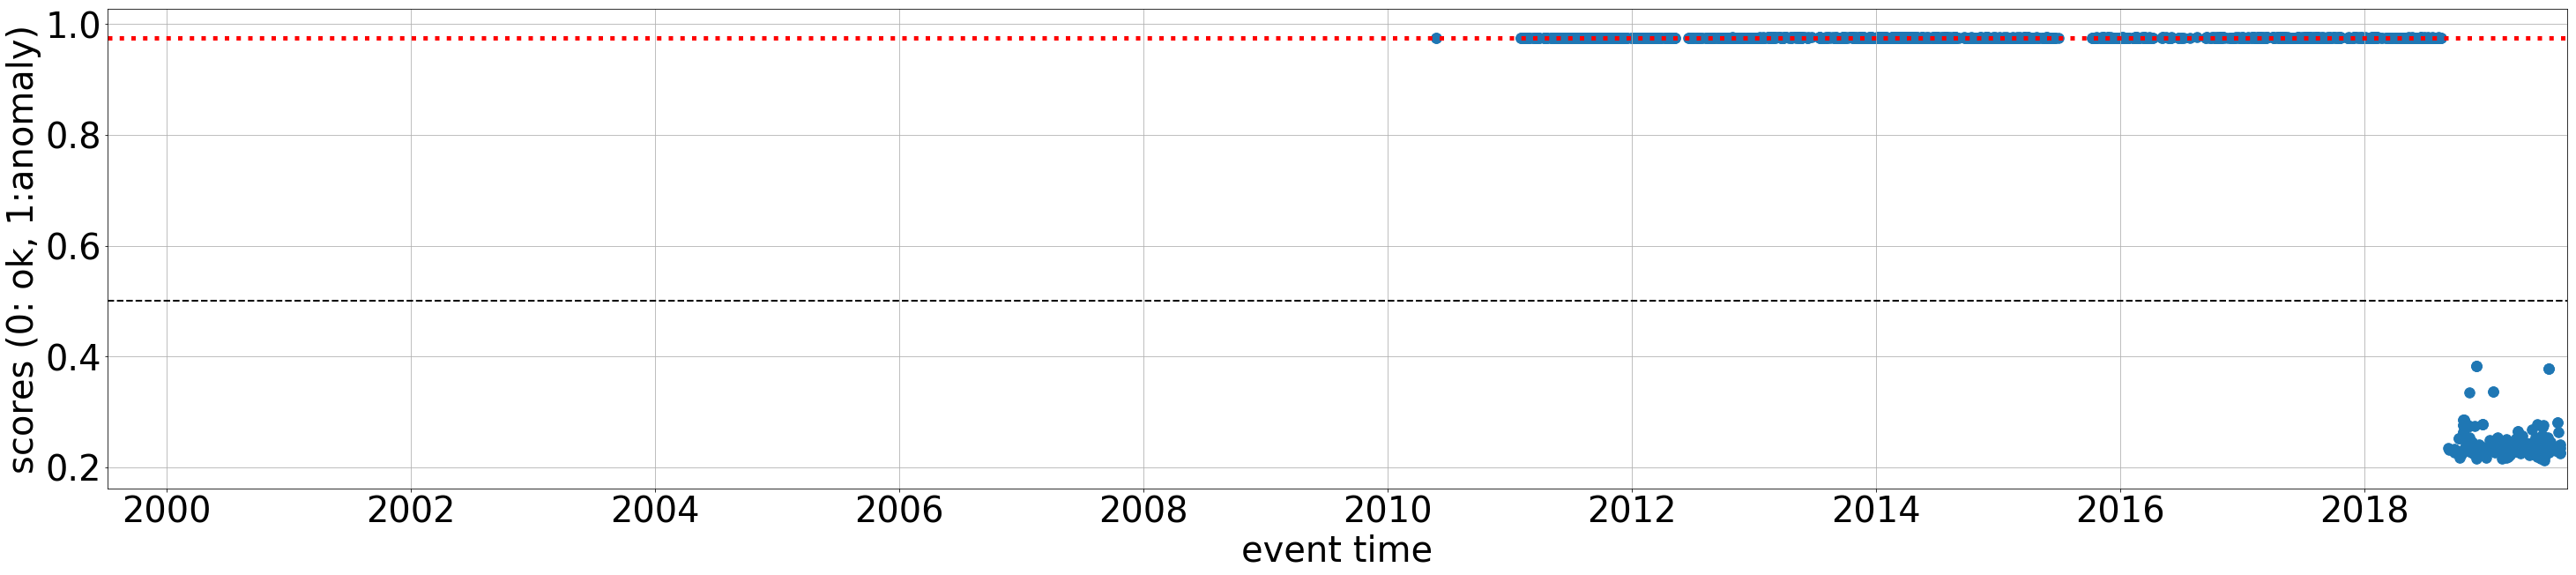

Channel MS.UBIN..BH? (database: me, station id: 2904). 14 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.974[0] 0.949[1] 0.922[2]


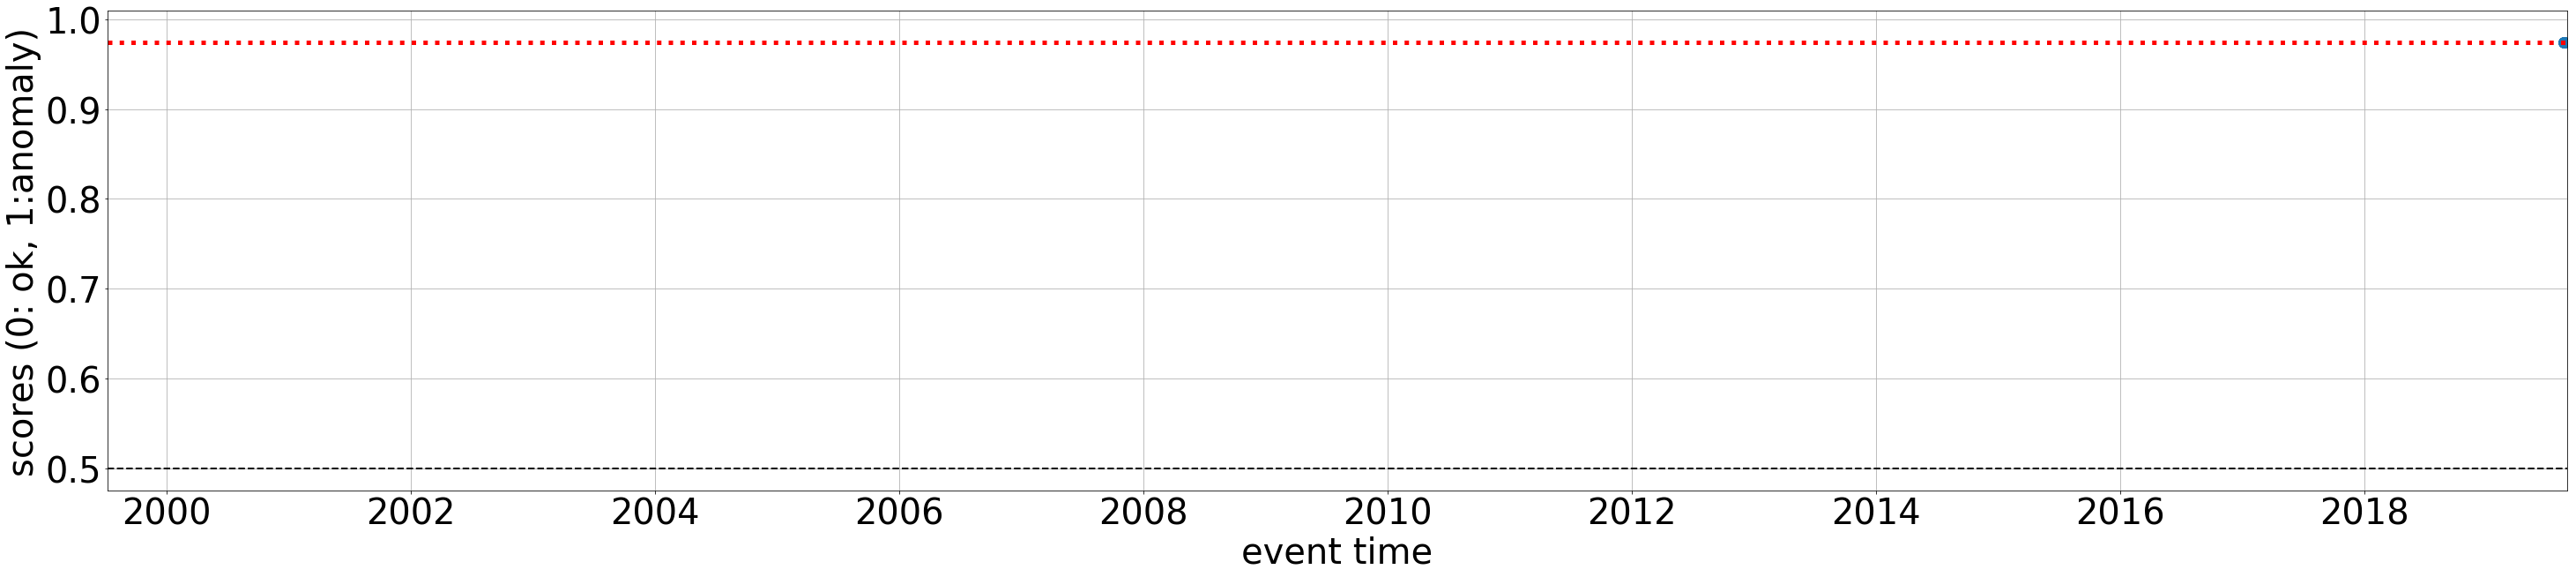

Channel NU.MGAN..BH? (database: me, station id: 2990). 1069 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.974[0] 0.952[1] 0.936[2]


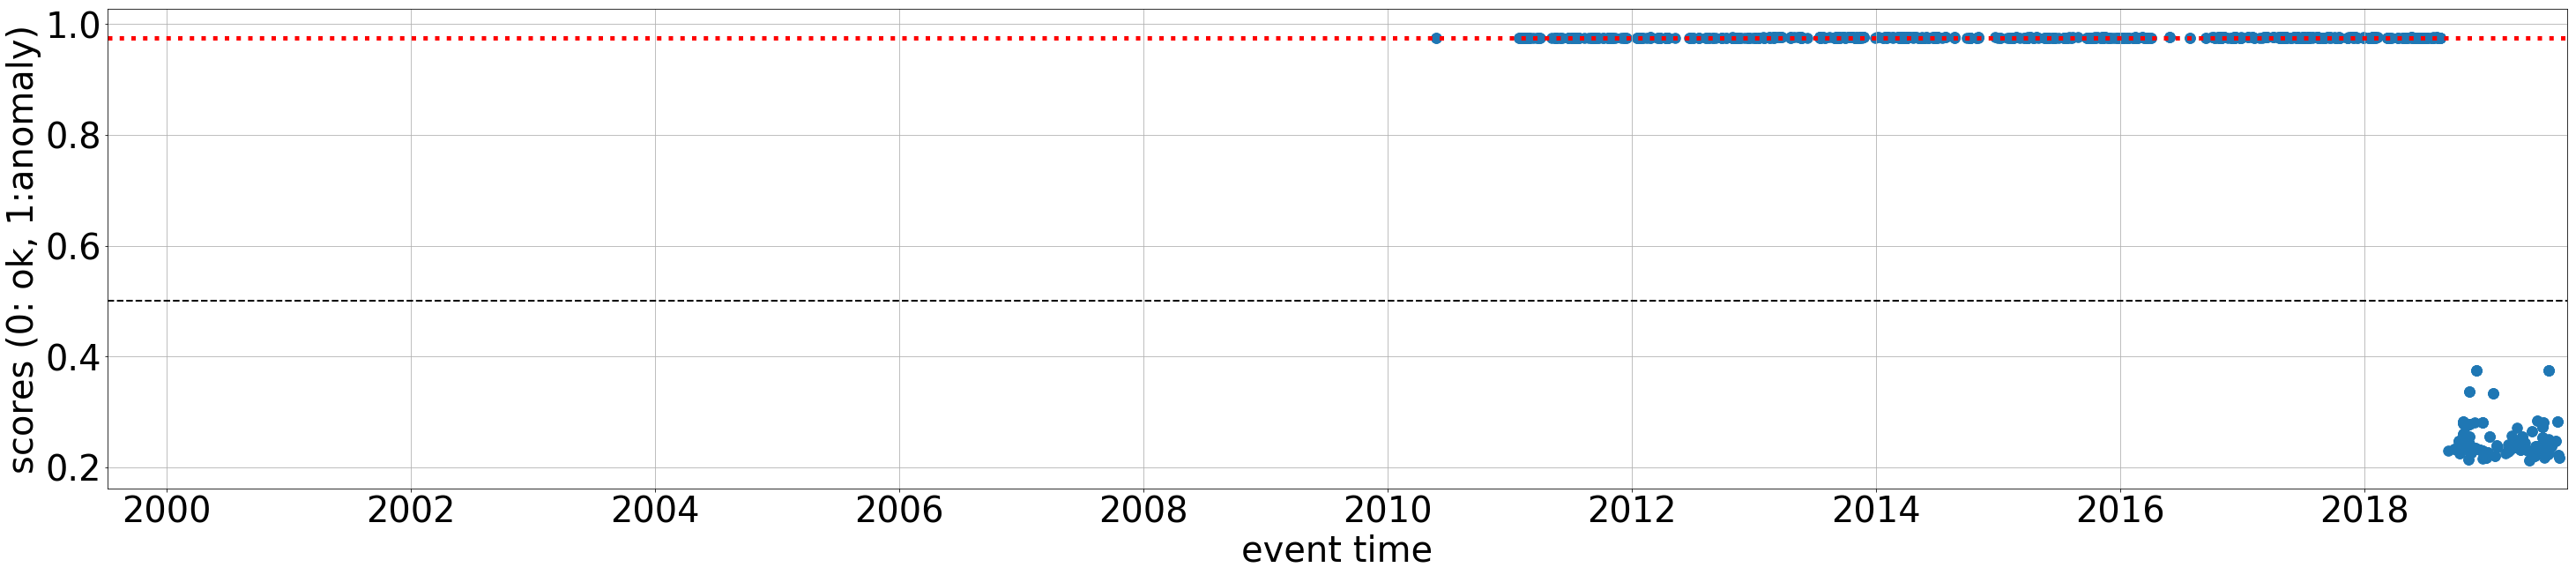

Channel TA.Y22D.01.BH? (database: me, station id: 3494). 287 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.974[0] 0.952[1] 0.935[2]


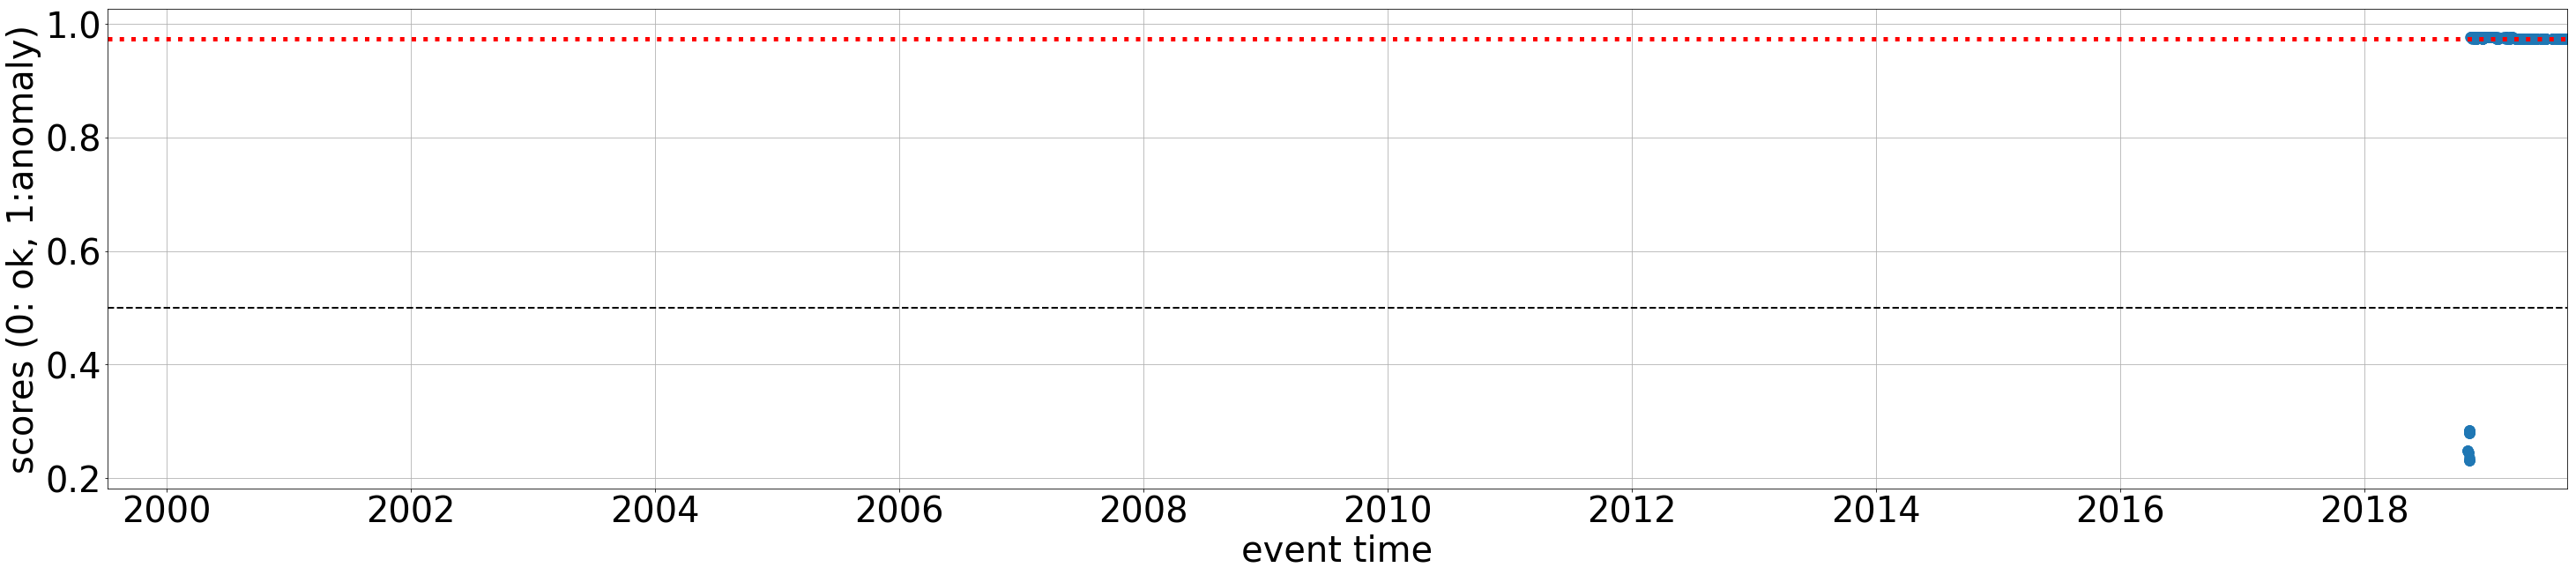

Channel UD.LUBAR..BH? (database: me, station id: 3714). 58 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.973[0] 0.937[1] 0.883[2]


Channel IU.TRQA.00.BH? (database: me, station id: 2687). 769 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.972[0] 0.940[1] 0.886[2]


Channel JP.JSU..BH? (database: me, station id: 2729). 1567 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.972[0] 0.941[1] 0.892[2]


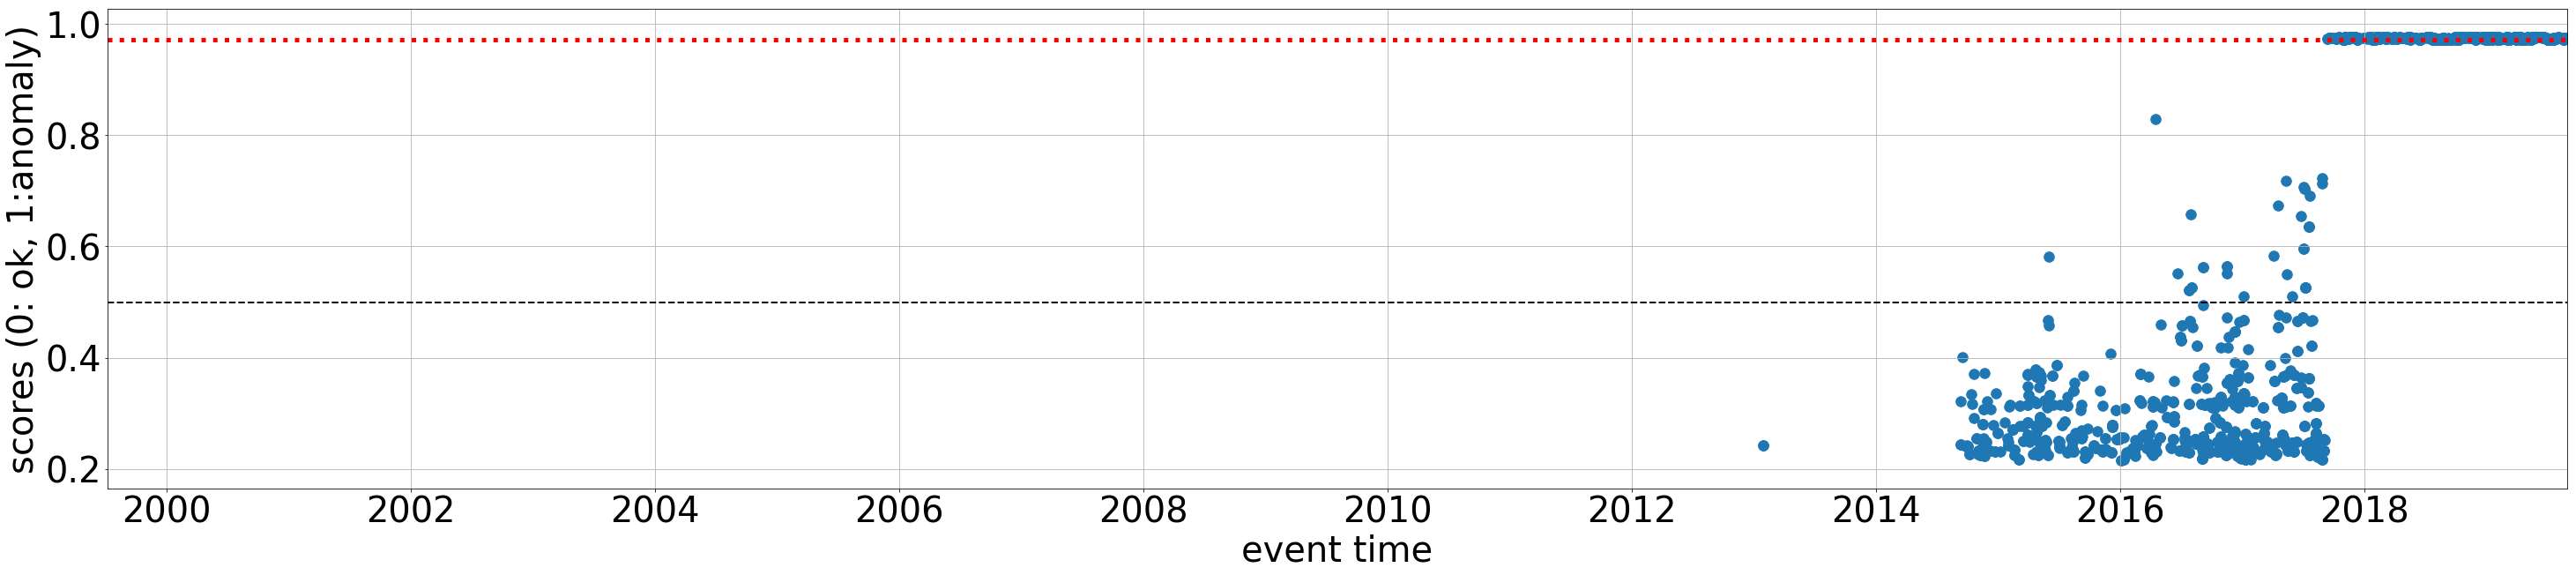

Channel YN.TFRD..BH? (database: me, station id: 3645). 1107 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.972[0] 0.935[1] 0.872[2]


Channel MC.TRNT..BH? (database: me, station id: 2864). 650 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.961[0] 0.924[1] 0.847[2]


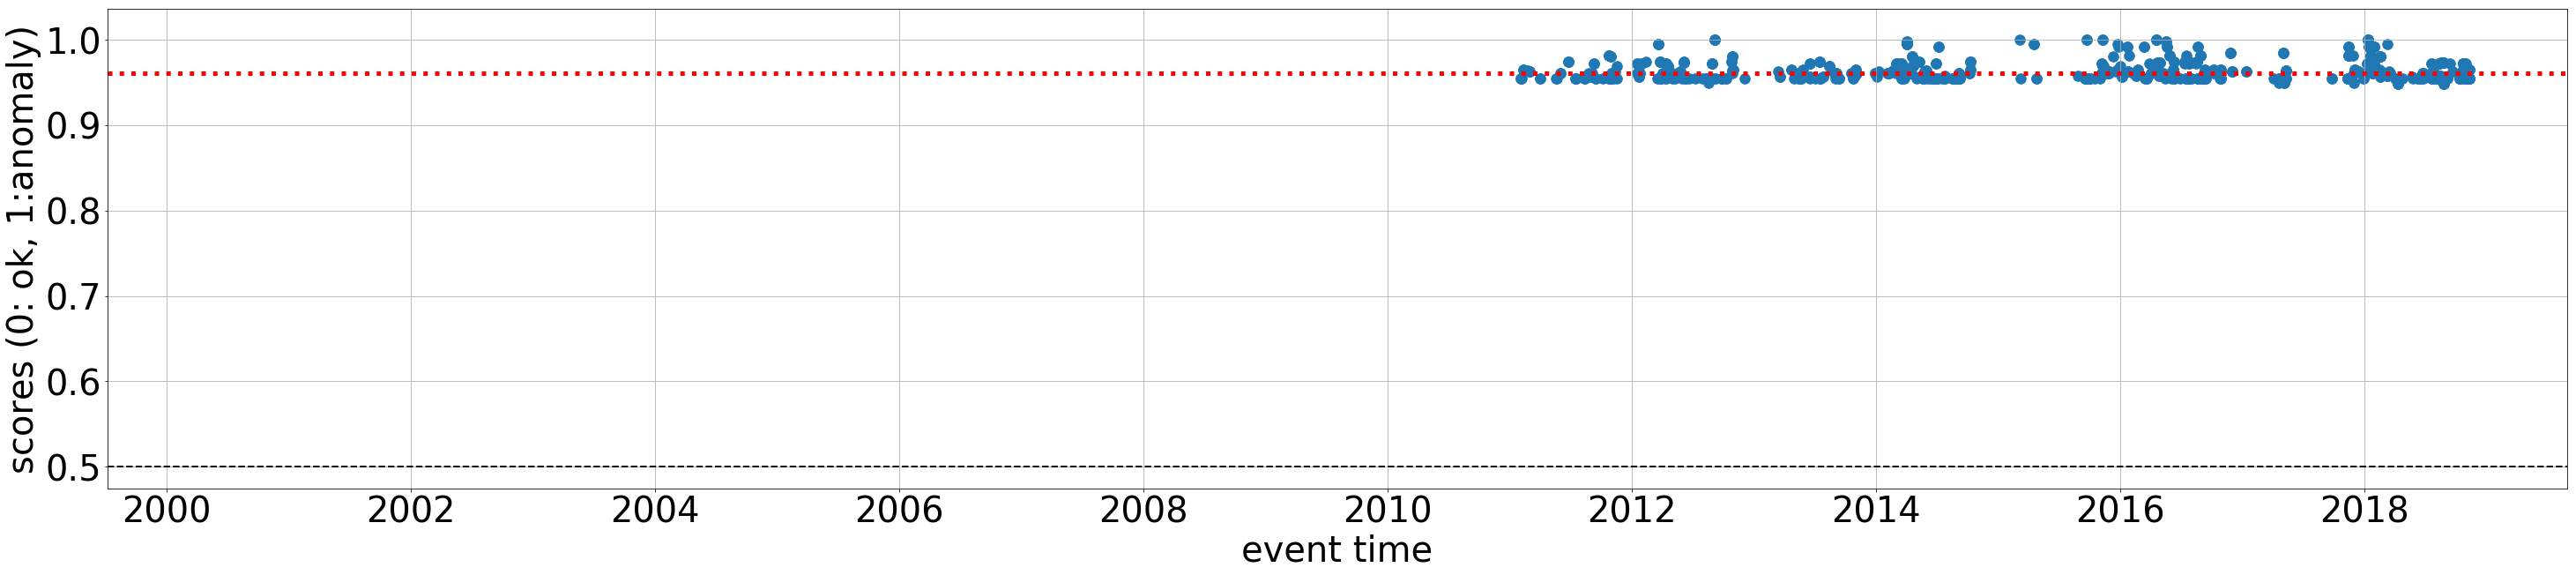

Channel HL.DION..HH? (database: s2s_2019_03, station id: 3633). 24 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.960[0] 0.914[1] 0.861[2]


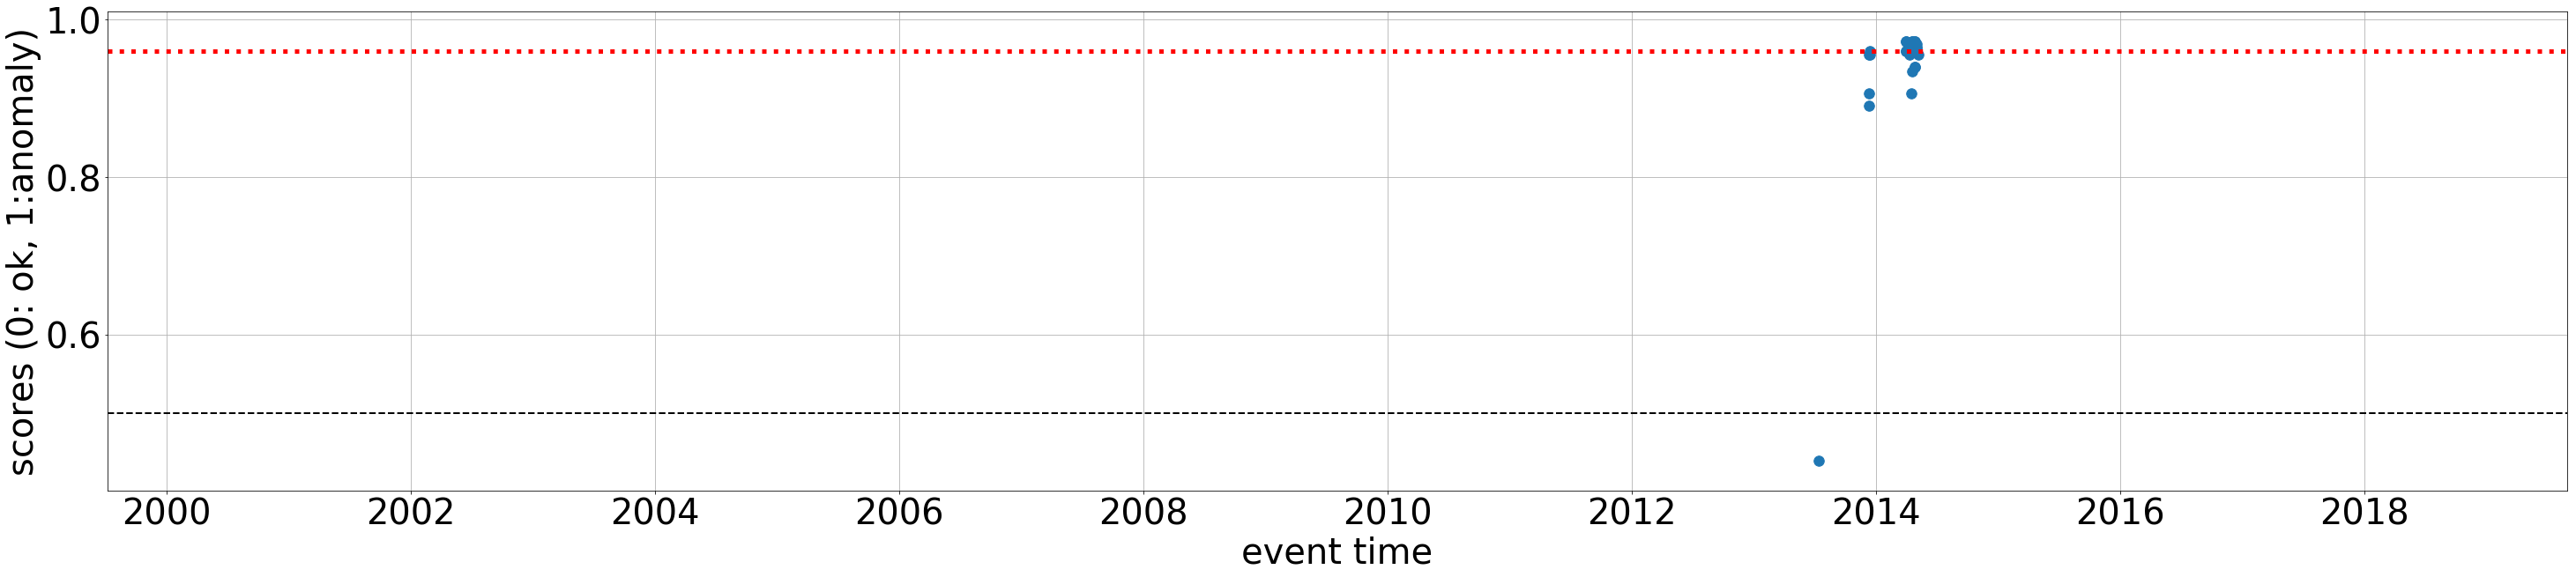

Channel MC.AIRS..BH? (database: me, station id: 2860). 41 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.934[0] 0.884[1] 0.799[2]


Channel JP.JWT..BH? (database: me, station id: 2732). 1560 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.934[0] 0.879[1] 0.814[2]


Channel ND.MARNC.00.BH? (database: me, station id: 1337). 1604 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.927[0] 0.857[1] 0.784[2]


Channel MC.OLV2..BH? (database: me, station id: 2863). 808 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.921[0] 0.872[1] 0.783[2]


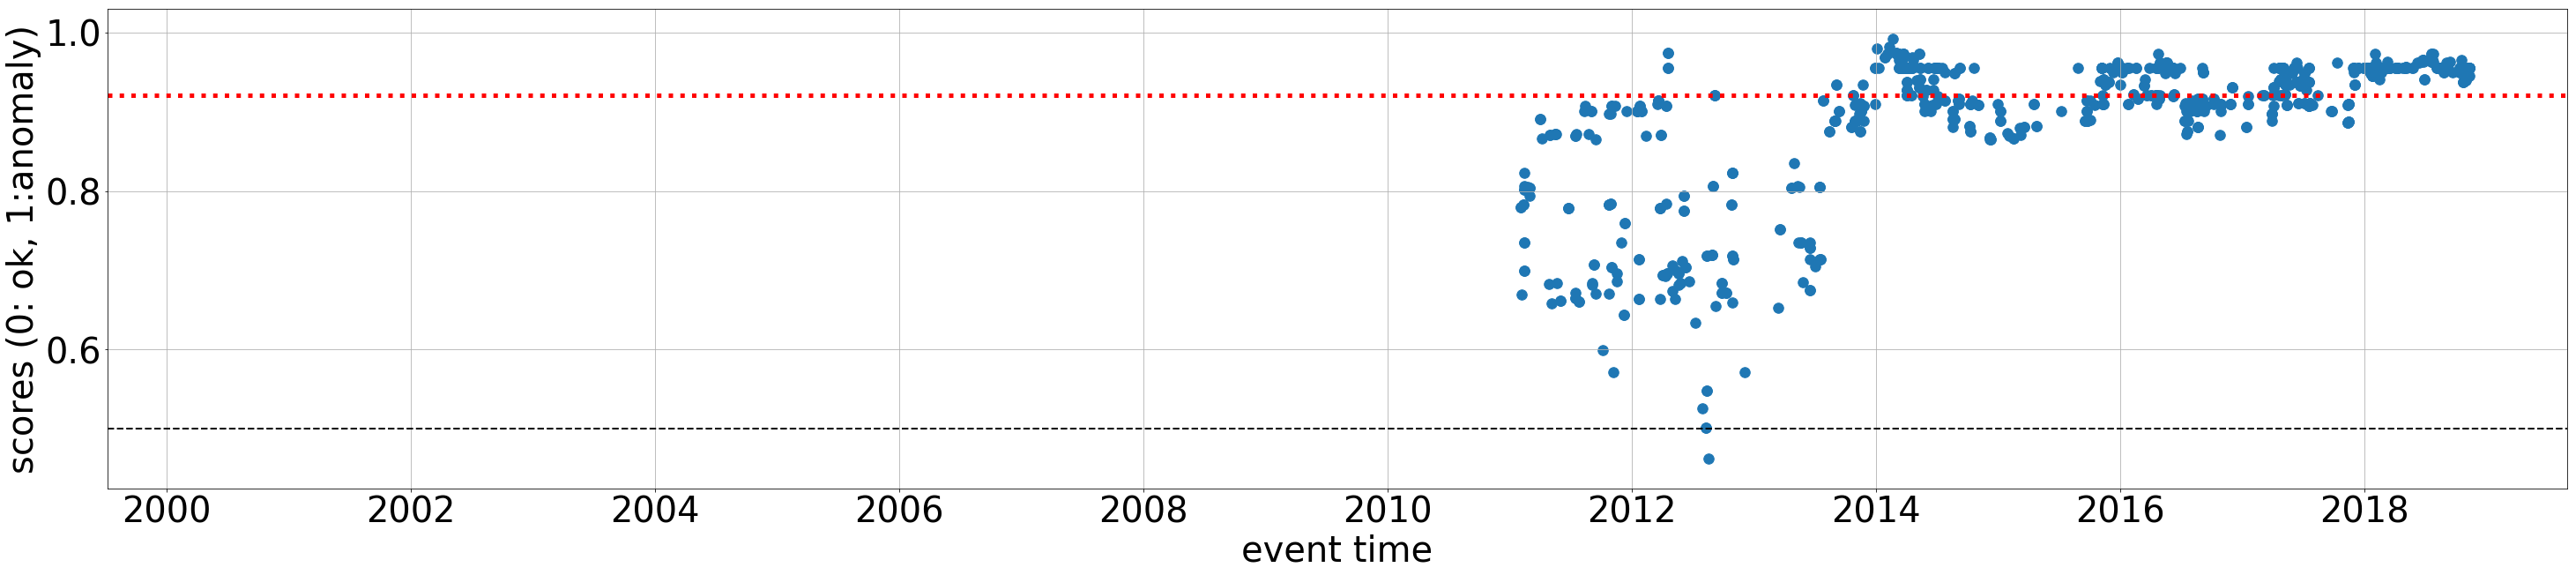

Channel IV.MABI..HH? (database: s2s_2019_03, station id: 4568). 18 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.915[0] 0.845[1] 0.788[2]


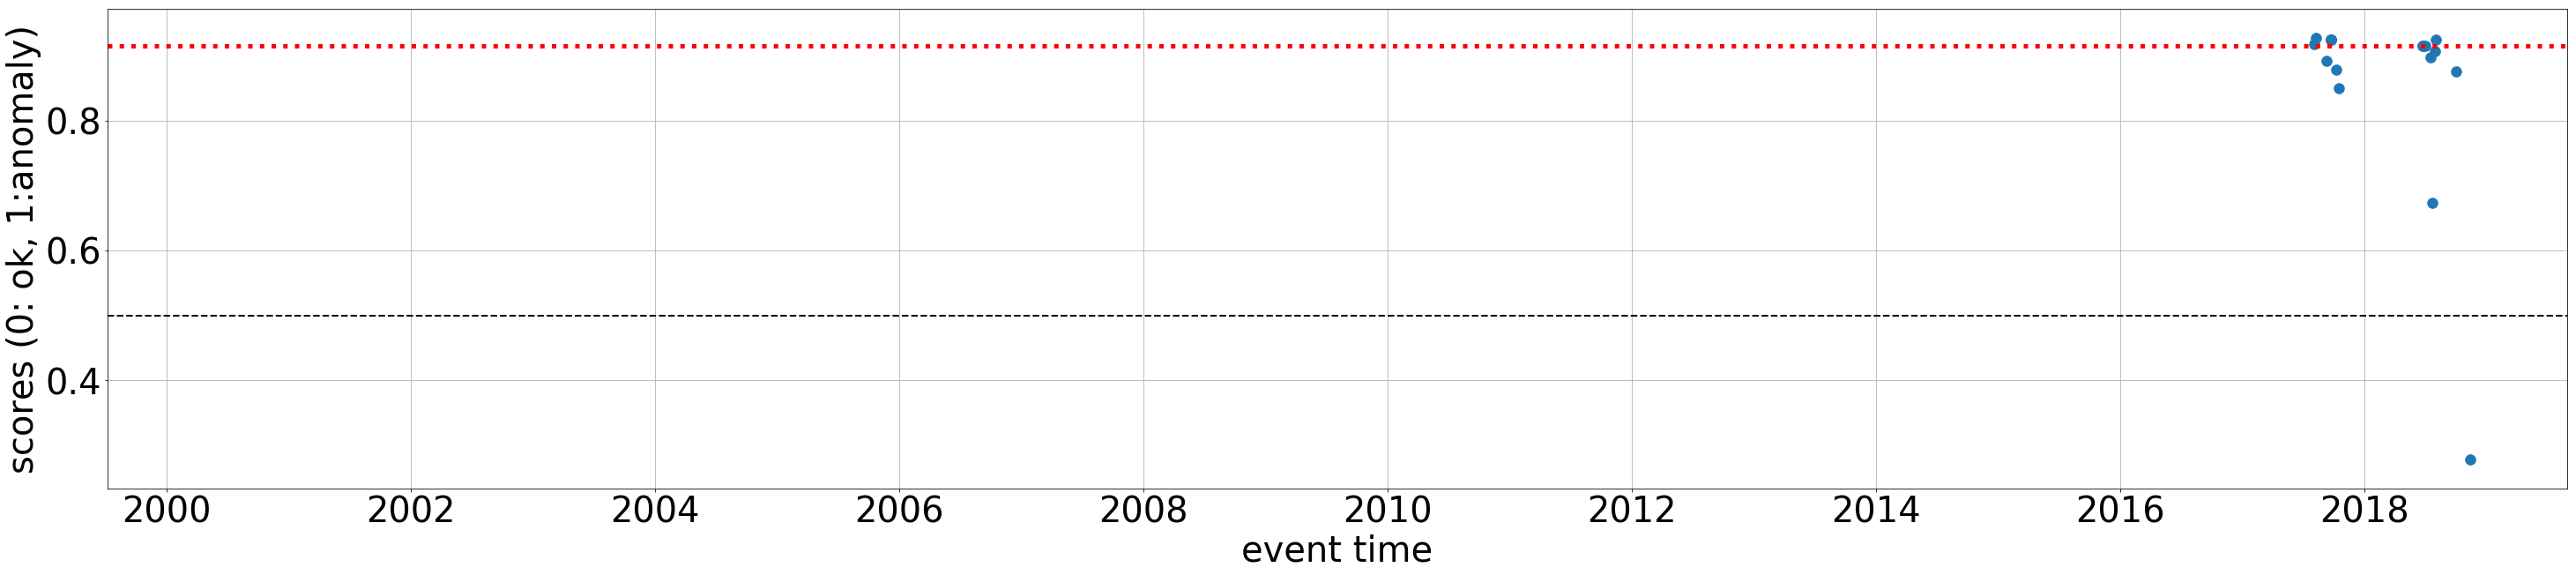

Channel SL.GOLS..BH? (database: me, station id: 649). 469 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.908[0] 0.850[1] 0.725[2]


Channel HP.LTHK..HH? (database: s2s_2019_03, station id: 3780). 2 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.907[0] 0.837[1] 0.771[2]


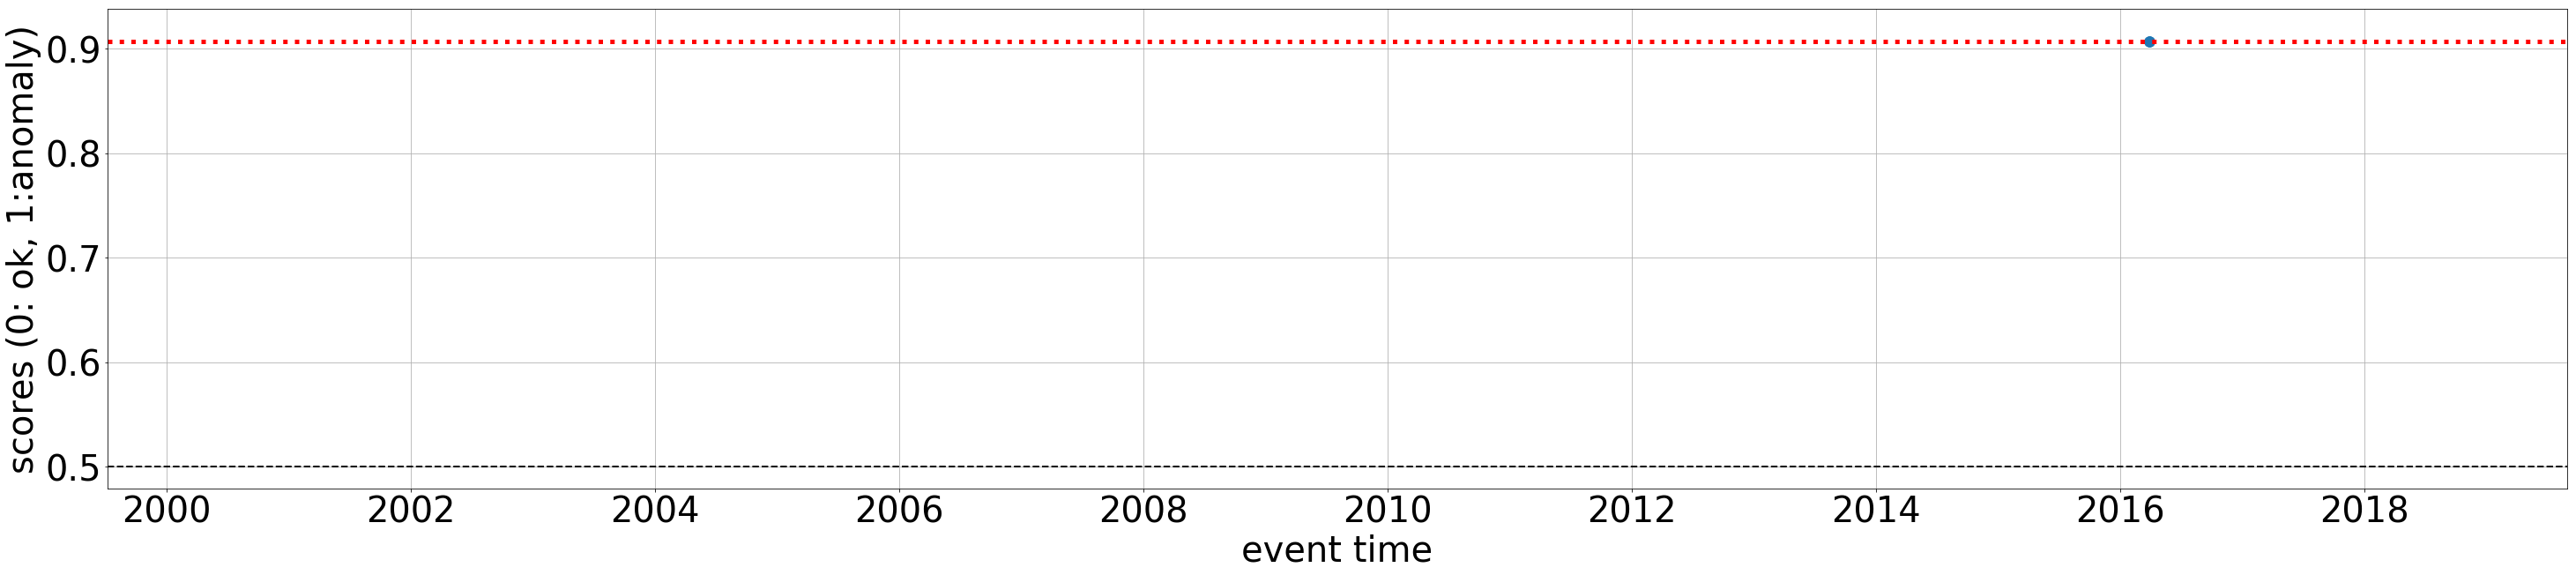

Channel TR.SKI..BH? (database: me, station id: 3516). 120 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.907[0] 0.836[1] 0.763[2]


Channel CH.MMK..HG? (database: s2s_2019_03, station id: 5860). 16 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.900[0] 0.836[1] 0.722[2]


Channel CL.ROD3.01.EH? (database: s2s_2019_03, station id: 512). 22 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.898[0] 0.838[1] 0.778[2]


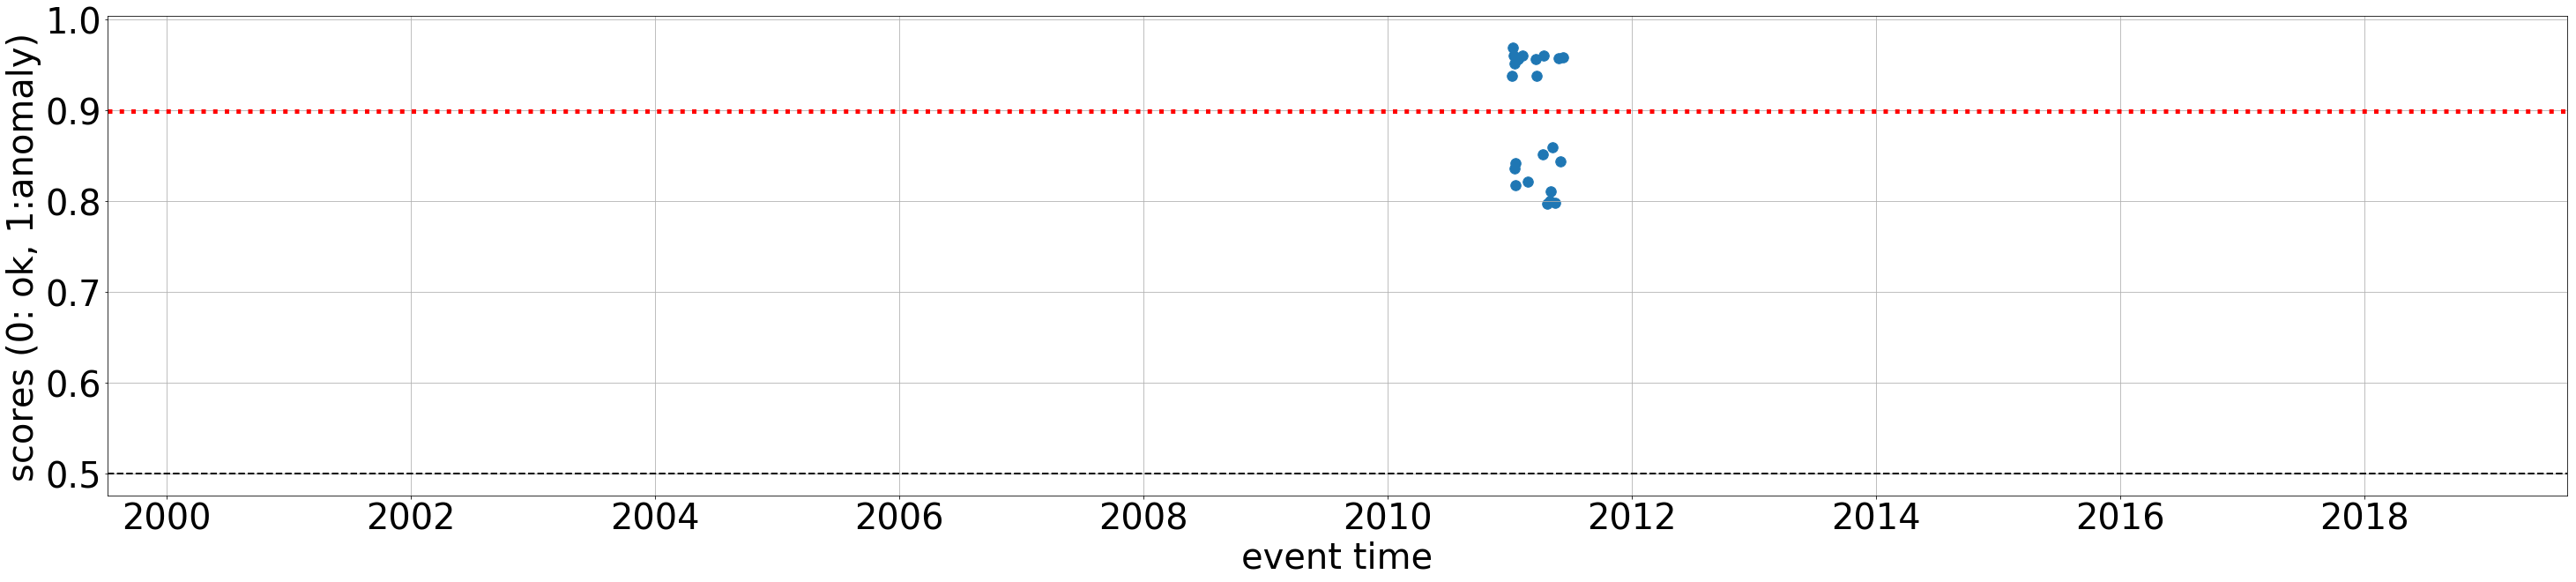

Channel AF.BOBN..BH? (database: me, station id: 1416). 190 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.890[0] 0.828[1] 0.756[2]


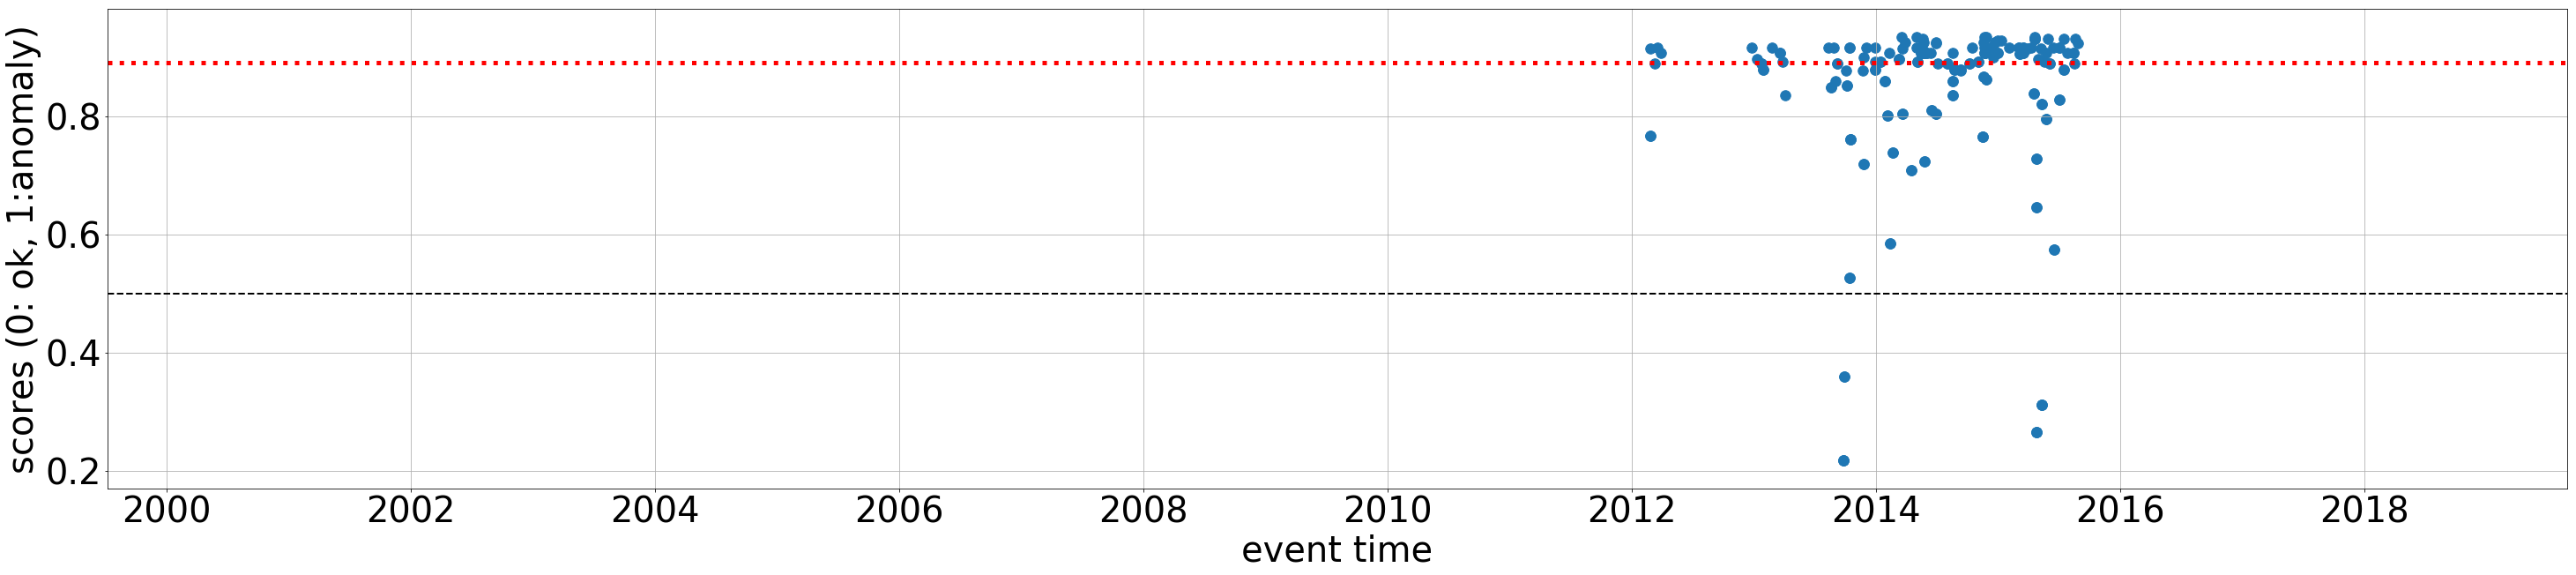

Channel IS.GEM..BH? (database: me, station id: 1010). 1644 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.889[0] 0.827[1] 0.756[2]


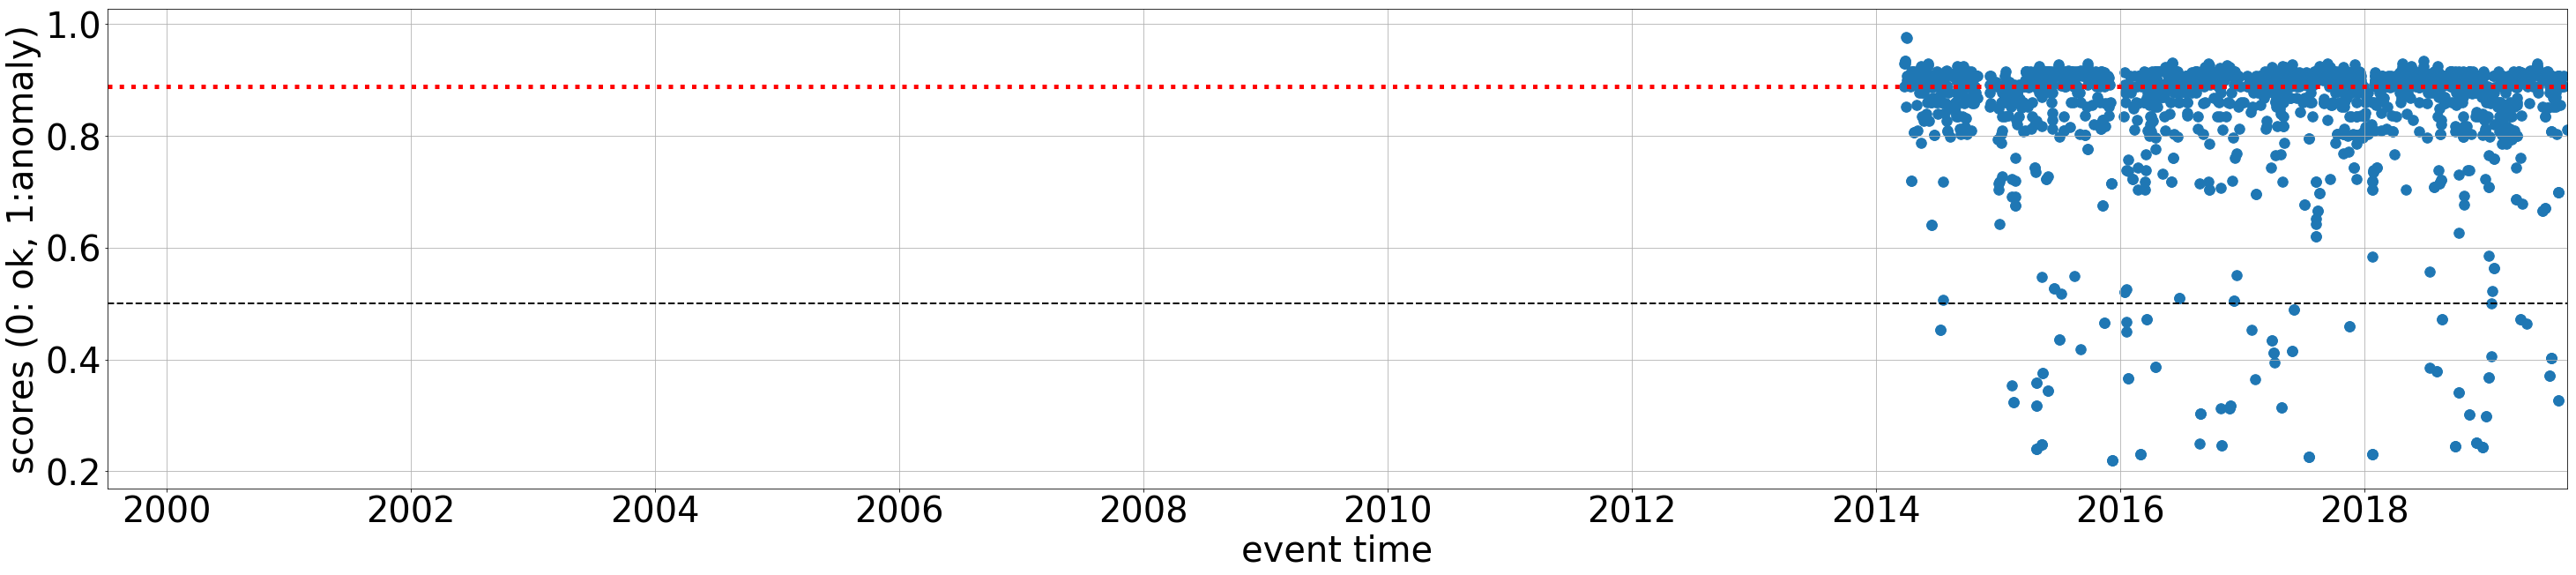

Channel SL.MOZS..BH? (database: me, station id: 657). 297 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.872[0] 0.805[1] 0.707[2]


Channel SL.VOJS..BH? (database: me, station id: 663). 244 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.870[0] 0.802[1] 0.704[2]


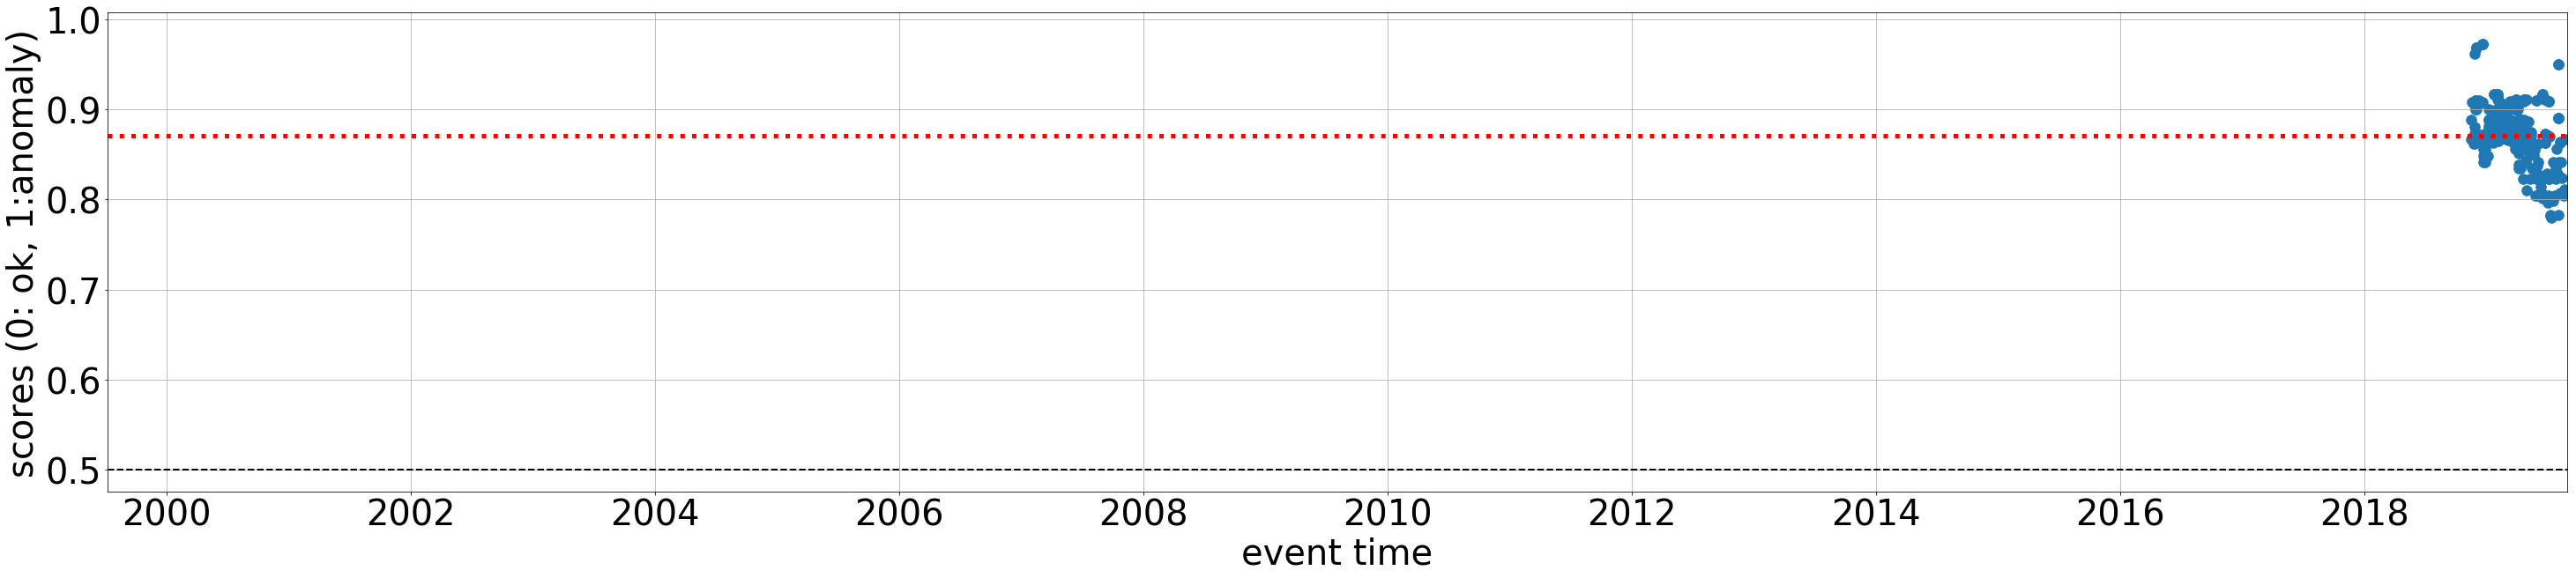

Channel CH.MMK..HG? (database: s2s_2019_03, station id: 5861). 6 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.869[0] 0.792[1] 0.700[2]


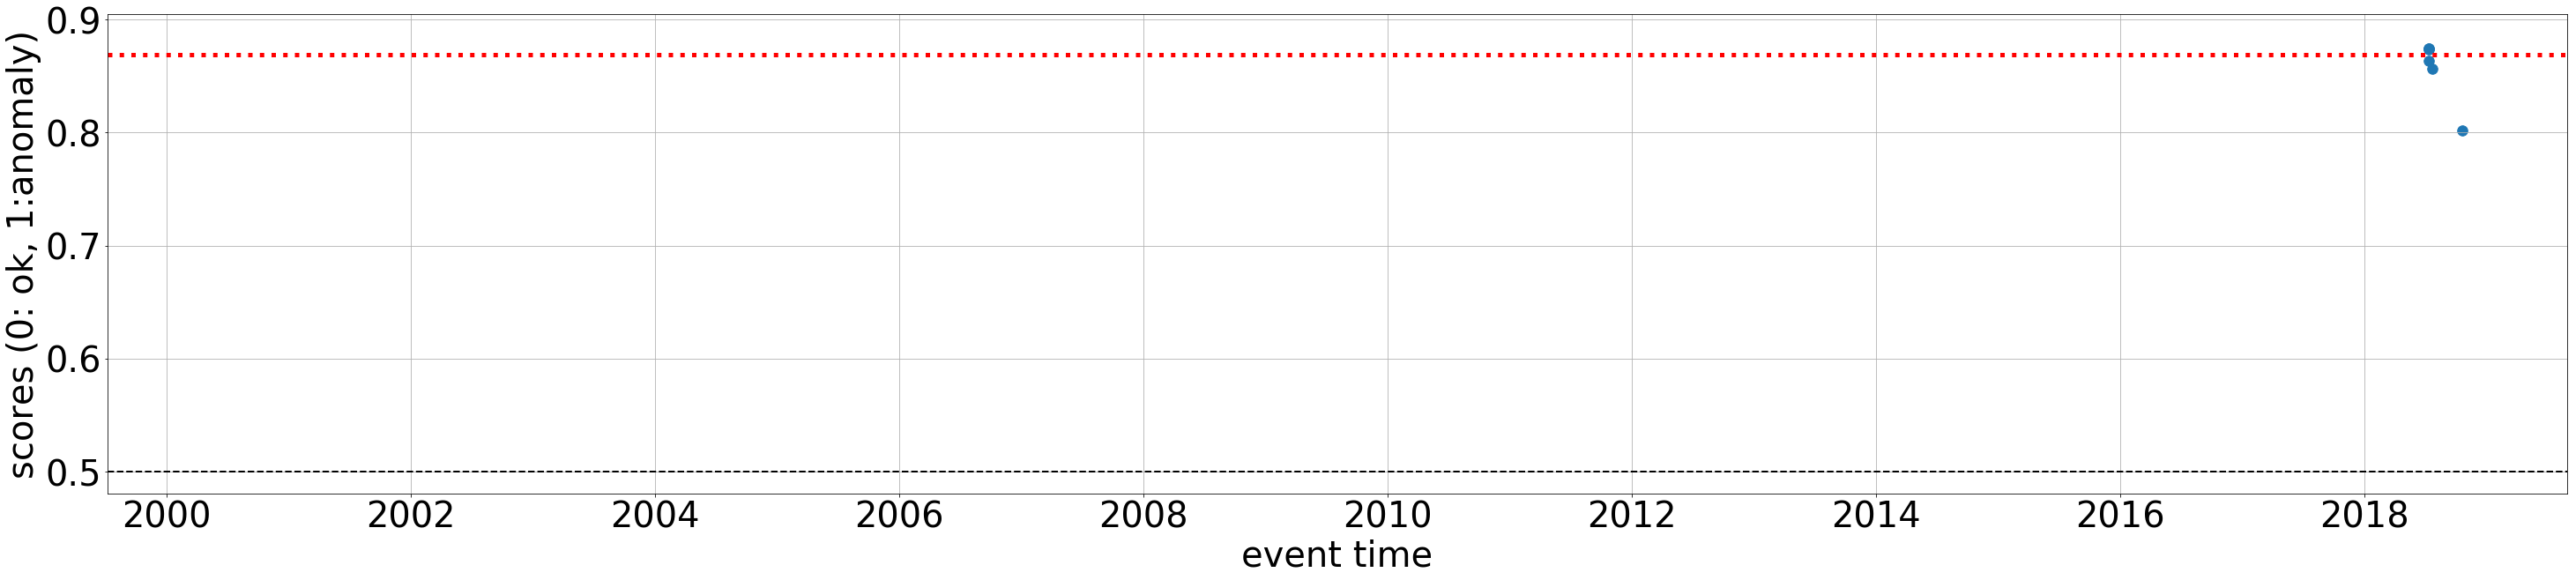

Channel UD.MI29..BH? (database: me, station id: 3716). 69 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.868[0] 0.805[1] 0.700[2]


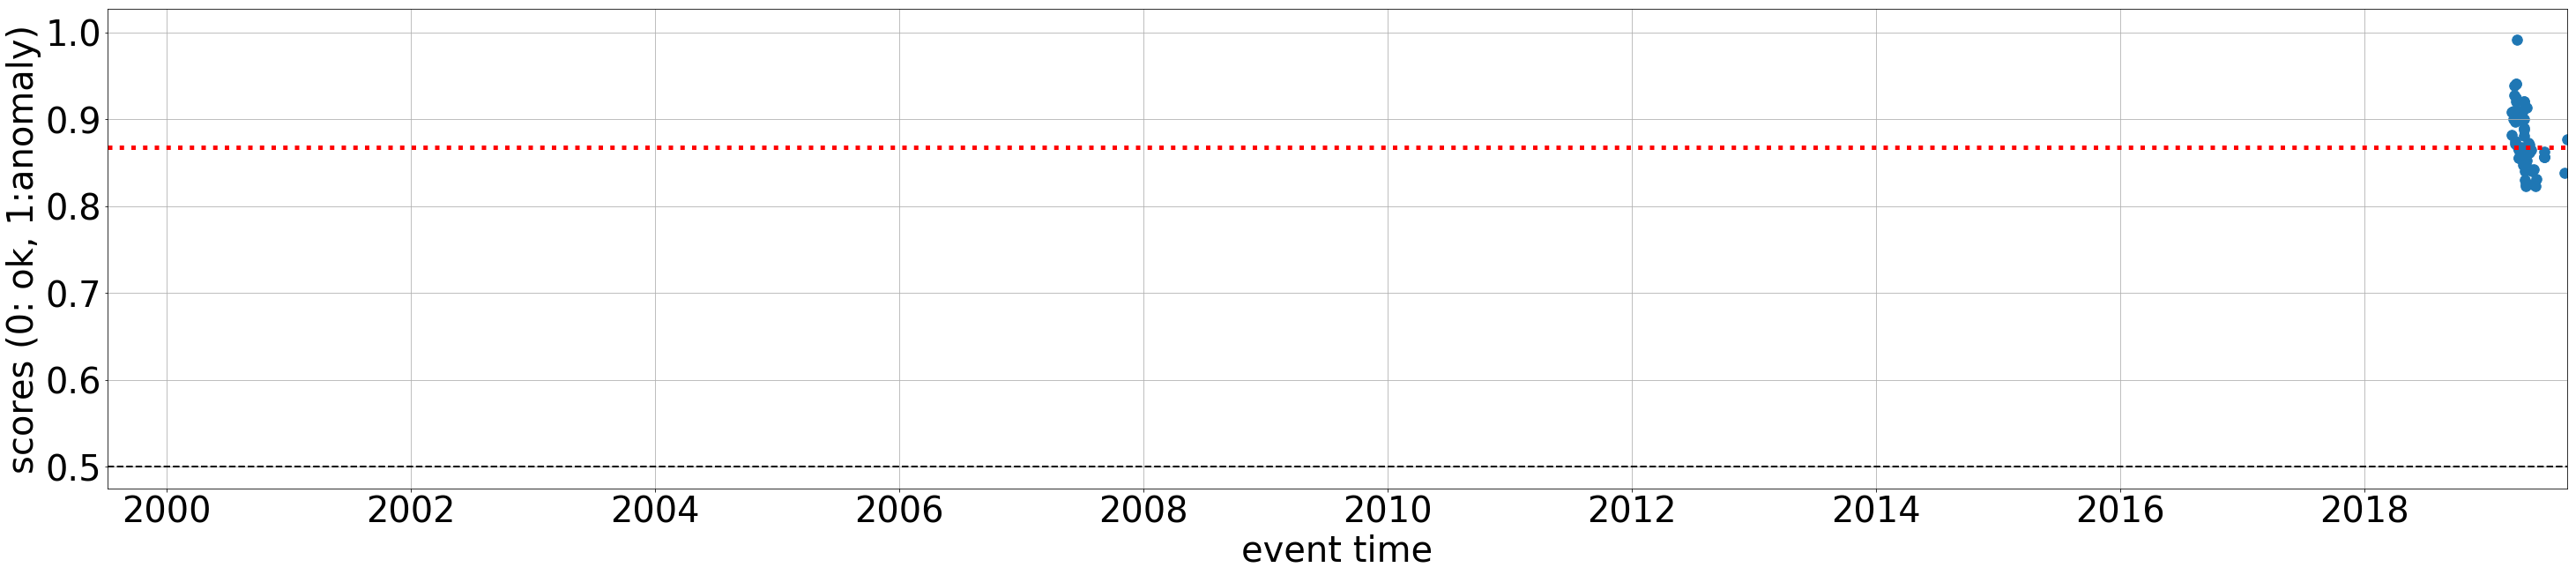

Channel MC.GERD..BH? (database: me, station id: 2861). 754 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.867[0] 0.802[1] 0.696[2]


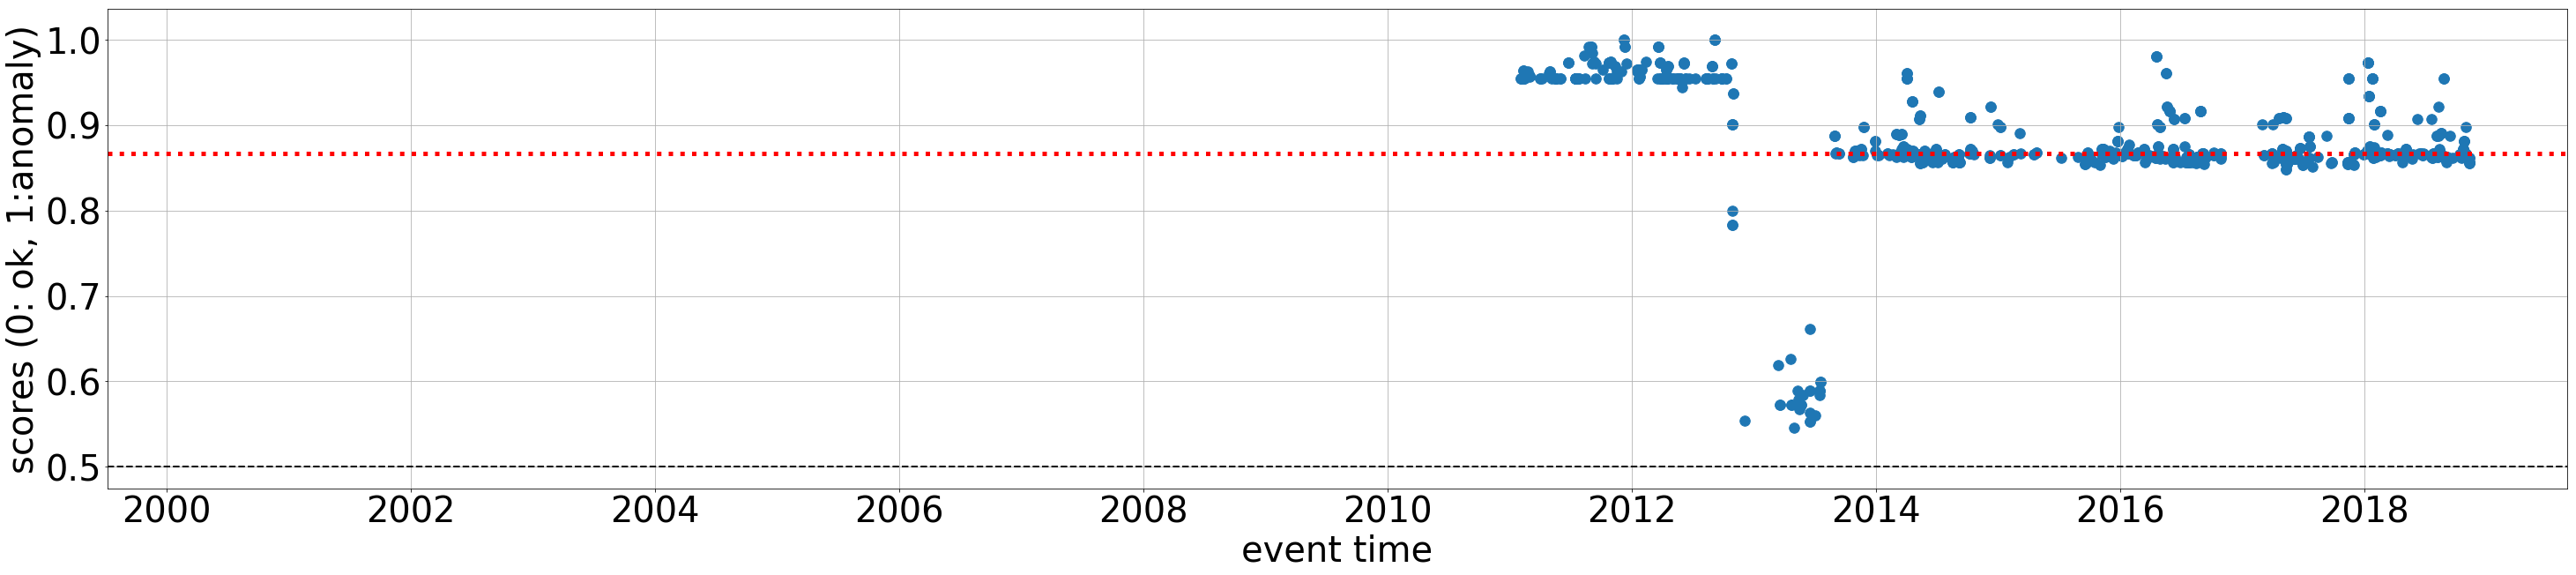

Channel SL.GBRS..BH? (database: me, station id: 647). 577 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.866[0] 0.800[1] 0.693[2]


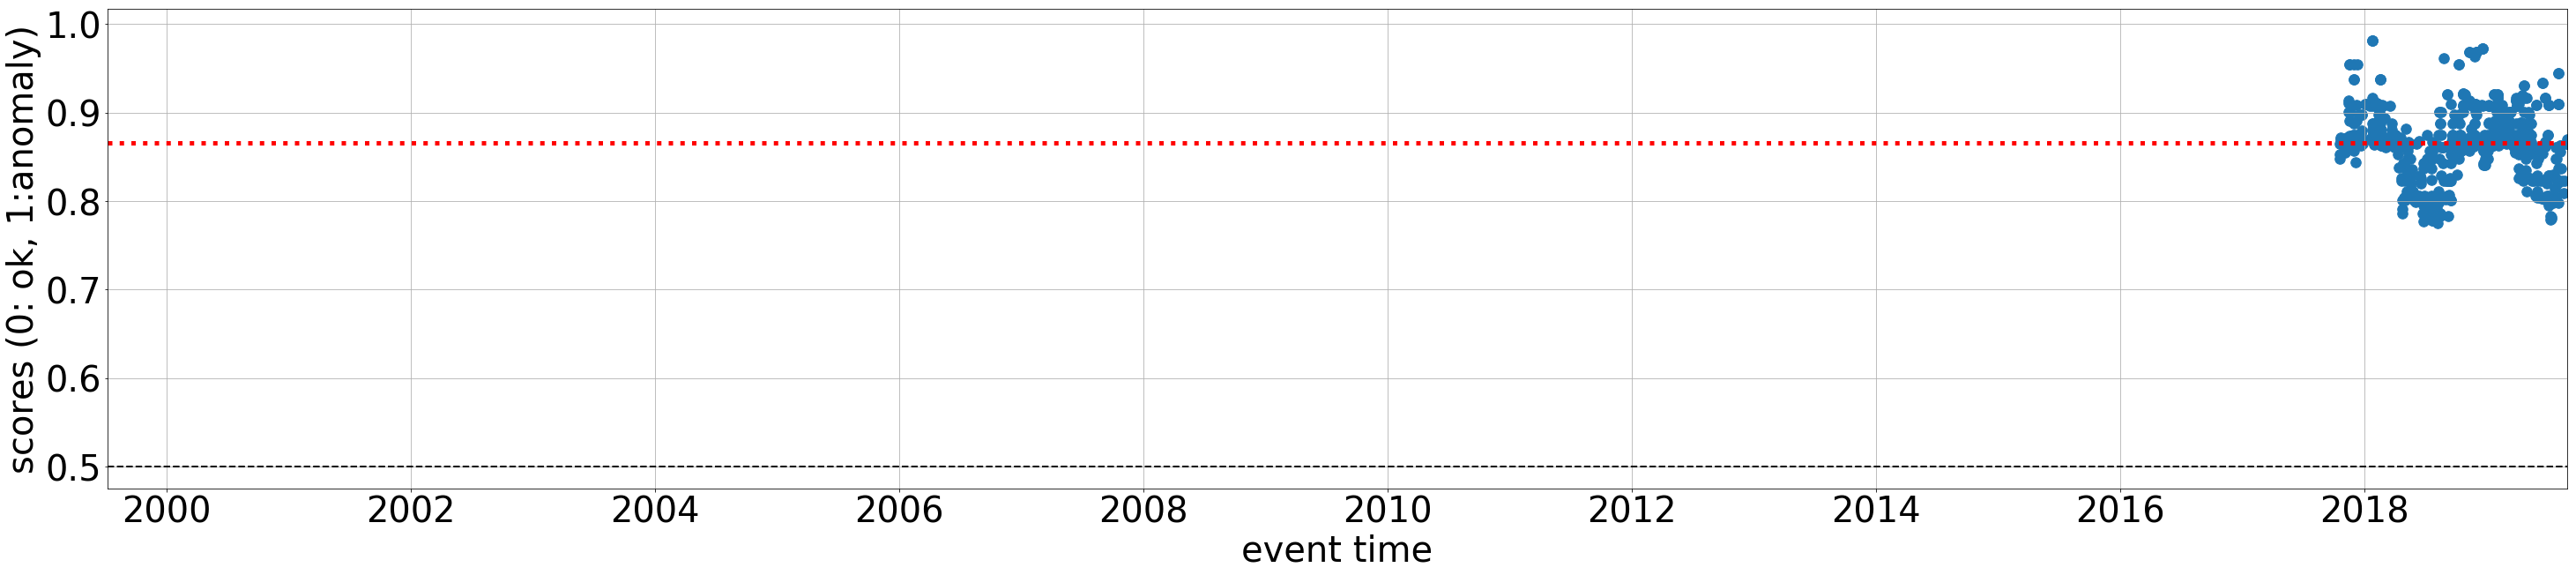

Channel UD.MI28..BH? (database: me, station id: 3715). 72 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.866[0] 0.795[1] 0.697[2]


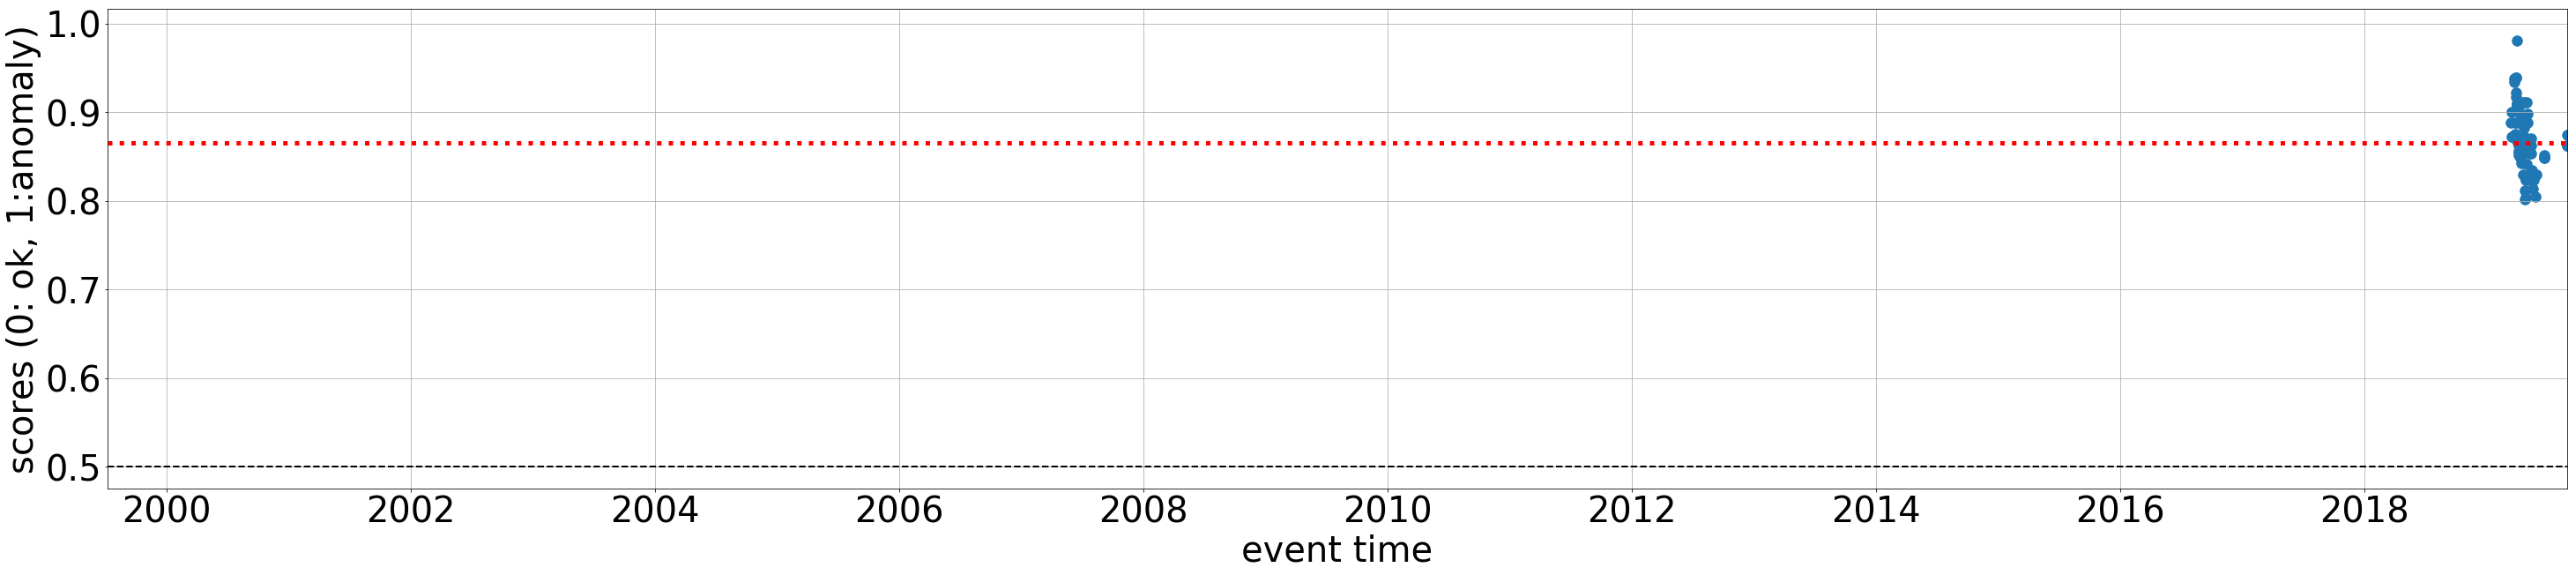

Channel SL.GBAS..BH? (database: me, station id: 646). 840 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.865[0] 0.787[1] 0.694[2]


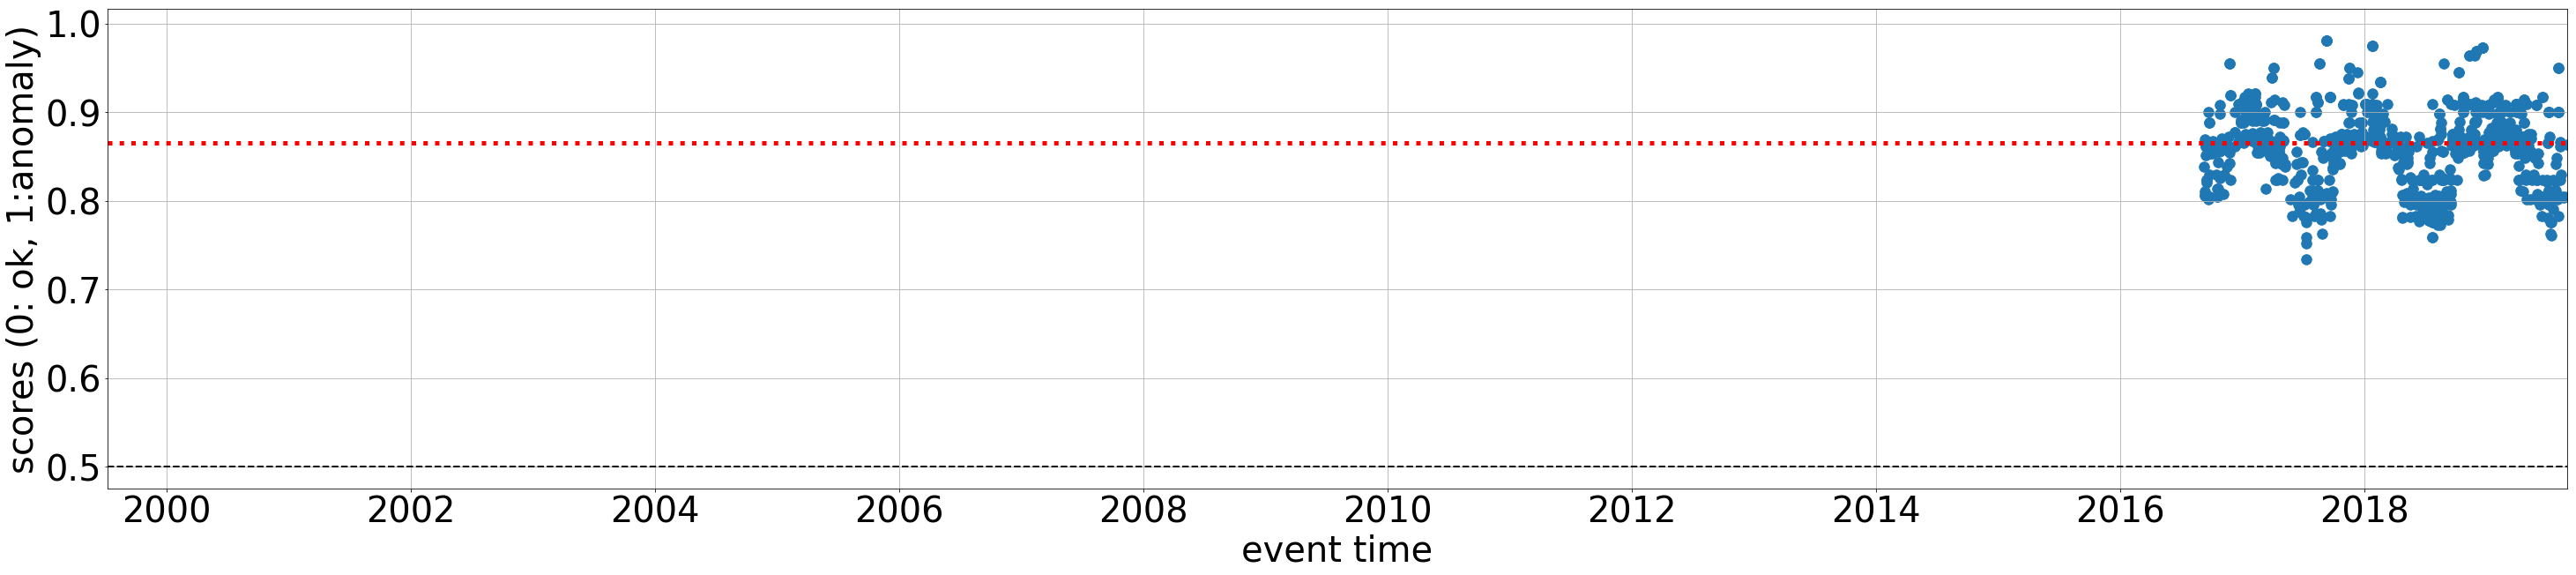

Channel SL.GCIS..BH? (database: me, station id: 648). 607 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.865[0] 0.790[1] 0.693[2]


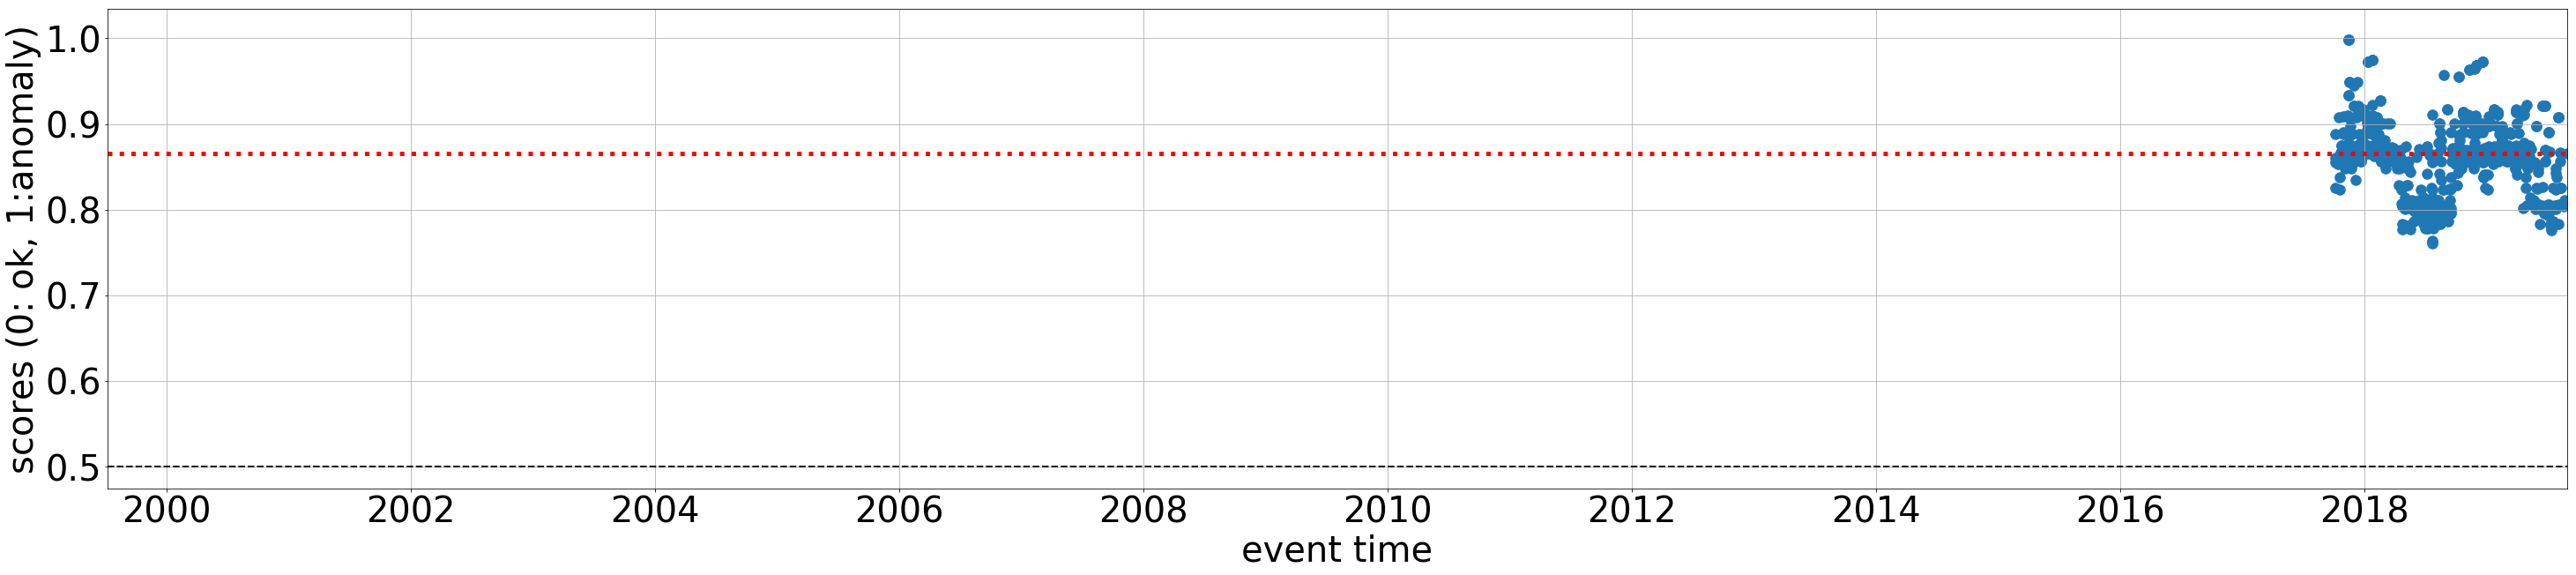

Channel SL.ROBS..BH? (database: me, station id: 659). 550 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.865[0] 0.791[1] 0.691[2]


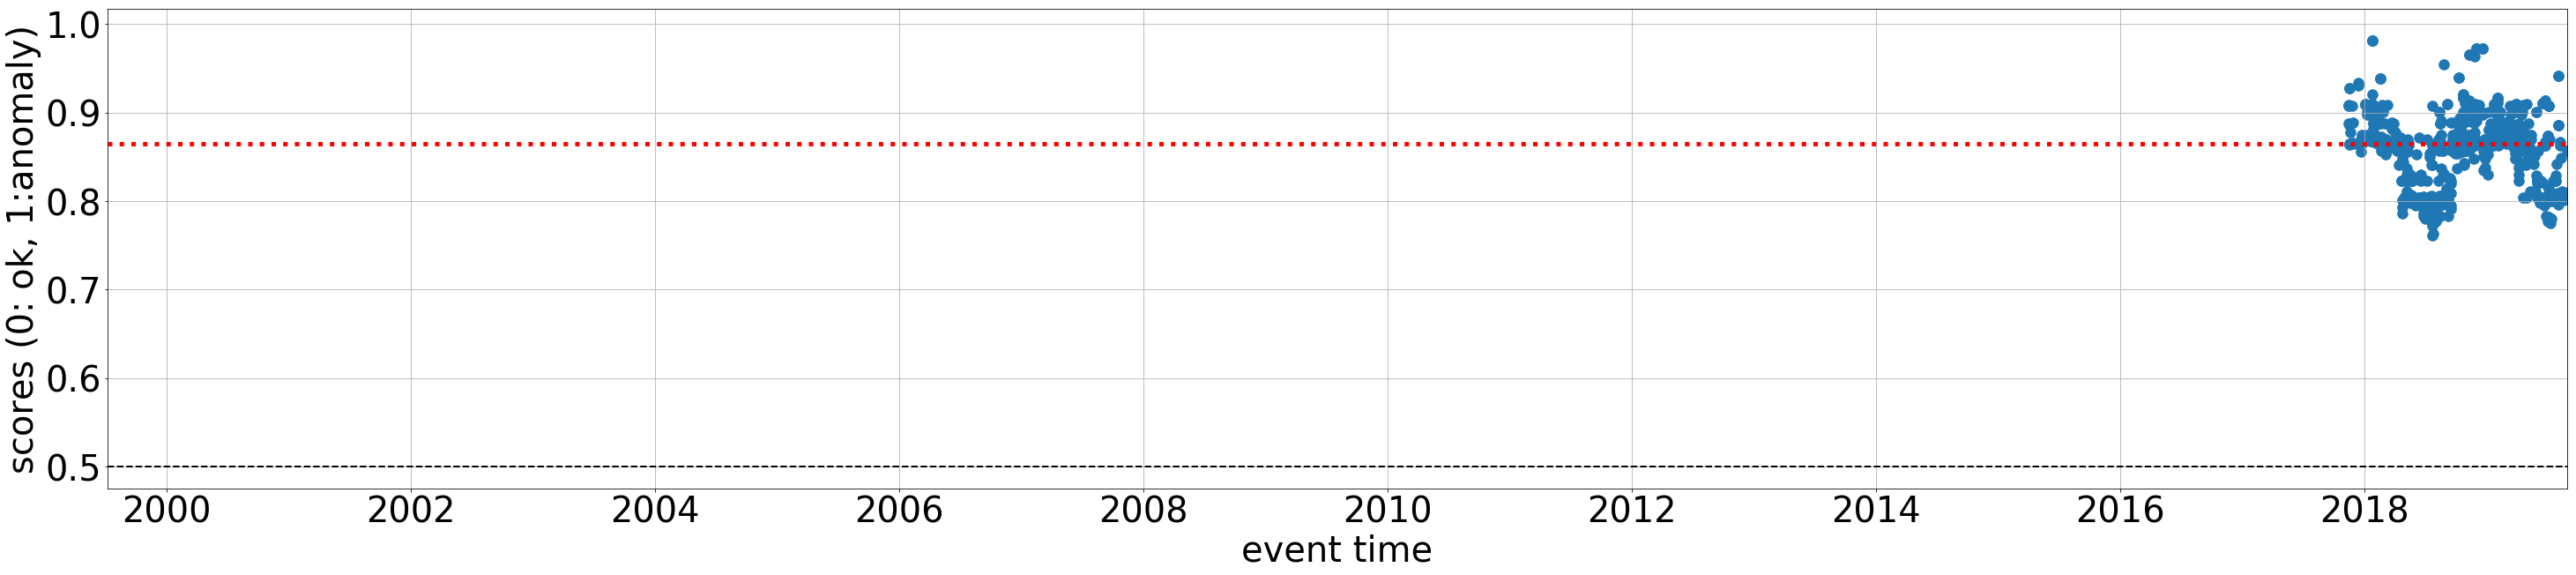

Channel SL.CEY..BH? (database: me, station id: 642). 358 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.863[0] 0.777[1] 0.694[2]


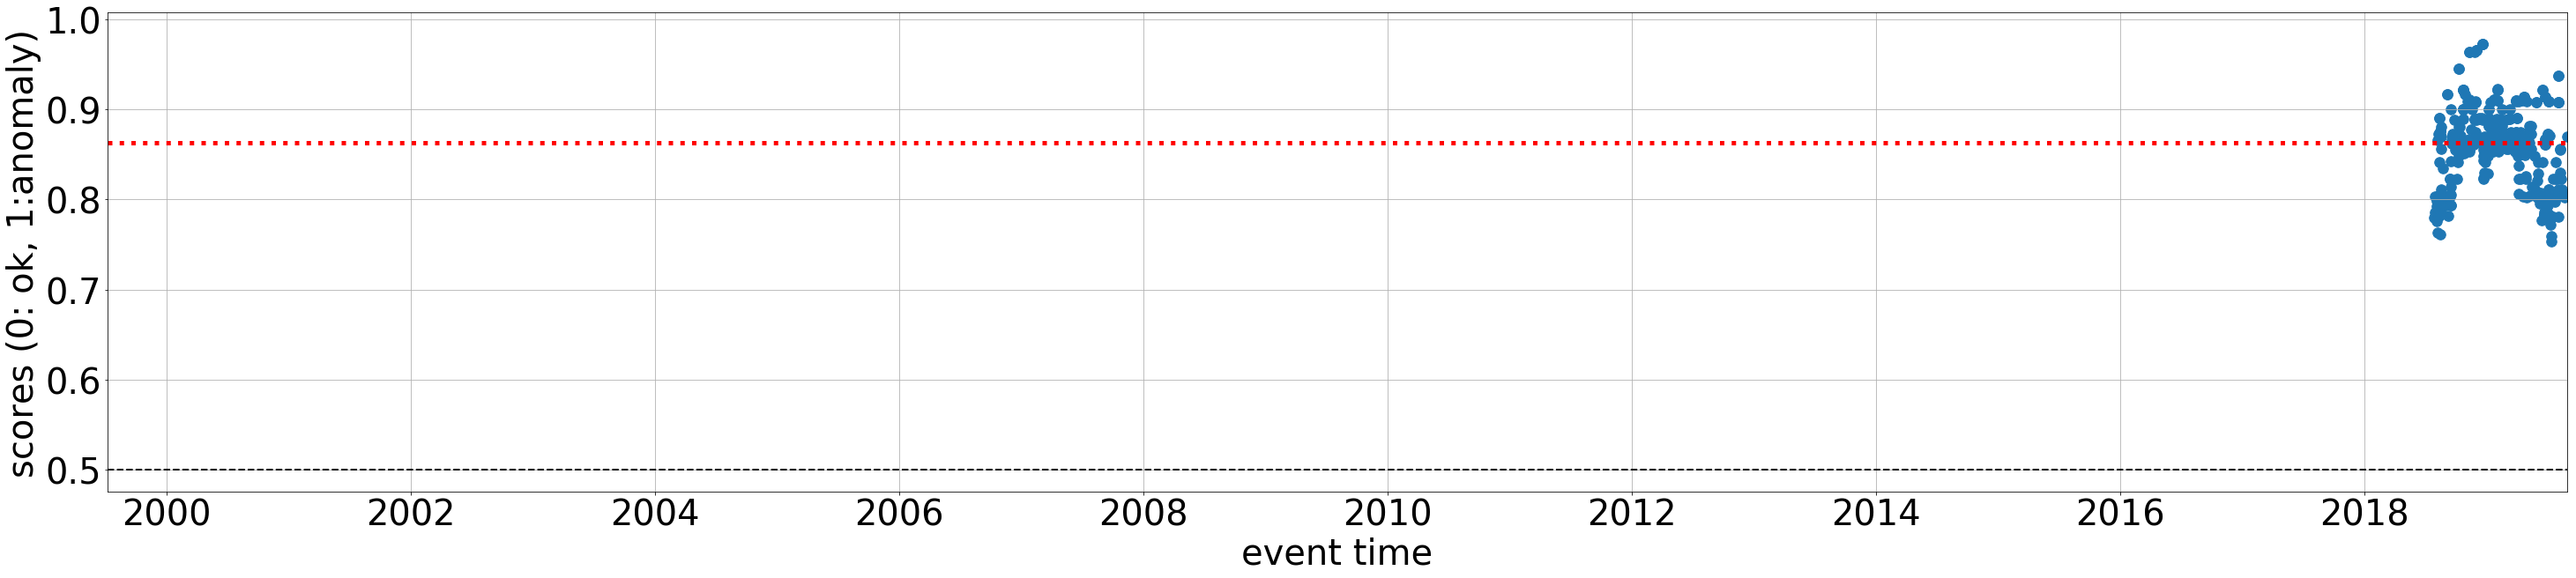

Channel SL.GROS..BH? (database: me, station id: 651). 322 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.863[0] 0.777[1] 0.690[2]


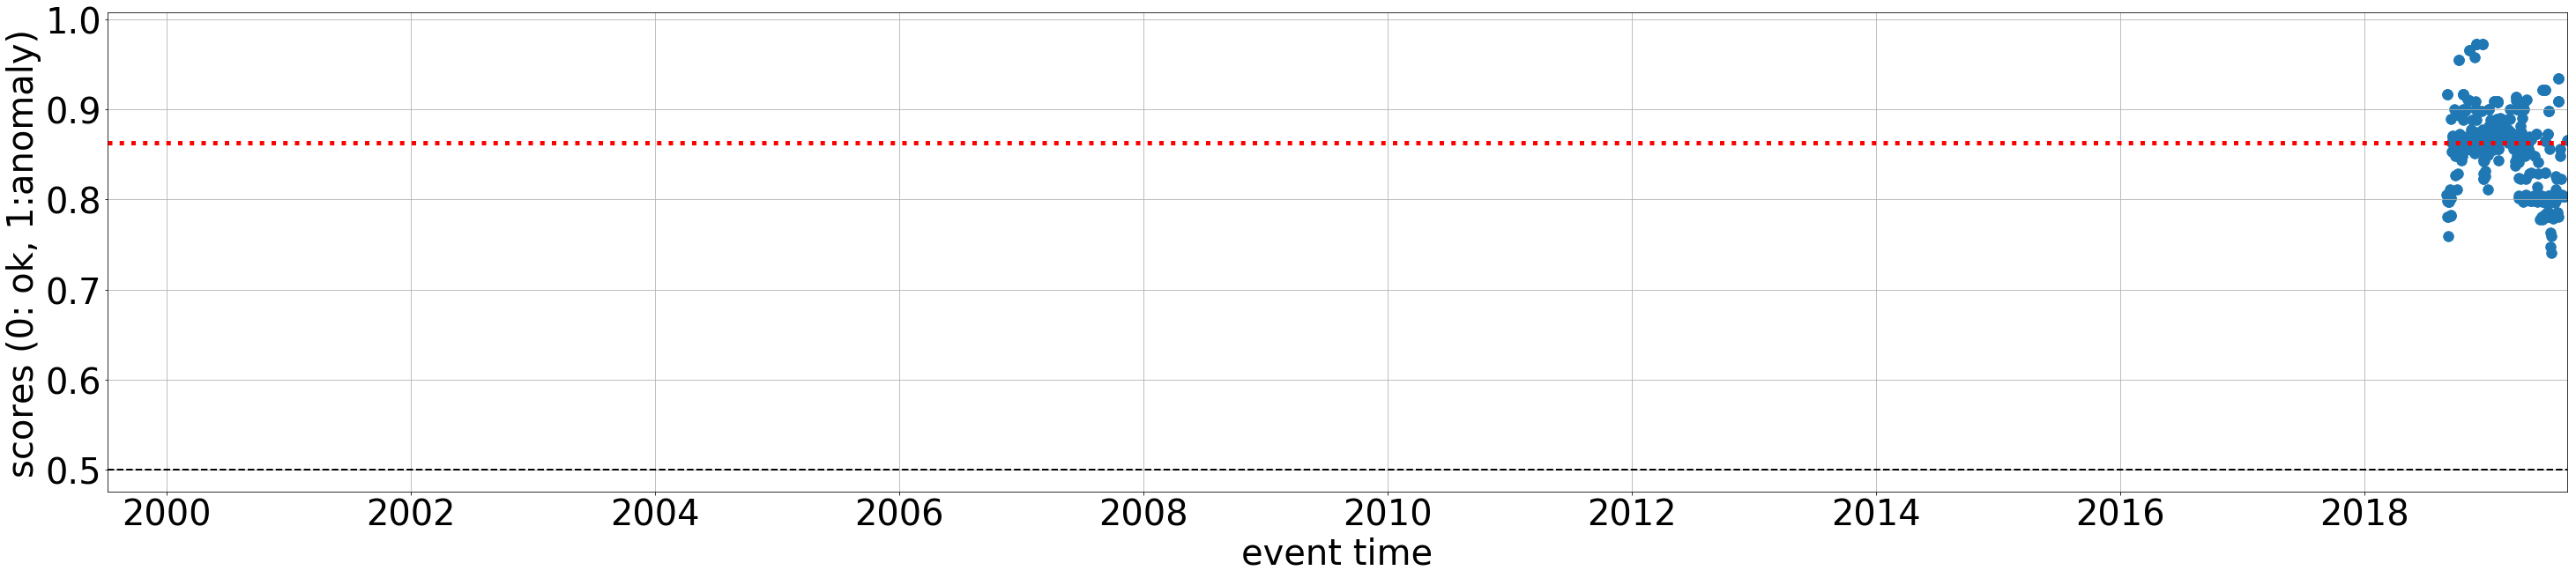

Channel SL.KOGS..BH? (database: me, station id: 654). 1293 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.863[0] 0.777[1] 0.692[2]


Channel SL.LJU..BH? (database: me, station id: 656). 1240 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.863[0] 0.776[1] 0.691[2]


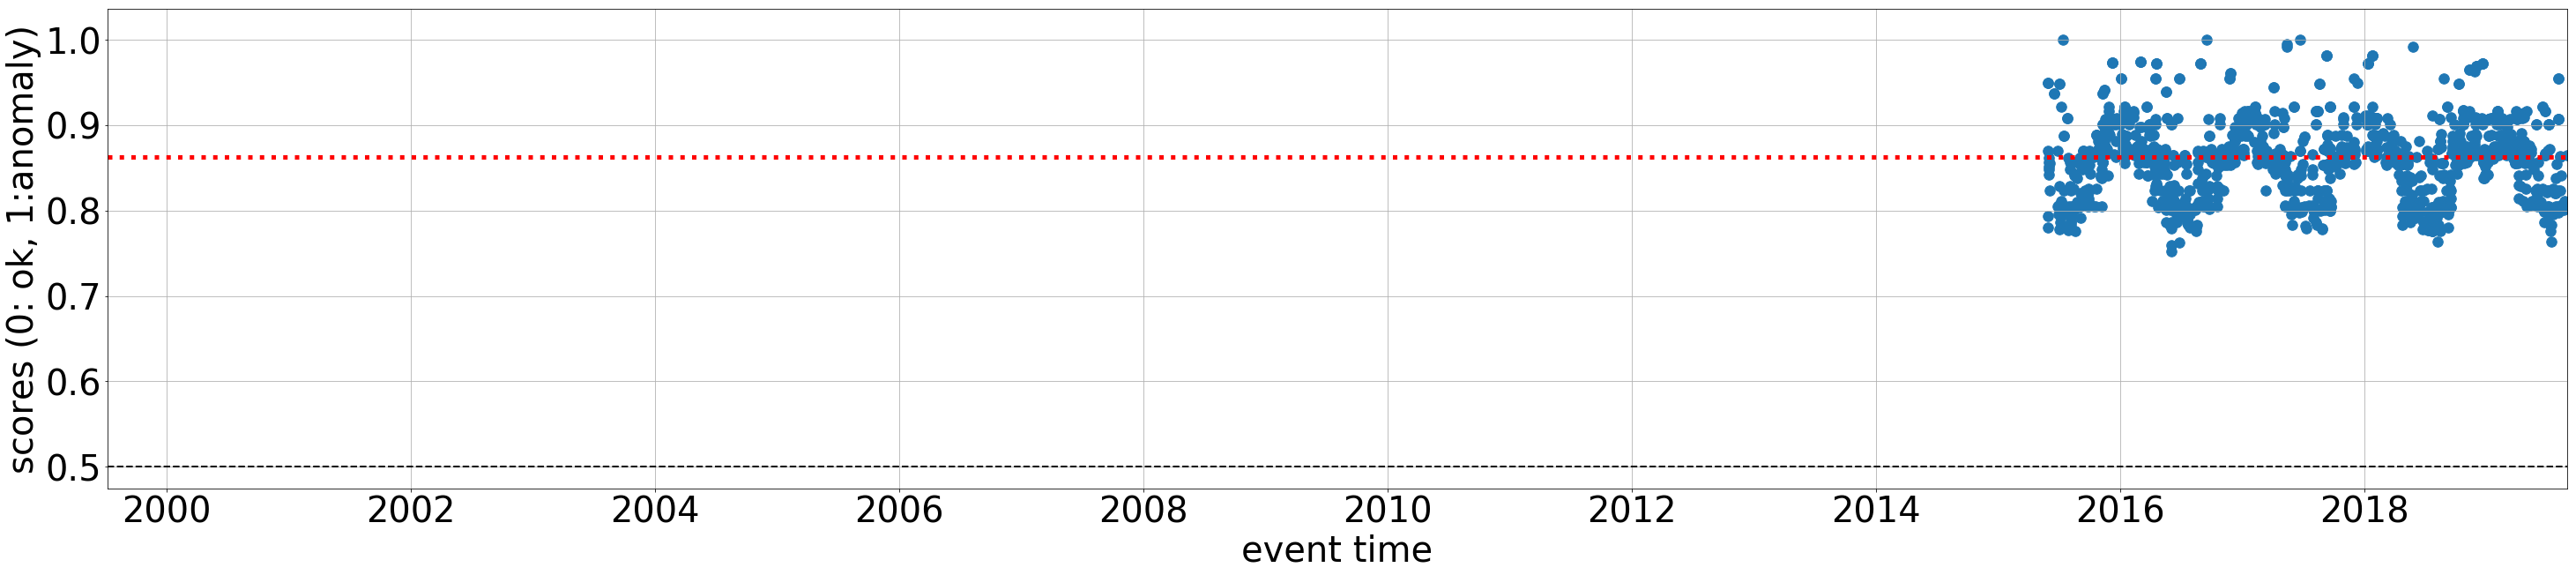

Channel SL.VNDS..BH? (database: me, station id: 662). 306 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.862[0] 0.769[1] 0.691[2]


Channel SL.CRNS..BH? (database: me, station id: 644). 910 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.861[0] 0.767[1] 0.690[2]


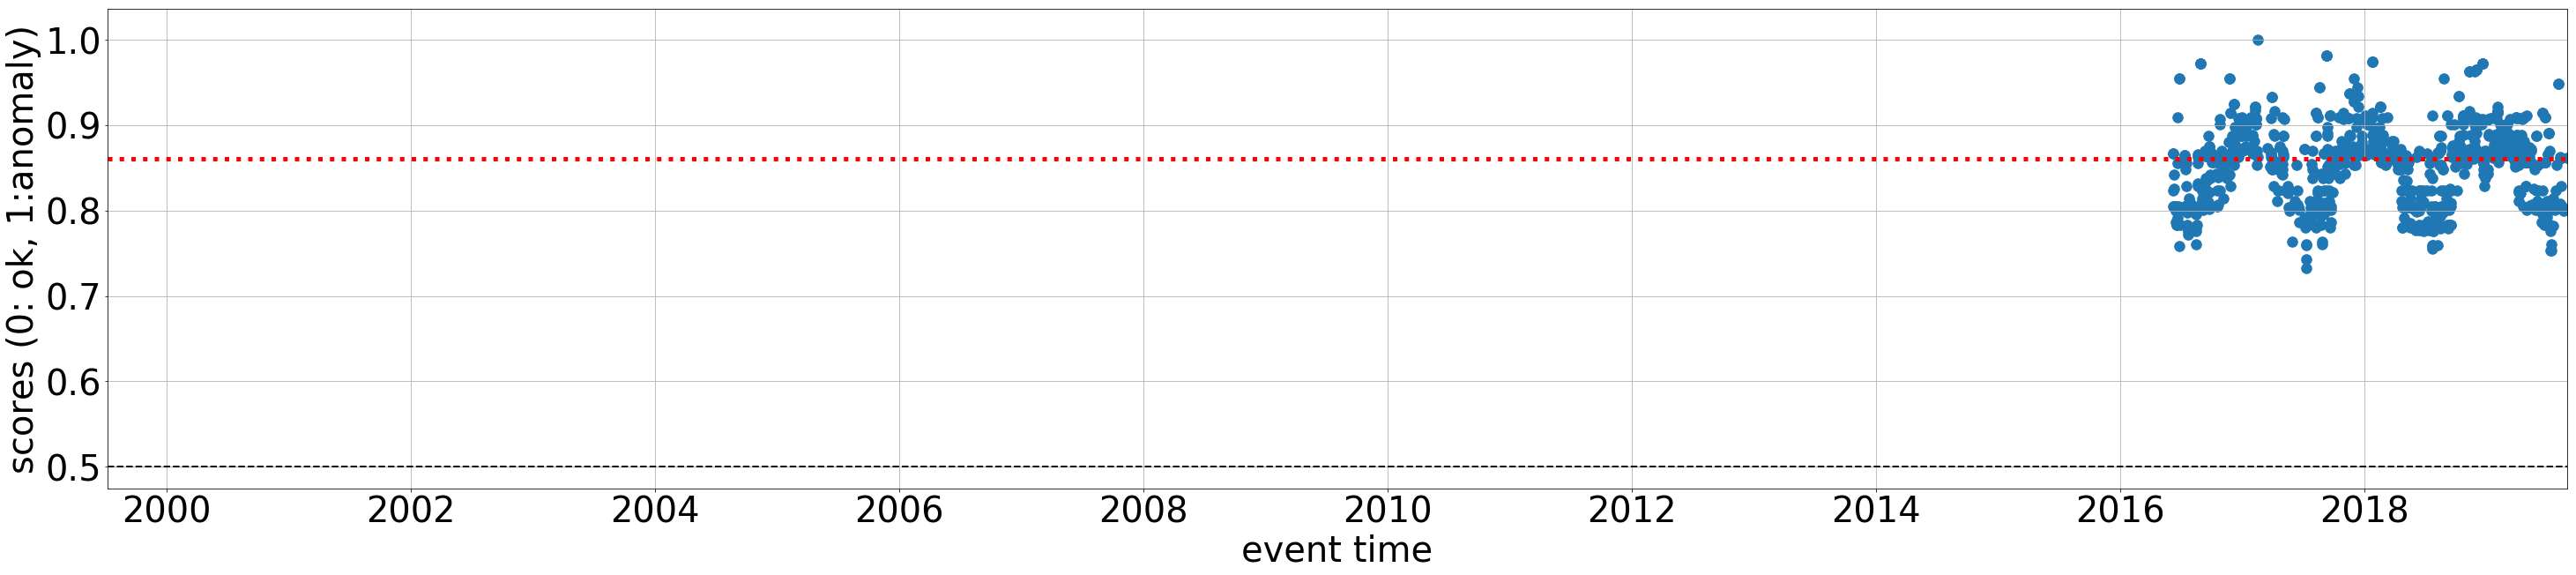

Channel RO.TLB..BH? (database: me, station id: 1151). 563 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.860[0] 0.797[1] 0.735[2]


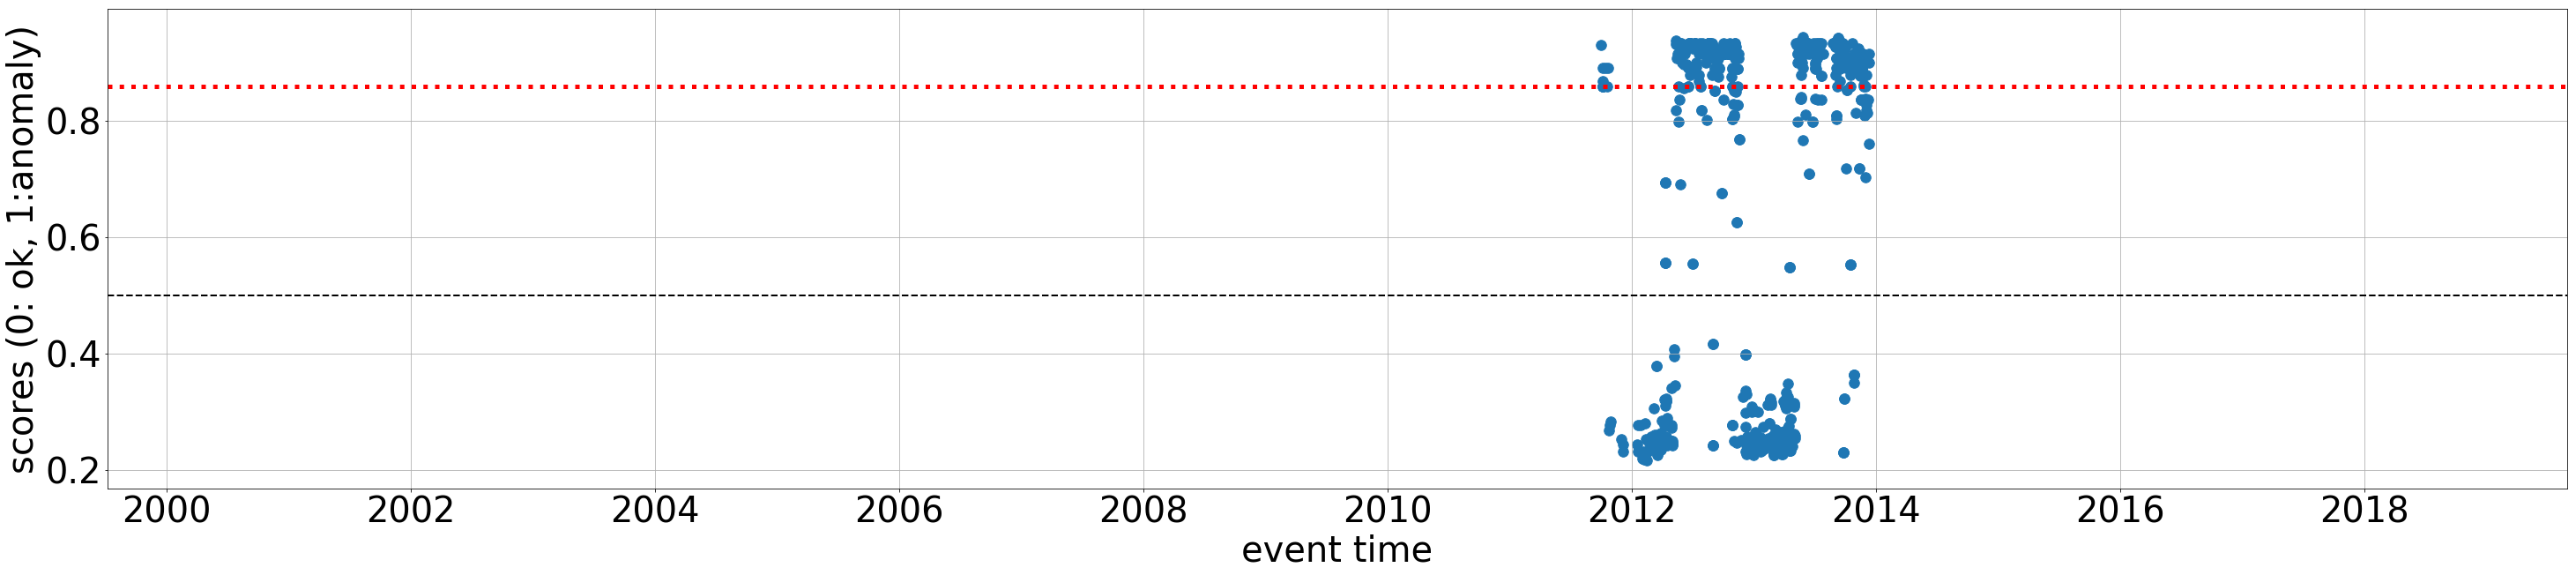

Channel SL.CADS..BH? (database: me, station id: 641). 855 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.762[1] 0.688[2]


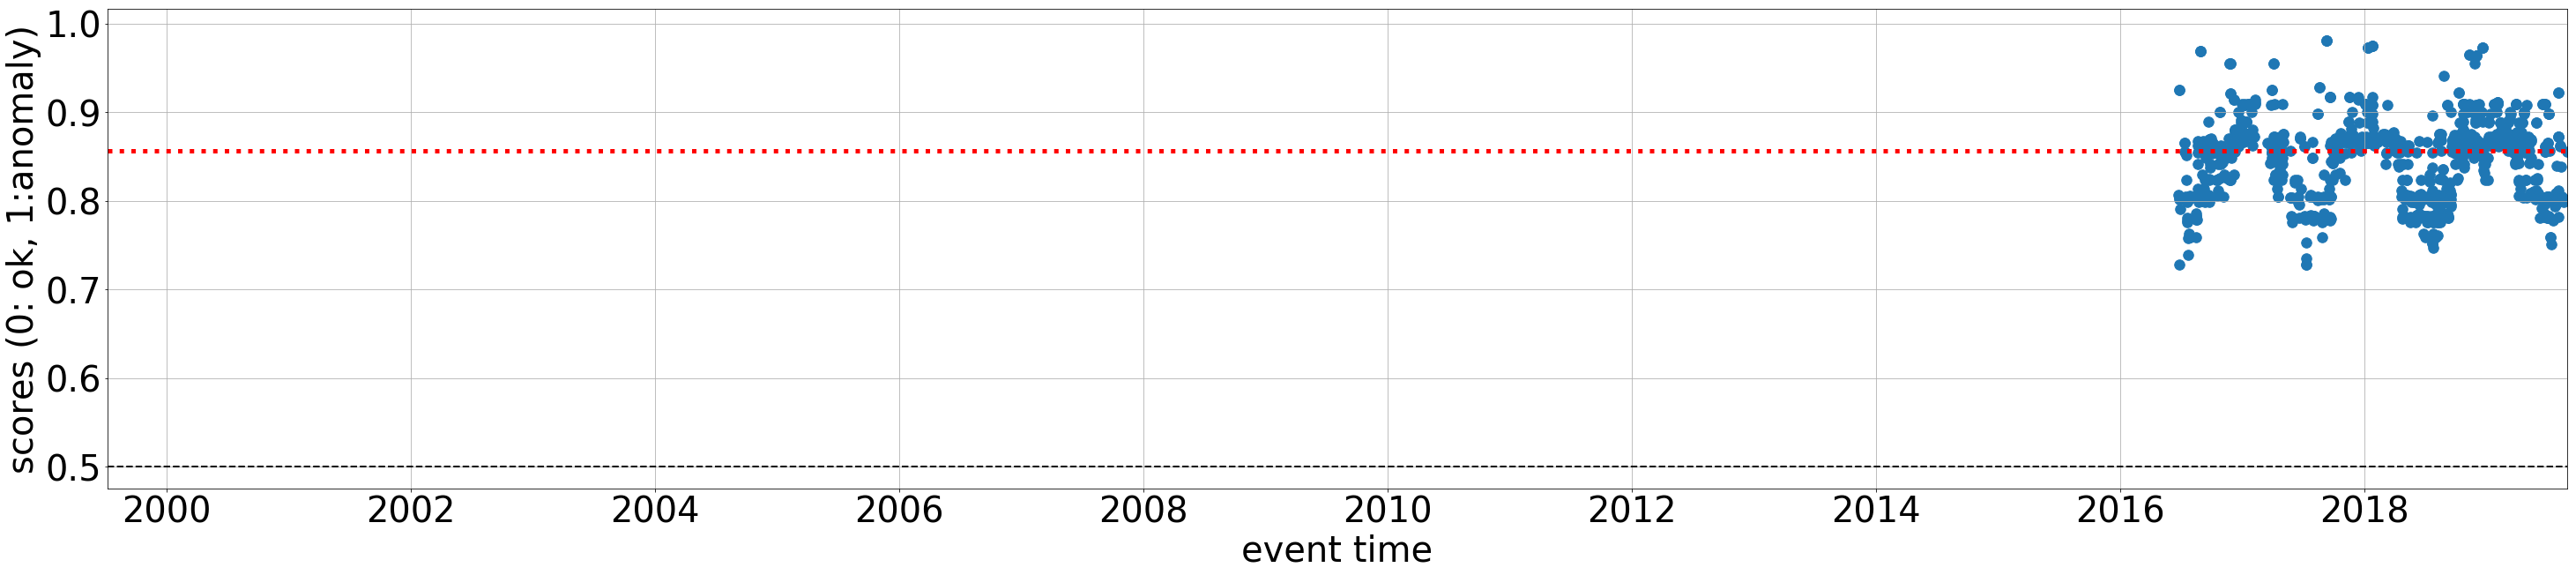

Channel SL.DOBS..BH? (database: me, station id: 645). 540 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.764[1] 0.689[2]


Channel SL.GORS..BH? (database: me, station id: 650). 1208 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.762[1] 0.688[2]


Channel SL.JAVS..BH? (database: me, station id: 652). 1239 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.762[1] 0.688[2]


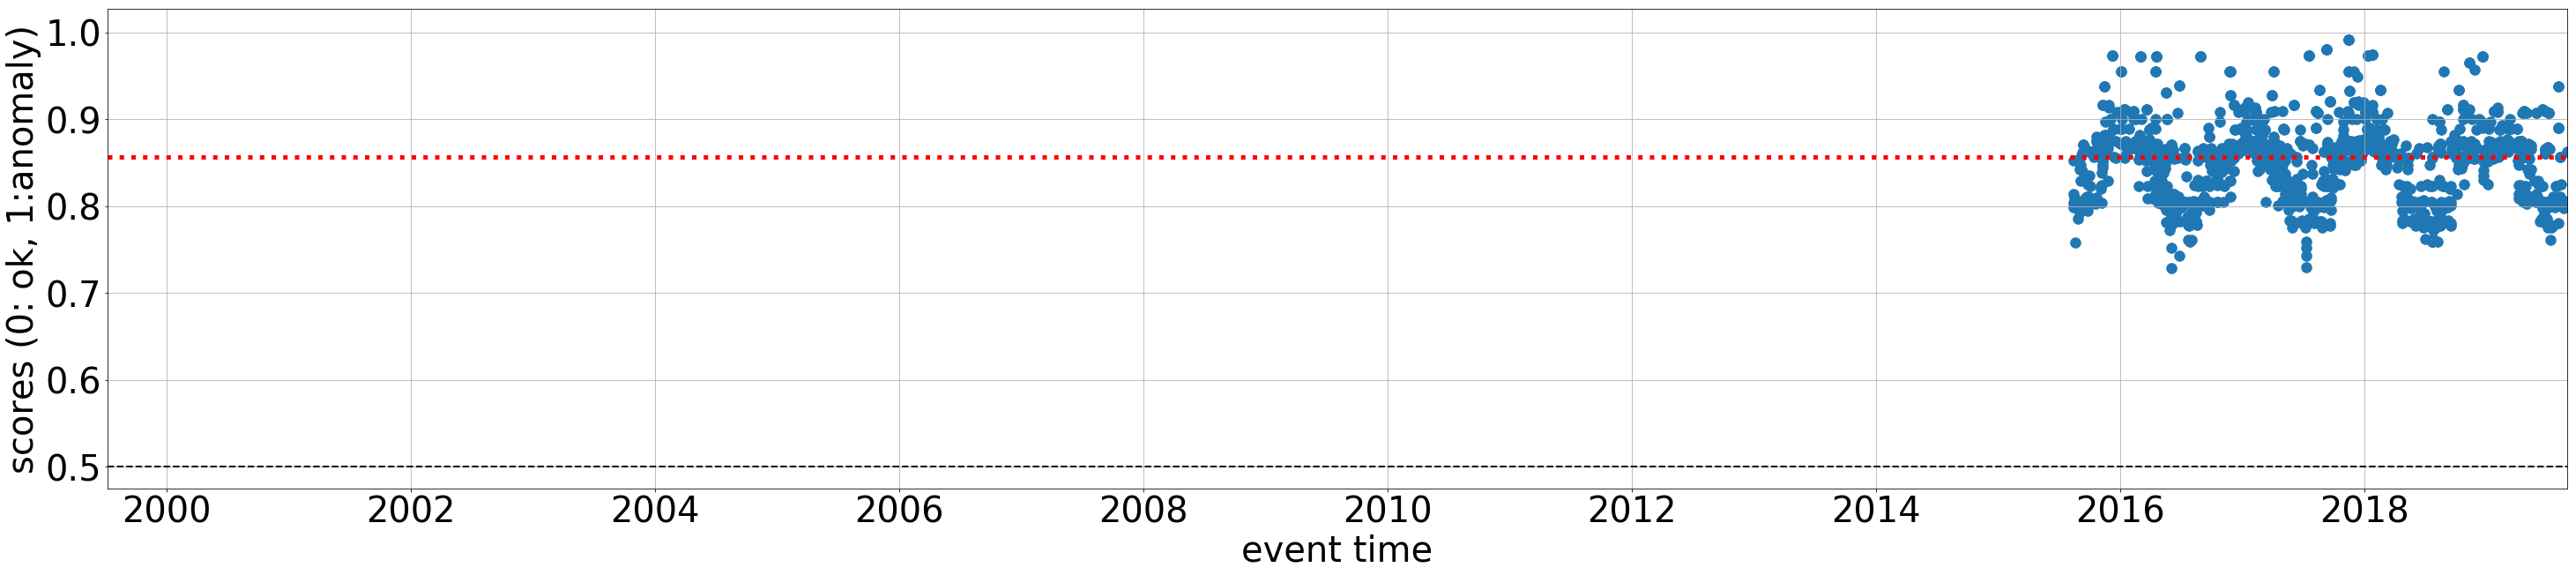

Channel SL.KNDS..BH? (database: me, station id: 653). 1312 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.762[1] 0.690[2]


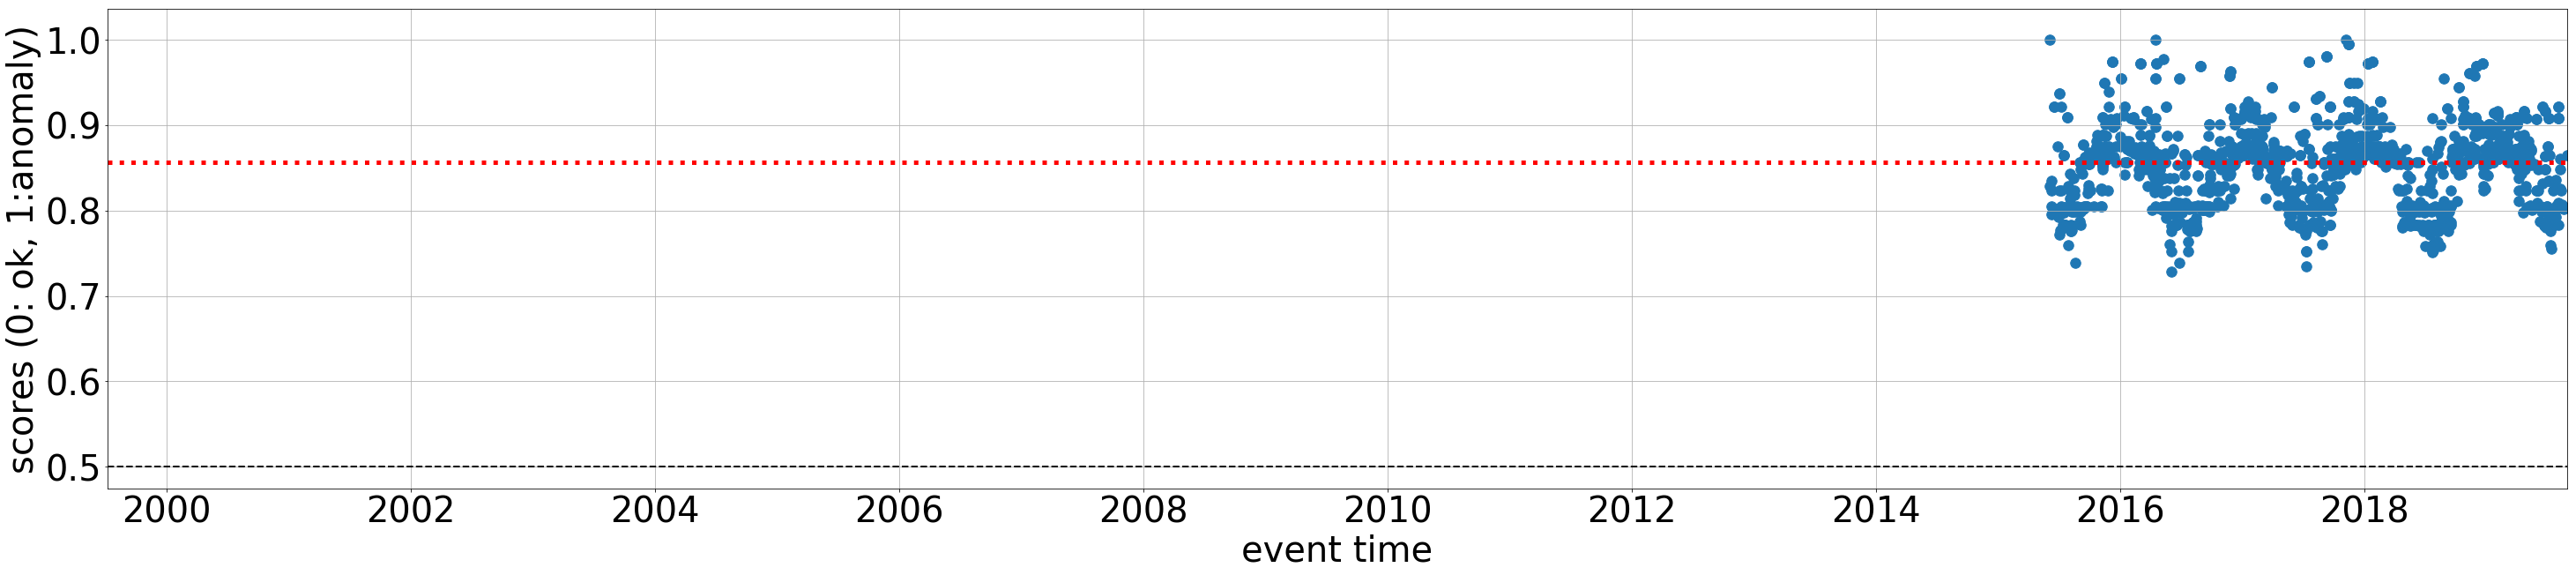

Channel SL.VISS..BH? (database: me, station id: 661). 733 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.763[1] 0.690[2]


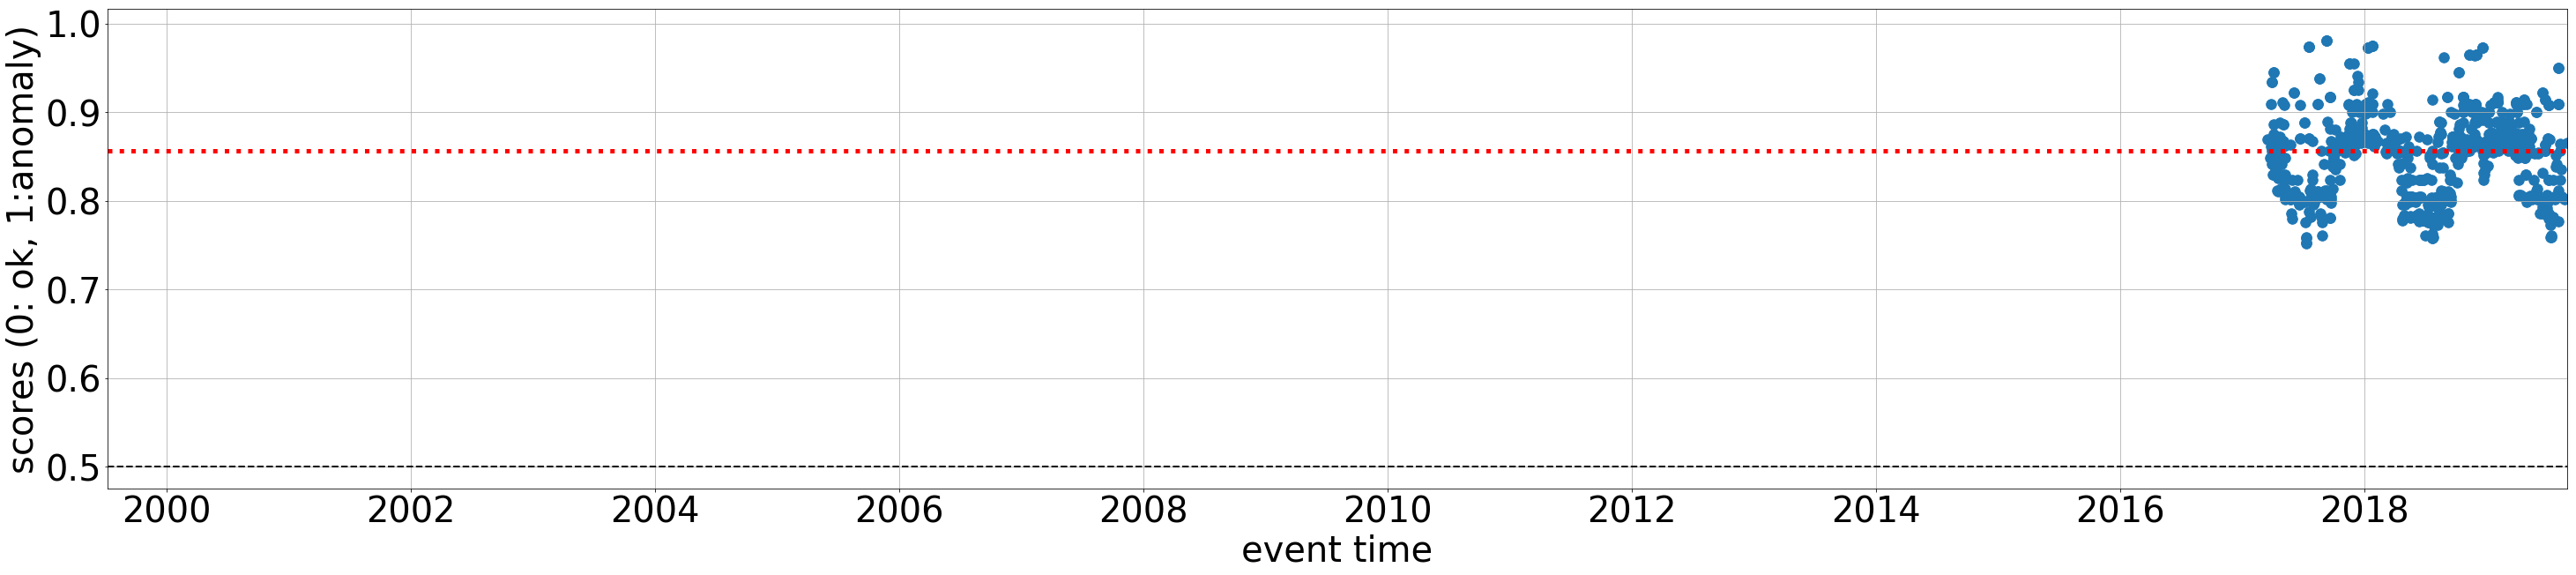

Channel SL.CRES..BH? (database: me, station id: 643). 1121 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.759[1] 0.688[2]


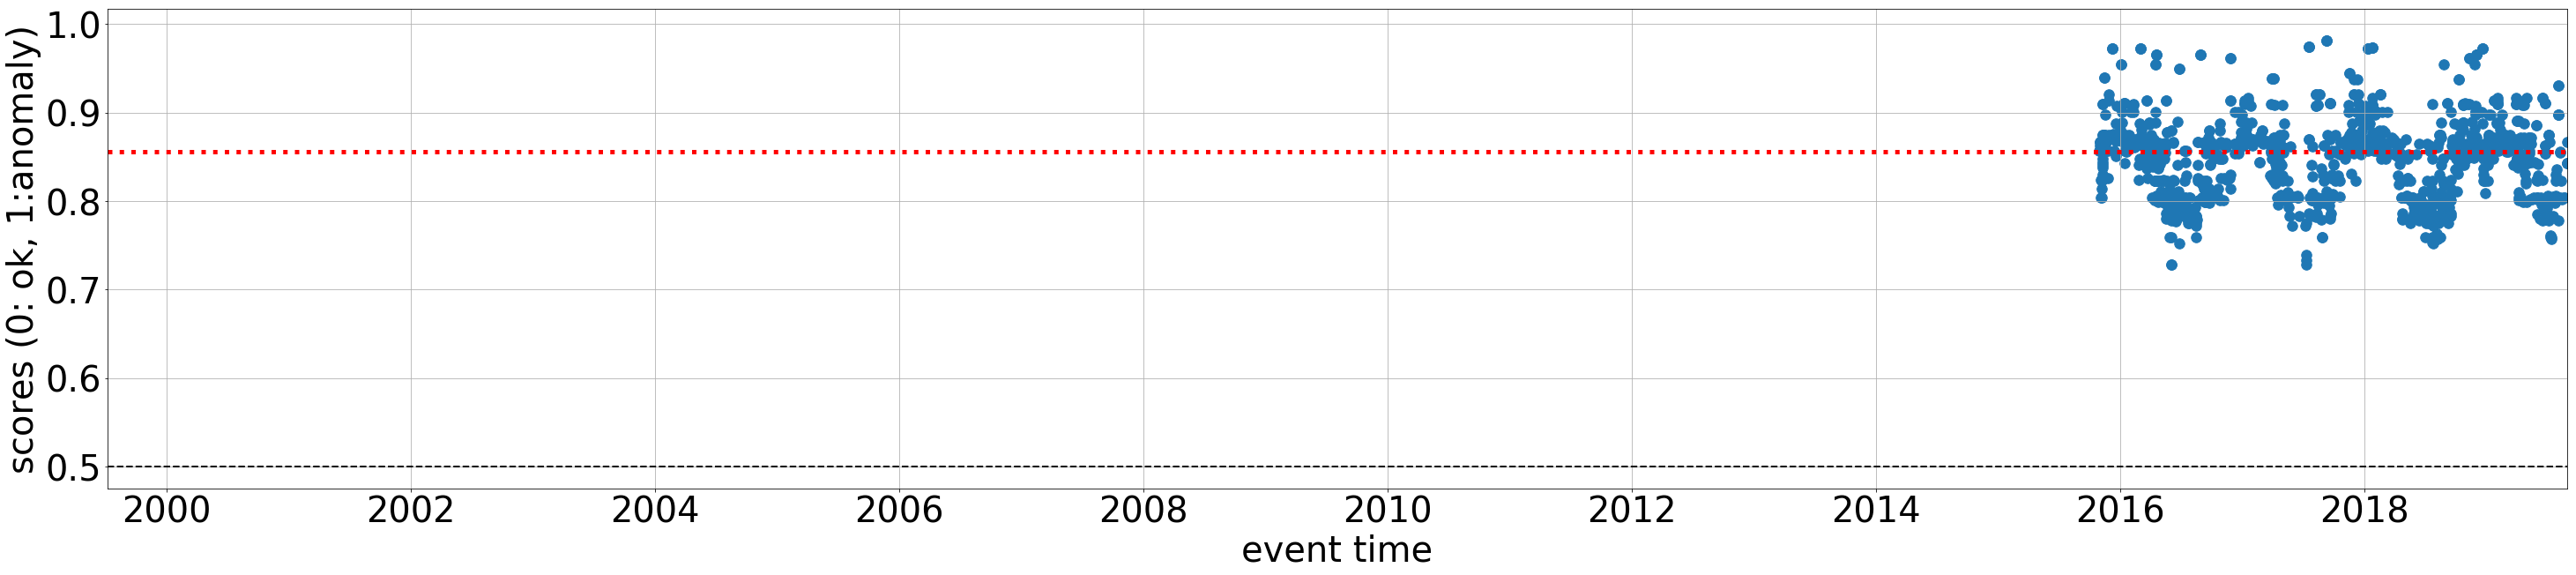

Channel SL.PERS..BH? (database: me, station id: 658). 763 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.762[1] 0.688[2]


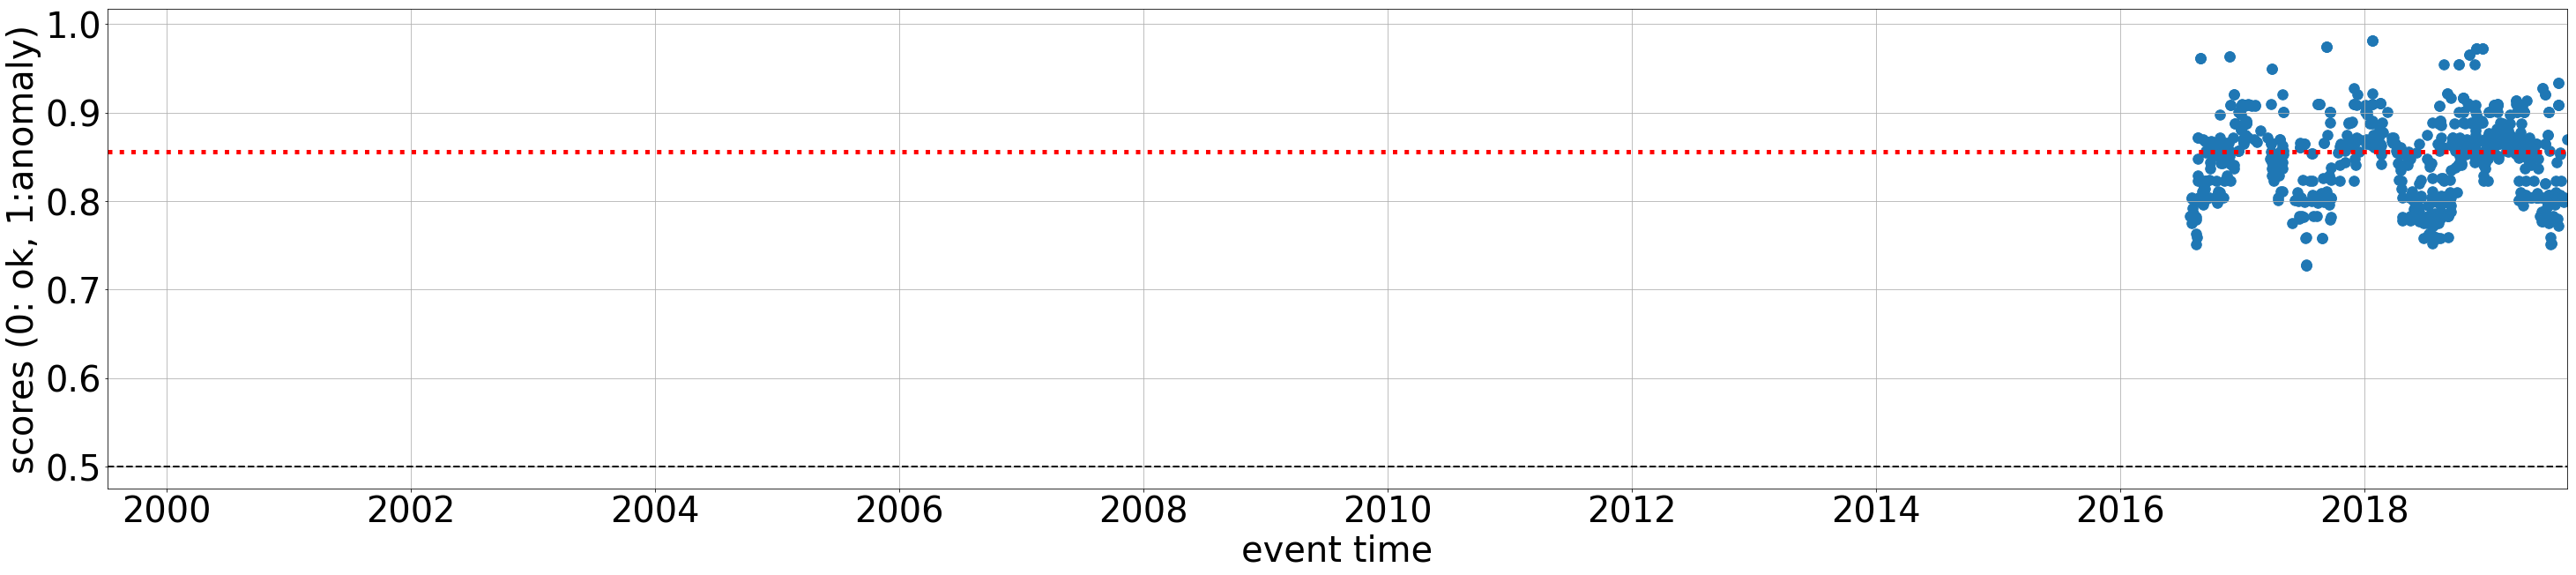

Channel SL.ZAVS..BH? (database: me, station id: 664). 237 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.856[0] 0.761[1] 0.688[2]


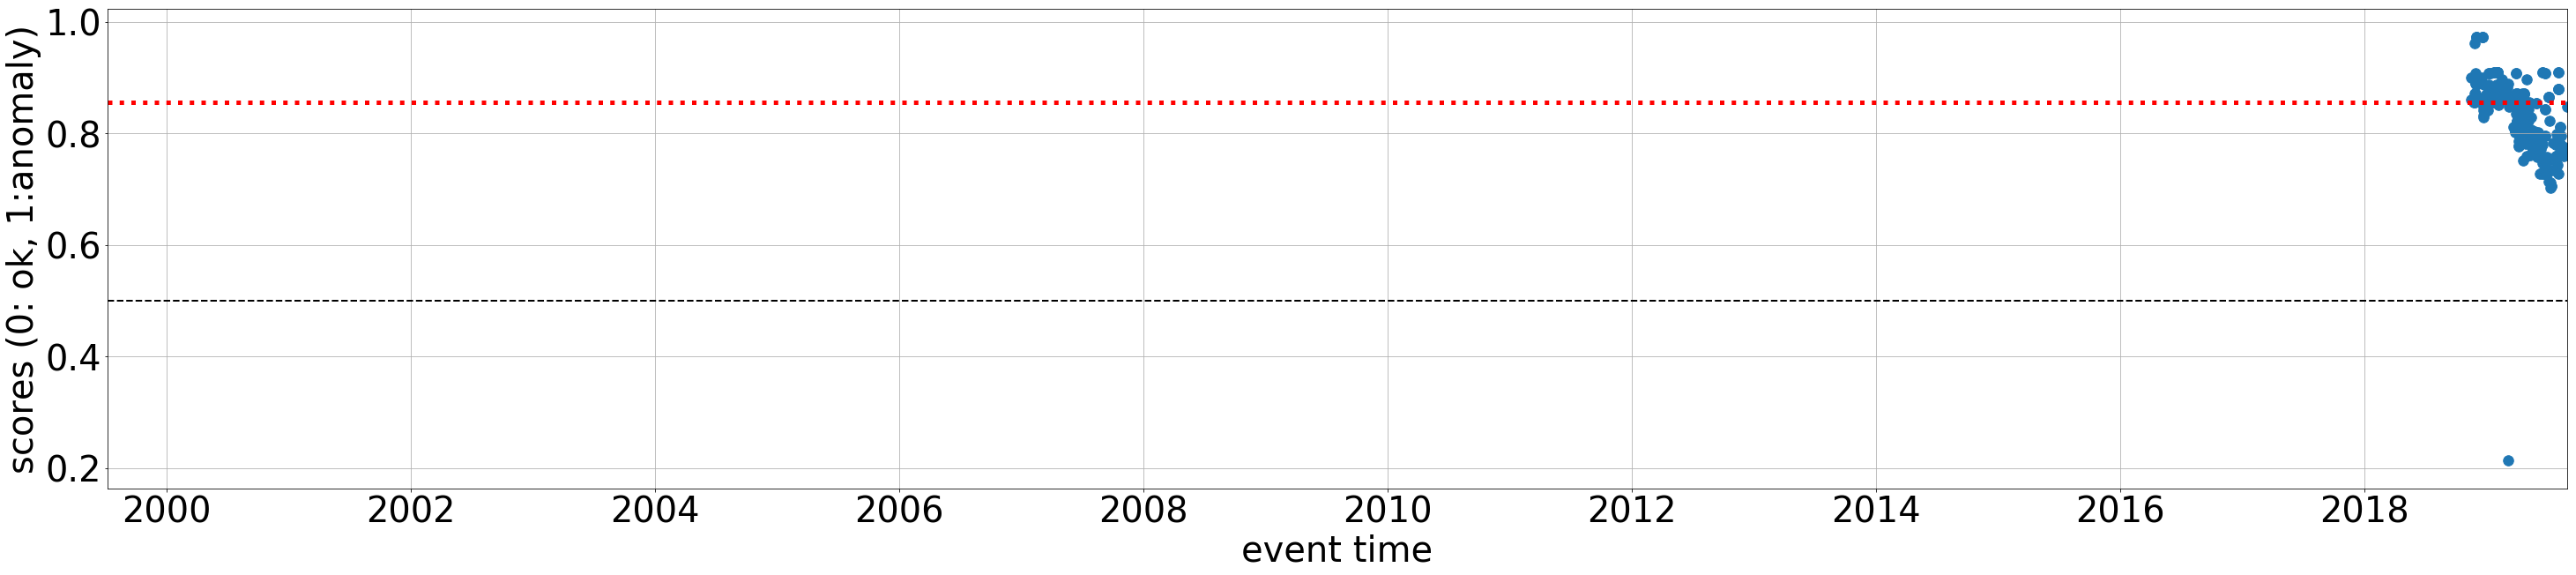

Channel SL.BOJS..BH? (database: me, station id: 640). 1283 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.853[0] 0.756[1] 0.684[2]


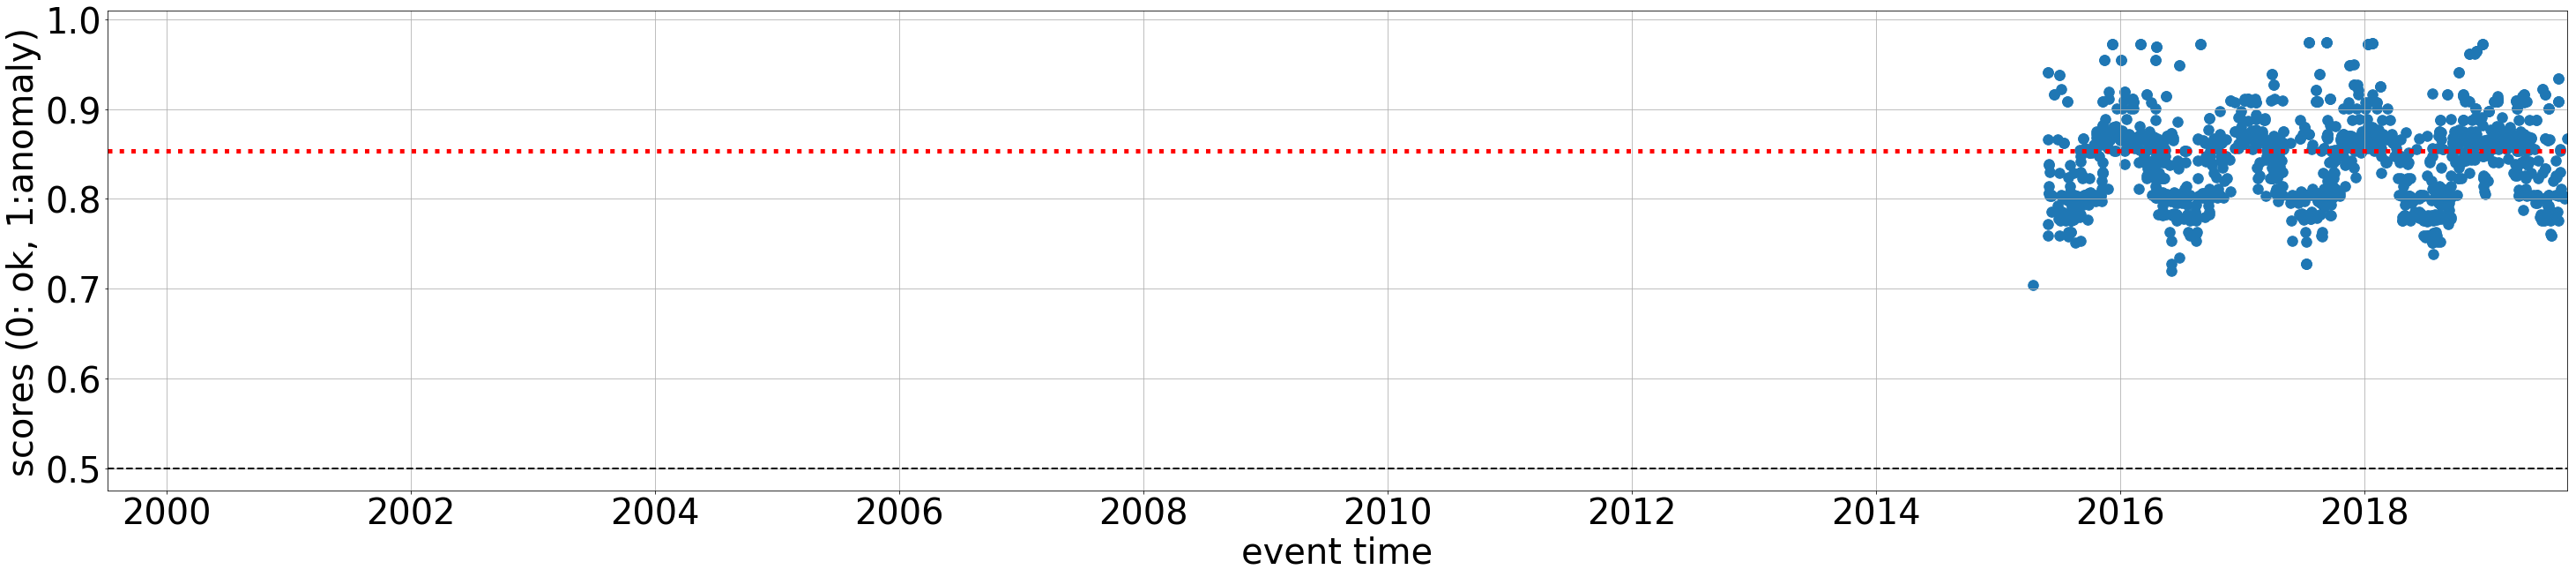

Channel SL.SKDS..BH? (database: me, station id: 660). 1222 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.843[0] 0.752[1] 0.683[2]


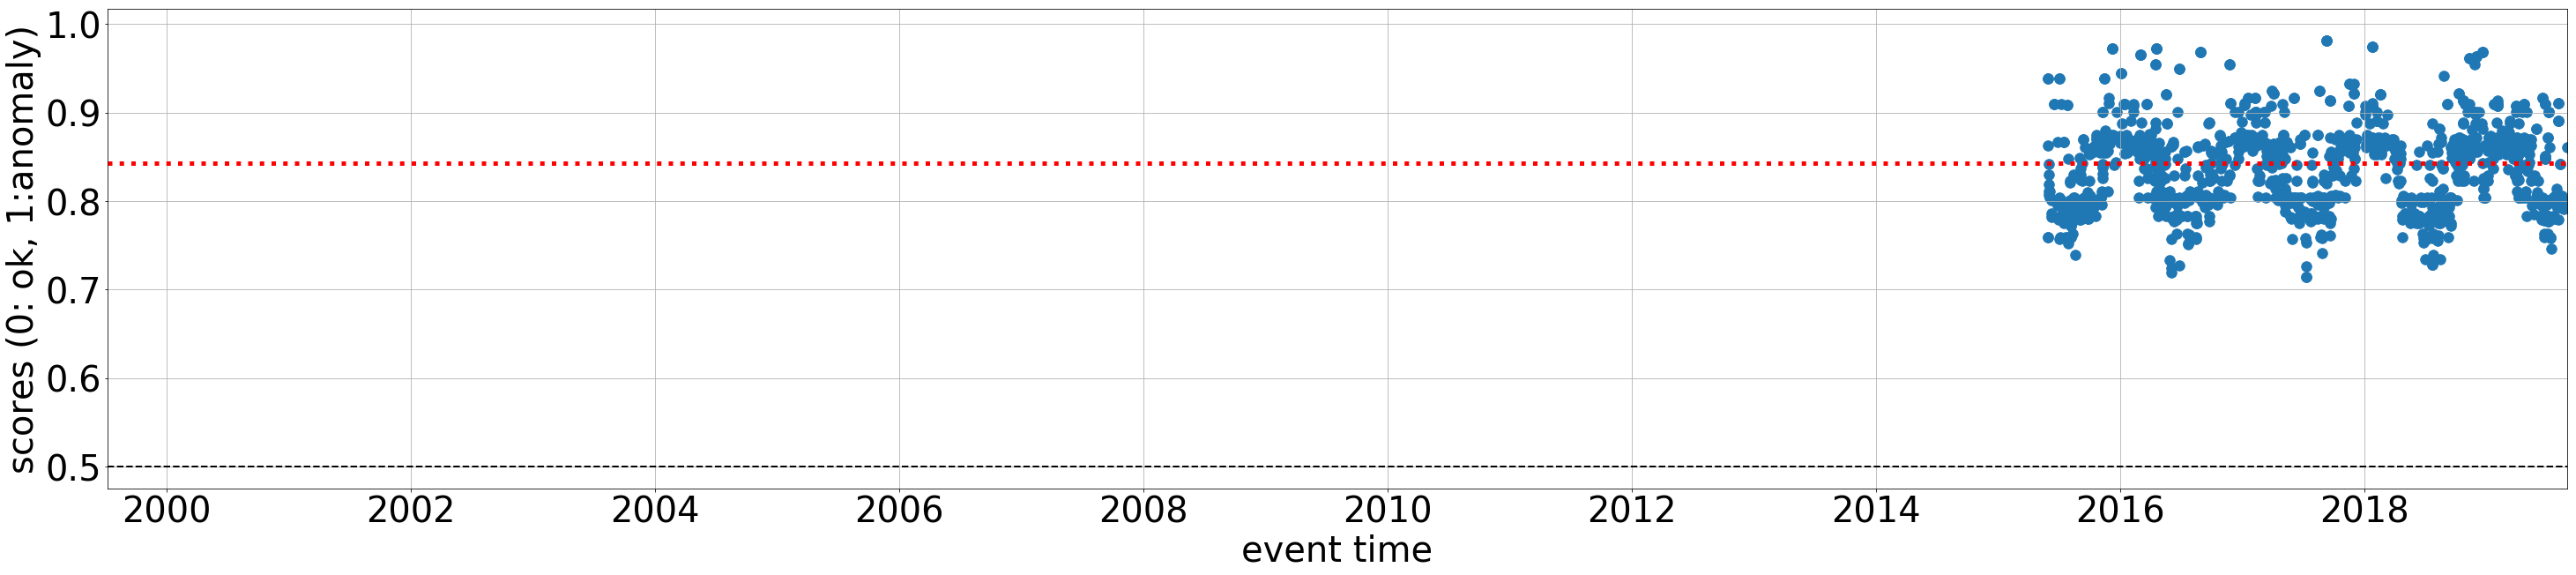

Channel IV.MABI..BH? (database: me, station id: 110). 484 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.841[0] 0.777[1] 0.732[2]


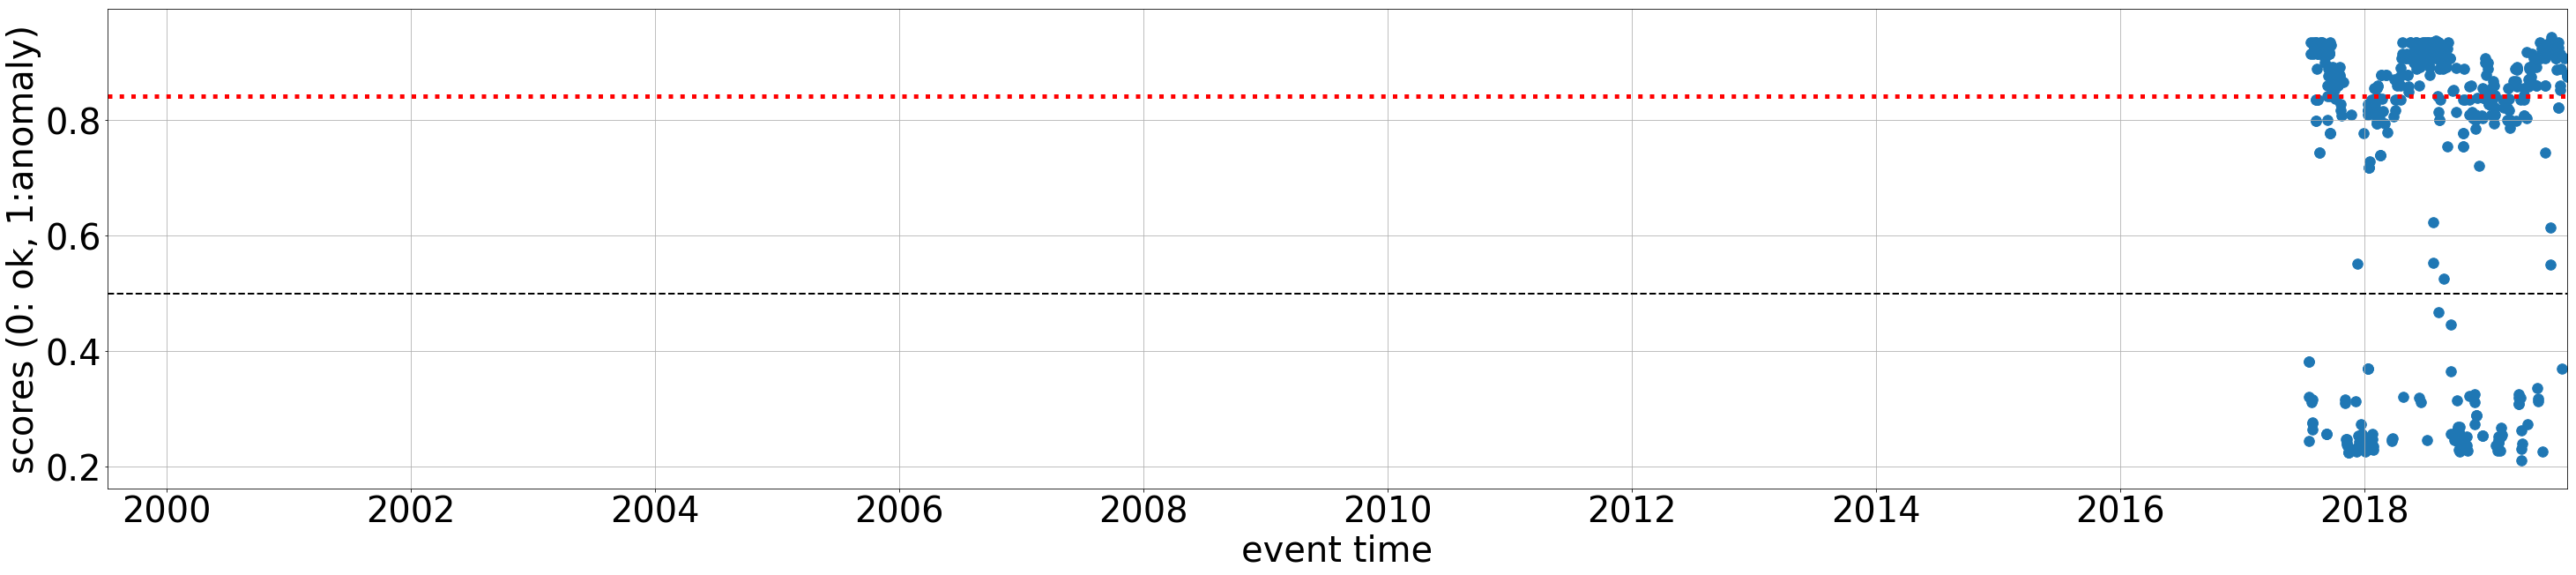

Channel KO.BAYT..BH? (database: me, station id: 372). 2107 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.841[0] 0.777[1] 0.730[2]


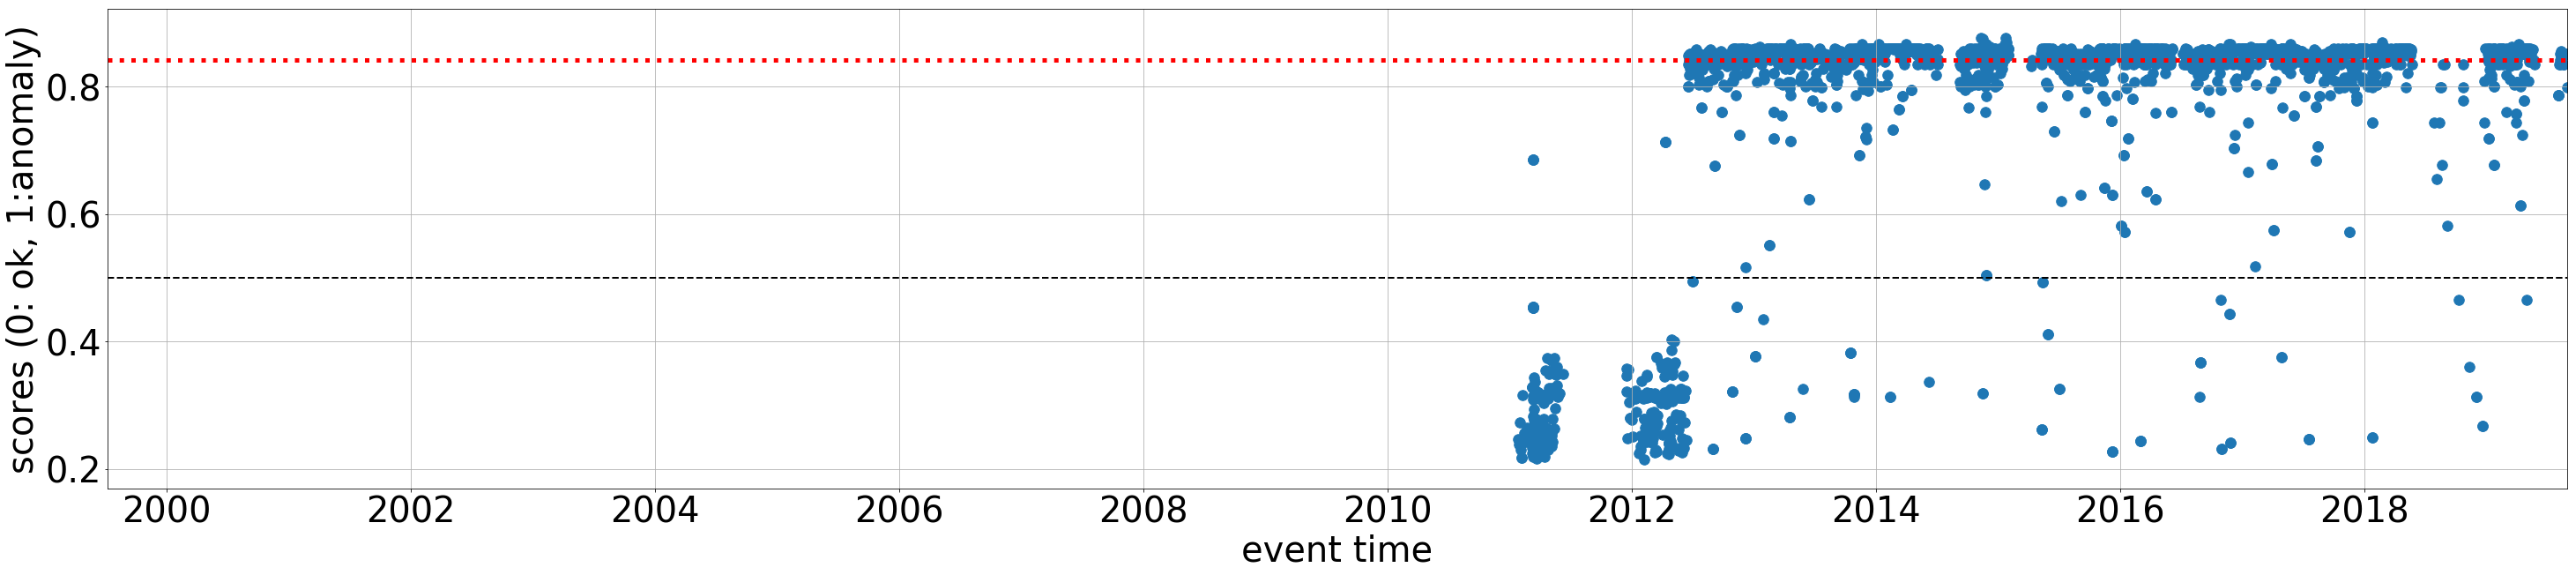

Channel II.RAYN.00.BH? (database: me, station id: 538). 1691 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.839[0] 0.777[1] 0.732[2]


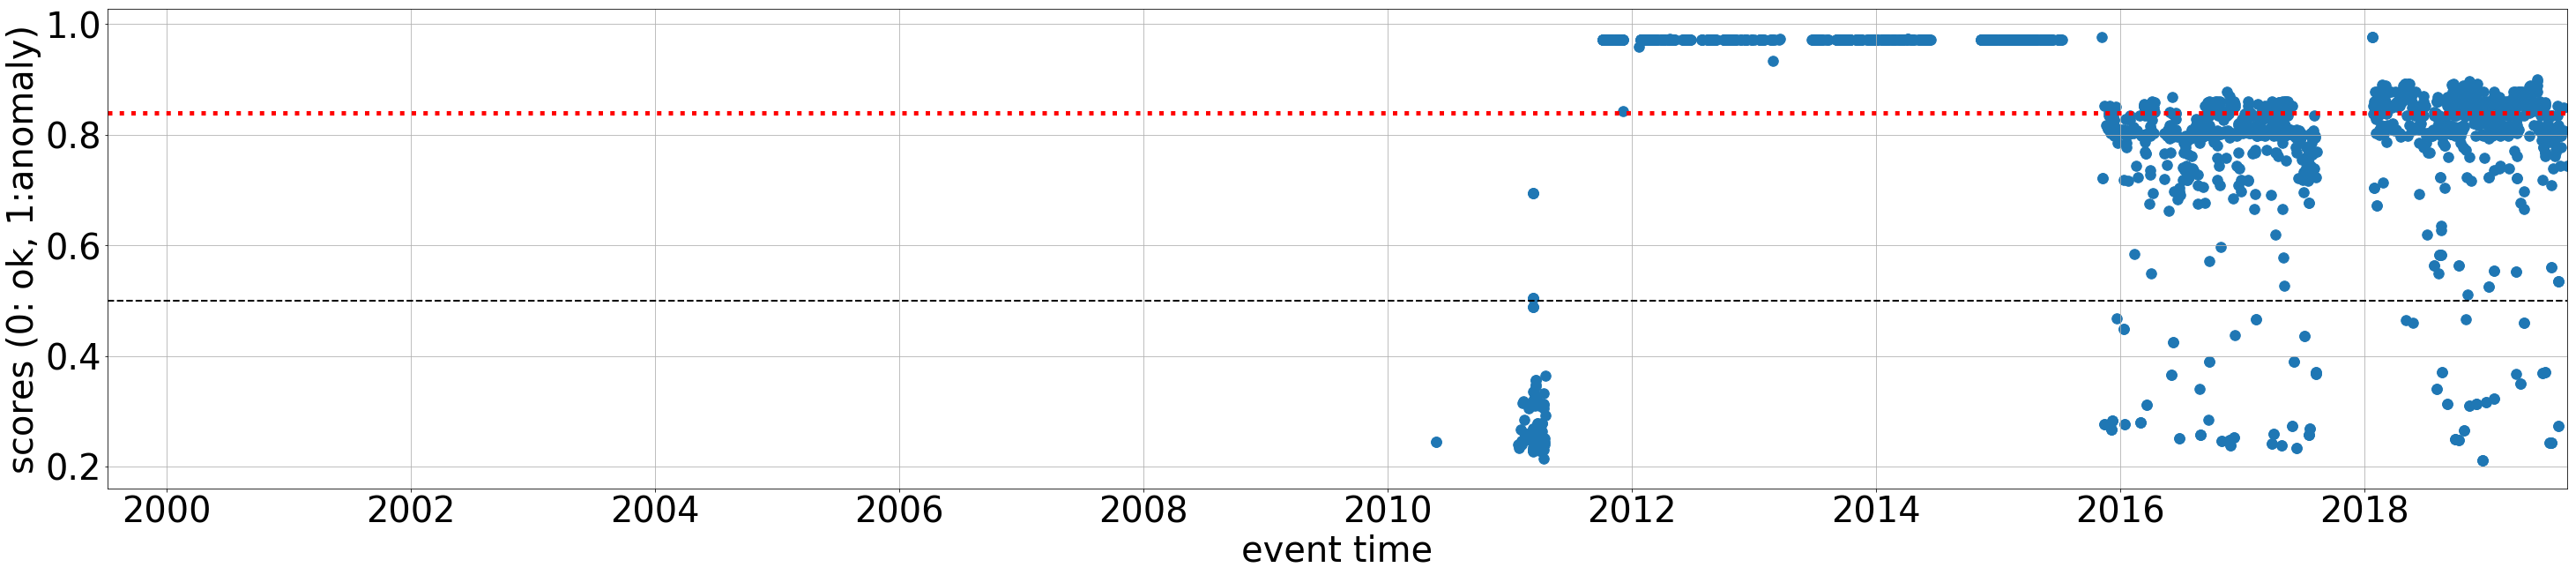

Channel XW.W13.00.BH? (database: s2s_2019_03, station id: 2447). 10 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.837[0] 0.765[1] 0.712[2]


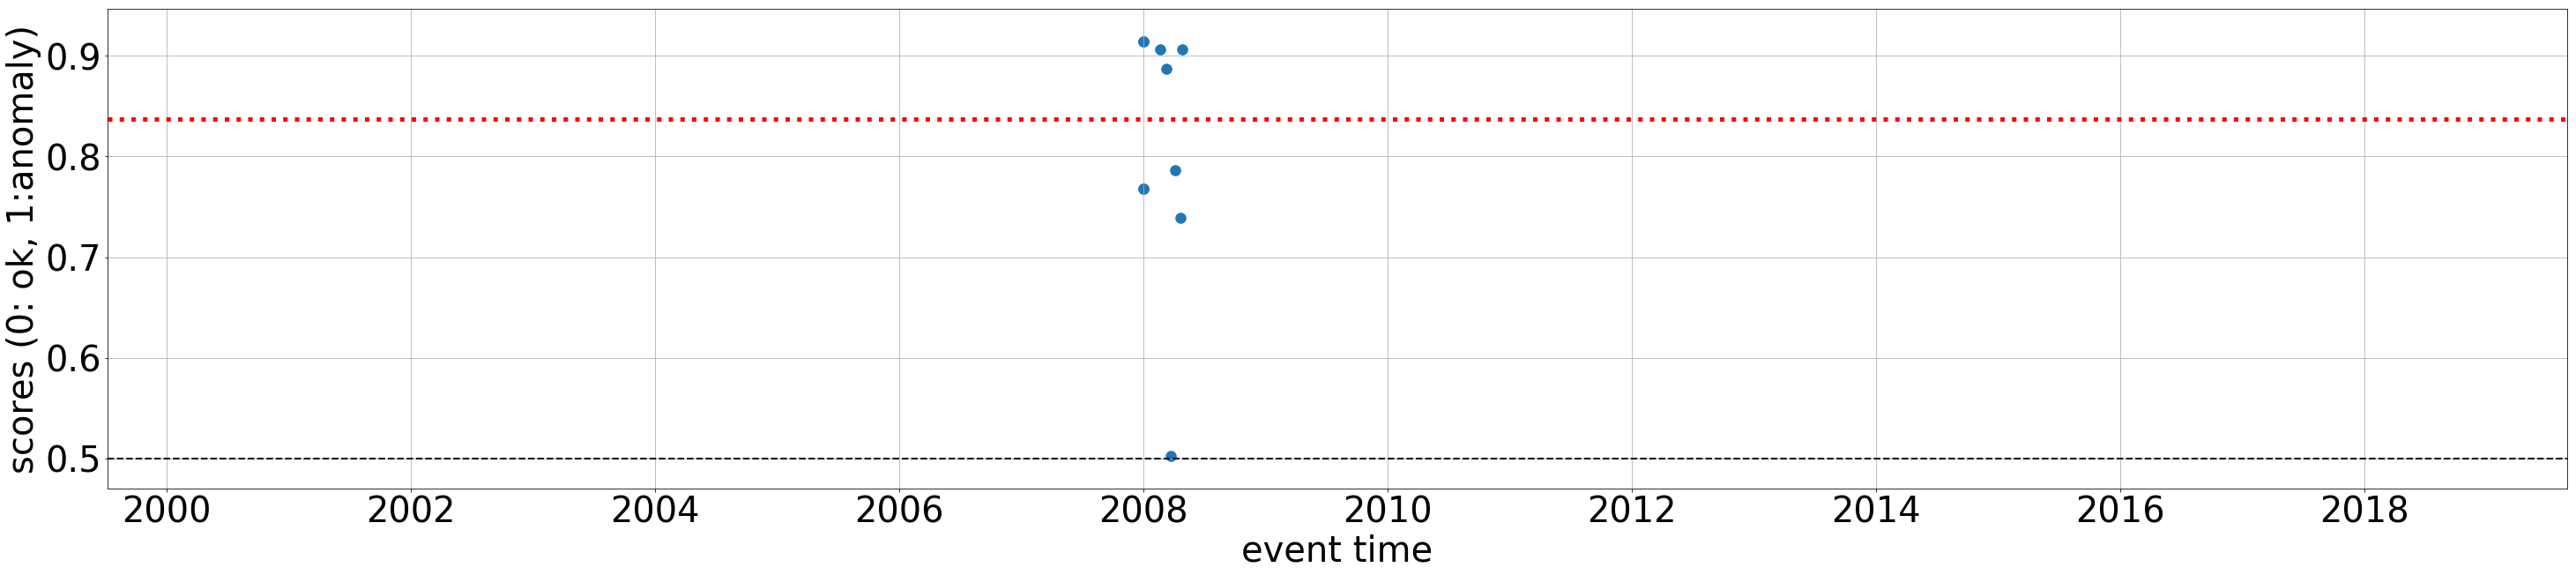

Channel AF.KAD..BH? (database: me, station id: 1428). 33 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.809[0] 0.754[1] 0.708[2]


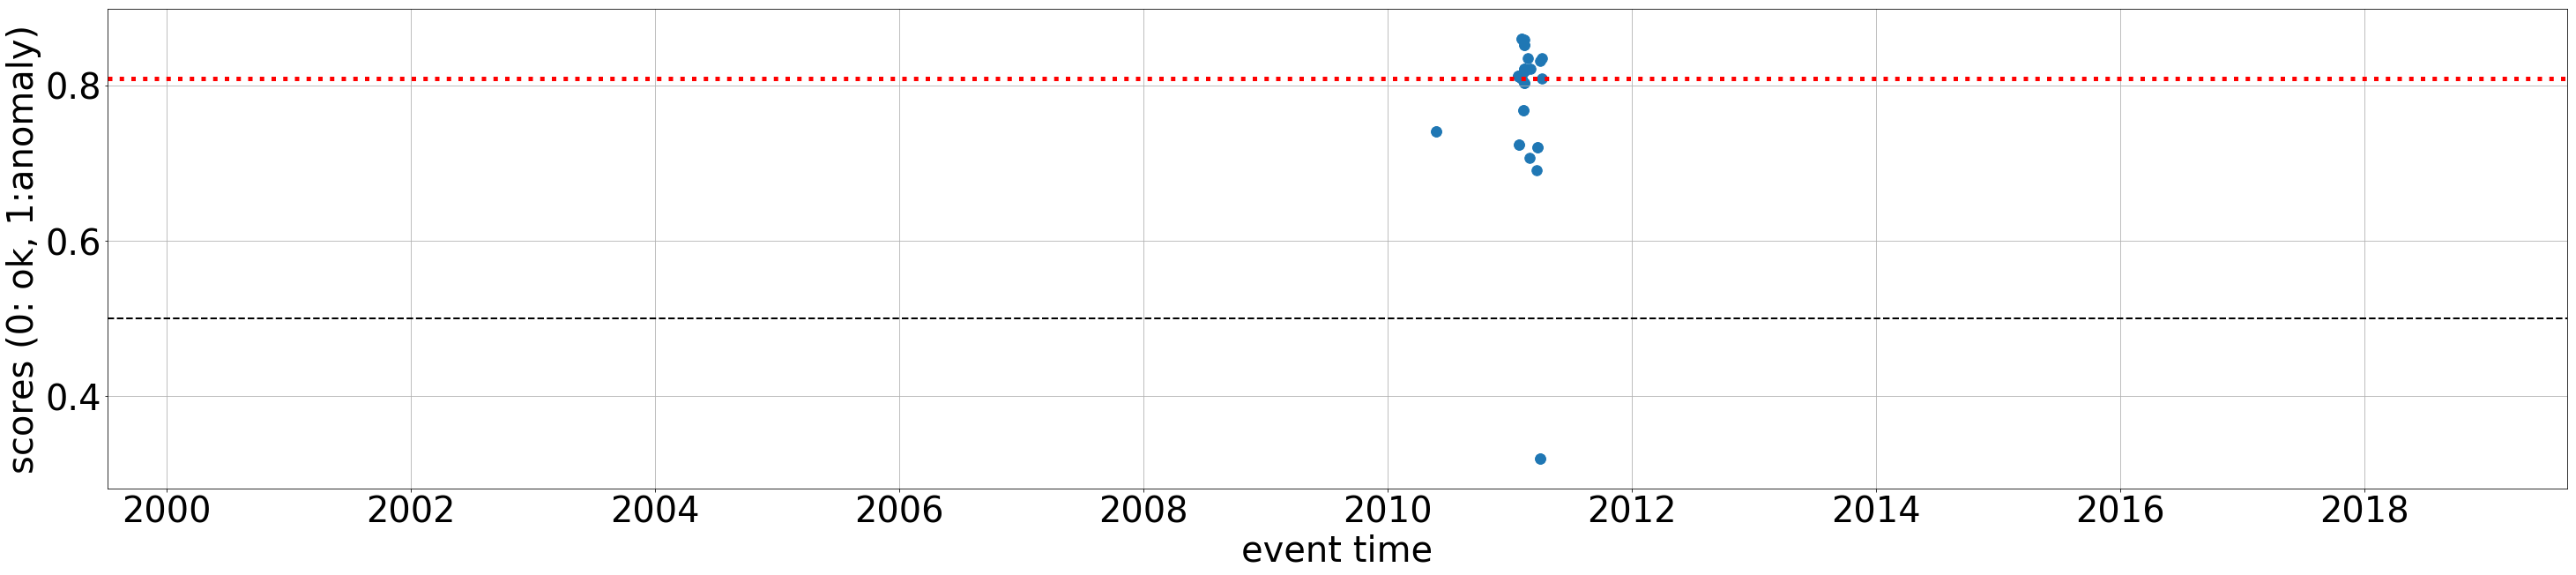

Channel UK.FULS..BH? (database: me, station id: 3541). 65 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.804[0] 0.704[1] 0.660[2]


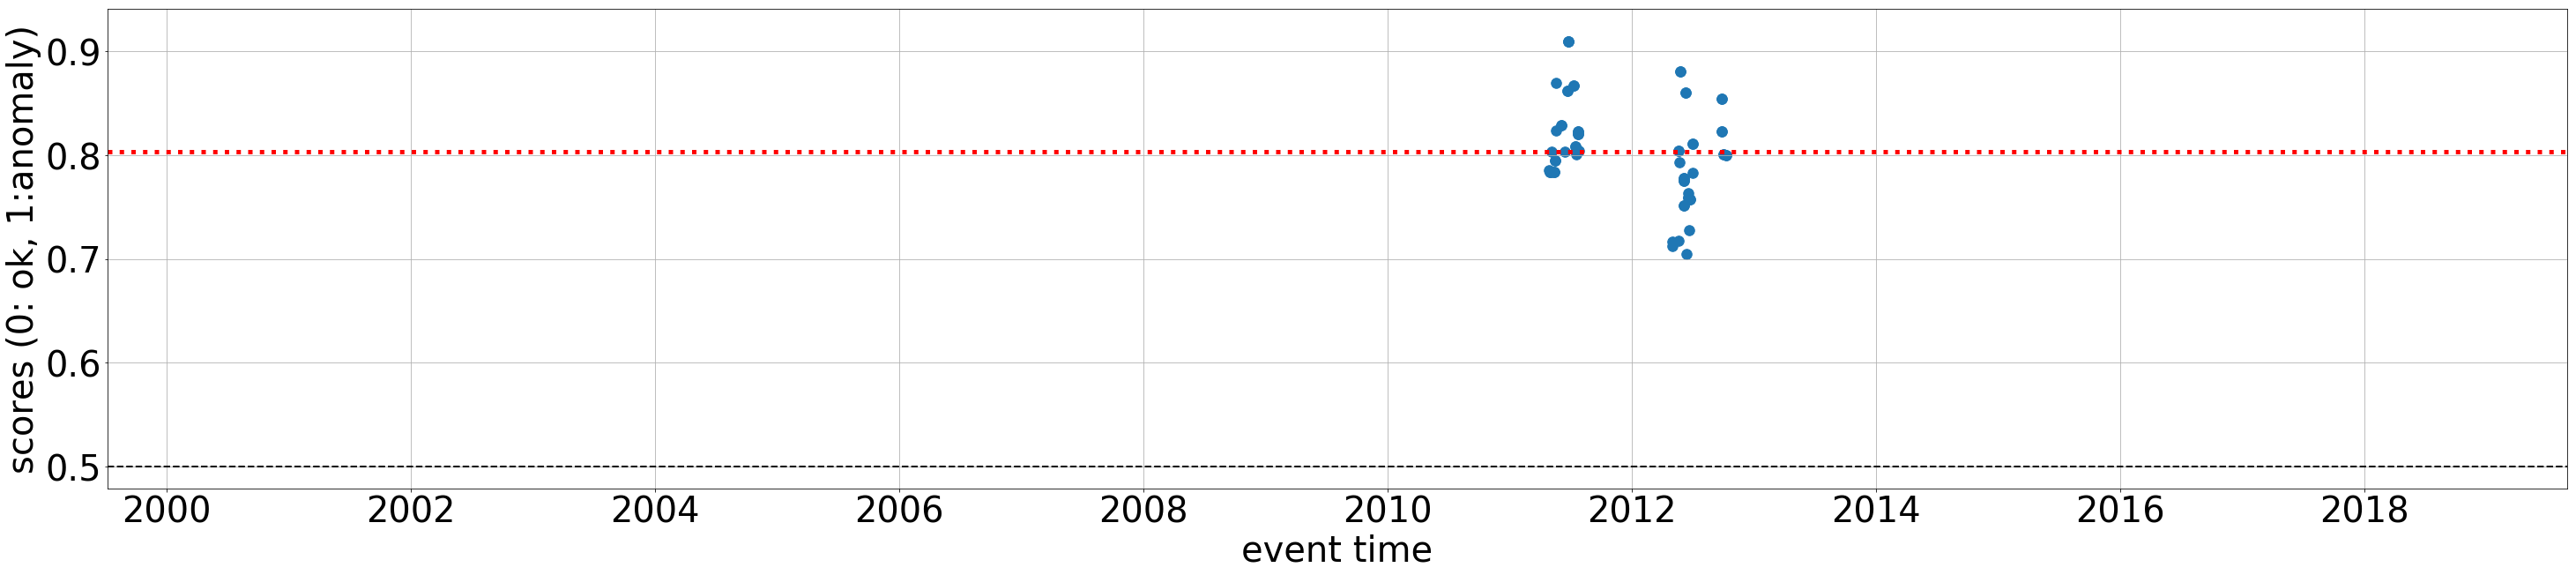

Channel IS.MMA0B..BH? (database: me, station id: 1015). 1706 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.798[0] 0.727[1] 0.680[2]


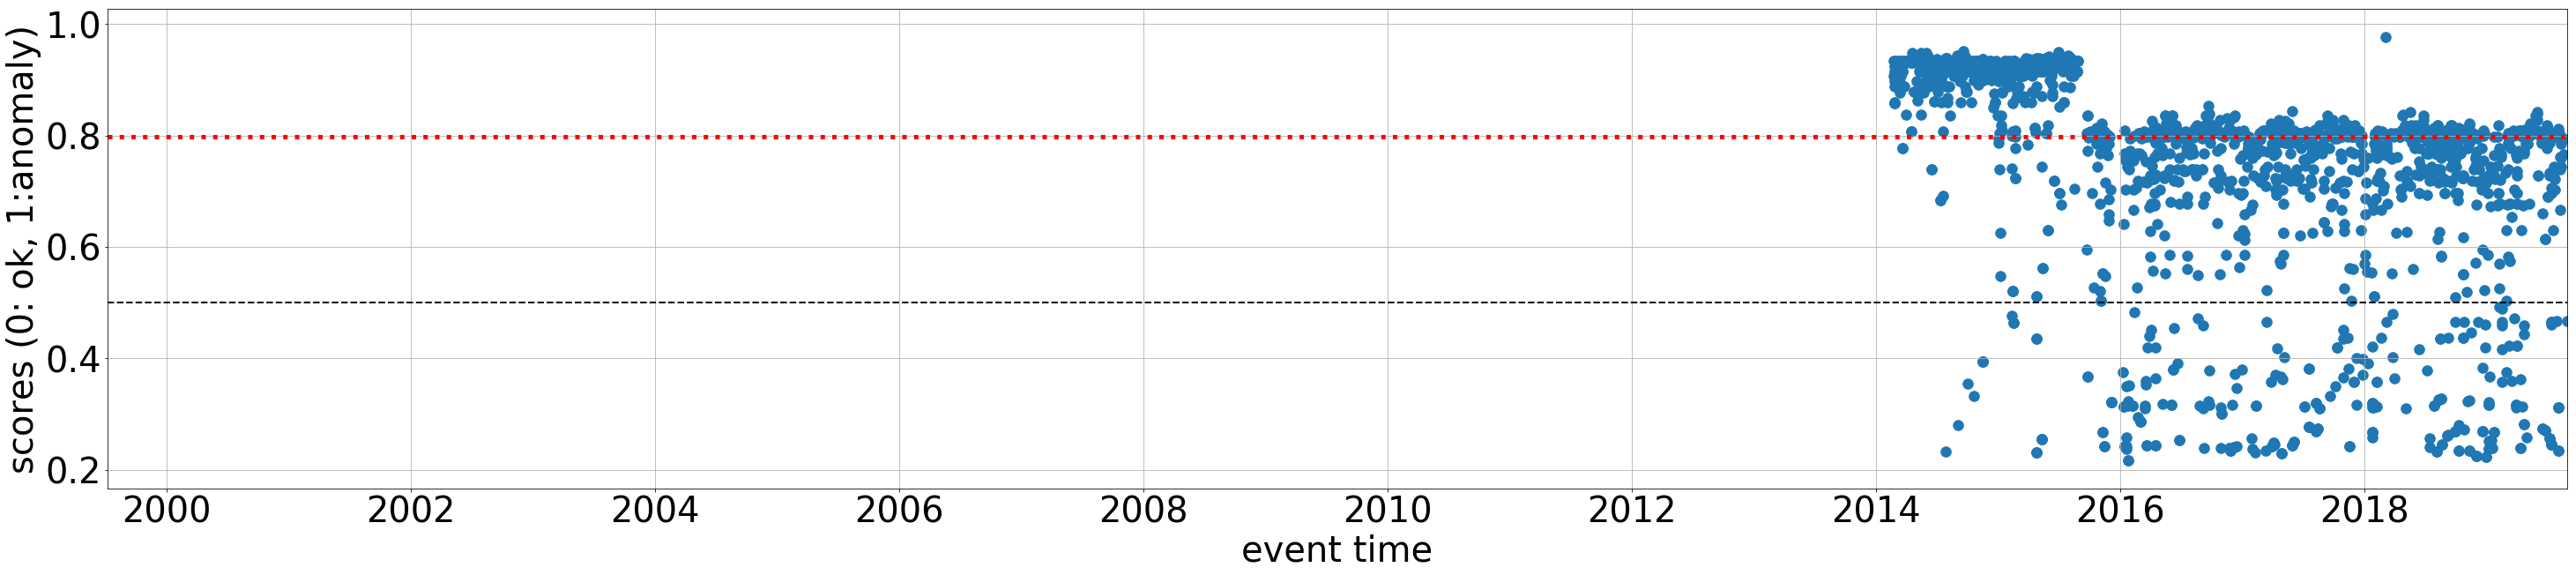

Channel RD.FLAF..BH? (database: me, station id: 1342). 214 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.794[0] 0.699[1] 0.658[2]


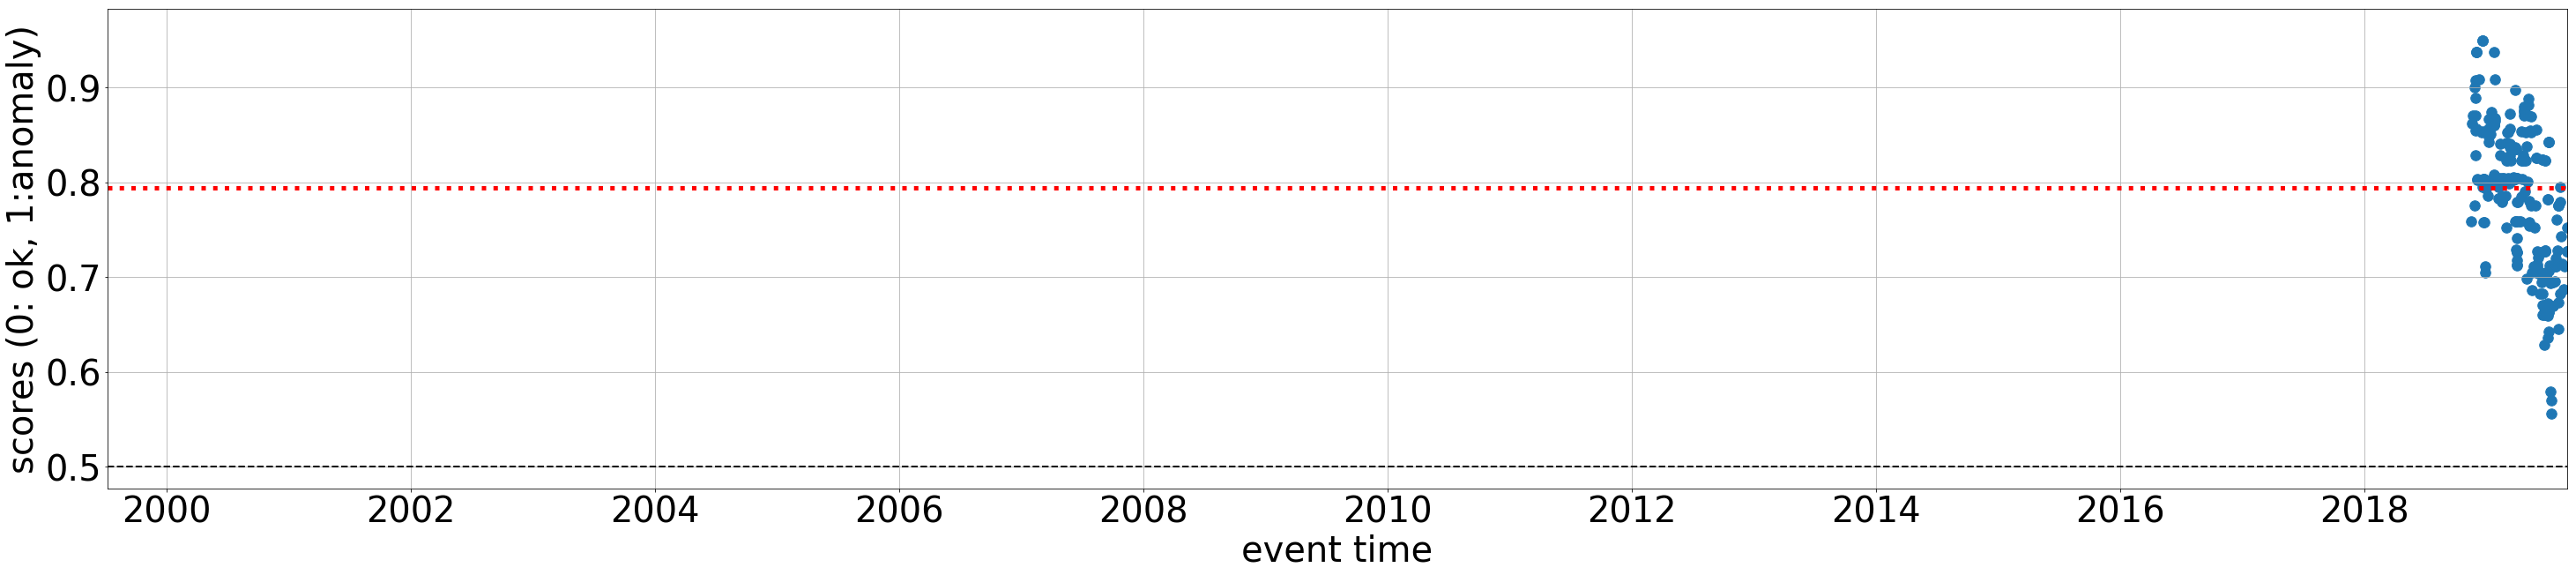

Channel NJ.KAD..BH? (database: me, station id: 2928). 16 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.788[0] 0.720[1] 0.683[2]


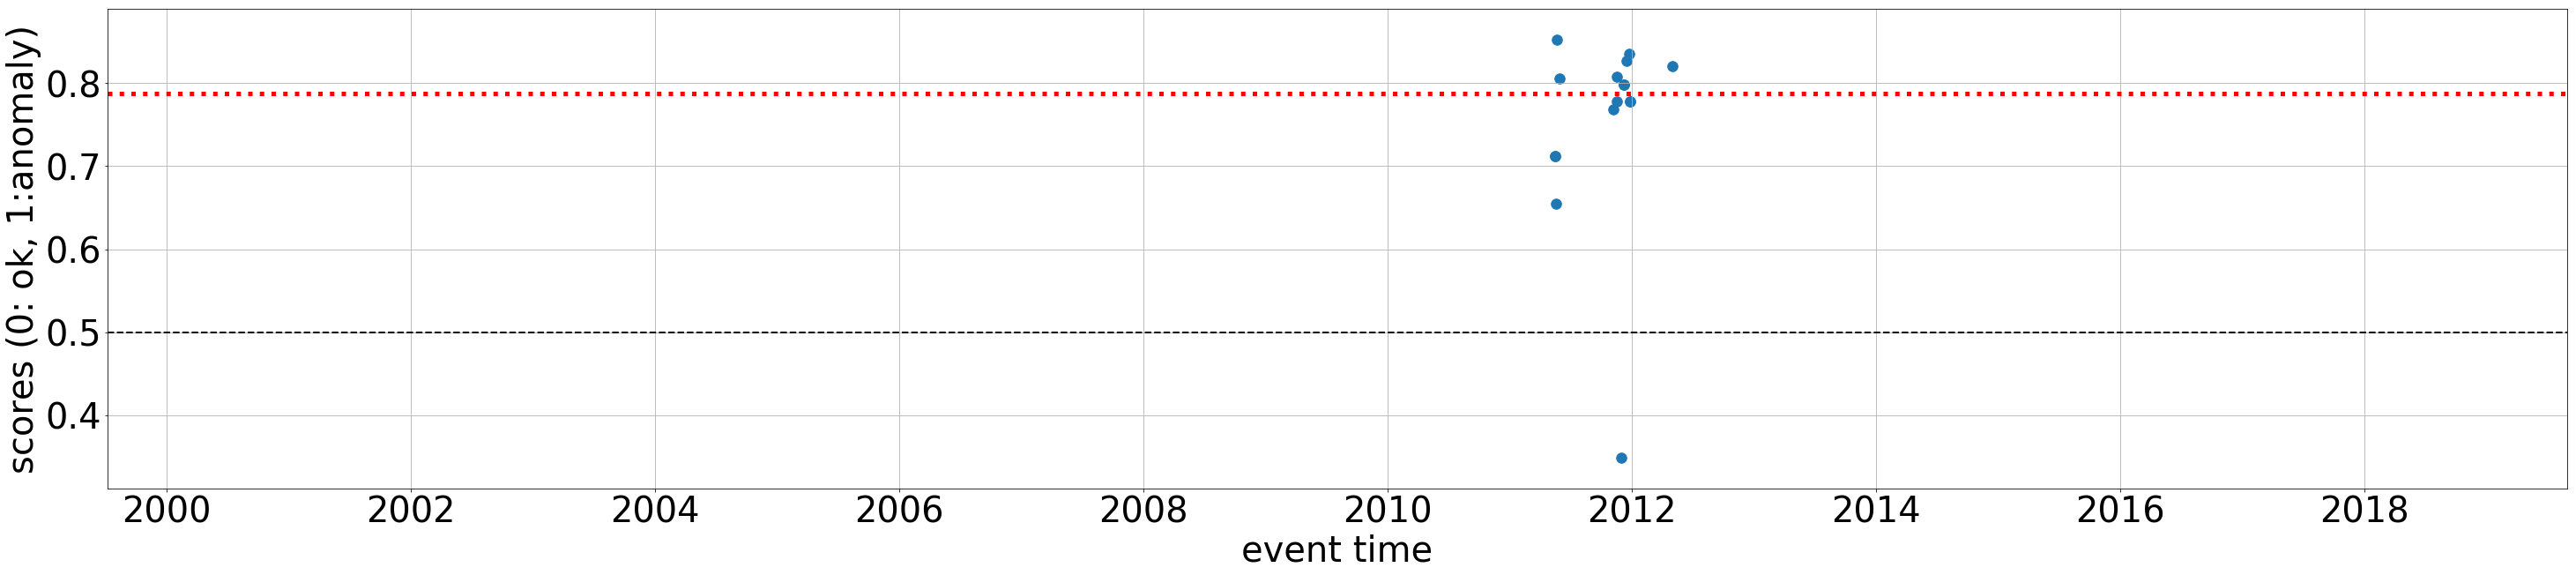

Channel TM.PRAC..BH? (database: me, station id: 3507). 1860 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.780[0] 0.682[1] 0.642[2]


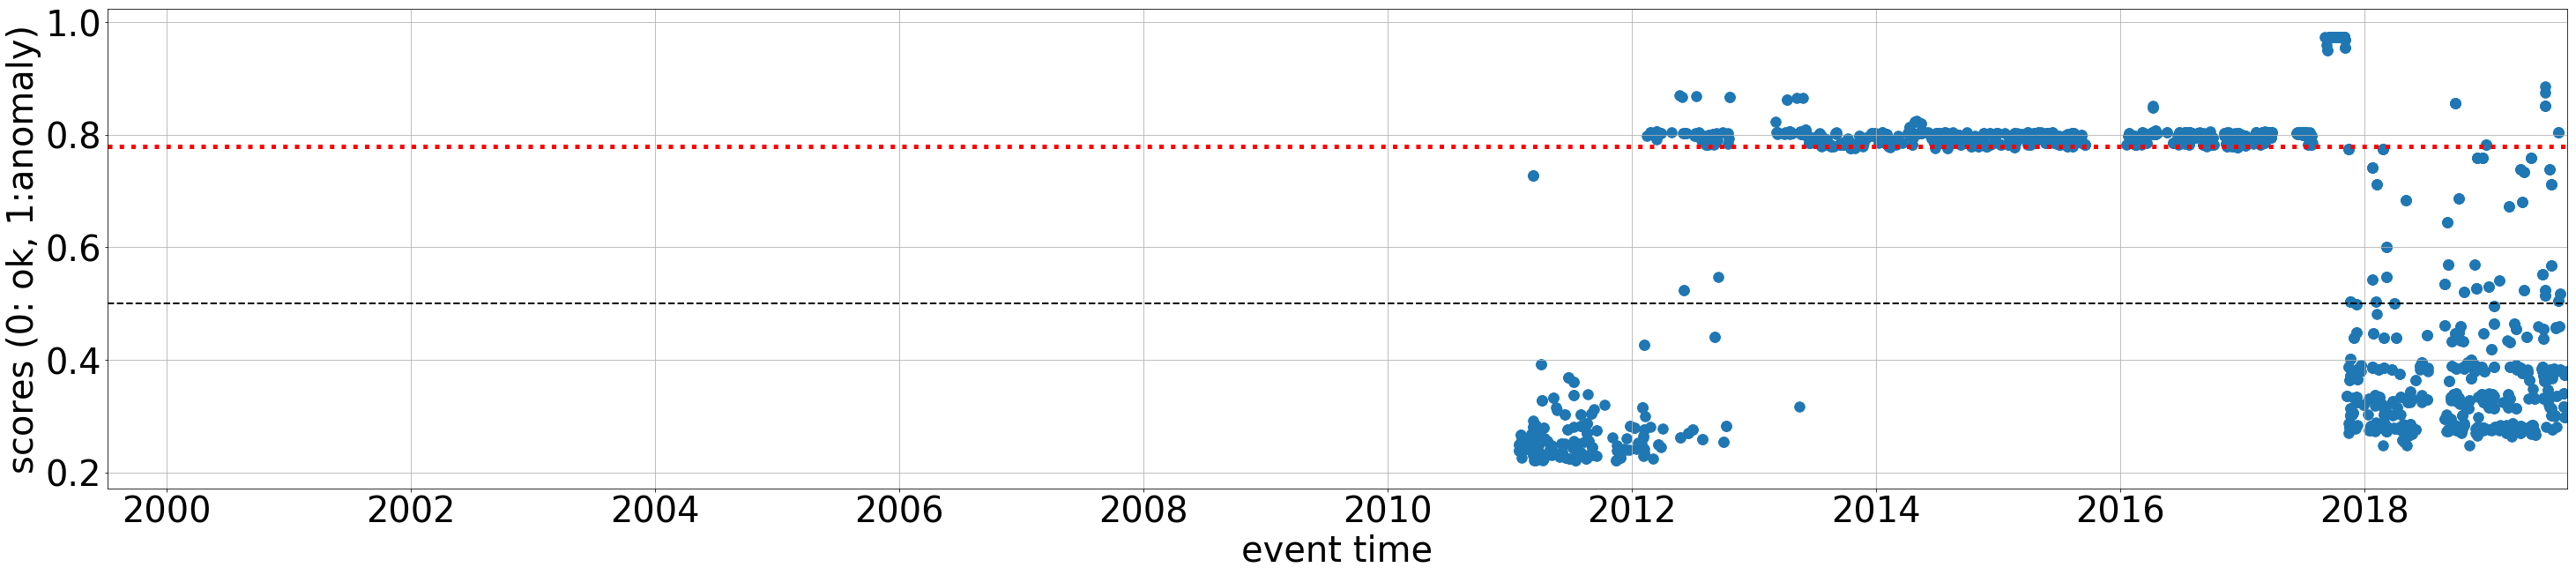

Channel TM.TMDB..BH? (database: me, station id: 3512). 923 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.777[0] 0.712[1] 0.677[2]


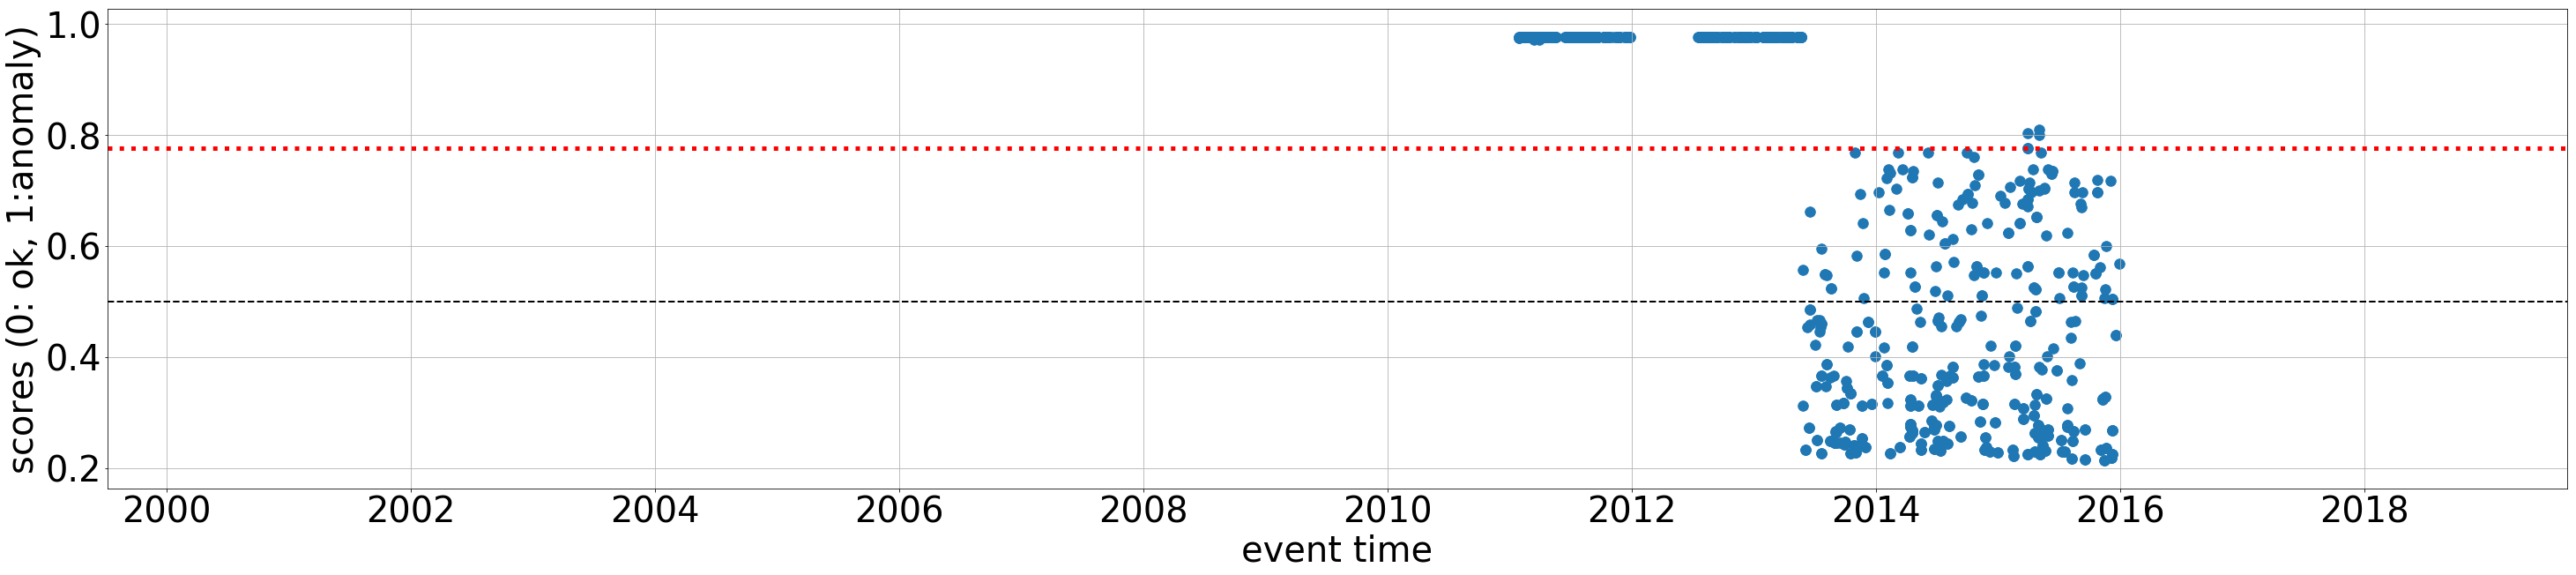

Channel NJ.IFE..BH? (database: me, station id: 2927). 43 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.760[0] 0.703[1] 0.661[2]


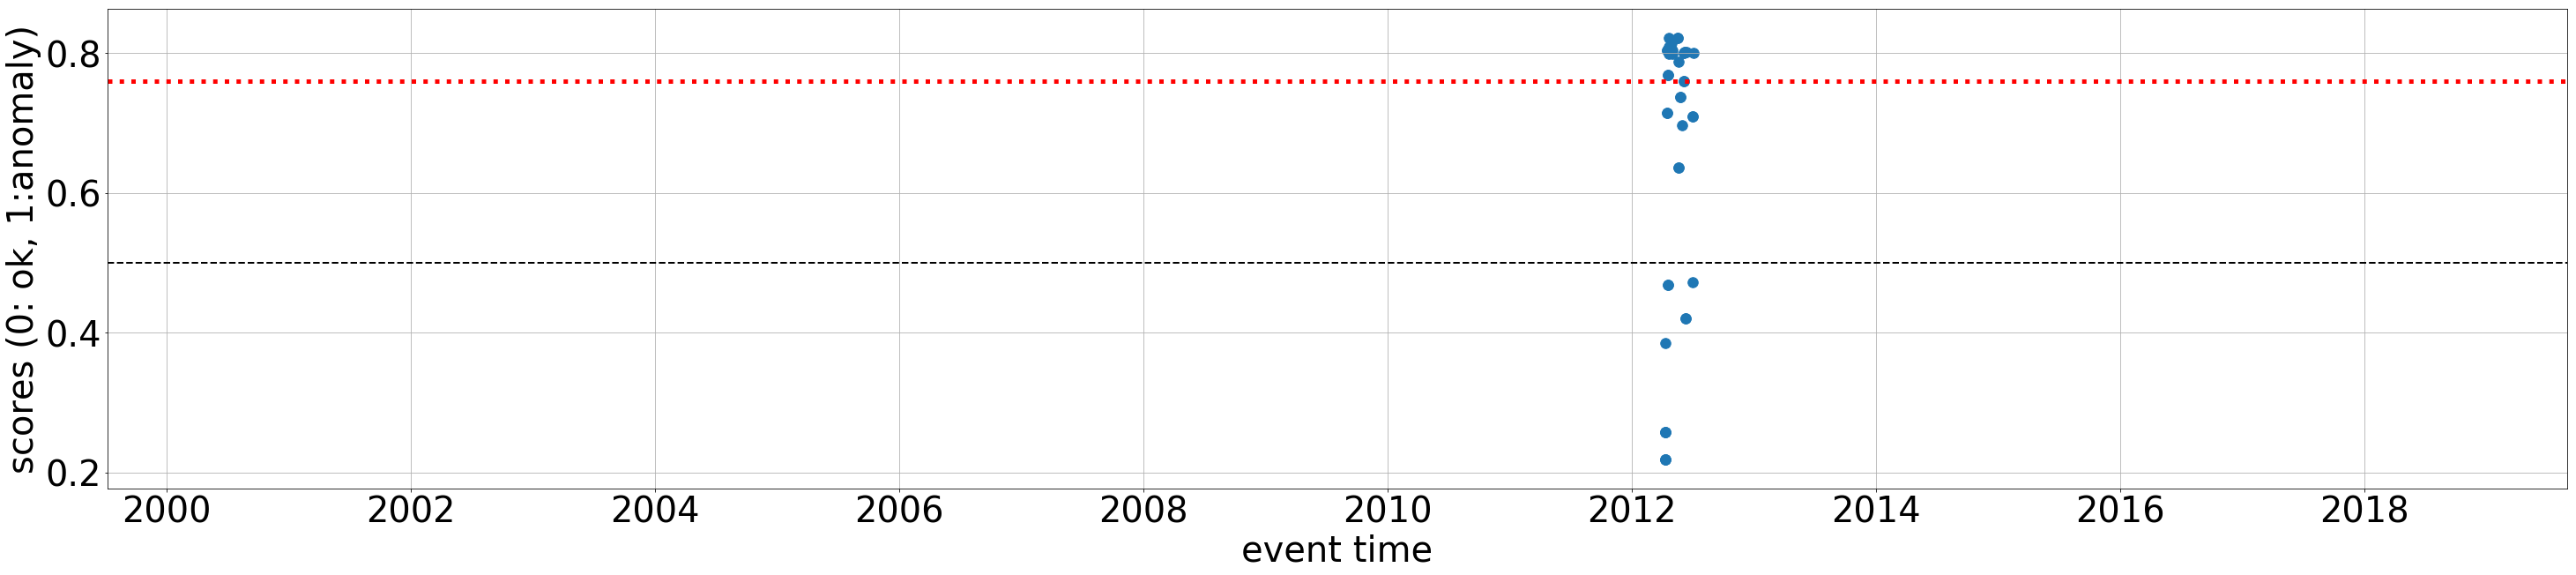

Channel UD.MI30..BH? (database: me, station id: 3717). 70 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.746[0] 0.685[1] 0.644[2]


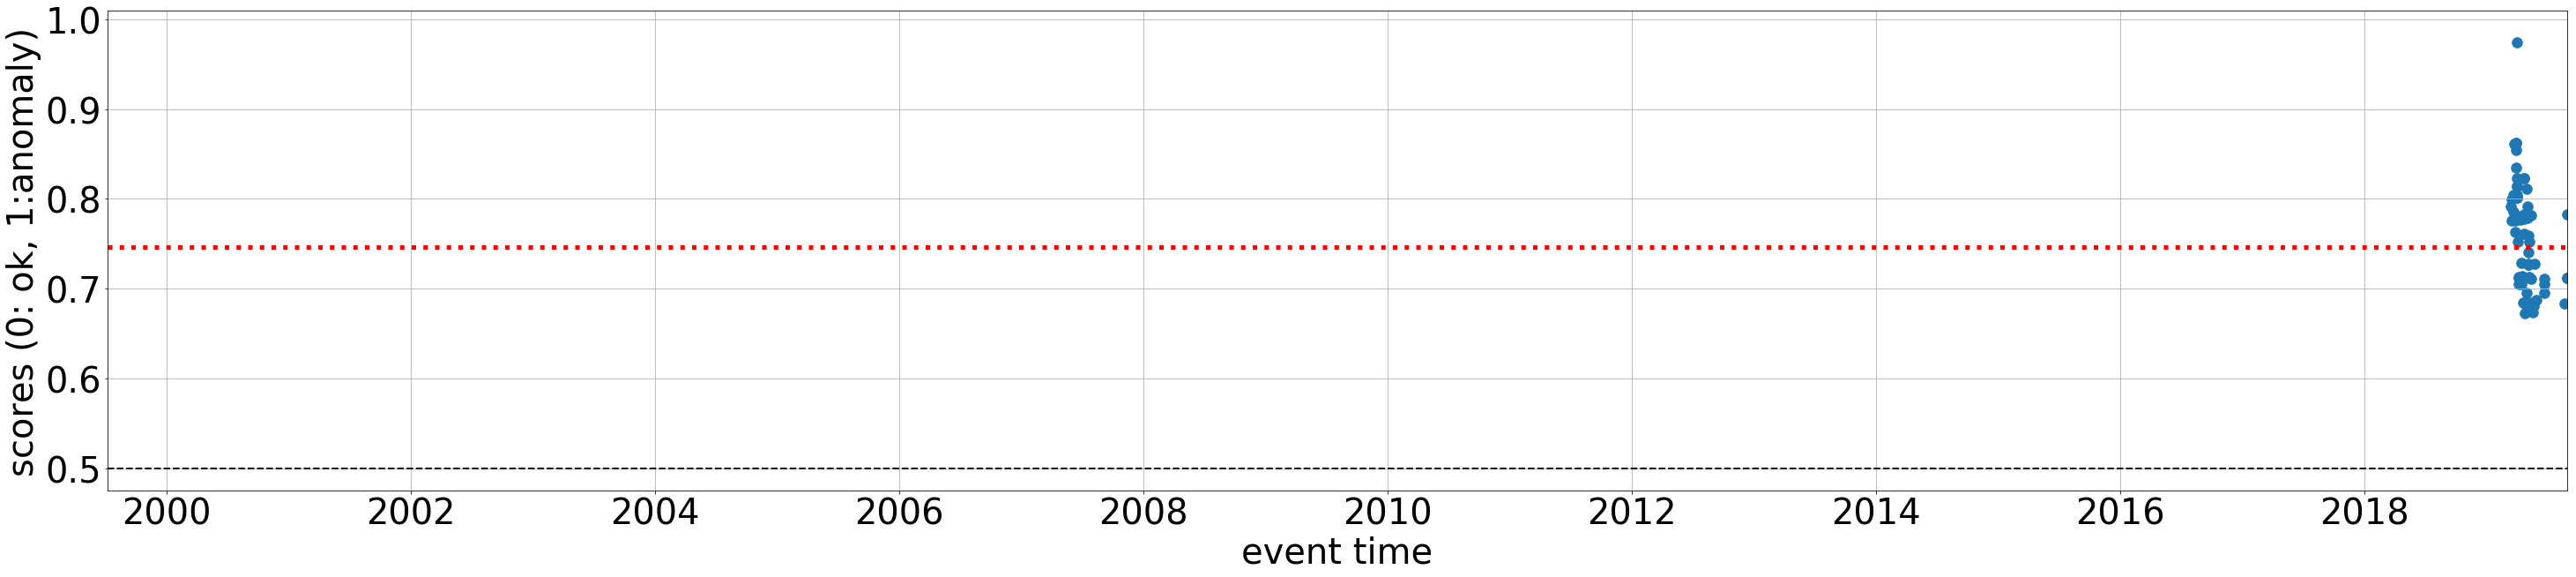

Channel AF.SKRH..BH? (database: me, station id: 1444). 280 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.739[0] 0.692[1] 0.651[2]


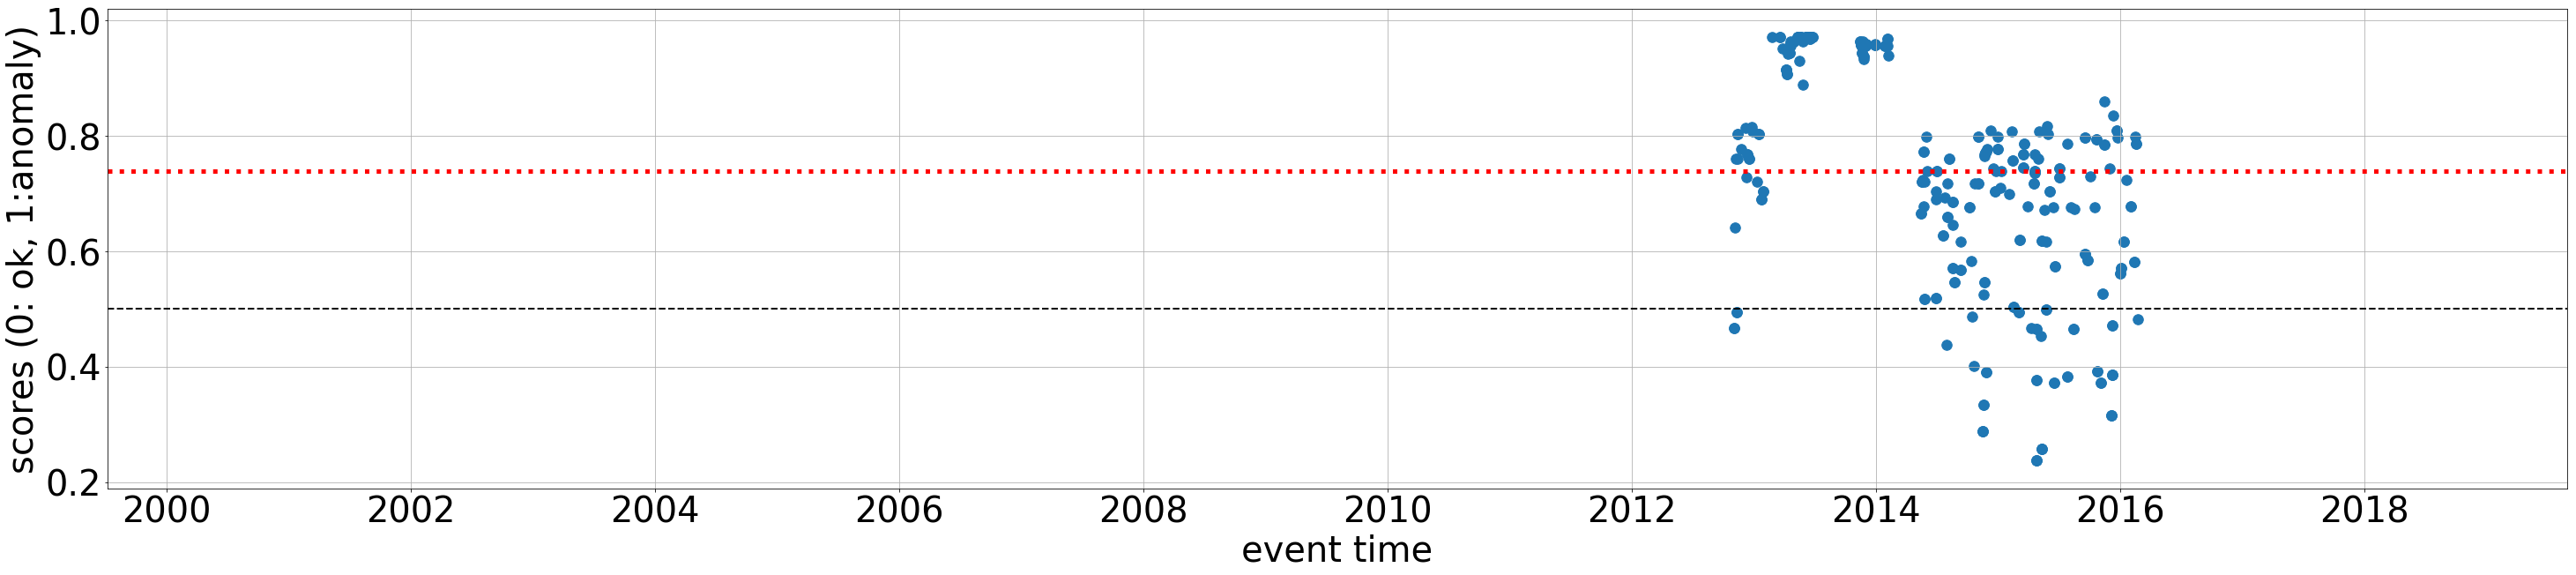

Channel AU.AS31..BH? (database: me, station id: 1580). 2258 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.735[0] 0.685[1] 0.648[2]


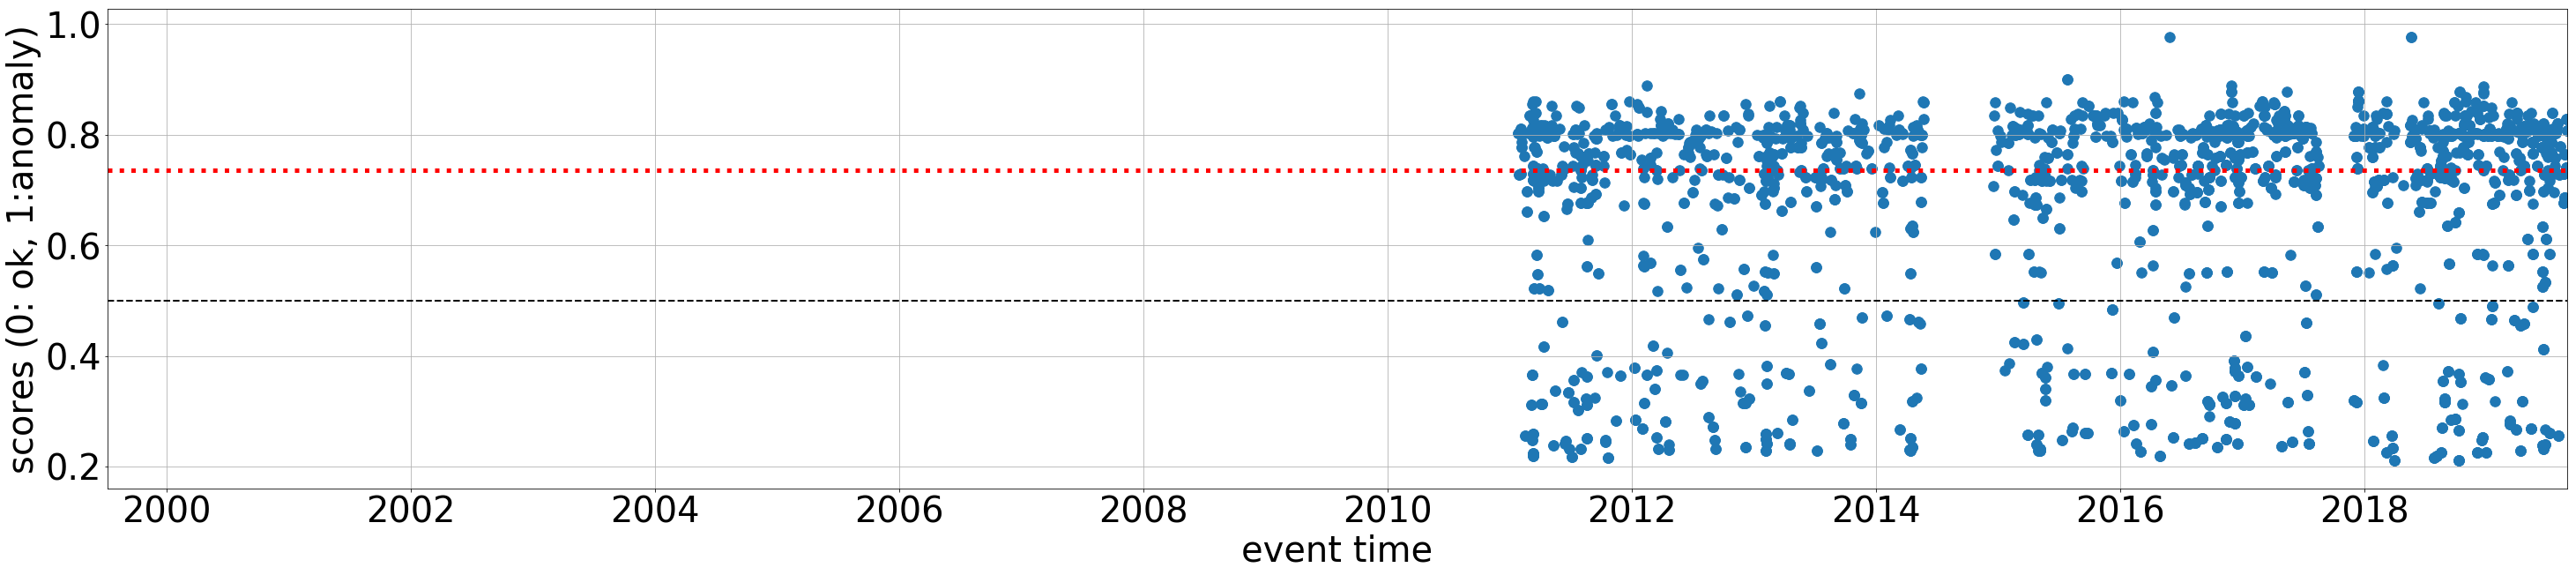

Channel AF.IFE..BH? (database: me, station id: 1427). 59 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.730[0] 0.682[1] 0.636[2]


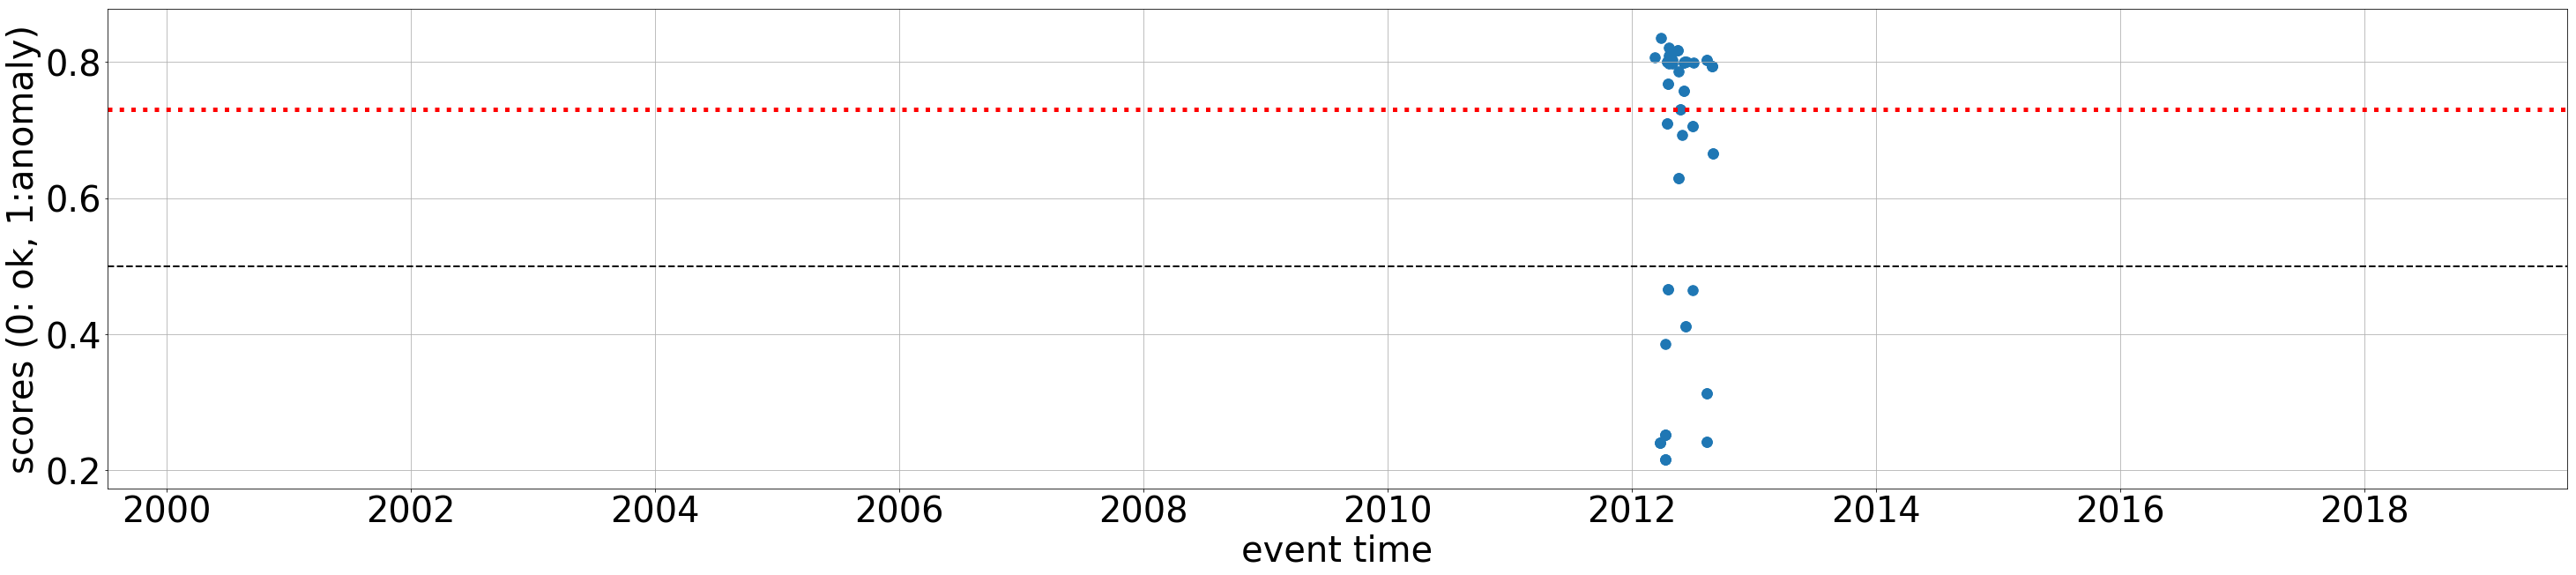

Channel DK.COP.00.BH? (database: me, station id: 3701). 16 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.713[0] 0.670[1] 0.625[2]


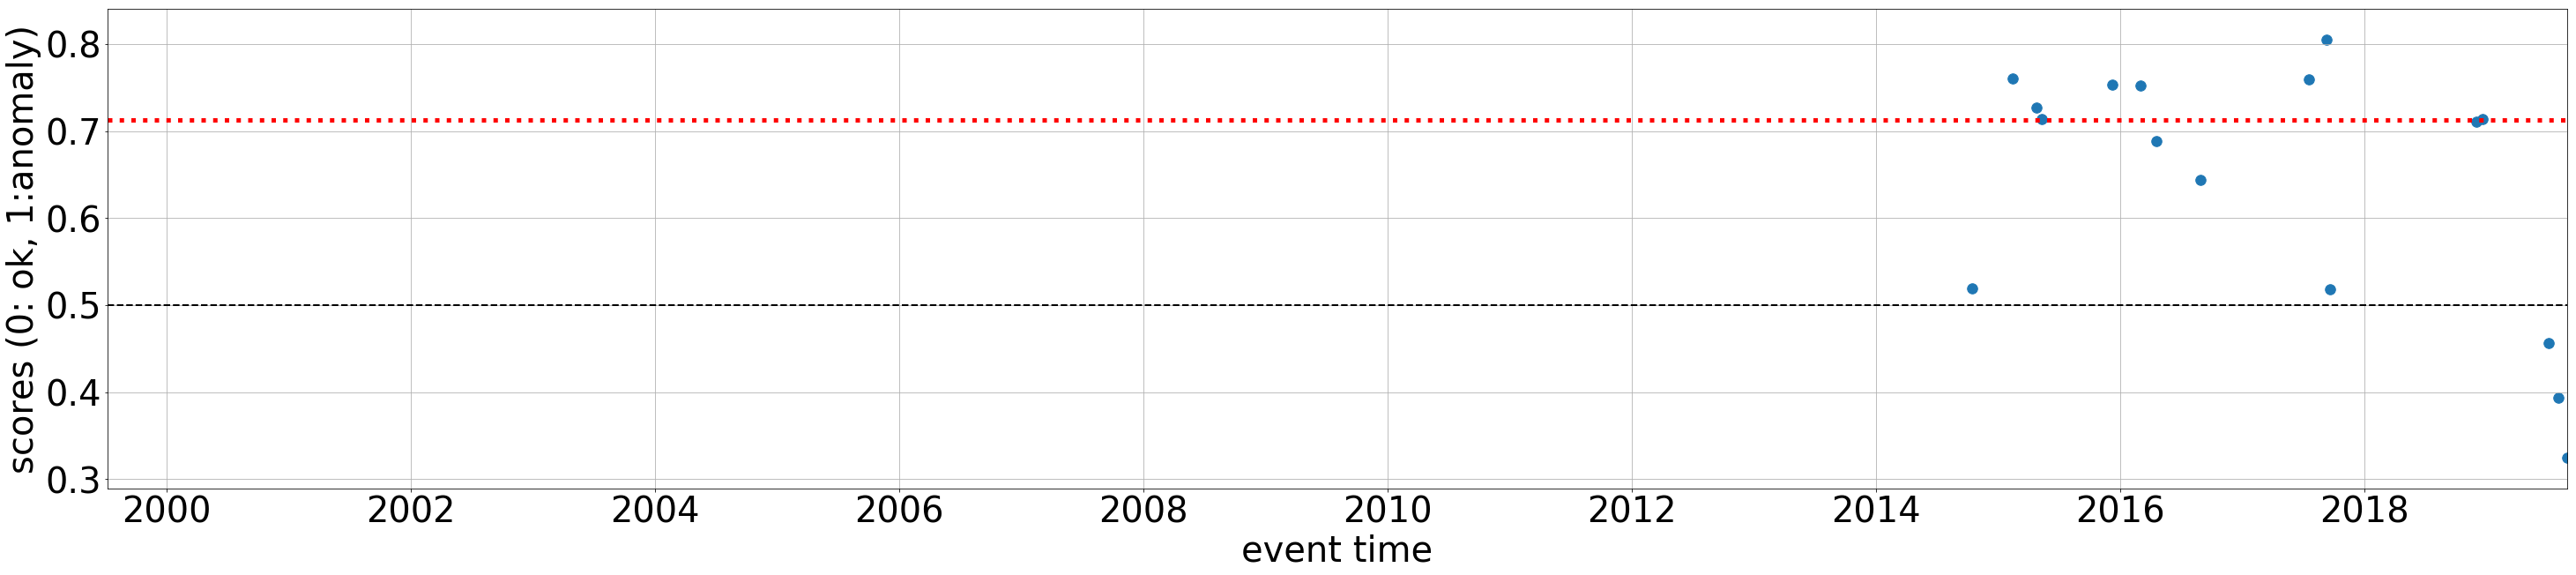

Channel FR.ESCA.00.HN? (database: s2s_2019_03, station id: 676). 19 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.709[0] 0.636[1] 0.614[2]


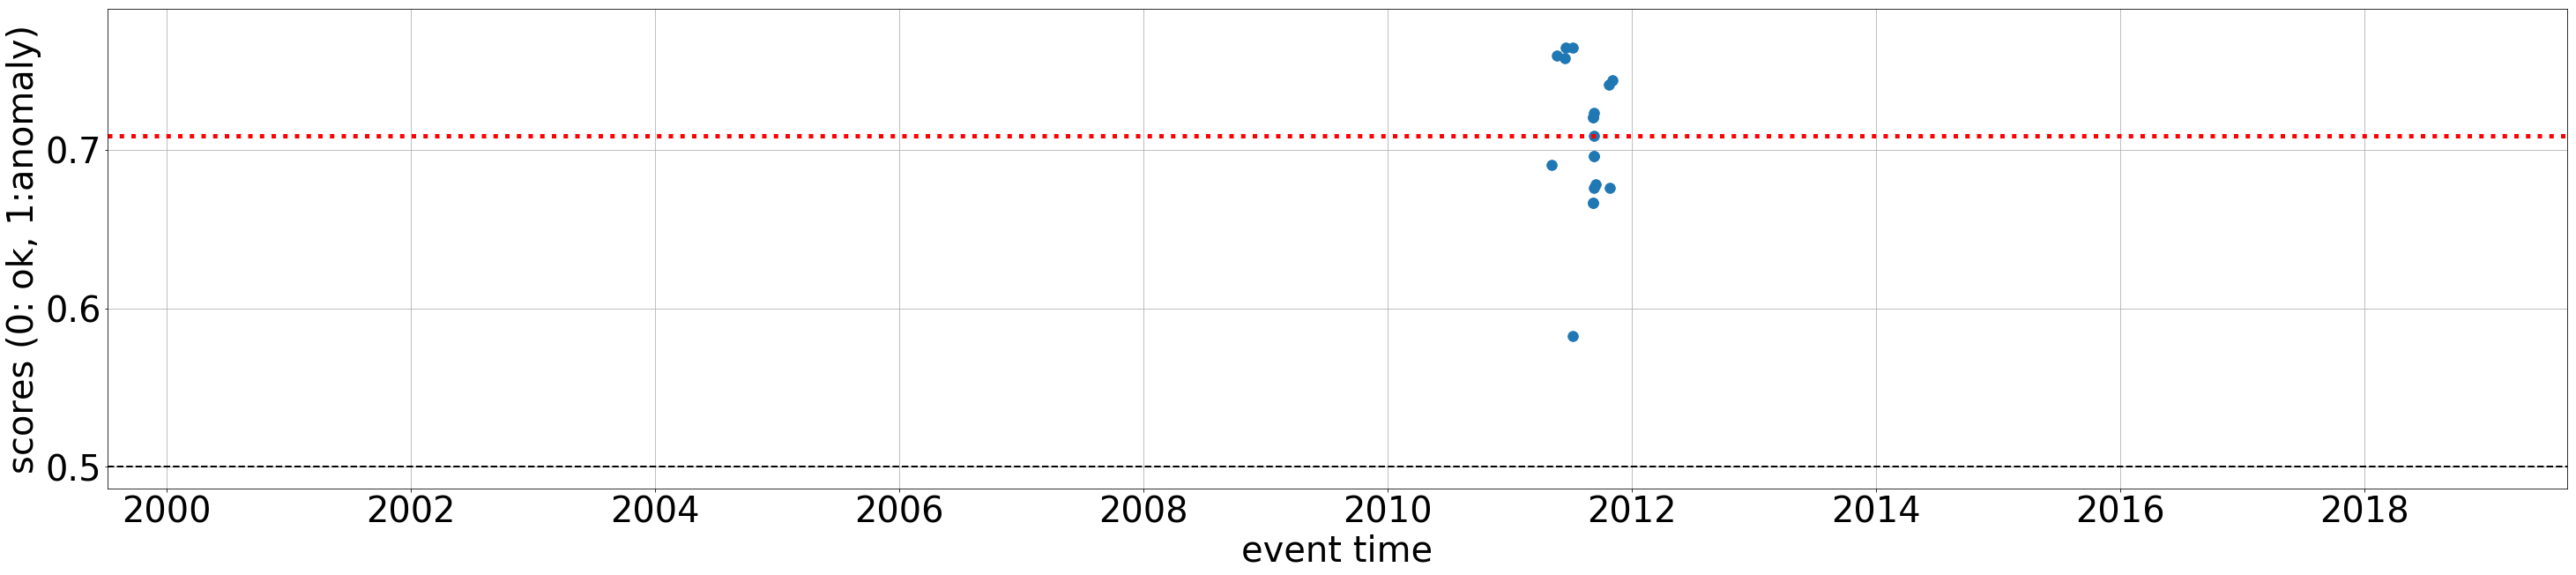

Channel PR.CUPR..BH? (database: me, station id: 3153). 460 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.691[0] 0.614[1] 0.598[2]


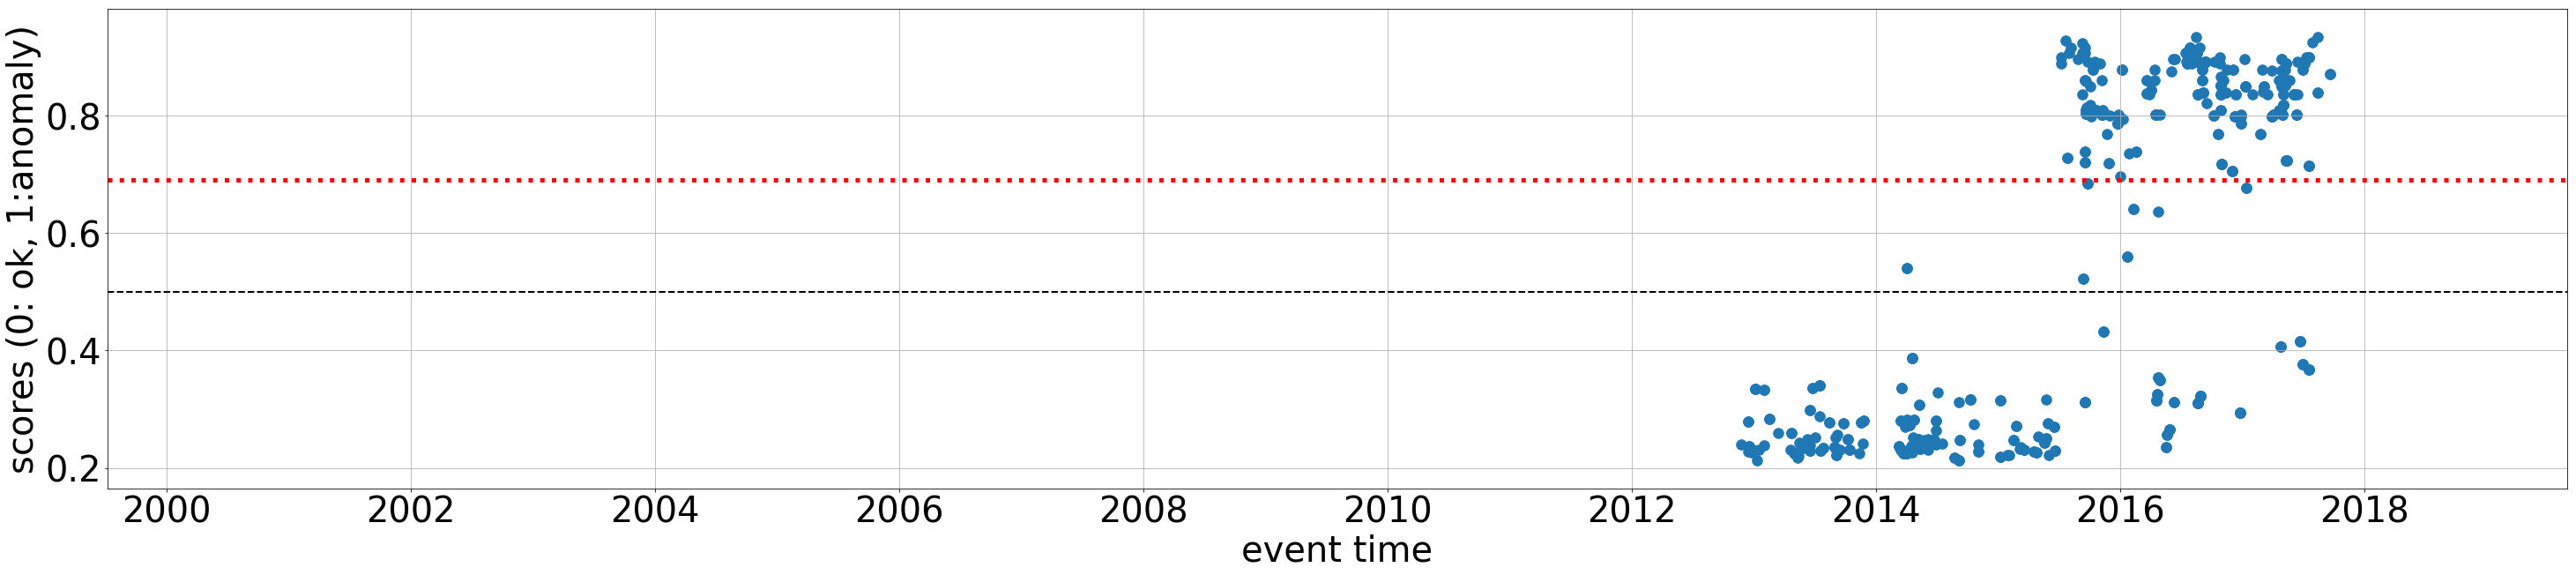

Channel GE.SNAA..BH? (database: me, station id: 2410). 1673 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.685[0] 0.643[1] 0.606[2]


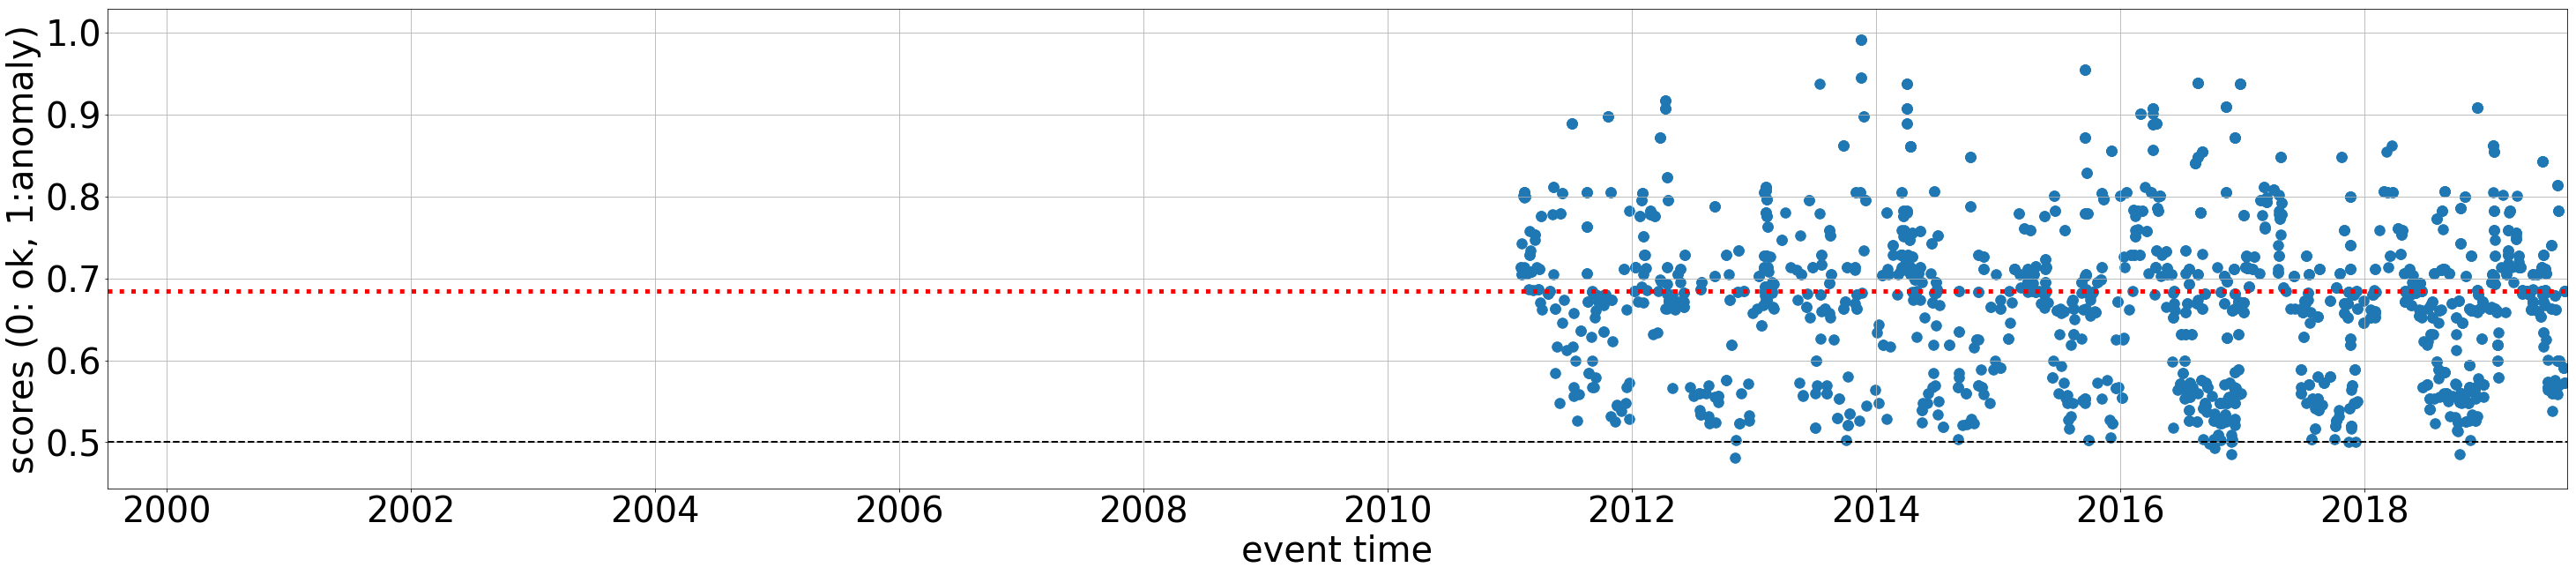

Channel TM.LOEI..BH? (database: me, station id: 3500). 1961 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.685[0] 0.648[1] 0.609[2]


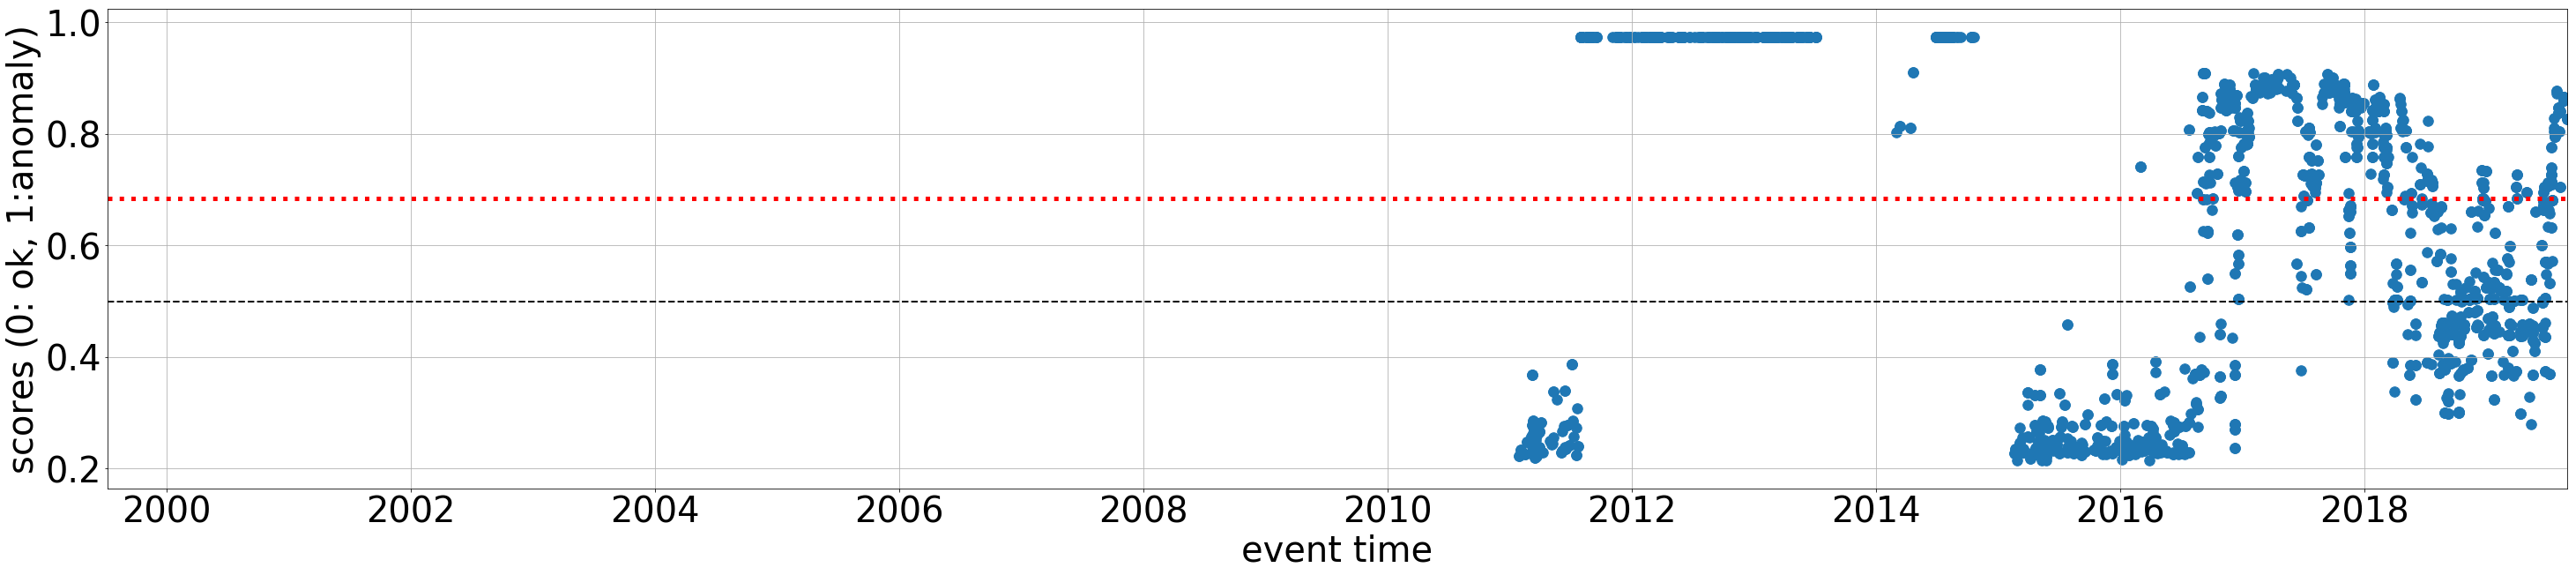

Channel NJ.NSU..BH? (database: me, station id: 2929). 27 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.674[0] 0.586[1] 0.568[2]


Channel AF.NSU..BH? (database: me, station id: 1440). 33 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.641[0] 0.551[1] 0.558[2]


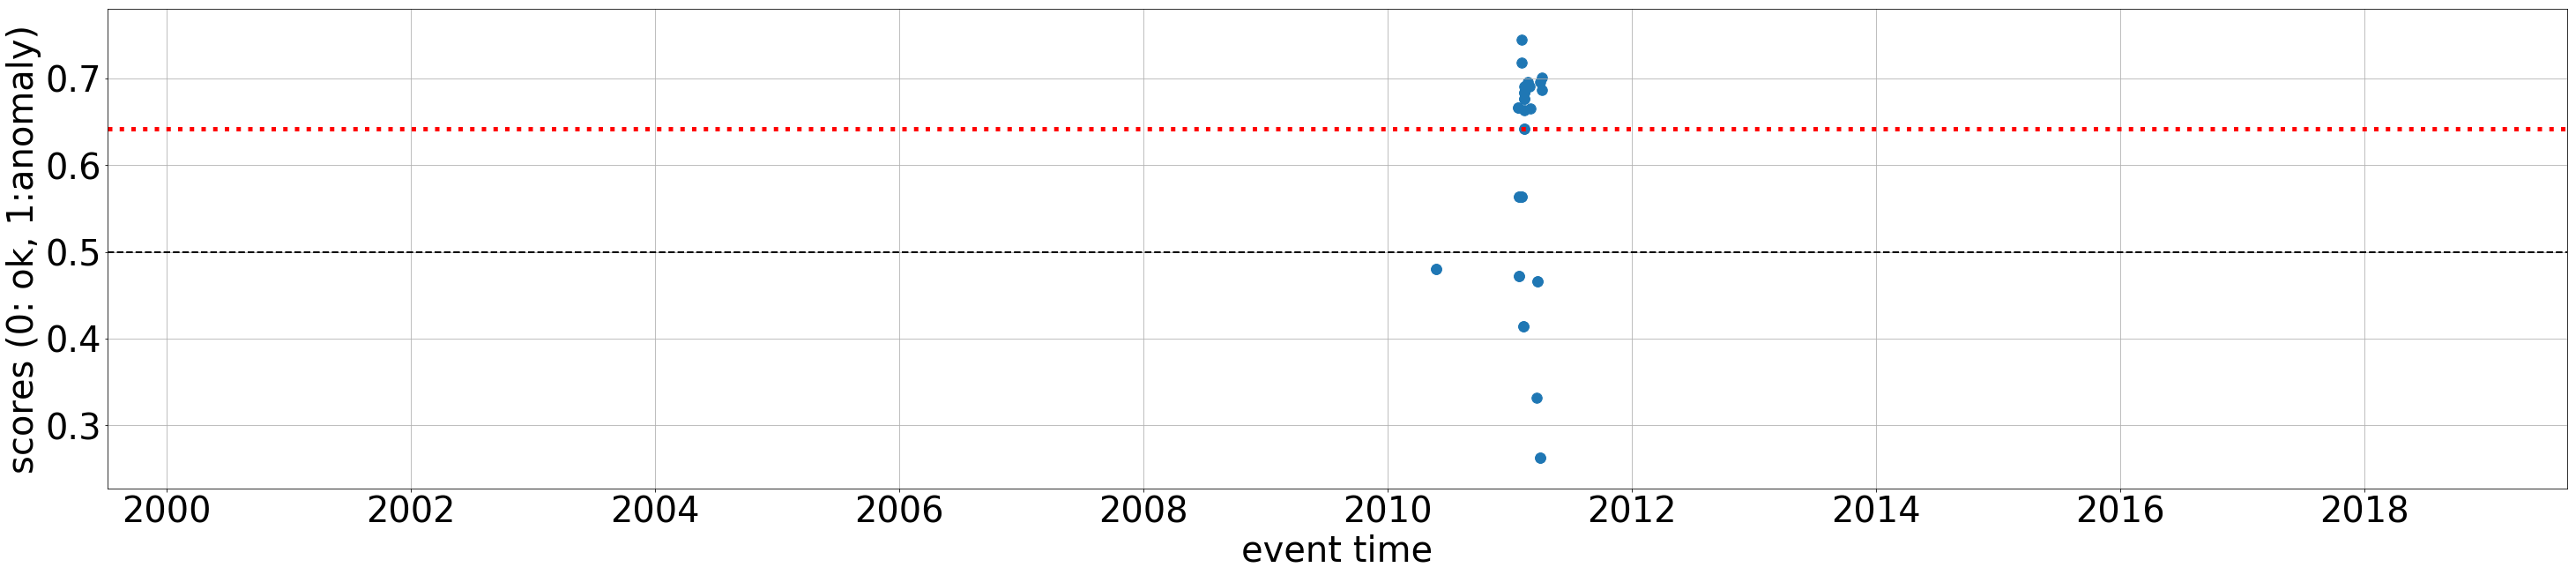

Channel RO.BURAR..BH? (database: me, station id: 1116). 2742 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.613[0] 0.542[1] 0.543[2]


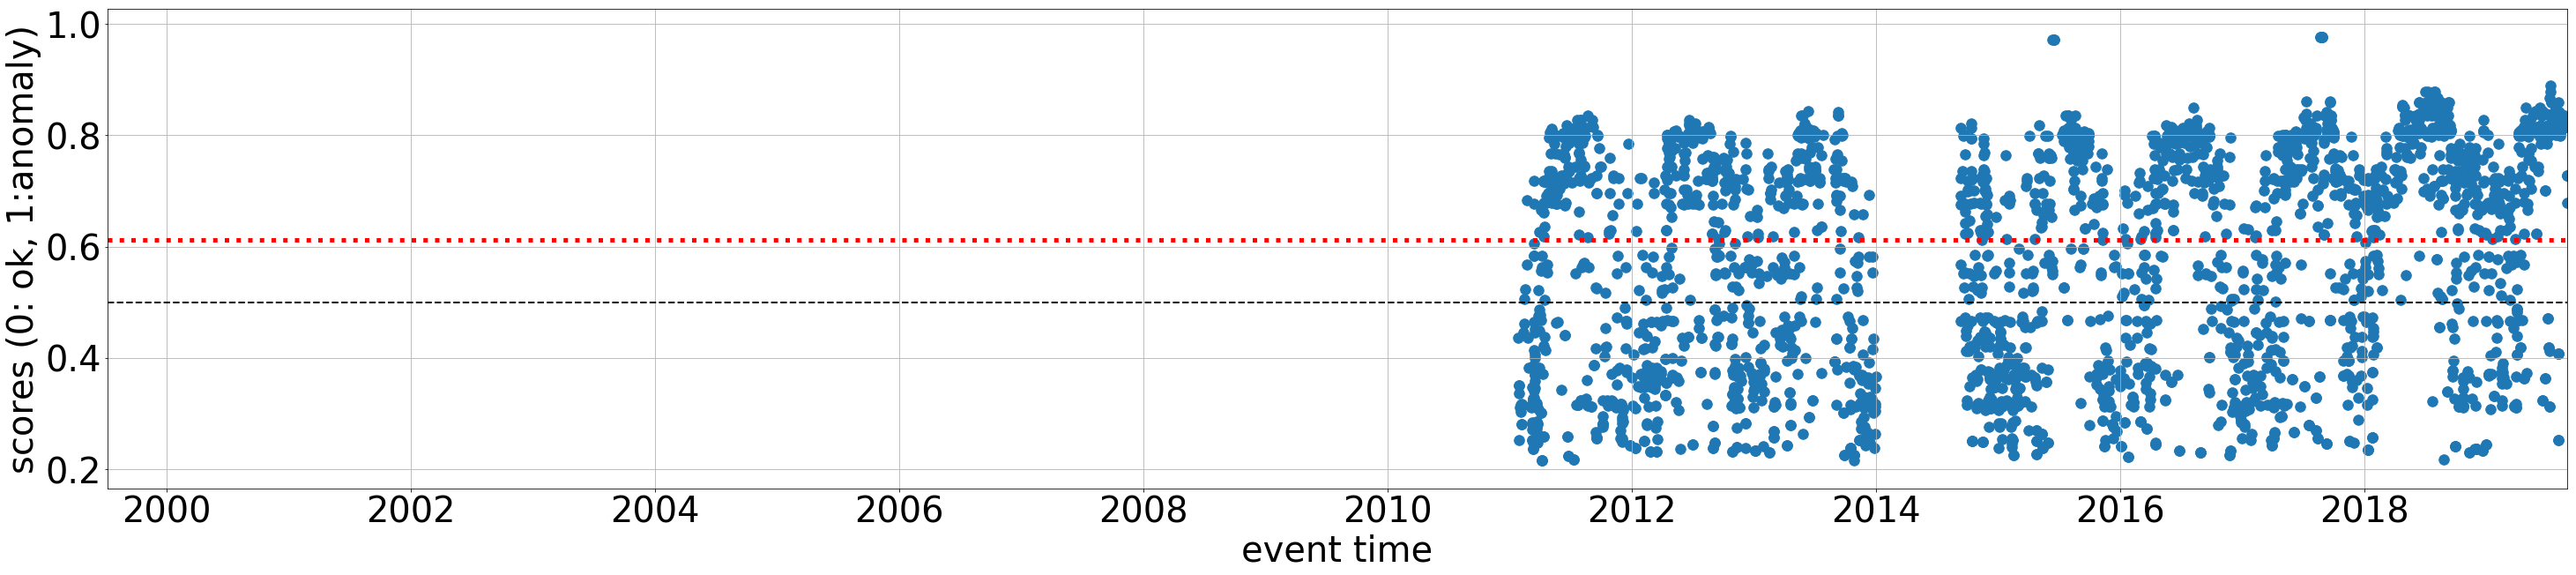

Channel FR.SAOF.00.HN? (database: s2s_2019_03, station id: 960). 2 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.601[0] 0.588[1] 0.554[2]


Channel KO.YER..BH? (database: me, station id: 438). 1932 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.582[0] 0.539[1] 0.537[2]


Channel RV.HILA..BH? (database: me, station id: 3211). 1356 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.564[0] 0.565[1] 0.564[2]


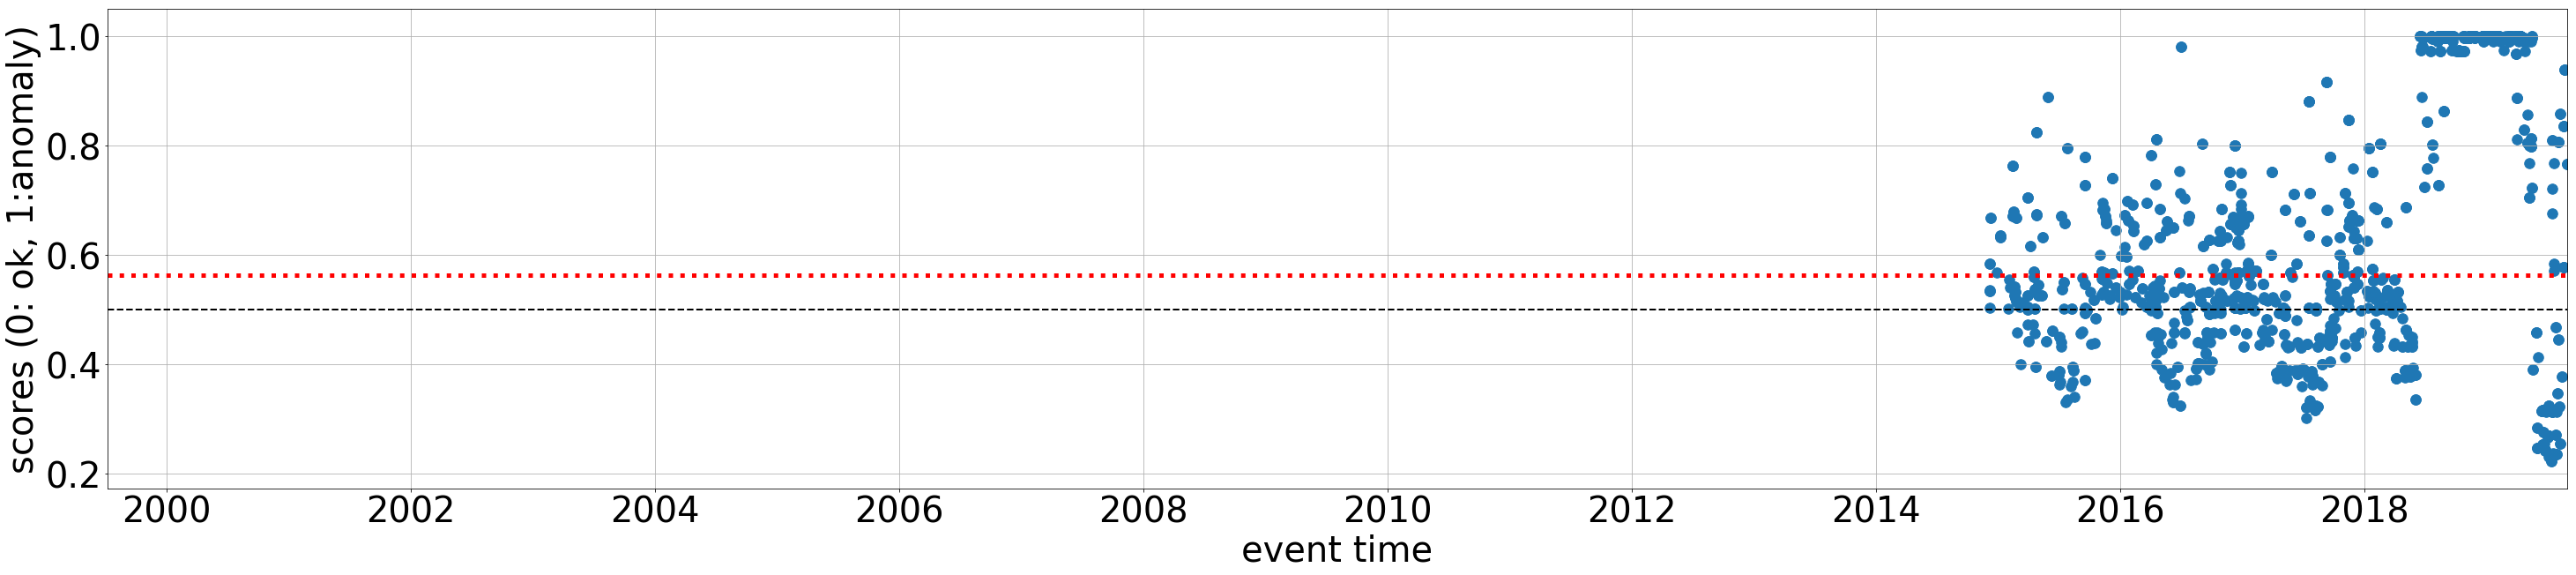

Channel AI.DSPA.02.BH? (database: me, station id: 1457). 323 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.557[0] 0.563[1] 0.549[2]


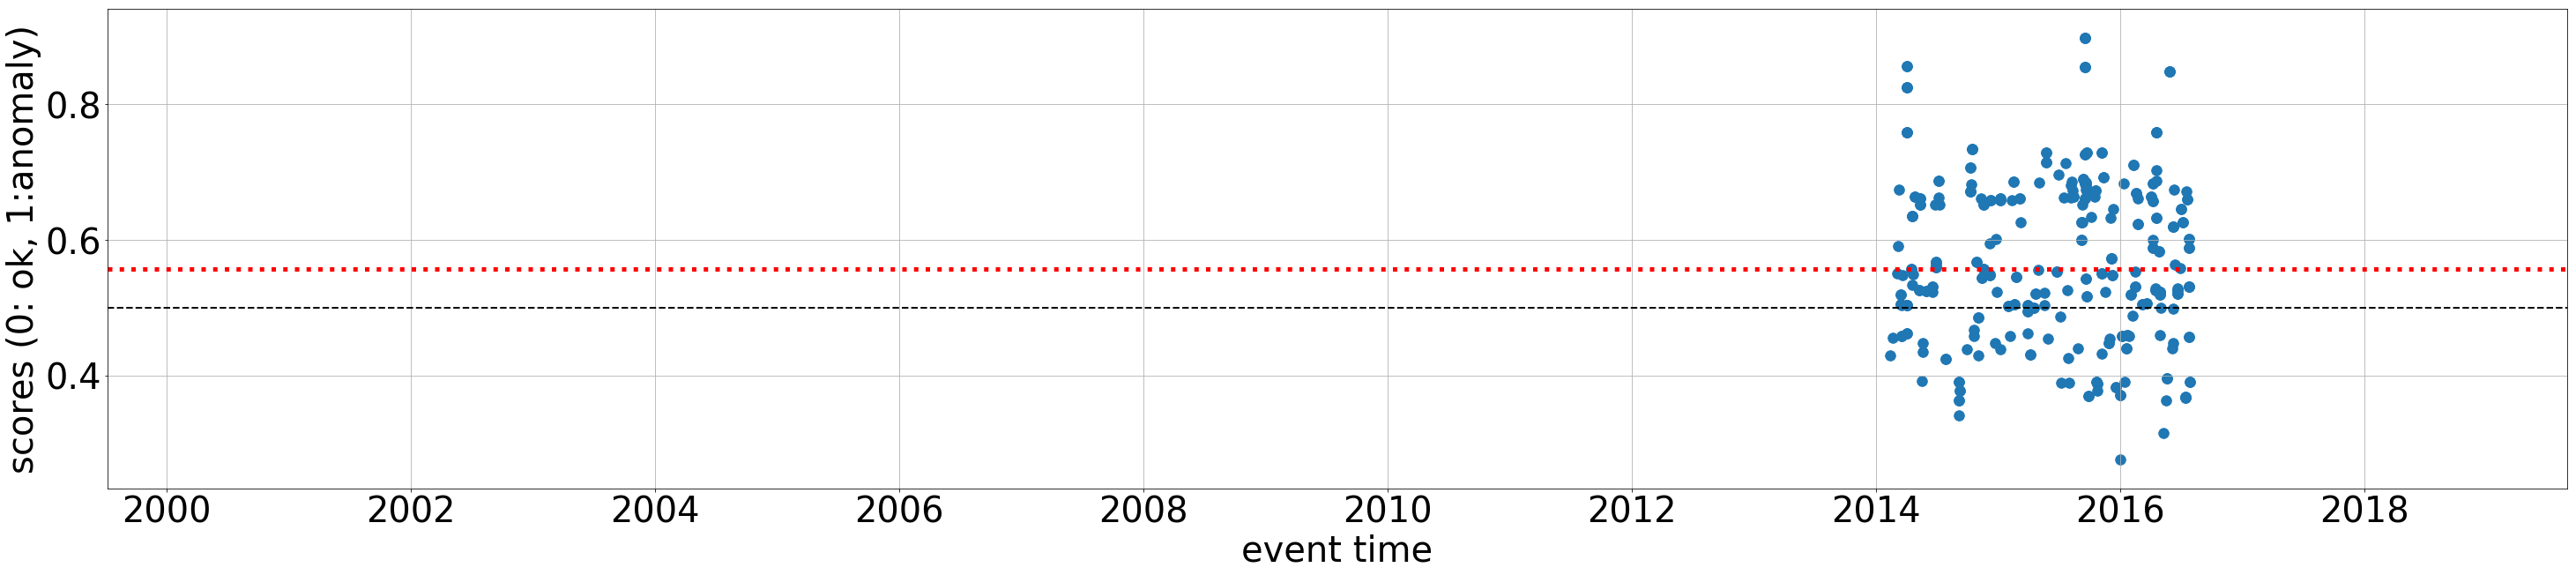

Channel AI.DSPA.04.BH? (database: me, station id: 1457). 391 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.554[0] 0.555[1] 0.544[2]


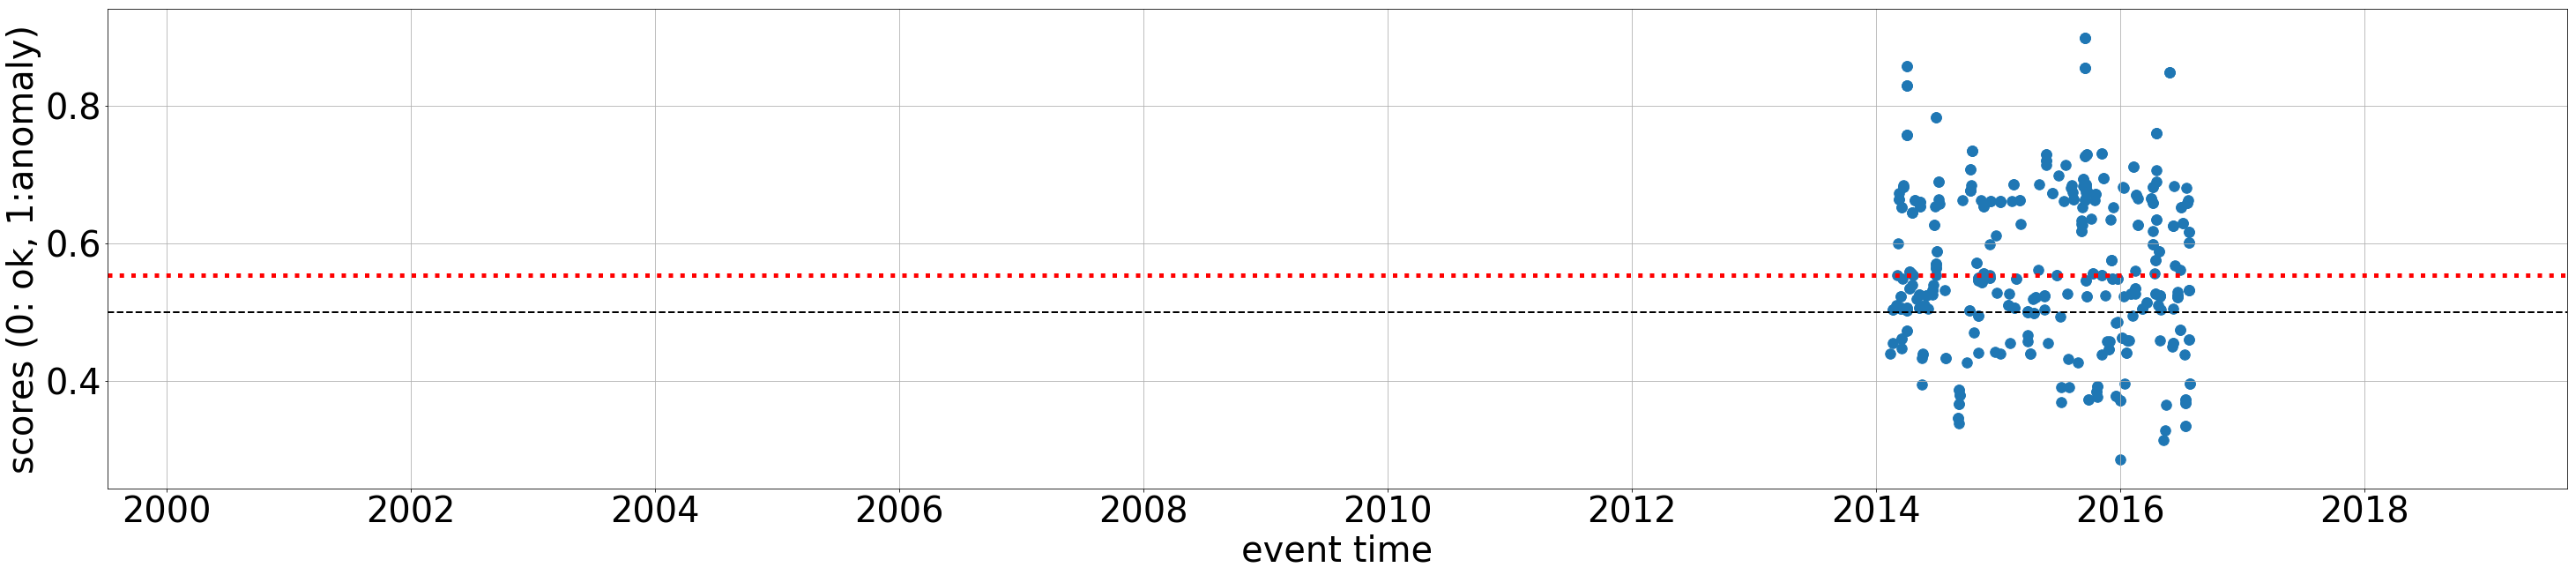

Channel C1.LC02..BH? (database: me, station id: 1938). 400 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.551[0] 0.506[1] 0.514[2]


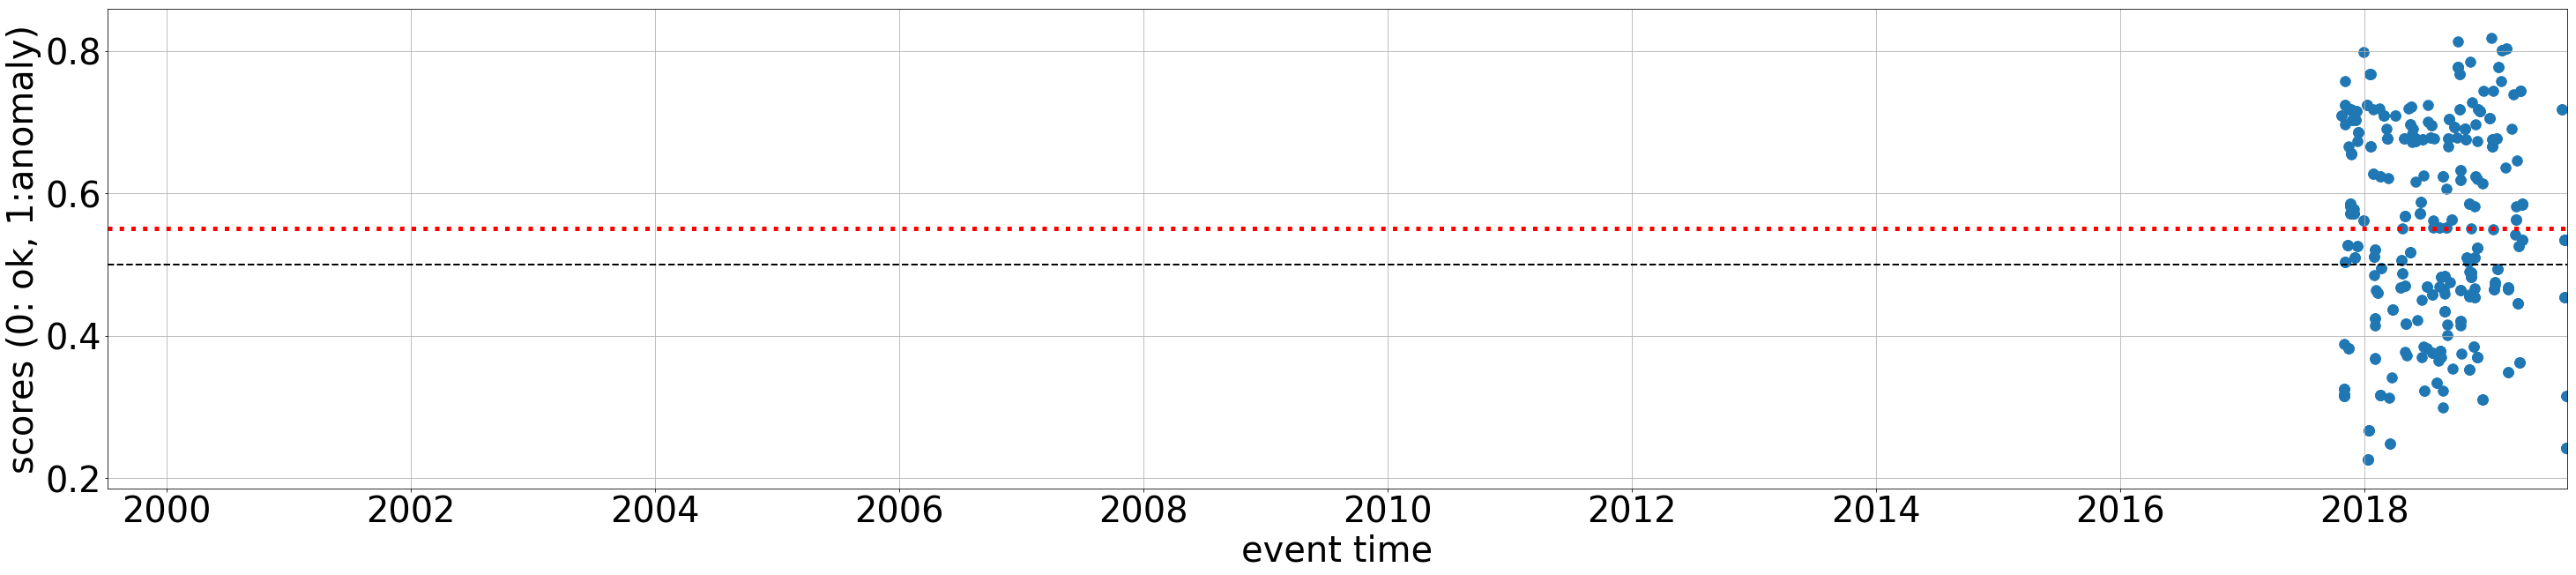

Channel CX.PX06..BL? (database: sod_chile, station id: 23). 3 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.537[0] 0.546[1] 0.525[2]


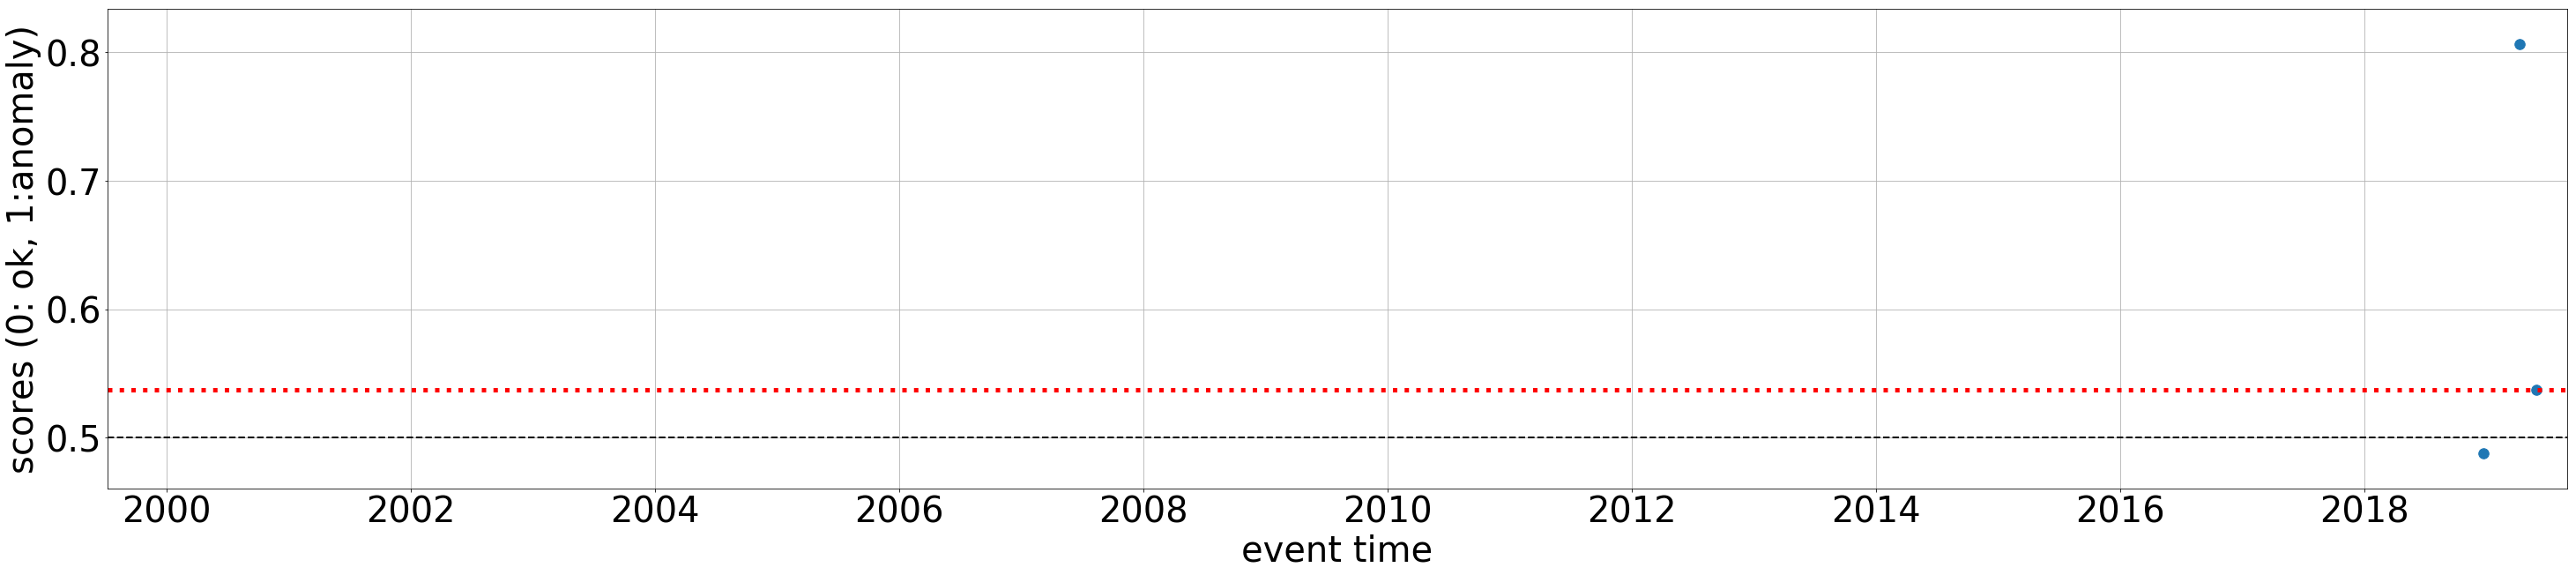

Channel IV.PIO1..HN? (database: s2s_2019_03, station id: 4762). 174 segments. label "ok"
Misclassified by 3 clfs with median scores:  0.532[0] 0.539[1] 0.525[2]


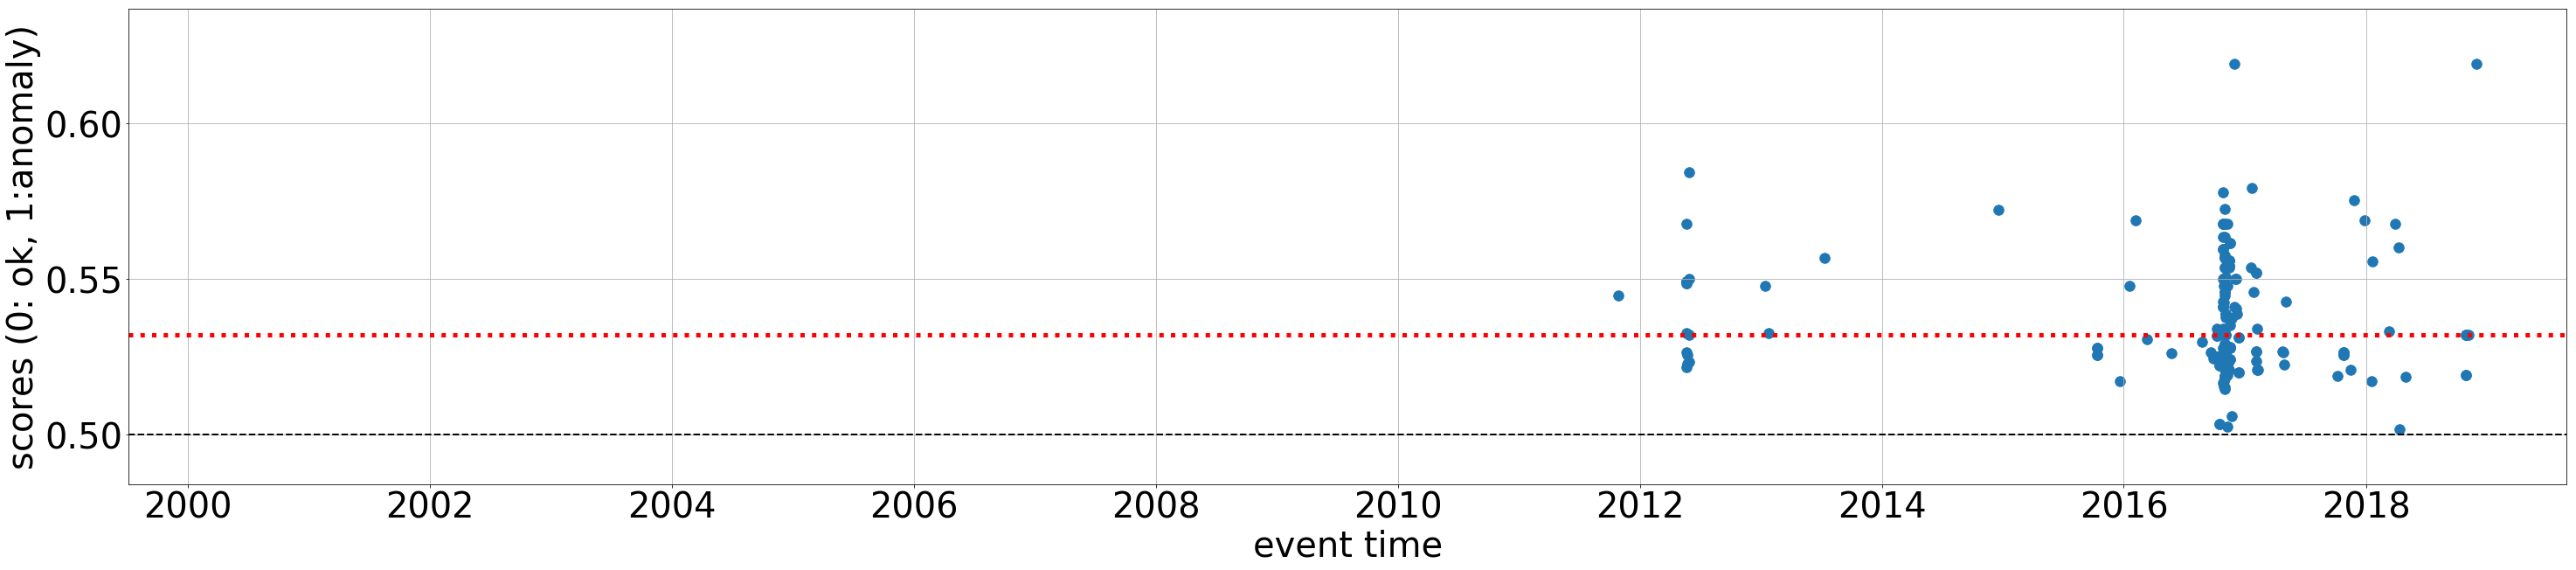

Channel AV.AKGG..BH? (database: me, station id: 1686). 505 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.531[0] 0.541[1] 0.523[2]


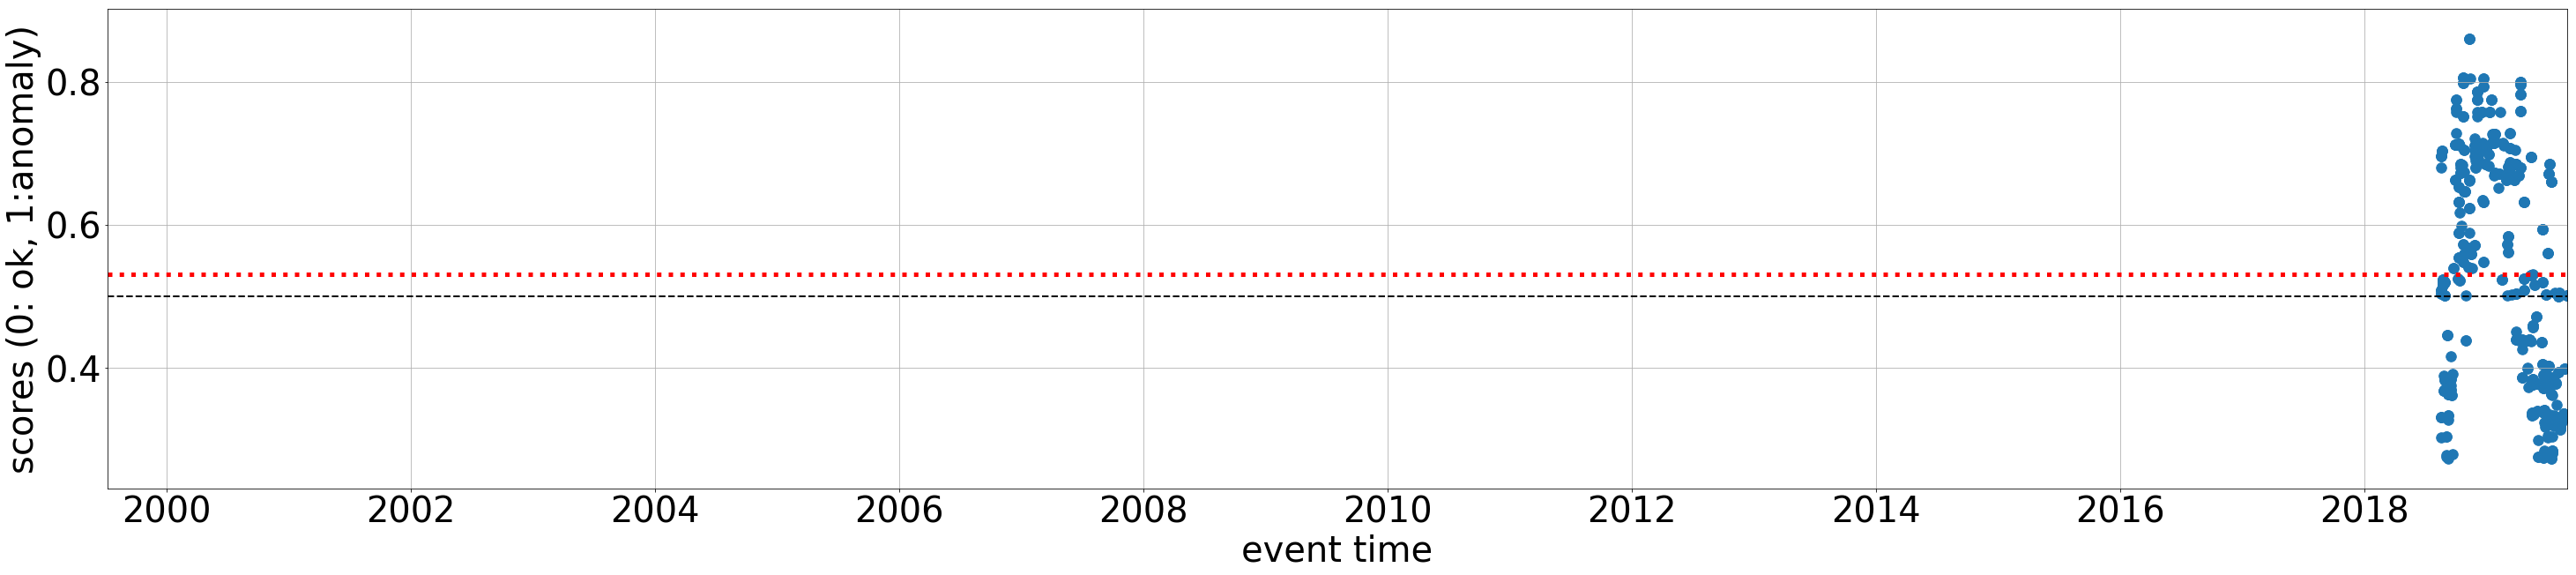

Channel CA.POBL..BH? (database: me, station id: 470). 2190 segments. label "unlabeled (Me unknown)"
Misclassified by 3 clfs with median scores:  0.520[0] 0.529[1] 0.504[2]


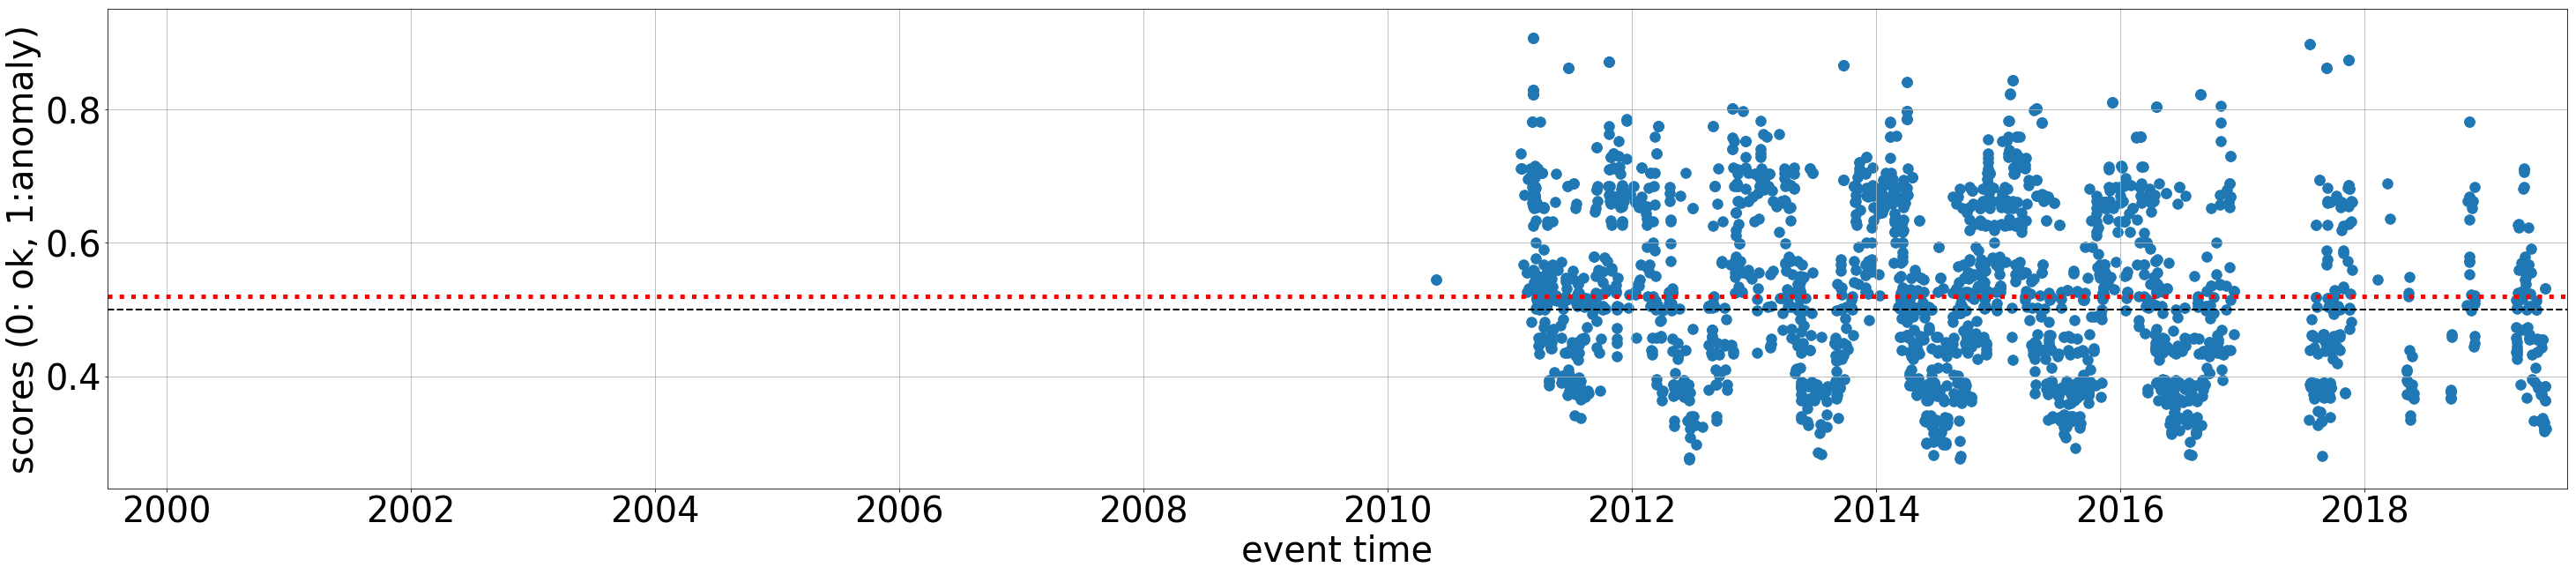

Channel CX.PB13..BL? (database: sod_chile, station id: 16). 1 segments. label "ok"
Misclassified by 2 clfs with median scores:  0.517[0] 0.527[1]


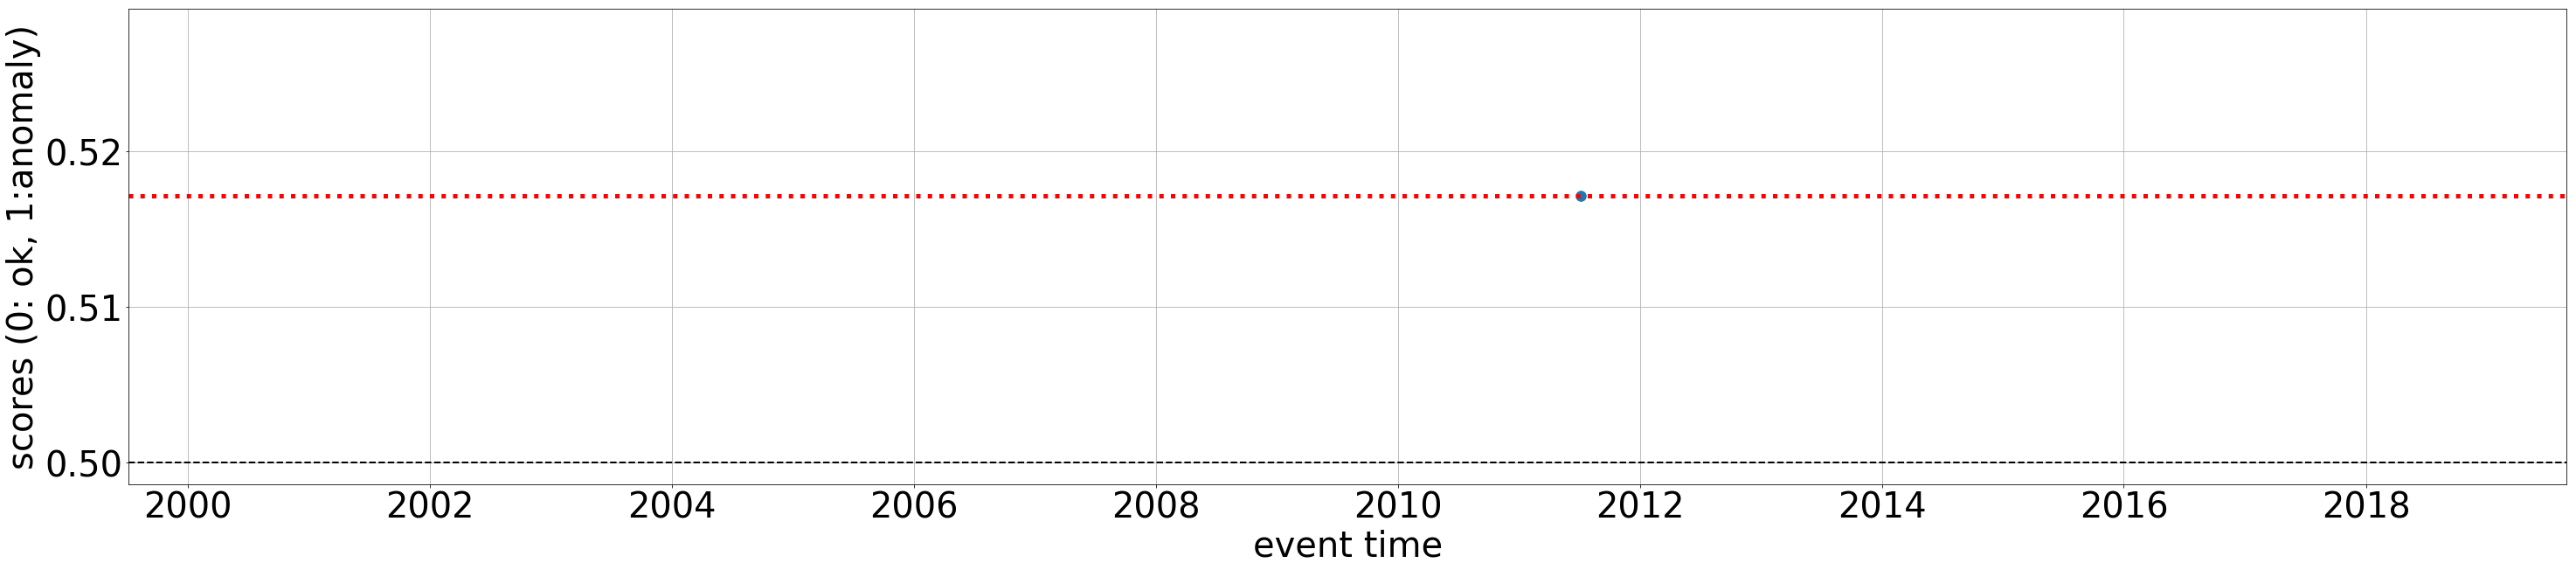

Channel PZ.PIER..EH? (database: s2s_2019_03, station id: 10161). 2 segments. label "ok"
Misclassified by 2 clfs with median scores:  0.517[1] 0.503[2]


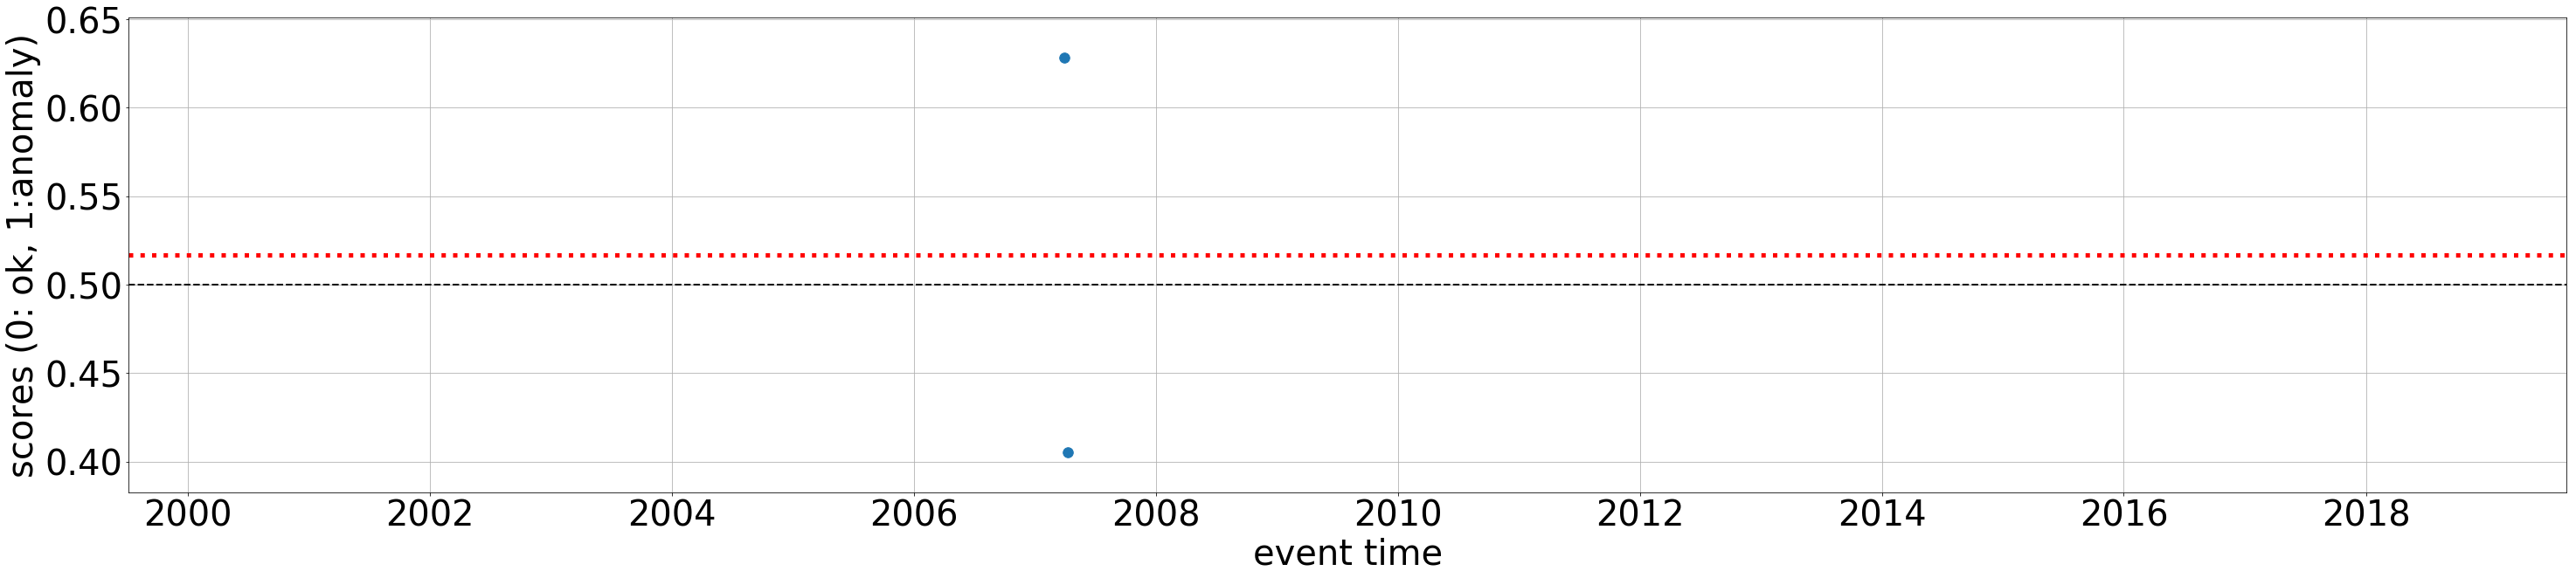

Channel S1.AUTAR..BH? (database: me, station id: 3258). 1325 segments. label "outl. (wrong inv)"
Misclassified by 3 clfs with median scores:  0.314[0] 0.403[1] 0.421[2]


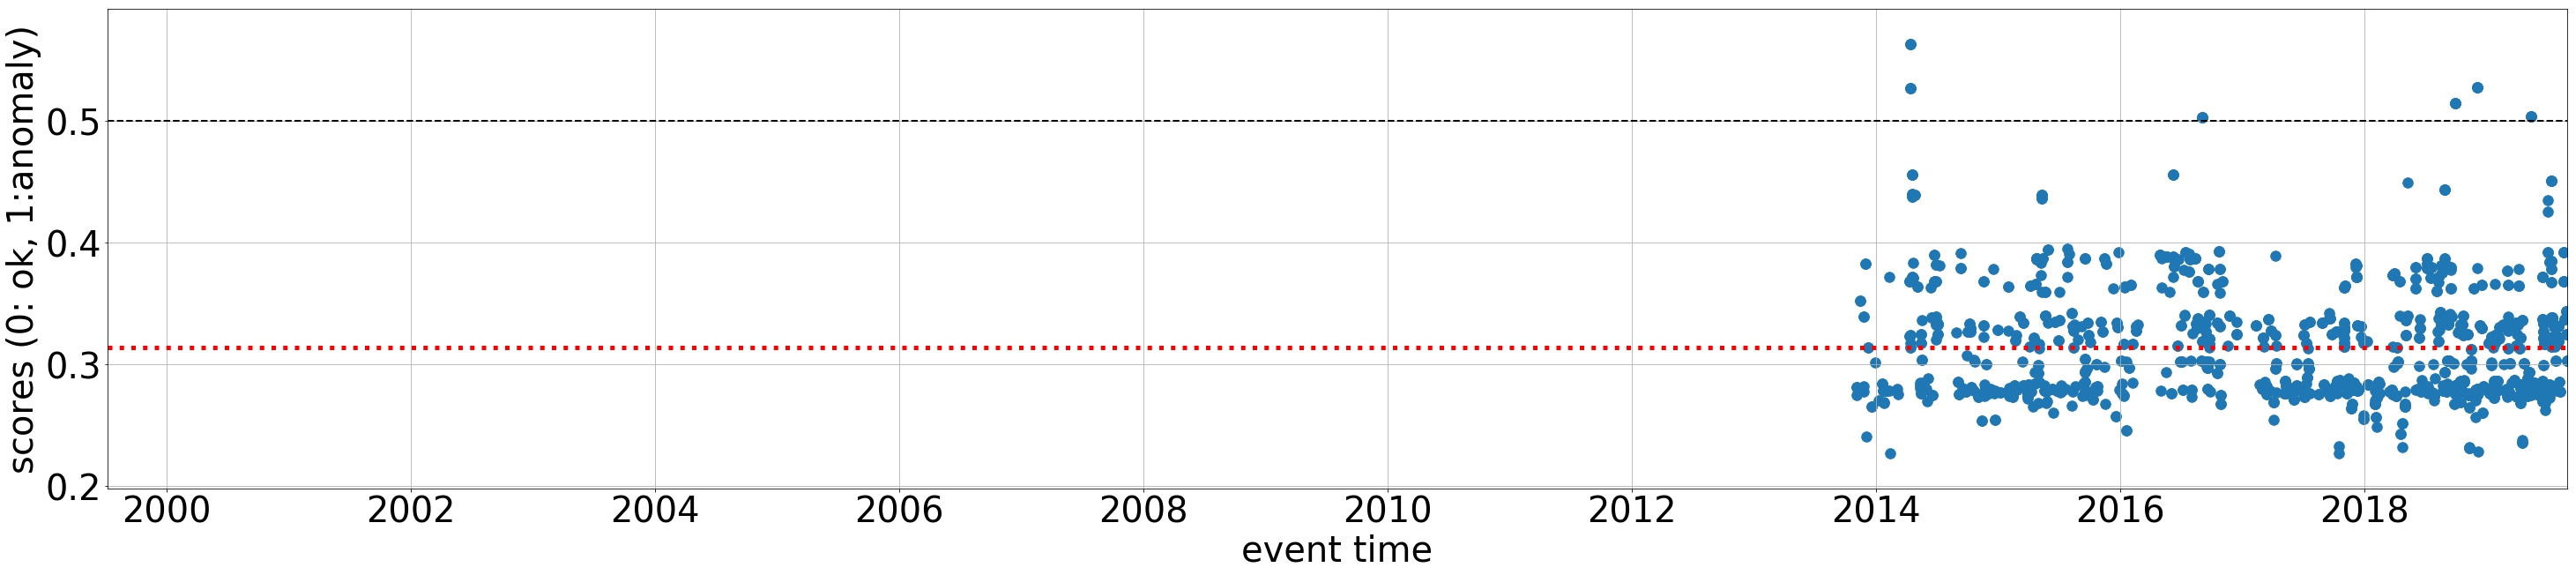

In [3]:
# plotting misclassified channels


_pred_dfs = []
timin, tmax = None, None
for i, pred_df in enumerate(pred_dfs):
    assert 'event_time' not in pred_df.columns
    _pred_df = pred_df.merge(allset_test[['allset_test.id', 'dataset_id', 'event_time']],
                             how='left', on=['allset_test.id', 'dataset_id'])
    assert 'event_time' in _pred_df.columns
    natimes = pd.isna(_pred_df.event_time).sum()
    if natimes:
        raise ValueError('%d NAT' % natimes)
    _pred_df = _pred_df.dropna(subset=['event_time'])
    _pred_dfs.append(_pred_df.copy())

    _tmin, _tmax = pd.to_datetime(_pred_dfs[-1].event_time.min()), pd.to_datetime(_pred_dfs[-1].event_time.max())
    if i == 0 or _tmin < tmin:
        tmin = _tmin
    if i==0 or _tmax > tmax:
        tmax = _tmax
#print('%d segments of %d misclassified with score diff >=%f' % (len(_pred_df), len(pred_df), TH))

_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dataset_urls= {
    1: jnconfig['dbpath_new'],
    2: jnconfig['dbpath_me'],
    3: jnconfig['dbpath_chile']
}


station_codes = {}

from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv

print('Getting station networks and stations')
for dts_id, df in _pred_dfs[0].groupby('dataset_id'):  # use just one prediction dataframe, _pred_dfs[0]
    sess = get_session(dataset_urls[dts_id])
    for (staid, stanet, stasta) in sess.query(Station.id, Station.network, Station.station):
        station_codes[(dts_id, staid)] = "%s.%s" % (stanet, stasta)
    sess.close()

        
columns = ['dataset_id', 'station_id', 'cha_id', 'location_code']

spreds = []
from collections import defaultdict
median_score_samples = defaultdict(list)
for cname, csel in classes.items():
    for (iii, _pred_df) in enumerate(_pred_dfs):
        class_df = _pred_df[csel(_pred_df)]
        for (dts_id, sta_id, cha_id, loc_code), df in class_df.groupby(columns):
            key = '%s.%s.%s?' % (station_codes[(dts_id, sta_id)], loc_code, cha_id)
            key += ' (database: %s, station id: %d)' % (dataset_urls[dts_id][dataset_urls[dts_id].rfind('/')+1:], sta_id)
            key += '. %d segments' % len(df)
            med = df.score_samples.median()
            outl_count = df.outlier.sum()
            if outl_count == len(df) and med < 0.5:
                median_score_samples[key].append([iii, med])
                if len(median_score_samples[key]) == 1:
                    spreds.append([key, True, cname, df.event_time, df.score_samples])
            elif outl_count == 0 and med > 0.5:
                median_score_samples[key].append([iii, med])
                if len(median_score_samples[key]) == 1:
                    spreds.append([key, False, cname, df.event_time, df.score_samples])
            elif outl_count != len(df) and outl_count !=0:
                print('%d: ??' % (sta_id))

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

            
spreds.sort(key=lambda val: np.nanmedian(val[-1]), reverse=True)
# assert any('wrong inv' in _[2] for _ in spreds)


print()
print()
title = '%d channels to check (one plot per channel, each blue point is one event\'s score):' % len(spreds)
print(title)
print('=' * len(title))
print()
with plotparams({'figure.figsize': (50, 10), 'font.size': 40}):
    for i, (key, outlier, cname, times, vals) in enumerate(spreds):
        median_score = vals.median()
        plt.axhline(median_score, color='r', lw=5, linestyle='dotted')
        plt.scatter([pd.to_datetime(_) for _ in times], vals, s=133)
        plt.xlim([tmin, tmax])
        comment = "Channel " + key
        comment += '. label "%s"' % cname  # (median_score, cname)
        print(comment)  # printing makes it easy to search within the web browser
        mscores = 'Misclassified by %d clfs with median scores: ' % len(median_score_samples[key])
        for (clf_index, median_sc) in median_score_samples[key]:
            mscores += ' %.3f[%d]' % (median_sc, clf_index)
        print(mscores)
        plt.axhline(0.5, color='k', lw=2, linestyle='--')
        plt.ylabel('scores (0: ok, 1:anomaly)')
        plt.xlabel('event time')
        plt.grid()
        plt.show()
